#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Select a threshold for a probabilistic classifier to get a deterministic classifier.
* Try and compare with class weighted modelling and oversampling.

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2024-08-20 01:23:52.305388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 01:23:52.326935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 01:23:52.333533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('Class')).reshape(-1, 1)
test_labels = np.array(test_df.pop('Class')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

We check whether the distribution of the classes in the three sets is about the same or not.

In [9]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0017
Average class probability in validation set: 0.0018
Average class probability in test set:       0.0018


Given the small number of positive labels, this seems about right.

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets.

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276, 1)
Validation labels shape: (45569, 1)
Test labels shape: (56962, 1)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense?
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

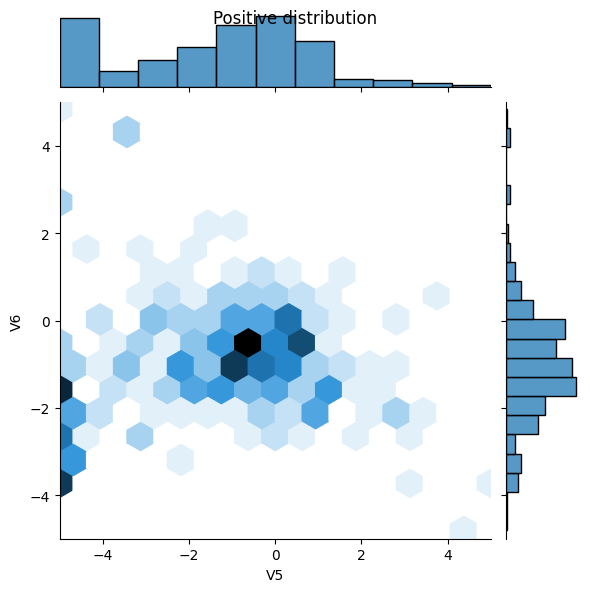

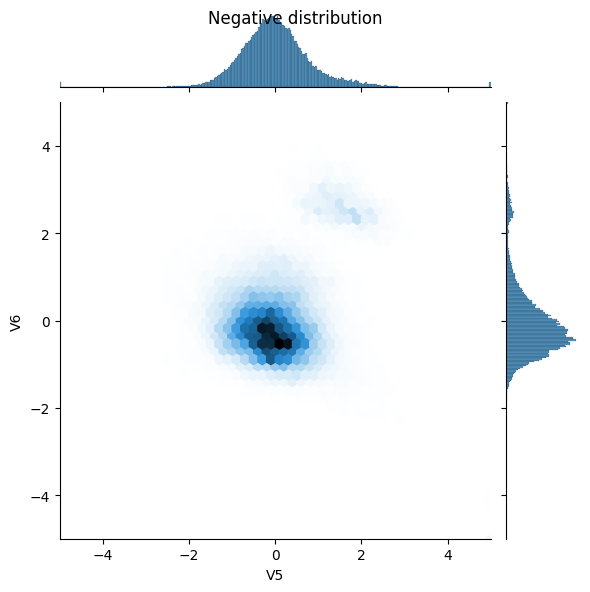

In [11]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [12]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

I0000 00:00:1724117041.170464    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724117041.173954    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724117041.177520    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724117041.181109    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.
These can be divided into three groups.

#### Metrics for probability predictions

As we train our network with the cross entropy as a loss function, it is fully capable of predicting class probabilities, i.e., it is a probabilistic classifier.
Good metrics to assess probabilistic predictions are, in fact, **proper scoring rules**. Their key property is that predicting the true probability is optimal. We give two well-known examples:

*   **cross entropy** also known as log loss
*   **Mean squared error** also known as the Brier score

#### Metrics for deterministic 0/1 predictions

In the end, one often wants to predict a class label, 0 or 1, *no fraud* or *fraud*.
This is called a deterministic classifier.
To get a label prediction from our probabilistic classifier, one needs to choose a probability threshold $t$.
The default is to predict label 1 (fraud) if the predicted probability is larger than $t=50\%$ and all the following metrics implicitly use this default.

*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$

**Note:** Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

#### Other metrices

The following metrics take into account all possible choices of thresholds $t$.

*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.


#### Read more:
*   [Strictly Proper Scoring Rules, Prediction, and Estimation](https://www.stat.washington.edu/people/raftery/Research/PDF/Gneiting2007jasa.pdf)
*   [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*   [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: Fitting this model will not handle the class imbalance efficiently. You will improve it later in this tutorial.

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [14]:
model = make_model()
model.summary()

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Test run the model:

In [15]:
model.predict(train_features[:10])

I0000 00:00:1724117043.823774    9549 service.cc:146] XLA service 0x7fea68004b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724117043.823800    9549 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724117043.823804    9549 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724117043.823807    9549 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1724117043.823810    9549 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


I0000 00:00:1724117044.138972    9549 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[0.84266186],
       [0.7813171 ],
       [0.6577562 ],
       [0.31665987],
       [0.7259872 ],
       [0.75527847],
       [0.8158303 ],
       [0.79921526],
       [0.5311201 ],
       [0.5076145 ]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314`

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.3086


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [17]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

It should be near: `pos/total = 0.0018`

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


array([[0.00307125],
       [0.00107507],
       [0.00133634],
       [0.00349519],
       [0.00385559],
       [0.00109737],
       [0.00313226],
       [0.00399533],
       [0.00180062],
       [0.00645342]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0121


This initial loss is about 50 times less than it would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. It also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [20]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [21]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [22]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [23]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

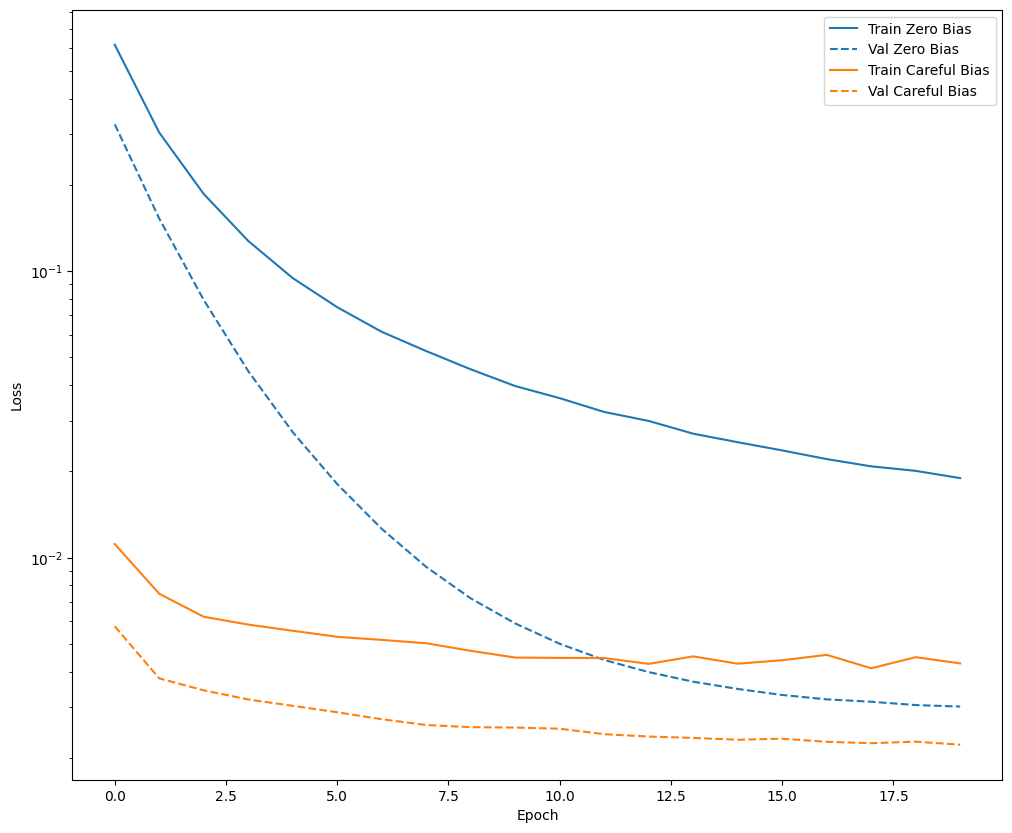

In [24]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage.

### Train the model

In [25]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 5:00 3s/step - Brier score: 4.8241e-04 - accuracy: 0.9995 - auc: 0.9423 - cross entropy: 0.0029 - fn: 20.0000 - fp: 5.0000 - loss: 0.0172 - prc: 0.8275 - precision: 0.9315 - recall: 0.7727 - tn: 47524.0000 - tp: 68.0000

23/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.2044e-04 - accuracy: 0.9990 - auc: 0.8808 - cross entropy: 0.0058 - fn: 51.3478 - fp: 23.1739 - loss: 0.0134 - prc: 0.6085 - precision: 0.7575 - recall: 0.5881 - tn: 70002.4766 - tp: 68.0000

48/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0011 - accuracy: 0.9987 - auc: 0.8472 - cross entropy: 0.0073 - fn: 92.5417 - fp: 36.7708 - loss: 0.0130 - prc: 0.4878 - precision: 0.6688 - recall: 0.4659 - tn: 95546.7500 - tp: 68.9375    

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0012 - accuracy: 0.9986 - auc: 0.8305 - cross entropy: 0.0079 - fn: 131.0411 - fp: 45.4795 - loss: 0.0125 - prc: 0.4273 - precision: 0.6310 - recall: 0.4017 - tn: 121096.1953 - tp: 72.2877

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0013 - accuracy: 0.9986 - auc: 0.8239 - cross entropy: 0.0081 - fn: 157.4000 - fp: 49.8667 - loss: 0.0123 - prc: 0.4031 - precision: 0.6210 - recall: 0.3747 - tn: 138446.5938 - tp: 76.4222

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - Brier score: 0.0013 - accuracy: 0.9986 - auc: 0.8236 - cross entropy: 0.0082 - fn: 158.8681 - fp: 50.0989 - loss: 0.0123 - prc: 0.4019 - precision: 0.6206 - recall: 0.3733 - tn: 139423.9375 - tp: 76.6703 - val_Brier score: 0.0011 - val_accuracy: 0.9984 - val_auc: 0.9384 - val_cross entropy: 0.0054 - val_fn: 70.0000 - val_fp: 1.0000 - val_loss: 0.0054 - val_prc: 0.7641 - val_precision: 0.9231 - val_recall: 0.1463 - val_tn: 45486.0000 - val_tp: 12.0000


Epoch 2/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - Brier score: 1.0060e-04 - accuracy: 1.0000 - auc: 1.0000 - cross entropy: 0.0027 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0027 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 2047.0000 - tp: 1.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0011 - accuracy: 0.9989 - auc: 0.8707 - cross entropy: 0.0074 - fn: 27.1667 - fp: 3.9167 - loss: 0.0074 - prc: 0.5225 - precision: 0.8736 - recall: 0.4837 - tn: 25549.1660 - tp: 19.7500          

48/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0011 - accuracy: 0.9989 - auc: 0.8722 - cross entropy: 0.0075 - fn: 51.9167 - fp: 8.6042 - loss: 0.0075 - prc: 0.4841 - precision: 0.8348 - recall: 0.4423 - tn: 50079.6445 - tp: 35.8333

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0011 - accuracy: 0.9989 - auc: 0.8716 - cross entropy: 0.0074 - fn: 76.9452 - fp: 12.6164 - loss: 0.0074 - prc: 0.4821 - precision: 0.8282 - recall: 0.4344 - tn: 75632.0000 - tp: 54.4384

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0011 - accuracy: 0.9988 - auc: 0.8707 - cross entropy: 0.0073 - fn: 96.2308 - fp: 15.1319 - loss: 0.0073 - prc: 0.4775 - precision: 0.8256 - recall: 0.4258 - tn: 93963.4297 - tp: 65.7802 - val_Brier score: 6.3164e-04 - val_accuracy: 0.9993 - val_auc: 0.9327 - val_cross entropy: 0.0039 - val_fn: 28.0000 - val_fp: 6.0000 - val_loss: 0.0039 - val_prc: 0.7800 - val_precision: 0.9000 - val_recall: 0.6585 - val_tn: 45481.0000 - val_tp: 54.0000


Epoch 3/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 1.6159e-05 - accuracy: 1.0000 - auc: 0.0000e+00 - cross entropy: 0.0017 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0017 - prc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2048.0000 - tp: 0.0000e+00

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2879e-04 - accuracy: 0.9989 - auc: 0.8292 - cross entropy: 0.0052 - fn: 23.1667 - fp: 8.0417 - loss: 0.0052 - prc: 0.4518 - precision: 0.5768 - recall: 0.3527 - tn: 25554.2090 - tp: 14.5833                          

46/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.6755e-04 - accuracy: 0.9988 - auc: 0.8446 - cross entropy: 0.0061 - fn: 49.9130 - fp: 13.6522 - loss: 0.0061 - prc: 0.4499 - precision: 0.6282 - recall: 0.3528 - tn: 48036.2812 - tp: 28.1522

68/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0010 - accuracy: 0.9988 - auc: 0.8518 - cross entropy: 0.0063 - fn: 73.3971 - fp: 18.2206 - loss: 0.0063 - prc: 0.4544 - precision: 0.6598 - recall: 0.3599 - tn: 70521.5000 - tp: 42.8824    

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0010 - accuracy: 0.9988 - auc: 0.8568 - cross entropy: 0.0064 - fn: 96.9670 - fp: 22.6703 - loss: 0.0064 - prc: 0.4659 - precision: 0.6843 - recall: 0.3704 - tn: 93960.5859 - tp: 60.3517 - val_Brier score: 5.2946e-04 - val_accuracy: 0.9994 - val_auc: 0.9327 - val_cross entropy: 0.0034 - val_fn: 22.0000 - val_fp: 7.0000 - val_loss: 0.0034 - val_prc: 0.8030 - val_precision: 0.8955 - val_recall: 0.7317 - val_tn: 45480.0000 - val_tp: 60.0000


Epoch 4/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 6.3397e-04 - accuracy: 0.9990 - auc: 0.9980 - cross entropy: 0.0037 - fn: 1.0000 - fp: 1.0000 - loss: 0.0037 - prc: 0.1074 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2046.0000 - tp: 0.0000e+00

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5081e-04 - accuracy: 0.9991 - auc: 0.9129 - cross entropy: 0.0047 - fn: 22.3846 - fp: 2.5000 - loss: 0.0047 - prc: 0.5223 - precision: 0.6904 - recall: 0.3075 - tn: 27608.1914 - tp: 14.9231          

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0688e-04 - accuracy: 0.9990 - auc: 0.9220 - cross entropy: 0.0050 - fn: 45.3846 - fp: 8.5385 - loss: 0.0050 - prc: 0.5702 - precision: 0.7497 - recall: 0.3897 - tn: 54180.0586 - tp: 38.0192

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2630e-04 - accuracy: 0.9990 - auc: 0.9184 - cross entropy: 0.0052 - fn: 66.9744 - fp: 13.7949 - loss: 0.0052 - prc: 0.5836 - precision: 0.7727 - recall: 0.4258 - tn: 80753.4141 - tp: 61.8205

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 8.3760e-04 - accuracy: 0.9990 - auc: 0.9158 - cross entropy: 0.0052 - fn: 78.3736 - fp: 16.5714 - loss: 0.0052 - prc: 0.5847 - precision: 0.7786 - recall: 0.4360 - tn: 93971.8984 - tp: 73.7253 - val_Brier score: 5.1657e-04 - val_accuracy: 0.9994 - val_auc: 0.9328 - val_cross entropy: 0.0032 - val_fn: 20.0000 - val_fp: 7.0000 - val_loss: 0.0032 - val_prc: 0.8076 - val_precision: 0.8986 - val_recall: 0.7561 - val_tn: 45480.0000 - val_tp: 62.0000


Epoch 5/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 0.0016 - accuracy: 0.9980 - auc: 0.6592 - cross entropy: 0.0094 - fn: 3.0000 - fp: 1.0000 - loss: 0.0094 - prc: 0.1042 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2044.0000 - tp: 0.0000e+00

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0011 - accuracy: 0.9986 - auc: 0.8798 - cross entropy: 0.0064 - fn: 27.0000 - fp: 5.2917 - loss: 0.0064 - prc: 0.6326 - precision: 0.7874 - recall: 0.4486 - tn: 25542.5840 - tp: 25.1250          

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.7706e-04 - accuracy: 0.9988 - auc: 0.8922 - cross entropy: 0.0058 - fn: 45.5319 - fp: 8.6596 - loss: 0.0058 - prc: 0.6538 - precision: 0.8140 - recall: 0.4738 - tn: 49053.1914 - tp: 44.6170

71/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.1842e-04 - accuracy: 0.9989 - auc: 0.8974 - cross entropy: 0.0055 - fn: 63.1831 - fp: 13.0845 - loss: 0.0055 - prc: 0.6589 - precision: 0.8180 - recall: 0.4868 - tn: 73587.4609 - tp: 64.2676

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 9.0654e-04 - accuracy: 0.9989 - auc: 0.8996 - cross entropy: 0.0054 - fn: 79.9890 - fp: 17.5714 - loss: 0.0054 - prc: 0.6563 - precision: 0.8161 - recall: 0.4906 - tn: 93961.6562 - tp: 81.3516 - val_Brier score: 4.8831e-04 - val_accuracy: 0.9995 - val_auc: 0.9328 - val_cross entropy: 0.0030 - val_fn: 18.0000 - val_fp: 7.0000 - val_loss: 0.0030 - val_prc: 0.8190 - val_precision: 0.9014 - val_recall: 0.7805 - val_tn: 45480.0000 - val_tp: 64.0000


Epoch 6/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 0.0013 - accuracy: 0.9985 - auc: 0.4907 - cross entropy: 0.0076 - fn: 1.0000 - fp: 2.0000 - loss: 0.0076 - prc: 4.6001e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2045.0000 - tp: 0.0000e+00

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.6257e-04 - accuracy: 0.9989 - auc: 0.8905 - cross entropy: 0.0055 - fn: 24.0769 - fp: 6.5385 - loss: 0.0055 - prc: 0.6043 - precision: 0.7427 - recall: 0.4944 - tn: 27591.5762 - tp: 25.8077          

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.7424e-04 - accuracy: 0.9989 - auc: 0.8888 - cross entropy: 0.0057 - fn: 46.5490 - fp: 12.5686 - loss: 0.0057 - prc: 0.5865 - precision: 0.7589 - recall: 0.4889 - tn: 53143.9414 - tp: 44.9412

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.6357e-04 - accuracy: 0.9989 - auc: 0.8885 - cross entropy: 0.0057 - fn: 69.0649 - fp: 17.7792 - loss: 0.0057 - prc: 0.5819 - precision: 0.7716 - recall: 0.4896 - tn: 79718.3672 - tp: 66.7922

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 9.5687e-04 - accuracy: 0.9989 - auc: 0.8888 - cross entropy: 0.0057 - fn: 80.5934 - fp: 20.6374 - loss: 0.0057 - prc: 0.5832 - precision: 0.7764 - recall: 0.4924 - tn: 93959.9766 - tp: 79.3626 - val_Brier score: 4.8348e-04 - val_accuracy: 0.9994 - val_auc: 0.9327 - val_cross entropy: 0.0029 - val_fn: 19.0000 - val_fp: 7.0000 - val_loss: 0.0029 - val_prc: 0.8328 - val_precision: 0.9000 - val_recall: 0.7683 - val_tn: 45480.0000 - val_tp: 63.0000


Epoch 7/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0015 - accuracy: 0.9980 - auc: 0.7471 - cross entropy: 0.0085 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0085 - prc: 0.5026 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2044.0000 - tp: 0.0000e+00

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0011 - accuracy: 0.9988 - auc: 0.9101 - cross entropy: 0.0059 - fn: 24.1154 - fp: 8.2692 - loss: 0.0059 - prc: 0.6394 - precision: 0.7617 - recall: 0.5225 - tn: 27585.8086 - tp: 29.8077              

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0010 - accuracy: 0.9988 - auc: 0.9146 - cross entropy: 0.0056 - fn: 46.9615 - fp: 14.7885 - loss: 0.0056 - prc: 0.6461 - precision: 0.7745 - recall: 0.5293 - tn: 54155.4219 - tp: 54.8269

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.8136e-04 - accuracy: 0.9989 - auc: 0.9150 - cross entropy: 0.0054 - fn: 68.7403 - fp: 18.0390 - loss: 0.0054 - prc: 0.6518 - precision: 0.7924 - recall: 0.5248 - tn: 79708.8203 - tp: 76.4026

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 9.6310e-04 - accuracy: 0.9989 - auc: 0.9151 - cross entropy: 0.0054 - fn: 79.7912 - fp: 19.9341 - loss: 0.0054 - prc: 0.6522 - precision: 0.7985 - recall: 0.5236 - tn: 93953.0469 - tp: 87.8022 - val_Brier score: 4.6162e-04 - val_accuracy: 0.9995 - val_auc: 0.9449 - val_cross entropy: 0.0028 - val_fn: 16.0000 - val_fp: 8.0000 - val_loss: 0.0028 - val_prc: 0.8431 - val_precision: 0.8919 - val_recall: 0.8049 - val_tn: 45479.0000 - val_tp: 66.0000


Epoch 8/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 0.0022 - accuracy: 0.9976 - auc: 0.7458 - cross entropy: 0.0124 - fn: 4.0000 - fp: 1.0000 - loss: 0.0124 - prc: 0.3157 - precision: 0.6667 - recall: 0.3333 - tn: 2041.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0010 - accuracy: 0.9989 - auc: 0.8471 - cross entropy: 0.0064 - fn: 21.0800 - fp: 6.6000 - loss: 0.0064 - prc: 0.4969 - precision: 0.7735 - recall: 0.5104 - tn: 26573.7207 - tp: 22.6000

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.5419e-04 - accuracy: 0.9989 - auc: 0.8696 - cross entropy: 0.0058 - fn: 41.2400 - fp: 12.1200 - loss: 0.0058 - prc: 0.5544 - precision: 0.7828 - recall: 0.5172 - tn: 52125.3789 - tp: 45.2600

75/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.1106e-04 - accuracy: 0.9990 - auc: 0.8811 - cross entropy: 0.0055 - fn: 60.4000 - fp: 16.2133 - loss: 0.0055 - prc: 0.5902 - precision: 0.7991 - recall: 0.5286 - tn: 77676.7031 - tp: 70.6800

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 8.9193e-04 - accuracy: 0.9990 - auc: 0.8859 - cross entropy: 0.0054 - fn: 72.3516 - fp: 18.9670 - loss: 0.0054 - prc: 0.6052 - precision: 0.8055 - recall: 0.5336 - tn: 93962.6172 - tp: 86.6374 - val_Brier score: 4.4717e-04 - val_accuracy: 0.9995 - val_auc: 0.9509 - val_cross entropy: 0.0027 - val_fn: 16.0000 - val_fp: 8.0000 - val_loss: 0.0027 - val_prc: 0.8545 - val_precision: 0.8919 - val_recall: 0.8049 - val_tn: 45479.0000 - val_tp: 66.0000


Epoch 9/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 0.0015 - accuracy: 0.9985 - auc: 0.6617 - cross entropy: 0.0099 - fn: 2.0000 - fp: 1.0000 - loss: 0.0099 - prc: 0.1687 - precision: 0.5000 - recall: 0.3333 - tn: 2044.0000 - tp: 1.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0894e-04 - accuracy: 0.9991 - auc: 0.8921 - cross entropy: 0.0049 - fn: 19.9259 - fp: 5.2963 - loss: 0.0049 - prc: 0.5856 - precision: 0.7848 - recall: 0.5640 - tn: 28617.5176 - tp: 29.2593

53/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2424e-04 - accuracy: 0.9991 - auc: 0.8953 - cross entropy: 0.0049 - fn: 42.1698 - fp: 10.0377 - loss: 0.0049 - prc: 0.6235 - precision: 0.8162 - recall: 0.5617 - tn: 55188.8125 - tp: 54.9811

79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.3904e-04 - accuracy: 0.9990 - auc: 0.8981 - cross entropy: 0.0050 - fn: 64.4177 - fp: 16.3924 - loss: 0.0050 - prc: 0.6346 - precision: 0.8168 - recall: 0.5565 - tn: 81758.7578 - tp: 80.4304

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 8.3613e-04 - accuracy: 0.9990 - auc: 0.8997 - cross entropy: 0.0049 - fn: 73.0000 - fp: 19.3956 - loss: 0.0049 - prc: 0.6382 - precision: 0.8158 - recall: 0.5571 - tn: 93956.5312 - tp: 91.6484 - val_Brier score: 4.3421e-04 - val_accuracy: 0.9995 - val_auc: 0.9571 - val_cross entropy: 0.0025 - val_fn: 16.0000 - val_fp: 8.0000 - val_loss: 0.0025 - val_prc: 0.8708 - val_precision: 0.8919 - val_recall: 0.8049 - val_tn: 45479.0000 - val_tp: 66.0000


Epoch 10/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 5.0903e-04 - accuracy: 0.9995 - auc: 0.9970 - cross entropy: 0.0034 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0034 - prc: 0.7084 - precision: 1.0000 - recall: 0.6667 - tn: 2045.0000 - tp: 2.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.1275e-04 - accuracy: 0.9991 - auc: 0.9393 - cross entropy: 0.0047 - fn: 24.1923 - fp: 3.2692 - loss: 0.0047 - prc: 0.6942 - precision: 0.9098 - recall: 0.5348 - tn: 27594.0762 - tp: 26.4615  

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2387e-04 - accuracy: 0.9991 - auc: 0.9353 - cross entropy: 0.0047 - fn: 43.6471 - fp: 7.9216 - loss: 0.0047 - prc: 0.6891 - precision: 0.8874 - recall: 0.5452 - tn: 53143.7070 - tp: 52.7255

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2796e-04 - accuracy: 0.9991 - auc: 0.9310 - cross entropy: 0.0047 - fn: 64.1299 - fp: 12.0390 - loss: 0.0047 - prc: 0.6833 - precision: 0.8793 - recall: 0.5464 - tn: 79717.8828 - tp: 77.9481

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 8.2062e-04 - accuracy: 0.9991 - auc: 0.9295 - cross entropy: 0.0047 - fn: 73.4615 - fp: 14.4176 - loss: 0.0047 - prc: 0.6825 - precision: 0.8762 - recall: 0.5505 - tn: 93960.9688 - tp: 91.7253 - val_Brier score: 4.3984e-04 - val_accuracy: 0.9995 - val_auc: 0.9571 - val_cross entropy: 0.0025 - val_fn: 16.0000 - val_fp: 8.0000 - val_loss: 0.0025 - val_prc: 0.8678 - val_precision: 0.8919 - val_recall: 0.8049 - val_tn: 45479.0000 - val_tp: 66.0000


Epoch 11/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 0.0011 - accuracy: 0.9985 - auc: 0.8740 - cross entropy: 0.0060 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0060 - prc: 0.7518 - precision: 1.0000 - recall: 0.2500 - tn: 2044.0000 - tp: 1.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.3681e-04 - accuracy: 0.9991 - auc: 0.9300 - cross entropy: 0.0040 - fn: 22.0000 - fp: 4.1481 - loss: 0.0040 - prc: 0.7141 - precision: 0.8671 - recall: 0.5064 - tn: 28624.0742 - tp: 21.7778

53/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.7205e-04 - accuracy: 0.9991 - auc: 0.9217 - cross entropy: 0.0042 - fn: 41.9434 - fp: 9.6792 - loss: 0.0042 - prc: 0.6813 - precision: 0.8405 - recall: 0.5102 - tn: 55200.6602 - tp: 43.7170

79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.9157e-04 - accuracy: 0.9991 - auc: 0.9171 - cross entropy: 0.0043 - fn: 62.3165 - fp: 15.7468 - loss: 0.0043 - prc: 0.6668 - precision: 0.8275 - recall: 0.5146 - tn: 81775.0859 - tp: 66.8481

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.9813e-04 - accuracy: 0.9991 - auc: 0.9156 - cross entropy: 0.0044 - fn: 72.3407 - fp: 18.0659 - loss: 0.0044 - prc: 0.6653 - precision: 0.8269 - recall: 0.5163 - tn: 93971.7344 - tp: 78.4286 - val_Brier score: 4.2948e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0025 - val_fn: 16.0000 - val_fp: 8.0000 - val_loss: 0.0025 - val_prc: 0.8749 - val_precision: 0.8919 - val_recall: 0.8049 - val_tn: 45479.0000 - val_tp: 66.0000


Epoch 12/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 0.0012 - accuracy: 0.9985 - auc: 0.8735 - cross entropy: 0.0079 - fn: 2.0000 - fp: 1.0000 - loss: 0.0079 - prc: 0.7533 - precision: 0.8571 - recall: 0.7500 - tn: 2039.0000 - tp: 6.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.1349e-04 - accuracy: 0.9990 - auc: 0.8719 - cross entropy: 0.0050 - fn: 19.0385 - fp: 8.5385 - loss: 0.0050 - prc: 0.6183 - precision: 0.7481 - recall: 0.6015 - tn: 27594.9238 - tp: 25.5000

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2927e-04 - accuracy: 0.9990 - auc: 0.8833 - cross entropy: 0.0049 - fn: 40.7308 - fp: 14.2500 - loss: 0.0049 - prc: 0.6207 - precision: 0.7579 - recall: 0.5613 - tn: 54170.1914 - tp: 46.8269

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0377e-04 - accuracy: 0.9990 - auc: 0.8915 - cross entropy: 0.0047 - fn: 58.5897 - fp: 17.8205 - loss: 0.0047 - prc: 0.6428 - precision: 0.7830 - recall: 0.5638 - tn: 80746.6172 - tp: 72.9744

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.9645e-04 - accuracy: 0.9990 - auc: 0.8946 - cross entropy: 0.0046 - fn: 67.5824 - fp: 19.9231 - loss: 0.0046 - prc: 0.6488 - precision: 0.7907 - recall: 0.5660 - tn: 93966.6719 - tp: 86.3956 - val_Brier score: 4.2749e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0025 - val_fn: 13.0000 - val_fp: 8.0000 - val_loss: 0.0025 - val_prc: 0.8747 - val_precision: 0.8961 - val_recall: 0.8415 - val_tn: 45479.0000 - val_tp: 69.0000


Epoch 13/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 6.9542e-04 - accuracy: 0.9990 - auc: 0.8734 - cross entropy: 0.0051 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0051 - prc: 0.7517 - precision: 1.0000 - recall: 0.5000 - tn: 2044.0000 - tp: 2.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.7275e-04 - accuracy: 0.9990 - auc: 0.9131 - cross entropy: 0.0046 - fn: 21.8148 - fp: 6.5556 - loss: 0.0046 - prc: 0.7256 - precision: 0.8622 - recall: 0.5705 - tn: 28613.0742 - tp: 30.5556  

53/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.9820e-04 - accuracy: 0.9990 - auc: 0.9185 - cross entropy: 0.0047 - fn: 39.3208 - fp: 15.1321 - loss: 0.0047 - prc: 0.7077 - precision: 0.8280 - recall: 0.5930 - tn: 55180.3203 - tp: 61.2264

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0118e-04 - accuracy: 0.9990 - auc: 0.9190 - cross entropy: 0.0047 - fn: 57.5769 - fp: 20.9231 - loss: 0.0047 - prc: 0.6986 - precision: 0.8221 - recall: 0.5941 - tn: 80730.4844 - tp: 87.0128

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.9827e-04 - accuracy: 0.9990 - auc: 0.9186 - cross entropy: 0.0047 - fn: 67.0220 - fp: 22.9341 - loss: 0.0047 - prc: 0.6959 - precision: 0.8234 - recall: 0.5924 - tn: 93951.3984 - tp: 99.2198 - val_Brier score: 4.1913e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0024 - val_fn: 14.0000 - val_fp: 8.0000 - val_loss: 0.0024 - val_prc: 0.8769 - val_precision: 0.8947 - val_recall: 0.8293 - val_tn: 45479.0000 - val_tp: 68.0000


Epoch 14/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 4.9113e-04 - accuracy: 0.9995 - auc: 0.7473 - cross entropy: 0.0054 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0054 - prc: 0.5013 - precision: 1.0000 - recall: 0.5000 - tn: 2046.0000 - tp: 1.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7095e-04 - accuracy: 0.9993 - auc: 0.8609 - cross entropy: 0.0047 - fn: 17.0000 - fp: 2.2500 - loss: 0.0047 - prc: 0.6641 - precision: 0.9330 - recall: 0.5806 - tn: 25556.0840 - tp: 24.6667  

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7074e-04 - accuracy: 0.9993 - auc: 0.8847 - cross entropy: 0.0044 - fn: 31.1915 - fp: 6.4468 - loss: 0.0044 - prc: 0.6905 - precision: 0.9091 - recall: 0.6065 - tn: 49063.1484 - tp: 51.2128

70/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8407e-04 - accuracy: 0.9992 - auc: 0.8949 - cross entropy: 0.0043 - fn: 46.0857 - fp: 11.9571 - loss: 0.0043 - prc: 0.7014 - precision: 0.8898 - recall: 0.6152 - tn: 72568.1562 - tp: 77.8000

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.9193e-04 - accuracy: 0.9992 - auc: 0.8996 - cross entropy: 0.0043 - fn: 60.7692 - fp: 15.8462 - loss: 0.0043 - prc: 0.7059 - precision: 0.8820 - recall: 0.6140 - tn: 93964.6172 - tp: 99.3407 - val_Brier score: 4.0537e-04 - val_accuracy: 0.9995 - val_auc: 0.9571 - val_cross entropy: 0.0024 - val_fn: 14.0000 - val_fp: 8.0000 - val_loss: 0.0024 - val_prc: 0.8751 - val_precision: 0.8947 - val_recall: 0.8293 - val_tn: 45479.0000 - val_tp: 68.0000


Epoch 15/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0022 - accuracy: 0.9971 - auc: 0.8547 - cross entropy: 0.0113 - fn: 6.0000 - fp: 0.0000e+00 - loss: 0.0113 - prc: 0.5775 - precision: 1.0000 - recall: 0.1429 - tn: 2041.0000 - tp: 1.0000

23/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0010 - accuracy: 0.9987 - auc: 0.8995 - cross entropy: 0.0055 - fn: 23.0435 - fp: 4.6087 - loss: 0.0055 - prc: 0.5795 - precision: 0.7756 - recall: 0.3747 - tn: 24532.2617 - tp: 16.0870  

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.2955e-04 - accuracy: 0.9989 - auc: 0.9036 - cross entropy: 0.0050 - fn: 41.0638 - fp: 8.9787 - loss: 0.0050 - prc: 0.6205 - precision: 0.8005 - recall: 0.4496 - tn: 49061.5547 - tp: 40.4043

71/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.9463e-04 - accuracy: 0.9989 - auc: 0.9062 - cross entropy: 0.0049 - fn: 59.4225 - fp: 13.2254 - loss: 0.0049 - prc: 0.6351 - precision: 0.8124 - recall: 0.4782 - tn: 73591.5625 - tp: 63.7887

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 8.7191e-04 - accuracy: 0.9990 - auc: 0.9083 - cross entropy: 0.0048 - fn: 73.3297 - fp: 16.7253 - loss: 0.0048 - prc: 0.6461 - precision: 0.8193 - recall: 0.4967 - tn: 93966.0078 - tp: 84.5055 - val_Brier score: 4.0166e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0023 - val_fn: 14.0000 - val_fp: 8.0000 - val_loss: 0.0023 - val_prc: 0.8796 - val_precision: 0.8947 - val_recall: 0.8293 - val_tn: 45479.0000 - val_tp: 68.0000


Epoch 16/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 4.3094e-05 - accuracy: 1.0000 - auc: 1.0000 - cross entropy: 7.2283e-04 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 7.2283e-04 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 2047.0000 - tp: 1.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5800e-04 - accuracy: 0.9991 - auc: 0.9234 - cross entropy: 0.0042 - fn: 20.6667 - fp: 6.2963 - loss: 0.0042 - prc: 0.7231 - precision: 0.8370 - recall: 0.6196 - tn: 28613.8145 - tp: 31.2222              

53/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.8812e-04 - accuracy: 0.9991 - auc: 0.9268 - cross entropy: 0.0043 - fn: 40.6226 - fp: 12.2075 - loss: 0.0043 - prc: 0.7071 - precision: 0.8295 - recall: 0.6000 - tn: 55185.6992 - tp: 57.4717

79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.7441e-04 - accuracy: 0.9991 - auc: 0.9271 - cross entropy: 0.0042 - fn: 57.2785 - fp: 16.4051 - loss: 0.0042 - prc: 0.7072 - precision: 0.8362 - recall: 0.6025 - tn: 81761.1016 - tp: 85.2152

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.7092e-04 - accuracy: 0.9991 - auc: 0.9261 - cross entropy: 0.0042 - fn: 65.2308 - fp: 18.3187 - loss: 0.0042 - prc: 0.7057 - precision: 0.8384 - recall: 0.6026 - tn: 93959.4844 - tp: 97.5385 - val_Brier score: 3.9099e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0023 - val_fn: 14.0000 - val_fp: 8.0000 - val_loss: 0.0023 - val_prc: 0.8793 - val_precision: 0.8947 - val_recall: 0.8293 - val_tn: 45479.0000 - val_tp: 68.0000


Epoch 17/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 4.1629e-04 - accuracy: 0.9995 - auc: 0.9998 - cross entropy: 0.0018 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0018 - prc: 0.7973 - precision: 1.0000 - recall: 0.5000 - tn: 2046.0000 - tp: 1.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.4939e-04 - accuracy: 0.9994 - auc: 0.9742 - cross entropy: 0.0029 - fn: 13.0370 - fp: 6.4074 - loss: 0.0029 - prc: 0.7614 - precision: 0.8455 - recall: 0.7289 - tn: 28622.5547 - tp: 30.0000  

53/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.0406e-04 - accuracy: 0.9993 - auc: 0.9618 - cross entropy: 0.0032 - fn: 29.6226 - fp: 10.8113 - loss: 0.0032 - prc: 0.7395 - precision: 0.8452 - recall: 0.6856 - tn: 55199.4141 - tp: 56.1509

80/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.6247e-04 - accuracy: 0.9993 - auc: 0.9522 - cross entropy: 0.0035 - fn: 51.2875 - fp: 16.9625 - loss: 0.0035 - prc: 0.7250 - precision: 0.8393 - recall: 0.6561 - tn: 82791.5234 - tp: 84.2250

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.7751e-04 - accuracy: 0.9992 - auc: 0.9493 - cross entropy: 0.0036 - fn: 60.1648 - fp: 19.0440 - loss: 0.0036 - prc: 0.7219 - precision: 0.8393 - recall: 0.6479 - tn: 93965.7891 - tp: 95.5714 - val_Brier score: 3.9969e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0023 - val_fn: 13.0000 - val_fp: 8.0000 - val_loss: 0.0023 - val_prc: 0.8798 - val_precision: 0.8961 - val_recall: 0.8415 - val_tn: 45479.0000 - val_tp: 69.0000


Epoch 18/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 5.5516e-04 - accuracy: 0.9995 - auc: 0.9998 - cross entropy: 0.0030 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0030 - prc: 0.9288 - precision: 1.0000 - recall: 0.8000 - tn: 2043.0000 - tp: 4.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.0313e-04 - accuracy: 0.9993 - auc: 0.9406 - cross entropy: 0.0035 - fn: 12.8077 - fp: 6.8077 - loss: 0.0035 - prc: 0.7754 - precision: 0.8547 - recall: 0.7241 - tn: 27596.1914 - tp: 32.1923  

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3922e-04 - accuracy: 0.9992 - auc: 0.9321 - cross entropy: 0.0036 - fn: 29.3529 - fp: 13.0588 - loss: 0.0036 - prc: 0.7538 - precision: 0.8316 - recall: 0.6837 - tn: 53148.6094 - tp: 56.9804

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5616e-04 - accuracy: 0.9992 - auc: 0.9292 - cross entropy: 0.0037 - fn: 45.5789 - fp: 18.1711 - loss: 0.0037 - prc: 0.7439 - precision: 0.8303 - recall: 0.6684 - tn: 78700.8281 - tp: 83.4211

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.7281e-04 - accuracy: 0.9992 - auc: 0.9265 - cross entropy: 0.0038 - fn: 56.6483 - fp: 21.4066 - loss: 0.0038 - prc: 0.7349 - precision: 0.8293 - recall: 0.6590 - tn: 93963.6016 - tp: 98.9121 - val_Brier score: 3.8850e-04 - val_accuracy: 0.9995 - val_auc: 0.9631 - val_cross entropy: 0.0023 - val_fn: 14.0000 - val_fp: 8.0000 - val_loss: 0.0023 - val_prc: 0.8806 - val_precision: 0.8947 - val_recall: 0.8293 - val_tn: 45479.0000 - val_tp: 68.0000


Epoch 19/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 7.3613e-04 - accuracy: 0.9990 - auc: 0.9998 - cross entropy: 0.0031 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0031 - prc: 0.9288 - precision: 1.0000 - recall: 0.6000 - tn: 2043.0000 - tp: 3.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.0281e-04 - accuracy: 0.9990 - auc: 0.9217 - cross entropy: 0.0049 - fn: 25.8148 - fp: 3.9259 - loss: 0.0049 - prc: 0.7434 - precision: 0.9221 - recall: 0.5377 - tn: 28611.3711 - tp: 30.8889  

53/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.7033e-04 - accuracy: 0.9990 - auc: 0.9170 - cross entropy: 0.0047 - fn: 45.6038 - fp: 8.5849 - loss: 0.0047 - prc: 0.7279 - precision: 0.8957 - recall: 0.5537 - tn: 55182.9805 - tp: 58.8302

79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.3161e-04 - accuracy: 0.9990 - auc: 0.9160 - cross entropy: 0.0046 - fn: 60.4304 - fp: 13.9494 - loss: 0.0046 - prc: 0.7132 - precision: 0.8782 - recall: 0.5671 - tn: 81762.5312 - tp: 83.0886

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 8.2819e-04 - accuracy: 0.9991 - auc: 0.9152 - cross entropy: 0.0045 - fn: 68.9670 - fp: 16.4615 - loss: 0.0045 - prc: 0.7070 - precision: 0.8723 - recall: 0.5674 - tn: 93961.1875 - tp: 93.9560 - val_Brier score: 3.7945e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0022 - val_fn: 15.0000 - val_fp: 4.0000 - val_loss: 0.0022 - val_prc: 0.8846 - val_precision: 0.9437 - val_recall: 0.8171 - val_tn: 45483.0000 - val_tp: 67.0000


Epoch 20/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 8.5844e-04 - accuracy: 0.9990 - auc: 0.9997 - cross entropy: 0.0030 - fn: 1.0000 - fp: 1.0000 - loss: 0.0030 - prc: 0.7690 - precision: 0.6667 - recall: 0.6667 - tn: 2044.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5351e-04 - accuracy: 0.9992 - auc: 0.9276 - cross entropy: 0.0034 - fn: 17.3600 - fp: 4.3600 - loss: 0.0034 - prc: 0.7667 - precision: 0.8326 - recall: 0.6345 - tn: 26576.9199 - tp: 25.3600

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8994e-04 - accuracy: 0.9992 - auc: 0.9222 - cross entropy: 0.0037 - fn: 35.8980 - fp: 7.2041 - loss: 0.0037 - prc: 0.7536 - precision: 0.8586 - recall: 0.6106 - tn: 51105.5938 - tp: 51.3061

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.1891e-04 - accuracy: 0.9992 - auc: 0.9190 - cross entropy: 0.0039 - fn: 55.2055 - fp: 11.7808 - loss: 0.0039 - prc: 0.7404 - precision: 0.8581 - recall: 0.5984 - tn: 75632.9297 - tp: 76.0822

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.3339e-04 - accuracy: 0.9991 - auc: 0.9177 - cross entropy: 0.0040 - fn: 69.4066 - fp: 15.1868 - loss: 0.0040 - prc: 0.7302 - precision: 0.8563 - recall: 0.5912 - tn: 93962.6797 - tp: 93.2967 - val_Brier score: 3.9398e-04 - val_accuracy: 0.9996 - val_auc: 0.9631 - val_cross entropy: 0.0023 - val_fn: 12.0000 - val_fp: 8.0000 - val_loss: 0.0023 - val_prc: 0.8820 - val_precision: 0.8974 - val_recall: 0.8537 - val_tn: 45479.0000 - val_tp: 70.0000


Epoch 21/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 9.8651e-04 - accuracy: 0.9990 - auc: 0.9153 - cross entropy: 0.0066 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0066 - prc: 0.7250 - precision: 1.0000 - recall: 0.6667 - tn: 2042.0000 - tp: 4.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.6814e-04 - accuracy: 0.9993 - auc: 0.9422 - cross entropy: 0.0033 - fn: 15.3077 - fp: 4.5385 - loss: 0.0033 - prc: 0.7955 - precision: 0.8974 - recall: 0.6636 - tn: 27598.0391 - tp: 30.1154  

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.0300e-04 - accuracy: 0.9993 - auc: 0.9348 - cross entropy: 0.0035 - fn: 29.5098 - fp: 9.6275 - loss: 0.0035 - prc: 0.7655 - precision: 0.8770 - recall: 0.6659 - tn: 53150.1758 - tp: 58.6863

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3111e-04 - accuracy: 0.9993 - auc: 0.9294 - cross entropy: 0.0037 - fn: 47.8312 - fp: 14.1429 - loss: 0.0037 - prc: 0.7497 - precision: 0.8695 - recall: 0.6500 - tn: 79725.6484 - tp: 84.3766

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.4973e-04 - accuracy: 0.9992 - auc: 0.9275 - cross entropy: 0.0037 - fn: 58.8681 - fp: 16.9231 - loss: 0.0037 - prc: 0.7428 - precision: 0.8653 - recall: 0.6408 - tn: 93966.9141 - tp: 97.8681 - val_Brier score: 3.7917e-04 - val_accuracy: 0.9996 - val_auc: 0.9631 - val_cross entropy: 0.0022 - val_fn: 13.0000 - val_fp: 6.0000 - val_loss: 0.0022 - val_prc: 0.8842 - val_precision: 0.9200 - val_recall: 0.8415 - val_tn: 45481.0000 - val_tp: 69.0000


Epoch 22/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 1.0280e-04 - accuracy: 1.0000 - auc: 1.0000 - cross entropy: 7.2116e-04 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 7.2116e-04 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 2046.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.3697e-04 - accuracy: 0.9990 - auc: 0.9318 - cross entropy: 0.0045 - fn: 22.7600 - fp: 4.1200 - loss: 0.0045 - prc: 0.7145 - precision: 0.8437 - recall: 0.5491 - tn: 26570.1992 - tp: 26.9200              

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.1623e-04 - accuracy: 0.9990 - auc: 0.9244 - cross entropy: 0.0045 - fn: 38.7755 - fp: 9.1633 - loss: 0.0045 - prc: 0.7064 - precision: 0.8480 - recall: 0.5756 - tn: 51096.5117 - tp: 55.5510

74/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.9044e-04 - accuracy: 0.9991 - auc: 0.9220 - cross entropy: 0.0044 - fn: 54.4054 - fp: 13.9459 - loss: 0.0044 - prc: 0.7041 - precision: 0.8501 - recall: 0.5886 - tn: 76649.2031 - tp: 82.4459

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.8078e-04 - accuracy: 0.9991 - auc: 0.9217 - cross entropy: 0.0043 - fn: 65.3407 - fp: 17.4835 - loss: 0.0043 - prc: 0.7030 - precision: 0.8490 - recall: 0.5930 - tn: 93957.4062 - tp: 100.3407 - val_Brier score: 3.6988e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0022 - val_fn: 15.0000 - val_fp: 4.0000 - val_loss: 0.0022 - val_prc: 0.8860 - val_precision: 0.9437 - val_recall: 0.8171 - val_tn: 45483.0000 - val_tp: 67.0000


Epoch 23/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 7.1992e-04 - accuracy: 0.9990 - auc: 0.9995 - cross entropy: 0.0028 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0028 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - tn: 2044.0000 - tp: 2.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.9079e-04 - accuracy: 0.9993 - auc: 0.9364 - cross entropy: 0.0032 - fn: 12.4615 - fp: 4.5769 - loss: 0.0032 - prc: 0.7198 - precision: 0.8263 - recall: 0.7107 - tn: 27601.5000 - tp: 29.4615  

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.0390e-04 - accuracy: 0.9993 - auc: 0.9312 - cross entropy: 0.0034 - fn: 30.2115 - fp: 8.7115 - loss: 0.0034 - prc: 0.7294 - precision: 0.8449 - recall: 0.6716 - tn: 54178.3672 - tp: 54.7115

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4547e-04 - accuracy: 0.9993 - auc: 0.9291 - cross entropy: 0.0036 - fn: 50.2308 - fp: 14.0769 - loss: 0.0036 - prc: 0.7247 - precision: 0.8462 - recall: 0.6499 - tn: 80748.8828 - tp: 82.8077

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.5680e-04 - accuracy: 0.9992 - auc: 0.9284 - cross entropy: 0.0037 - fn: 59.4396 - fp: 16.5934 - loss: 0.0037 - prc: 0.7232 - precision: 0.8467 - recall: 0.6442 - tn: 93967.9141 - tp: 96.6264 - val_Brier score: 3.8501e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0022 - val_fn: 12.0000 - val_fp: 8.0000 - val_loss: 0.0022 - val_prc: 0.8874 - val_precision: 0.8974 - val_recall: 0.8537 - val_tn: 45479.0000 - val_tp: 70.0000


Epoch 24/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 0.0014 - accuracy: 0.9980 - auc: 0.9996 - cross entropy: 0.0051 - fn: 1.0000 - fp: 3.0000 - loss: 0.0051 - prc: 0.8844 - precision: 0.5000 - recall: 0.7500 - tn: 2041.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2411e-04 - accuracy: 0.9990 - auc: 0.9577 - cross entropy: 0.0042 - fn: 18.7200 - fp: 8.2000 - loss: 0.0042 - prc: 0.7223 - precision: 0.7394 - recall: 0.6537 - tn: 26566.8398 - tp: 30.2400

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0100e-04 - accuracy: 0.9990 - auc: 0.9433 - cross entropy: 0.0043 - fn: 36.1600 - fp: 12.3400 - loss: 0.0043 - prc: 0.7147 - precision: 0.7877 - recall: 0.6320 - tn: 52118.0000 - tp: 57.5000

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.7020e-04 - accuracy: 0.9991 - auc: 0.9374 - cross entropy: 0.0042 - fn: 52.6316 - fp: 16.0789 - loss: 0.0042 - prc: 0.7156 - precision: 0.8111 - recall: 0.6287 - tn: 78693.9844 - tp: 85.3026

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.6319e-04 - accuracy: 0.9991 - auc: 0.9350 - cross entropy: 0.0042 - fn: 62.4835 - fp: 18.8681 - loss: 0.0042 - prc: 0.7144 - precision: 0.8168 - recall: 0.6266 - tn: 93958.2656 - tp: 100.9560 - val_Brier score: 3.7177e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0022 - val_fn: 13.0000 - val_fp: 4.0000 - val_loss: 0.0022 - val_prc: 0.8853 - val_precision: 0.9452 - val_recall: 0.8415 - val_tn: 45483.0000 - val_tp: 69.0000


Epoch 25/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0014 - accuracy: 0.9980 - auc: 0.9995 - cross entropy: 0.0042 - fn: 3.0000 - fp: 1.0000 - loss: 0.0042 - prc: 0.8433 - precision: 0.7500 - recall: 0.5000 - tn: 2041.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.8691e-04 - accuracy: 0.9989 - auc: 0.9424 - cross entropy: 0.0041 - fn: 19.6400 - fp: 6.9600 - loss: 0.0041 - prc: 0.7102 - precision: 0.7852 - recall: 0.5518 - tn: 26571.0391 - tp: 26.3600

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.1432e-04 - accuracy: 0.9990 - auc: 0.9377 - cross entropy: 0.0041 - fn: 36.5306 - fp: 10.1633 - loss: 0.0041 - prc: 0.7090 - precision: 0.8185 - recall: 0.5736 - tn: 51100.8359 - tp: 52.4694

74/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.8811e-04 - accuracy: 0.9990 - auc: 0.9338 - cross entropy: 0.0041 - fn: 53.9730 - fp: 13.8108 - loss: 0.0041 - prc: 0.7068 - precision: 0.8338 - recall: 0.5824 - tn: 76652.7422 - tp: 79.4730

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.7663e-04 - accuracy: 0.9991 - auc: 0.9317 - cross entropy: 0.0041 - fn: 64.8681 - fp: 16.8901 - loss: 0.0041 - prc: 0.7062 - precision: 0.8374 - recall: 0.5877 - tn: 93961.2734 - tp: 97.5385 - val_Brier score: 3.6719e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0022 - val_fn: 16.0000 - val_fp: 4.0000 - val_loss: 0.0022 - val_prc: 0.8856 - val_precision: 0.9429 - val_recall: 0.8049 - val_tn: 45483.0000 - val_tp: 66.0000


Epoch 26/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 3.8111e-04 - accuracy: 0.9995 - auc: 1.0000 - cross entropy: 0.0015 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0015 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - tn: 2046.0000 - tp: 1.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.4853e-04 - accuracy: 0.9991 - auc: 0.9308 - cross entropy: 0.0041 - fn: 18.4400 - fp: 4.3600 - loss: 0.0041 - prc: 0.7885 - precision: 0.8805 - recall: 0.6184 - tn: 26569.3594 - tp: 31.8400  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5230e-04 - accuracy: 0.9991 - auc: 0.9281 - cross entropy: 0.0041 - fn: 36.0204 - fp: 9.1224 - loss: 0.0041 - prc: 0.7715 - precision: 0.8698 - recall: 0.6144 - tn: 51096.9609 - tp: 57.8980

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.6660e-04 - accuracy: 0.9991 - auc: 0.9260 - cross entropy: 0.0041 - fn: 55.7123 - fp: 13.4795 - loss: 0.0041 - prc: 0.7580 - precision: 0.8661 - recall: 0.6052 - tn: 75623.3984 - tp: 83.4110

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.6326e-04 - accuracy: 0.9991 - auc: 0.9250 - cross entropy: 0.0041 - fn: 68.6813 - fp: 16.3297 - loss: 0.0041 - prc: 0.7517 - precision: 0.8644 - recall: 0.6002 - tn: 93955.5312 - tp: 100.0330 - val_Brier score: 3.8389e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0022 - val_fn: 12.0000 - val_fp: 8.0000 - val_loss: 0.0022 - val_prc: 0.8845 - val_precision: 0.8974 - val_recall: 0.8537 - val_tn: 45479.0000 - val_tp: 70.0000


Epoch 27/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0017 - accuracy: 0.9980 - auc: 0.7449 - cross entropy: 0.0101 - fn: 3.0000 - fp: 1.0000 - loss: 0.0101 - prc: 0.2741 - precision: 0.5000 - recall: 0.2500 - tn: 2043.0000 - tp: 1.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.6202e-04 - accuracy: 0.9989 - auc: 0.9047 - cross entropy: 0.0052 - fn: 20.2308 - fp: 7.0385 - loss: 0.0052 - prc: 0.5747 - precision: 0.7237 - recall: 0.5133 - tn: 27592.4609 - tp: 28.2692

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.3925e-04 - accuracy: 0.9990 - auc: 0.9238 - cross entropy: 0.0045 - fn: 34.7059 - fp: 12.2157 - loss: 0.0045 - prc: 0.6556 - precision: 0.7805 - recall: 0.5802 - tn: 53141.7656 - tp: 59.3137

75/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0137e-04 - accuracy: 0.9991 - auc: 0.9274 - cross entropy: 0.0043 - fn: 50.9200 - fp: 16.2533 - loss: 0.0043 - prc: 0.6770 - precision: 0.8017 - recall: 0.5920 - tn: 77672.5312 - tp: 84.2933

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.8576e-04 - accuracy: 0.9991 - auc: 0.9288 - cross entropy: 0.0042 - fn: 61.5165 - fp: 18.7802 - loss: 0.0042 - prc: 0.6859 - precision: 0.8108 - recall: 0.5962 - tn: 93959.4844 - tp: 100.7912 - val_Brier score: 3.6900e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0021 - val_prc: 0.8899 - val_precision: 0.9211 - val_recall: 0.8537 - val_tn: 45481.0000 - val_tp: 70.0000


Epoch 28/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 0.0013 - accuracy: 0.9985 - auc: 0.9998 - cross entropy: 0.0047 - fn: 2.0000 - fp: 1.0000 - loss: 0.0047 - prc: 0.8723 - precision: 0.6667 - recall: 0.5000 - tn: 2043.0000 - tp: 2.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.2289e-04 - accuracy: 0.9989 - auc: 0.9120 - cross entropy: 0.0047 - fn: 21.3077 - fp: 8.2692 - loss: 0.0047 - prc: 0.5834 - precision: 0.6899 - recall: 0.5179 - tn: 27596.8086 - tp: 21.6154

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.9797e-04 - accuracy: 0.9990 - auc: 0.9156 - cross entropy: 0.0046 - fn: 40.2941 - fp: 12.6078 - loss: 0.0046 - prc: 0.6146 - precision: 0.7502 - recall: 0.5366 - tn: 53146.8828 - tp: 48.2157

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.5397e-04 - accuracy: 0.9990 - auc: 0.9193 - cross entropy: 0.0045 - fn: 56.1053 - fp: 16.7632 - loss: 0.0045 - prc: 0.6379 - precision: 0.7802 - recall: 0.5584 - tn: 78698.5938 - tp: 76.5395

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 8.3276e-04 - accuracy: 0.9991 - auc: 0.9218 - cross entropy: 0.0044 - fn: 65.2527 - fp: 19.2308 - loss: 0.0044 - prc: 0.6487 - precision: 0.7912 - recall: 0.5671 - tn: 93963.1953 - tp: 92.8901 - val_Brier score: 3.6730e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0022 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0022 - val_prc: 0.8855 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 29/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 3.7853e-04 - accuracy: 0.9990 - auc: 1.0000 - cross entropy: 0.0014 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0014 - prc: 1.0000 - precision: 1.0000 - recall: 0.6000 - tn: 2043.0000 - tp: 3.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.9173e-04 - accuracy: 0.9993 - auc: 0.9255 - cross entropy: 0.0032 - fn: 19.2593 - fp: 1.5185 - loss: 0.0032 - prc: 0.8126 - precision: 0.9643 - recall: 0.6294 - tn: 28620.3711 - tp: 30.8519  

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3518e-04 - accuracy: 0.9992 - auc: 0.9248 - cross entropy: 0.0034 - fn: 36.0769 - fp: 5.8462 - loss: 0.0034 - prc: 0.7836 - precision: 0.9289 - recall: 0.6183 - tn: 54173.6172 - tp: 56.4615

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5944e-04 - accuracy: 0.9992 - auc: 0.9250 - cross entropy: 0.0035 - fn: 52.8831 - fp: 11.6104 - loss: 0.0035 - prc: 0.7673 - precision: 0.9052 - recall: 0.6173 - tn: 79723.6719 - tp: 83.8312

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.6513e-04 - accuracy: 0.9992 - auc: 0.9247 - cross entropy: 0.0036 - fn: 61.8352 - fp: 14.6923 - loss: 0.0036 - prc: 0.7626 - precision: 0.8972 - recall: 0.6181 - tn: 93964.9375 - tp: 99.1099 - val_Brier score: 3.6506e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8872 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 30/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 6.6586e-04 - accuracy: 0.9990 - auc: 0.9999 - cross entropy: 0.0024 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0024 - prc: 0.9663 - precision: 1.0000 - recall: 0.7143 - tn: 2041.0000 - tp: 5.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.6405e-04 - accuracy: 0.9990 - auc: 0.9622 - cross entropy: 0.0036 - fn: 19.1154 - fp: 5.6538 - loss: 0.0036 - prc: 0.8059 - precision: 0.8421 - recall: 0.6236 - tn: 27591.6543 - tp: 31.5769  

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.0694e-04 - accuracy: 0.9991 - auc: 0.9554 - cross entropy: 0.0035 - fn: 32.8431 - fp: 9.7843 - loss: 0.0035 - prc: 0.7903 - precision: 0.8519 - recall: 0.6369 - tn: 53146.1367 - tp: 59.2353

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.0833e-04 - accuracy: 0.9991 - auc: 0.9478 - cross entropy: 0.0036 - fn: 50.4805 - fp: 14.1688 - loss: 0.0036 - prc: 0.7718 - precision: 0.8551 - recall: 0.6328 - tn: 79720.4141 - tp: 86.9351

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.1007e-04 - accuracy: 0.9991 - auc: 0.9455 - cross entropy: 0.0036 - fn: 60.5385 - fp: 16.3956 - loss: 0.0036 - prc: 0.7654 - precision: 0.8556 - recall: 0.6277 - tn: 93963.3984 - tp: 100.2418 - val_Brier score: 3.6817e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0021 - val_prc: 0.8868 - val_precision: 0.9211 - val_recall: 0.8537 - val_tn: 45481.0000 - val_tp: 70.0000


Epoch 31/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 4.8676e-04 - accuracy: 0.9995 - auc: 0.4976 - cross entropy: 0.0033 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0033 - prc: 4.7786e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2047.0000 - tp: 0.0000e+00

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.1796e-04 - accuracy: 0.9993 - auc: 0.8894 - cross entropy: 0.0039 - fn: 17.8462 - fp: 4.5000 - loss: 0.0039 - prc: 0.7097 - precision: 0.8346 - recall: 0.6087 - tn: 27599.0391 - tp: 26.6154                  

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8226e-04 - accuracy: 0.9992 - auc: 0.9013 - cross entropy: 0.0040 - fn: 36.4902 - fp: 11.2549 - loss: 0.0040 - prc: 0.7022 - precision: 0.8142 - recall: 0.5828 - tn: 53152.1562 - tp: 48.0980

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.9630e-04 - accuracy: 0.9991 - auc: 0.9103 - cross entropy: 0.0039 - fn: 54.4026 - fp: 16.8571 - loss: 0.0039 - prc: 0.7079 - precision: 0.8151 - recall: 0.5820 - tn: 79726.8281 - tp: 73.9091

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.0085e-04 - accuracy: 0.9991 - auc: 0.9130 - cross entropy: 0.0039 - fn: 63.7363 - fp: 20.1429 - loss: 0.0039 - prc: 0.7108 - precision: 0.8159 - recall: 0.5851 - tn: 93967.3516 - tp: 89.3407 - val_Brier score: 3.6721e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0021 - val_prc: 0.8871 - val_precision: 0.9211 - val_recall: 0.8537 - val_tn: 45481.0000 - val_tp: 70.0000


Epoch 32/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 5.1009e-06 - accuracy: 1.0000 - auc: 1.0000 - cross entropy: 4.1149e-04 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 4.1149e-04 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 2047.0000 - tp: 1.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.8982e-04 - accuracy: 0.9994 - auc: 0.9323 - cross entropy: 0.0036 - fn: 15.1538 - fp: 5.0385 - loss: 0.0036 - prc: 0.7047 - precision: 0.8756 - recall: 0.7163 - tn: 27597.4609 - tp: 30.3462              

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8864e-04 - accuracy: 0.9992 - auc: 0.9266 - cross entropy: 0.0041 - fn: 35.1373 - fp: 10.1176 - loss: 0.0041 - prc: 0.6909 - precision: 0.8613 - recall: 0.6625 - tn: 53145.2539 - tp: 57.4902

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.2641e-04 - accuracy: 0.9992 - auc: 0.9263 - cross entropy: 0.0042 - fn: 55.6364 - fp: 14.4805 - loss: 0.0042 - prc: 0.6909 - precision: 0.8599 - recall: 0.6379 - tn: 79717.2188 - tp: 84.6623

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.2889e-04 - accuracy: 0.9992 - auc: 0.9260 - cross entropy: 0.0042 - fn: 64.7473 - fp: 17.0000 - loss: 0.0042 - prc: 0.6922 - precision: 0.8590 - recall: 0.6338 - tn: 93959.4297 - tp: 99.3956 - val_Brier score: 3.6700e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0022 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0022 - val_prc: 0.8861 - val_precision: 0.9211 - val_recall: 0.8537 - val_tn: 45481.0000 - val_tp: 70.0000


Epoch 33/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0013 - accuracy: 0.9985 - auc: 0.8321 - cross entropy: 0.0102 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0102 - prc: 0.6701 - precision: 1.0000 - recall: 0.5000 - tn: 2042.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.8331e-04 - accuracy: 0.9990 - auc: 0.8960 - cross entropy: 0.0054 - fn: 20.6000 - fp: 5.5200 - loss: 0.0054 - prc: 0.7034 - precision: 0.8690 - recall: 0.6050 - tn: 26567.4004 - tp: 30.4800

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.0933e-04 - accuracy: 0.9991 - auc: 0.9089 - cross entropy: 0.0047 - fn: 34.5306 - fp: 10.9796 - loss: 0.0047 - prc: 0.7039 - precision: 0.8455 - recall: 0.6066 - tn: 51101.4883 - tp: 53.0000

74/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.7977e-04 - accuracy: 0.9991 - auc: 0.9132 - cross entropy: 0.0044 - fn: 51.2432 - fp: 15.9459 - loss: 0.0044 - prc: 0.7075 - precision: 0.8397 - recall: 0.6030 - tn: 76655.9844 - tp: 76.8243

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.6838e-04 - accuracy: 0.9991 - auc: 0.9147 - cross entropy: 0.0043 - fn: 62.1758 - fp: 19.4615 - loss: 0.0043 - prc: 0.7076 - precision: 0.8379 - recall: 0.6039 - tn: 93964.6172 - tp: 94.3187 - val_Brier score: 3.5868e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 15.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8888 - val_precision: 0.9437 - val_recall: 0.8171 - val_tn: 45483.0000 - val_tp: 67.0000


Epoch 34/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 0.0013 - accuracy: 0.9985 - auc: 0.8562 - cross entropy: 0.0076 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0076 - prc: 0.7179 - precision: 1.0000 - recall: 0.5714 - tn: 2041.0000 - tp: 4.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.7075e-04 - accuracy: 0.9990 - auc: 0.9231 - cross entropy: 0.0044 - fn: 22.3077 - fp: 4.7692 - loss: 0.0044 - prc: 0.7235 - precision: 0.8969 - recall: 0.5342 - tn: 27593.2305 - tp: 27.6923

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.7073e-04 - accuracy: 0.9991 - auc: 0.9337 - cross entropy: 0.0040 - fn: 34.8235 - fp: 9.9412 - loss: 0.0040 - prc: 0.7435 - precision: 0.8757 - recall: 0.5930 - tn: 53144.2734 - tp: 58.9608

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.2723e-04 - accuracy: 0.9991 - auc: 0.9346 - cross entropy: 0.0038 - fn: 48.4156 - fp: 14.6494 - loss: 0.0038 - prc: 0.7459 - precision: 0.8700 - recall: 0.6158 - tn: 79720.6875 - tp: 88.2467

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.1733e-04 - accuracy: 0.9992 - auc: 0.9340 - cross entropy: 0.0038 - fn: 56.5934 - fp: 16.9560 - loss: 0.0038 - prc: 0.7449 - precision: 0.8692 - recall: 0.6213 - tn: 93963.1562 - tp: 103.8681 - val_Brier score: 3.5923e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 15.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8886 - val_precision: 0.9437 - val_recall: 0.8171 - val_tn: 45483.0000 - val_tp: 67.0000


Epoch 35/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 9.7795e-04 - accuracy: 0.9985 - auc: 0.9995 - cross entropy: 0.0032 - fn: 2.0000 - fp: 1.0000 - loss: 0.0032 - prc: 0.7356 - precision: 0.6667 - recall: 0.5000 - tn: 2043.0000 - tp: 2.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.2271e-04 - accuracy: 0.9988 - auc: 0.9431 - cross entropy: 0.0045 - fn: 22.5000 - fp: 6.9615 - loss: 0.0045 - prc: 0.7215 - precision: 0.8137 - recall: 0.5543 - tn: 27586.1914 - tp: 32.3462

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.2577e-04 - accuracy: 0.9990 - auc: 0.9463 - cross entropy: 0.0041 - fn: 37.3469 - fp: 10.0000 - loss: 0.0041 - prc: 0.7345 - precision: 0.8349 - recall: 0.5769 - tn: 51096.9805 - tp: 55.6735

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.8784e-04 - accuracy: 0.9990 - auc: 0.9418 - cross entropy: 0.0040 - fn: 53.1644 - fp: 13.8082 - loss: 0.0040 - prc: 0.7316 - precision: 0.8408 - recall: 0.5829 - tn: 75630.5078 - tp: 78.5205

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 7.7370e-04 - accuracy: 0.9991 - auc: 0.9391 - cross entropy: 0.0040 - fn: 65.4835 - fp: 16.2308 - loss: 0.0040 - prc: 0.7310 - precision: 0.8463 - recall: 0.5861 - tn: 93961.7578 - tp: 97.0989 - val_Brier score: 3.6408e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8937 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 36/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 6.0666e-04 - accuracy: 0.9990 - auc: 1.0000 - cross entropy: 0.0020 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0020 - prc: 1.0000 - precision: 1.0000 - recall: 0.3333 - tn: 2045.0000 - tp: 1.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4407e-04 - accuracy: 0.9993 - auc: 0.9173 - cross entropy: 0.0037 - fn: 16.0000 - fp: 4.3462 - loss: 0.0037 - prc: 0.7137 - precision: 0.8832 - recall: 0.6272 - tn: 27599.3086 - tp: 28.3462  

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.6464e-04 - accuracy: 0.9992 - auc: 0.9245 - cross entropy: 0.0038 - fn: 32.0980 - fp: 9.1176 - loss: 0.0038 - prc: 0.6972 - precision: 0.8635 - recall: 0.6187 - tn: 53155.0195 - tp: 51.7647

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7359e-04 - accuracy: 0.9992 - auc: 0.9277 - cross entropy: 0.0038 - fn: 48.9605 - fp: 12.9474 - loss: 0.0038 - prc: 0.6997 - precision: 0.8638 - recall: 0.6169 - tn: 78707.7891 - tp: 78.3026

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.7652e-04 - accuracy: 0.9992 - auc: 0.9293 - cross entropy: 0.0038 - fn: 59.1758 - fp: 15.4066 - loss: 0.0038 - prc: 0.7030 - precision: 0.8639 - recall: 0.6167 - tn: 93971.2969 - tp: 94.6923 - val_Brier score: 3.7391e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0022 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0022 - val_prc: 0.8934 - val_precision: 0.9211 - val_recall: 0.8537 - val_tn: 45481.0000 - val_tp: 70.0000


Epoch 37/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0015 - accuracy: 0.9985 - auc: 0.9988 - cross entropy: 0.0069 - fn: 1.0000 - fp: 2.0000 - loss: 0.0069 - prc: 0.4169 - precision: 0.6000 - recall: 0.7500 - tn: 2042.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.3572e-04 - accuracy: 0.9992 - auc: 0.9667 - cross entropy: 0.0035 - fn: 15.5200 - fp: 5.4400 - loss: 0.0035 - prc: 0.7624 - precision: 0.8274 - recall: 0.6651 - tn: 26575.4395 - tp: 27.6000

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.4164e-04 - accuracy: 0.9992 - auc: 0.9503 - cross entropy: 0.0037 - fn: 32.3469 - fp: 10.0204 - loss: 0.0037 - prc: 0.7452 - precision: 0.8387 - recall: 0.6452 - tn: 51102.9609 - tp: 54.6735

74/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.3070e-04 - accuracy: 0.9992 - auc: 0.9461 - cross entropy: 0.0037 - fn: 48.6216 - fp: 14.4054 - loss: 0.0037 - prc: 0.7419 - precision: 0.8451 - recall: 0.6408 - tn: 76654.1094 - tp: 82.8649

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.3074e-04 - accuracy: 0.9992 - auc: 0.9428 - cross entropy: 0.0037 - fn: 60.7802 - fp: 17.3626 - loss: 0.0037 - prc: 0.7377 - precision: 0.8461 - recall: 0.6337 - tn: 93962.8438 - tp: 99.5824 - val_Brier score: 3.6460e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8902 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 38/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 9.9348e-04 - accuracy: 0.9990 - auc: 0.7485 - cross entropy: 0.0063 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0063 - prc: 0.5029 - precision: 1.0000 - recall: 0.5000 - tn: 2044.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5361e-04 - accuracy: 0.9992 - auc: 0.9015 - cross entropy: 0.0040 - fn: 16.9600 - fp: 4.0800 - loss: 0.0040 - prc: 0.7295 - precision: 0.8852 - recall: 0.6146 - tn: 26575.0801 - tp: 27.8800  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.9218e-04 - accuracy: 0.9992 - auc: 0.9140 - cross entropy: 0.0037 - fn: 28.2449 - fp: 8.5918 - loss: 0.0037 - prc: 0.7292 - precision: 0.8722 - recall: 0.6413 - tn: 51109.4688 - tp: 53.6939

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7588e-04 - accuracy: 0.9993 - auc: 0.9179 - cross entropy: 0.0037 - fn: 42.3014 - fp: 12.0548 - loss: 0.0037 - prc: 0.7316 - precision: 0.8740 - recall: 0.6475 - tn: 75640.3438 - tp: 81.3014

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.6683e-04 - accuracy: 0.9993 - auc: 0.9190 - cross entropy: 0.0037 - fn: 52.7912 - fp: 14.1868 - loss: 0.0037 - prc: 0.7344 - precision: 0.8774 - recall: 0.6506 - tn: 93971.1953 - tp: 102.3956 - val_Brier score: 3.6012e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8892 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 39/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - Brier score: 4.8586e-04 - accuracy: 0.9995 - auc: 1.0000 - cross entropy: 0.0028 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0028 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - tn: 2046.0000 - tp: 1.0000

27/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.9103e-04 - accuracy: 0.9993 - auc: 0.9412 - cross entropy: 0.0031 - fn: 16.2222 - fp: 4.0000 - loss: 0.0031 - prc: 0.7297 - precision: 0.8132 - recall: 0.5892 - tn: 28628.9629 - tp: 22.8148  

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.6028e-04 - accuracy: 0.9992 - auc: 0.9266 - cross entropy: 0.0035 - fn: 34.9808 - fp: 8.5192 - loss: 0.0035 - prc: 0.7153 - precision: 0.8348 - recall: 0.5890 - tn: 54178.4219 - tp: 50.0769

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7423e-04 - accuracy: 0.9992 - auc: 0.9241 - cross entropy: 0.0036 - fn: 52.0000 - fp: 13.0513 - loss: 0.0036 - prc: 0.7138 - precision: 0.8422 - recall: 0.5945 - tn: 80753.3594 - tp: 77.5897

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.7595e-04 - accuracy: 0.9992 - auc: 0.9244 - cross entropy: 0.0036 - fn: 59.9890 - fp: 15.4176 - loss: 0.0036 - prc: 0.7161 - precision: 0.8446 - recall: 0.5989 - tn: 93972.8906 - tp: 92.2747 - val_Brier score: 3.6358e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8890 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 40/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - Brier score: 5.6345e-04 - accuracy: 0.9995 - auc: 0.8739 - cross entropy: 0.0039 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0039 - prc: 0.7518 - precision: 1.0000 - recall: 0.7500 - tn: 2044.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.8776e-04 - accuracy: 0.9993 - auc: 0.9355 - cross entropy: 0.0034 - fn: 14.4800 - fp: 6.2400 - loss: 0.0034 - prc: 0.7044 - precision: 0.8295 - recall: 0.6892 - tn: 26576.2793 - tp: 27.0000  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.2979e-04 - accuracy: 0.9993 - auc: 0.9381 - cross entropy: 0.0035 - fn: 31.5510 - fp: 9.5102 - loss: 0.0035 - prc: 0.7157 - precision: 0.8428 - recall: 0.6509 - tn: 51106.9609 - tp: 51.9796

72/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3587e-04 - accuracy: 0.9992 - auc: 0.9378 - cross entropy: 0.0036 - fn: 46.0556 - fp: 12.9722 - loss: 0.0036 - prc: 0.7229 - precision: 0.8502 - recall: 0.6443 - tn: 74615.7812 - tp: 77.1944

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.4591e-04 - accuracy: 0.9992 - auc: 0.9358 - cross entropy: 0.0036 - fn: 59.4506 - fp: 16.2747 - loss: 0.0036 - prc: 0.7248 - precision: 0.8518 - recall: 0.6376 - tn: 93967.5078 - tp: 97.3407 - val_Brier score: 3.5726e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 14.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8938 - val_precision: 0.9444 - val_recall: 0.8293 - val_tn: 45483.0000 - val_tp: 68.0000


Epoch 41/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 3.2940e-05 - accuracy: 1.0000 - auc: 1.0000 - cross entropy: 5.5671e-04 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 5.5671e-04 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 2045.0000 - tp: 3.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.2216e-04 - accuracy: 0.9993 - auc: 0.9378 - cross entropy: 0.0034 - fn: 14.2917 - fp: 4.7500 - loss: 0.0034 - prc: 0.7519 - precision: 0.8654 - recall: 0.6701 - tn: 25556.0840 - tp: 24.8750              

46/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3951e-04 - accuracy: 0.9993 - auc: 0.9312 - cross entropy: 0.0035 - fn: 26.7174 - fp: 8.7391 - loss: 0.0035 - prc: 0.7313 - precision: 0.8539 - recall: 0.6543 - tn: 48046.0430 - tp: 46.5000

68/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4529e-04 - accuracy: 0.9993 - auc: 0.9304 - cross entropy: 0.0035 - fn: 39.4853 - fp: 12.6912 - loss: 0.0035 - prc: 0.7285 - precision: 0.8529 - recall: 0.6506 - tn: 70533.7188 - tp: 70.1029

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.5670e-04 - accuracy: 0.9993 - auc: 0.9301 - cross entropy: 0.0036 - fn: 54.7582 - fp: 16.5494 - loss: 0.0036 - prc: 0.7288 - precision: 0.8547 - recall: 0.6463 - tn: 93973.3281 - tp: 95.9341 - val_Brier score: 3.5593e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8933 - val_precision: 0.9459 - val_recall: 0.8537 - val_tn: 45483.0000 - val_tp: 70.0000


Epoch 42/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 6.6164e-04 - accuracy: 0.9995 - auc: 0.9998 - cross entropy: 0.0030 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0030 - prc: 0.9548 - precision: 1.0000 - recall: 0.8571 - tn: 2041.0000 - tp: 6.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.6482e-04 - accuracy: 0.9992 - auc: 0.9313 - cross entropy: 0.0040 - fn: 16.4800 - fp: 6.4000 - loss: 0.0040 - prc: 0.7360 - precision: 0.8520 - recall: 0.6956 - tn: 26568.7598 - tp: 32.3600  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.6733e-04 - accuracy: 0.9992 - auc: 0.9195 - cross entropy: 0.0042 - fn: 33.6327 - fp: 9.4286 - loss: 0.0042 - prc: 0.7152 - precision: 0.8589 - recall: 0.6570 - tn: 51100.2656 - tp: 56.6735

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5162e-04 - accuracy: 0.9992 - auc: 0.9176 - cross entropy: 0.0041 - fn: 50.0137 - fp: 12.2055 - loss: 0.0041 - prc: 0.7145 - precision: 0.8651 - recall: 0.6401 - tn: 75633.6953 - tp: 80.0822

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 7.4028e-04 - accuracy: 0.9992 - auc: 0.9187 - cross entropy: 0.0040 - fn: 61.0769 - fp: 15.6593 - loss: 0.0040 - prc: 0.7178 - precision: 0.8634 - recall: 0.6371 - tn: 93964.6172 - tp: 99.2198 - val_Brier score: 3.5573e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 15.0000 - val_fp: 3.0000 - val_loss: 0.0021 - val_prc: 0.8955 - val_precision: 0.9571 - val_recall: 0.8171 - val_tn: 45484.0000 - val_tp: 67.0000


Epoch 43/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - Brier score: 1.9975e-04 - accuracy: 1.0000 - auc: 1.0000 - cross entropy: 0.0010 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0010 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 2043.0000 - tp: 5.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.9696e-04 - accuracy: 0.9991 - auc: 0.9284 - cross entropy: 0.0040 - fn: 22.4000 - fp: 2.8400 - loss: 0.0040 - prc: 0.7590 - precision: 0.9181 - recall: 0.5717 - tn: 26569.8398 - tp: 28.9200      

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.6424e-04 - accuracy: 0.9991 - auc: 0.9285 - cross entropy: 0.0039 - fn: 39.6327 - fp: 5.8367 - loss: 0.0039 - prc: 0.7504 - precision: 0.9108 - recall: 0.5766 - tn: 51100.4062 - tp: 54.1224

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5028e-04 - accuracy: 0.9991 - auc: 0.9284 - cross entropy: 0.0039 - fn: 55.7397 - fp: 10.1370 - loss: 0.0039 - prc: 0.7412 - precision: 0.8976 - recall: 0.5806 - tn: 75632.0000 - tp: 78.1233

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 7.4173e-04 - accuracy: 0.9991 - auc: 0.9276 - cross entropy: 0.0039 - fn: 67.1099 - fp: 13.5165 - loss: 0.0039 - prc: 0.7369 - precision: 0.8910 - recall: 0.5853 - tn: 93963.0469 - tp: 96.9011 - val_Brier score: 3.5516e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 15.0000 - val_fp: 3.0000 - val_loss: 0.0021 - val_prc: 0.8967 - val_precision: 0.9571 - val_recall: 0.8171 - val_tn: 45484.0000 - val_tp: 67.0000


Epoch 44/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 4.9890e-04 - accuracy: 0.9995 - auc: 0.9996 - cross entropy: 0.0048 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0048 - prc: 0.7280 - precision: 0.8333 - recall: 1.0000 - tn: 2042.0000 - tp: 5.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7472e-04 - accuracy: 0.9992 - auc: 0.9010 - cross entropy: 0.0044 - fn: 17.1200 - fp: 5.2400 - loss: 0.0044 - prc: 0.6875 - precision: 0.8541 - recall: 0.6832 - tn: 26571.4395 - tp: 30.2000  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.9709e-04 - accuracy: 0.9992 - auc: 0.9006 - cross entropy: 0.0043 - fn: 34.7551 - fp: 8.5714 - loss: 0.0043 - prc: 0.6854 - precision: 0.8603 - recall: 0.6428 - tn: 51102.4297 - tp: 54.2449

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.9325e-04 - accuracy: 0.9992 - auc: 0.9046 - cross entropy: 0.0042 - fn: 50.2329 - fp: 12.1096 - loss: 0.0042 - prc: 0.6875 - precision: 0.8626 - recall: 0.6316 - tn: 75635.1797 - tp: 78.4795

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.8514e-04 - accuracy: 0.9992 - auc: 0.9083 - cross entropy: 0.0041 - fn: 61.3626 - fp: 14.4176 - loss: 0.0041 - prc: 0.6952 - precision: 0.8665 - recall: 0.6305 - tn: 93966.5938 - tp: 98.1978 - val_Brier score: 3.5625e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 14.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8940 - val_precision: 0.9444 - val_recall: 0.8293 - val_tn: 45483.0000 - val_tp: 68.0000


Epoch 45/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0011 - accuracy: 0.9990 - auc: 0.7422 - cross entropy: 0.0062 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0062 - prc: 0.0130 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2046.0000 - tp: 0.0000e+00

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5843e-04 - accuracy: 0.9993 - auc: 0.9258 - cross entropy: 0.0036 - fn: 15.1538 - fp: 3.7692 - loss: 0.0036 - prc: 0.7461 - precision: 0.8917 - recall: 0.6582 - tn: 27594.5000 - tp: 34.5769          

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4721e-04 - accuracy: 0.9993 - auc: 0.9353 - cross entropy: 0.0034 - fn: 28.1400 - fp: 9.5400 - loss: 0.0034 - prc: 0.7657 - precision: 0.8730 - recall: 0.6715 - tn: 52124.6992 - tp: 61.6200

75/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5071e-04 - accuracy: 0.9993 - auc: 0.9350 - cross entropy: 0.0035 - fn: 43.2133 - fp: 14.3200 - loss: 0.0035 - prc: 0.7606 - precision: 0.8664 - recall: 0.6657 - tn: 77679.2656 - tp: 87.2000

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.5736e-04 - accuracy: 0.9993 - auc: 0.9347 - cross entropy: 0.0035 - fn: 53.7363 - fp: 17.3407 - loss: 0.0035 - prc: 0.7572 - precision: 0.8641 - recall: 0.6611 - tn: 93965.4609 - tp: 104.0330 - val_Brier score: 3.5624e-04 - val_accuracy: 0.9996 - val_auc: 0.9693 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8999 - val_precision: 0.9459 - val_recall: 0.8537 - val_tn: 45483.0000 - val_tp: 70.0000


Epoch 46/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 7.1167e-04 - accuracy: 0.9990 - auc: 0.7477 - cross entropy: 0.0036 - fn: 1.0000 - fp: 1.0000 - loss: 0.0036 - prc: 0.5014 - precision: 0.5000 - recall: 0.5000 - tn: 2045.0000 - tp: 1.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4503e-04 - accuracy: 0.9992 - auc: 0.9394 - cross entropy: 0.0030 - fn: 18.0769 - fp: 4.7692 - loss: 0.0030 - prc: 0.8102 - precision: 0.8532 - recall: 0.6227 - tn: 27596.4609 - tp: 28.6923

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3563e-04 - accuracy: 0.9992 - auc: 0.9371 - cross entropy: 0.0031 - fn: 33.6275 - fp: 9.6863 - loss: 0.0031 - prc: 0.7885 - precision: 0.8459 - recall: 0.6167 - tn: 53151.7070 - tp: 52.9804

72/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3631e-04 - accuracy: 0.9992 - auc: 0.9347 - cross entropy: 0.0032 - fn: 47.0278 - fp: 13.0139 - loss: 0.0032 - prc: 0.7764 - precision: 0.8490 - recall: 0.6148 - tn: 74618.1094 - tp: 73.8472

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.4475e-04 - accuracy: 0.9992 - auc: 0.9327 - cross entropy: 0.0034 - fn: 59.7473 - fp: 16.5824 - loss: 0.0034 - prc: 0.7666 - precision: 0.8494 - recall: 0.6148 - tn: 93969.7031 - tp: 94.5385 - val_Brier score: 3.5600e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 14.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8953 - val_precision: 0.9315 - val_recall: 0.8293 - val_tn: 45482.0000 - val_tp: 68.0000


Epoch 47/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 9.6165e-04 - accuracy: 0.9990 - auc: 0.9982 - cross entropy: 0.0050 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0050 - prc: 0.5182 - precision: 1.0000 - recall: 0.3333 - tn: 2045.0000 - tp: 1.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.2017e-04 - accuracy: 0.9992 - auc: 0.9740 - cross entropy: 0.0031 - fn: 14.2800 - fp: 5.8000 - loss: 0.0031 - prc: 0.7938 - precision: 0.8818 - recall: 0.7005 - tn: 26567.5195 - tp: 36.4000  

48/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4295e-04 - accuracy: 0.9992 - auc: 0.9646 - cross entropy: 0.0033 - fn: 29.8333 - fp: 10.0208 - loss: 0.0033 - prc: 0.7895 - precision: 0.8732 - recall: 0.6854 - tn: 50072.2500 - tp: 63.8958

71/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.4603e-04 - accuracy: 0.9992 - auc: 0.9575 - cross entropy: 0.0034 - fn: 44.4930 - fp: 12.5634 - loss: 0.0034 - prc: 0.7777 - precision: 0.8774 - recall: 0.6741 - tn: 73582.5078 - tp: 88.4366

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.4711e-04 - accuracy: 0.9992 - auc: 0.9535 - cross entropy: 0.0034 - fn: 56.6044 - fp: 15.2637 - loss: 0.0034 - prc: 0.7703 - precision: 0.8783 - recall: 0.6687 - tn: 93959.1797 - tp: 109.5275 - val_Brier score: 3.5447e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 14.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8957 - val_precision: 0.9315 - val_recall: 0.8293 - val_tn: 45482.0000 - val_tp: 68.0000


Epoch 48/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 4.8799e-04 - accuracy: 0.9995 - auc: 0.4944 - cross entropy: 0.0035 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0035 - prc: 4.6865e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 2047.0000 - tp: 0.0000e+00

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.4587e-04 - accuracy: 0.9991 - auc: 0.9048 - cross entropy: 0.0037 - fn: 18.6250 - fp: 4.7083 - loss: 0.0037 - prc: 0.6617 - precision: 0.7545 - recall: 0.4955 - tn: 25553.7500 - tp: 22.9167                  

46/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.1121e-04 - accuracy: 0.9992 - auc: 0.9238 - cross entropy: 0.0035 - fn: 31.6739 - fp: 7.8043 - loss: 0.0035 - prc: 0.7013 - precision: 0.8027 - recall: 0.5435 - tn: 48044.0664 - tp: 44.4565

69/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.0187e-04 - accuracy: 0.9992 - auc: 0.9278 - cross entropy: 0.0035 - fn: 47.2029 - fp: 10.2319 - loss: 0.0035 - prc: 0.7134 - precision: 0.8286 - recall: 0.5577 - tn: 71556.0000 - tp: 66.5652

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 7.0048e-04 - accuracy: 0.9992 - auc: 0.9278 - cross entropy: 0.0035 - fn: 62.0110 - fp: 13.0659 - loss: 0.0035 - prc: 0.7176 - precision: 0.8421 - recall: 0.5699 - tn: 93974.2891 - tp: 91.2088 - val_Brier score: 3.5628e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8904 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 49/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 3.8661e-04 - accuracy: 0.9995 - auc: 1.0000 - cross entropy: 0.0014 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0014 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - tn: 2046.0000 - tp: 1.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 5.5717e-04 - accuracy: 0.9993 - auc: 0.9680 - cross entropy: 0.0030 - fn: 14.8750 - fp: 4.0833 - loss: 0.0030 - prc: 0.7944 - precision: 0.8751 - recall: 0.6156 - tn: 25555.7500 - tp: 25.2917  

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5897e-04 - accuracy: 0.9992 - auc: 0.9527 - cross entropy: 0.0035 - fn: 33.6596 - fp: 9.4681 - loss: 0.0035 - prc: 0.7572 - precision: 0.8571 - recall: 0.6046 - tn: 49058.5117 - tp: 50.3617

70/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8675e-04 - accuracy: 0.9992 - auc: 0.9462 - cross entropy: 0.0036 - fn: 49.8143 - fp: 14.9143 - loss: 0.0036 - prc: 0.7417 - precision: 0.8443 - recall: 0.5989 - tn: 72566.6875 - tp: 72.5857

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.9120e-04 - accuracy: 0.9992 - auc: 0.9443 - cross entropy: 0.0036 - fn: 63.6813 - fp: 18.6593 - loss: 0.0036 - prc: 0.7408 - precision: 0.8440 - recall: 0.5999 - tn: 93963.7656 - tp: 94.4615 - val_Brier score: 3.5756e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8908 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 50/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 8.6887e-04 - accuracy: 0.9990 - auc: 0.7485 - cross entropy: 0.0045 - fn: 1.0000 - fp: 1.0000 - loss: 0.0045 - prc: 0.5015 - precision: 0.5000 - recall: 0.5000 - tn: 2045.0000 - tp: 1.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 8.1906e-04 - accuracy: 0.9991 - auc: 0.8982 - cross entropy: 0.0047 - fn: 17.7083 - fp: 5.7917 - loss: 0.0047 - prc: 0.6527 - precision: 0.8001 - recall: 0.5872 - tn: 25548.8750 - tp: 27.6250

48/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.8306e-04 - accuracy: 0.9991 - auc: 0.9049 - cross entropy: 0.0044 - fn: 34.4792 - fp: 9.1458 - loss: 0.0044 - prc: 0.6806 - precision: 0.8364 - recall: 0.6062 - tn: 50075.8945 - tp: 56.4792

71/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.5373e-04 - accuracy: 0.9991 - auc: 0.9084 - cross entropy: 0.0043 - fn: 48.2254 - fp: 12.6620 - loss: 0.0043 - prc: 0.6955 - precision: 0.8484 - recall: 0.6172 - tn: 73584.4531 - tp: 82.6620

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 7.3006e-04 - accuracy: 0.9992 - auc: 0.9119 - cross entropy: 0.0041 - fn: 58.7473 - fp: 15.9670 - loss: 0.0041 - prc: 0.7054 - precision: 0.8526 - recall: 0.6254 - tn: 93961.4062 - tp: 104.4505 - val_Brier score: 3.5366e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 15.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8914 - val_precision: 0.9437 - val_recall: 0.8171 - val_tn: 45483.0000 - val_tp: 67.0000


Epoch 51/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0015 - accuracy: 0.9985 - auc: 0.7981 - cross entropy: 0.0133 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0133 - prc: 0.5724 - precision: 1.0000 - recall: 0.4000 - tn: 2043.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.4388e-04 - accuracy: 0.9992 - auc: 0.8817 - cross entropy: 0.0052 - fn: 18.2400 - fp: 1.0000 - loss: 0.0052 - prc: 0.6781 - precision: 0.9641 - recall: 0.4888 - tn: 26585.8008 - tp: 18.9600

48/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8357e-04 - accuracy: 0.9993 - auc: 0.9039 - cross entropy: 0.0044 - fn: 30.6250 - fp: 4.3542 - loss: 0.0044 - prc: 0.7121 - precision: 0.9371 - recall: 0.5547 - tn: 50095.2500 - tp: 45.7708

71/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8143e-04 - accuracy: 0.9992 - auc: 0.9128 - cross entropy: 0.0041 - fn: 45.0704 - fp: 9.3239 - loss: 0.0041 - prc: 0.7248 - precision: 0.9156 - recall: 0.5813 - tn: 73599.8906 - tp: 73.7183

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.7601e-04 - accuracy: 0.9992 - auc: 0.9166 - cross entropy: 0.0040 - fn: 56.8681 - fp: 12.8901 - loss: 0.0040 - prc: 0.7306 - precision: 0.9066 - recall: 0.5950 - tn: 93974.1016 - tp: 96.7143 - val_Brier score: 3.5455e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8962 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 52/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 5.3560e-04 - accuracy: 0.9995 - auc: 0.9998 - cross entropy: 0.0023 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0023 - prc: 0.9088 - precision: 1.0000 - recall: 0.7500 - tn: 2044.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3493e-04 - accuracy: 0.9993 - auc: 0.9690 - cross entropy: 0.0033 - fn: 14.4000 - fp: 4.5600 - loss: 0.0033 - prc: 0.7922 - precision: 0.8929 - recall: 0.6950 - tn: 26573.7207 - tp: 31.3200  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.6107e-04 - accuracy: 0.9993 - auc: 0.9579 - cross entropy: 0.0034 - fn: 29.3673 - fp: 8.7755 - loss: 0.0034 - prc: 0.7736 - precision: 0.8832 - recall: 0.6827 - tn: 51101.2227 - tp: 60.6327

73/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.8254e-04 - accuracy: 0.9992 - auc: 0.9525 - cross entropy: 0.0036 - fn: 45.7671 - fp: 13.6301 - loss: 0.0036 - prc: 0.7617 - precision: 0.8752 - recall: 0.6698 - tn: 75629.0703 - tp: 87.5342

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 6.8761e-04 - accuracy: 0.9992 - auc: 0.9491 - cross entropy: 0.0036 - fn: 57.3626 - fp: 16.6703 - loss: 0.0036 - prc: 0.7558 - precision: 0.8728 - recall: 0.6633 - tn: 93960.0781 - tp: 106.4615 - val_Brier score: 3.5794e-04 - val_accuracy: 0.9996 - val_auc: 0.9510 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8856 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 53/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 5.6046e-04 - accuracy: 0.9995 - auc: 0.9998 - cross entropy: 0.0025 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0025 - prc: 0.9088 - precision: 1.0000 - recall: 0.7500 - tn: 2044.0000 - tp: 3.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.3008e-04 - accuracy: 0.9993 - auc: 0.9453 - cross entropy: 0.0038 - fn: 15.1667 - fp: 3.5833 - loss: 0.0038 - prc: 0.7459 - precision: 0.9042 - recall: 0.6515 - tn: 25553.2500 - tp: 28.0000  

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.5961e-04 - accuracy: 0.9993 - auc: 0.9362 - cross entropy: 0.0039 - fn: 29.4255 - fp: 8.5319 - loss: 0.0039 - prc: 0.7352 - precision: 0.8816 - recall: 0.6517 - tn: 49059.4883 - tp: 54.5532

70/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7387e-04 - accuracy: 0.9992 - auc: 0.9338 - cross entropy: 0.0039 - fn: 44.8429 - fp: 12.6714 - loss: 0.0039 - prc: 0.7340 - precision: 0.8760 - recall: 0.6475 - tn: 72565.3750 - tp: 81.1143

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.7372e-04 - accuracy: 0.9992 - auc: 0.9337 - cross entropy: 0.0039 - fn: 57.6483 - fp: 16.1758 - loss: 0.0039 - prc: 0.7352 - precision: 0.8740 - recall: 0.6468 - tn: 93962.3203 - tp: 104.4286 - val_Brier score: 3.5337e-04 - val_accuracy: 0.9996 - val_auc: 0.9510 - val_cross entropy: 0.0021 - val_fn: 15.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8867 - val_precision: 0.9437 - val_recall: 0.8171 - val_tn: 45483.0000 - val_tp: 67.0000


Epoch 54/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 9.1353e-04 - accuracy: 0.9990 - auc: 0.8323 - cross entropy: 0.0048 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0048 - prc: 0.6684 - precision: 1.0000 - recall: 0.3333 - tn: 2045.0000 - tp: 1.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.0211e-04 - accuracy: 0.9992 - auc: 0.9181 - cross entropy: 0.0038 - fn: 17.5600 - fp: 2.4000 - loss: 0.0038 - prc: 0.7611 - precision: 0.9446 - recall: 0.6143 - tn: 26571.6797 - tp: 32.3600  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7775e-04 - accuracy: 0.9993 - auc: 0.9281 - cross entropy: 0.0036 - fn: 31.1224 - fp: 6.5306 - loss: 0.0036 - prc: 0.7630 - precision: 0.9158 - recall: 0.6319 - tn: 51104.7344 - tp: 57.6122

72/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7356e-04 - accuracy: 0.9993 - auc: 0.9293 - cross entropy: 0.0036 - fn: 45.2917 - fp: 10.7222 - loss: 0.0036 - prc: 0.7580 - precision: 0.9022 - recall: 0.6350 - tn: 74613.7891 - tp: 82.1944

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 6.7745e-04 - accuracy: 0.9992 - auc: 0.9296 - cross entropy: 0.0036 - fn: 57.5275 - fp: 14.4725 - loss: 0.0036 - prc: 0.7534 - precision: 0.8939 - recall: 0.6348 - tn: 93965.9453 - tp: 102.6264 - val_Brier score: 3.5481e-04 - val_accuracy: 0.9996 - val_auc: 0.9571 - val_cross entropy: 0.0021 - val_fn: 14.0000 - val_fp: 4.0000 - val_loss: 0.0021 - val_prc: 0.8912 - val_precision: 0.9444 - val_recall: 0.8293 - val_tn: 45483.0000 - val_tp: 68.0000


Epoch 55/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 4.8868e-04 - accuracy: 0.9995 - auc: 0.8739 - cross entropy: 0.0033 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0033 - prc: 0.7518 - precision: 1.0000 - recall: 0.7500 - tn: 2044.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.7538e-04 - accuracy: 0.9992 - auc: 0.9112 - cross entropy: 0.0038 - fn: 18.3200 - fp: 3.0400 - loss: 0.0038 - prc: 0.7585 - precision: 0.8987 - recall: 0.6156 - tn: 26575.6797 - tp: 26.9600  

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 6.9006e-04 - accuracy: 0.9992 - auc: 0.9207 - cross entropy: 0.0038 - fn: 35.7143 - fp: 6.4694 - loss: 0.0038 - prc: 0.7506 - precision: 0.8925 - recall: 0.6029 - tn: 51105.9609 - tp: 51.8571

74/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 7.0054e-04 - accuracy: 0.9992 - auc: 0.9212 - cross entropy: 0.0038 - fn: 52.6486 - fp: 10.7568 - loss: 0.0038 - prc: 0.7417 - precision: 0.8853 - recall: 0.6022 - tn: 76658.5703 - tp: 78.0270

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 7.0387e-04 - accuracy: 0.9992 - auc: 0.9224 - cross entropy: 0.0038 - fn: 64.3626 - fp: 13.1429 - loss: 0.0038 - prc: 0.7406 - precision: 0.8846 - recall: 0.6024 - tn: 93966.8203 - tp: 96.2418 - val_Brier score: 3.6211e-04 - val_accuracy: 0.9996 - val_auc: 0.9632 - val_cross entropy: 0.0021 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0021 - val_prc: 0.8954 - val_precision: 0.9333 - val_recall: 0.8537 - val_tn: 45482.0000 - val_tp: 70.0000


Epoch 55: early stopping


Restoring model weights from the end of the best epoch: 45.


### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [26]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

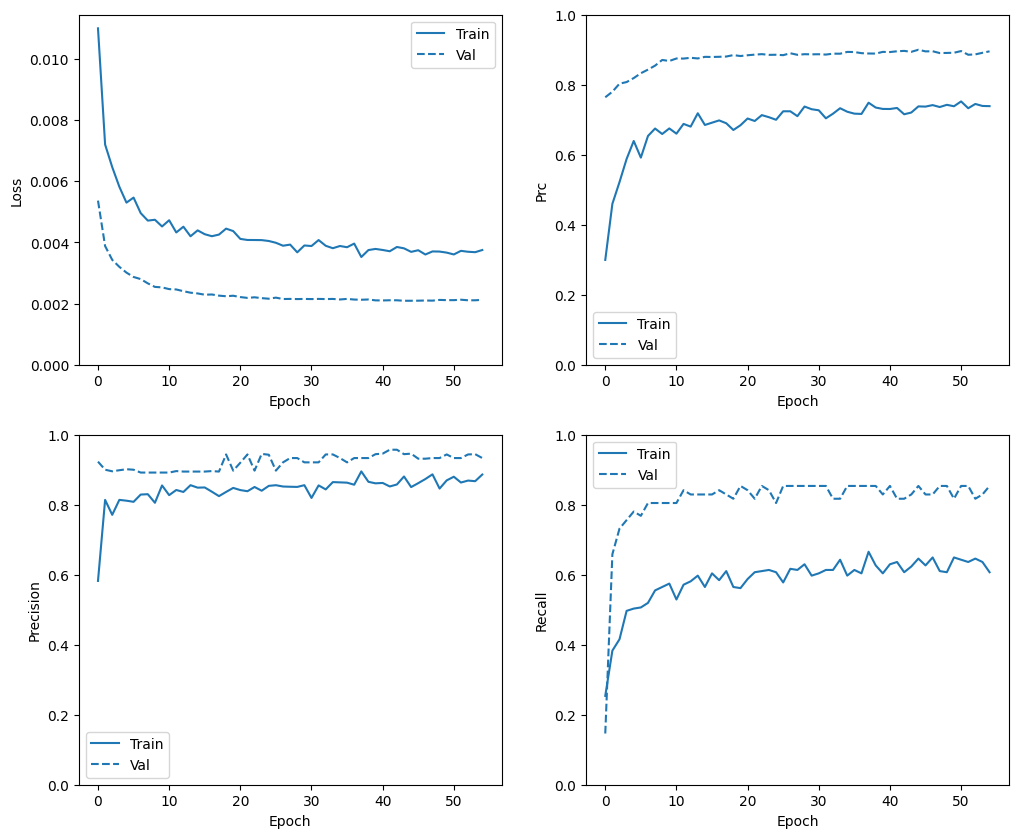

In [27]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [28]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [29]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.002663512947037816
compile_metrics :  0.002663512947037816

Legitimate Transactions Detected (True Negatives):  56854
Legitimate Transactions Incorrectly Detected (False Positives):  6
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  102


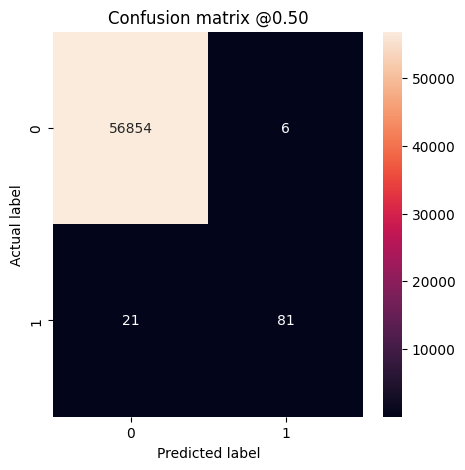

In [30]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly (impossible with true randomness), this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case, the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged.

### Changing the threshold

The default threshold of $t=50\%$ corresponds to equal costs of false negatives and false positives.
In the case of fraud detection, however, you would likely associate higher costs to false negatives than to false positives.
This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

By decreasing the threshold, we attribute higher cost to false negatives, thereby increasing missed transactions at the price of more false positives.
We test thresholds at 10% and at 1%.

Legitimate Transactions Detected (True Negatives):  56848
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  102
Legitimate Transactions Detected (True Negatives):  56789
Legitimate Transactions Incorrectly Detected (False Positives):  71
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  102


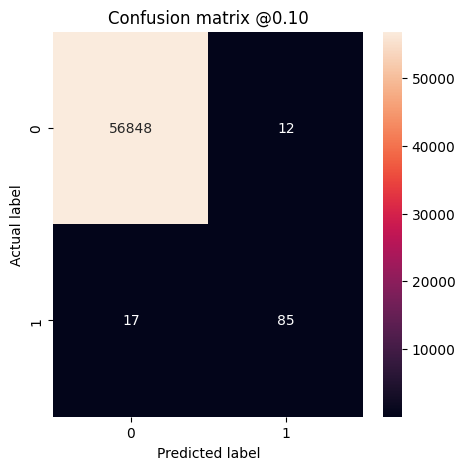

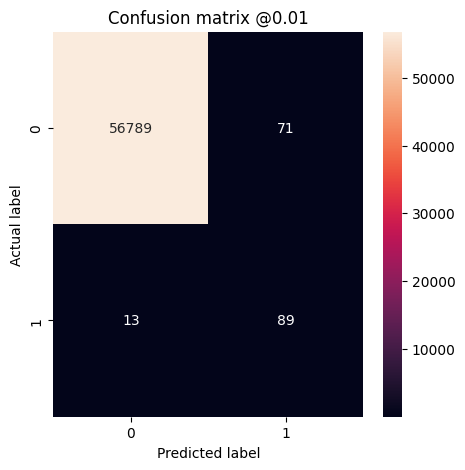

In [31]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach by tuning the output threshold over its full range (0 to 1). So each point corresponds to a single value of the threshold.

In [32]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

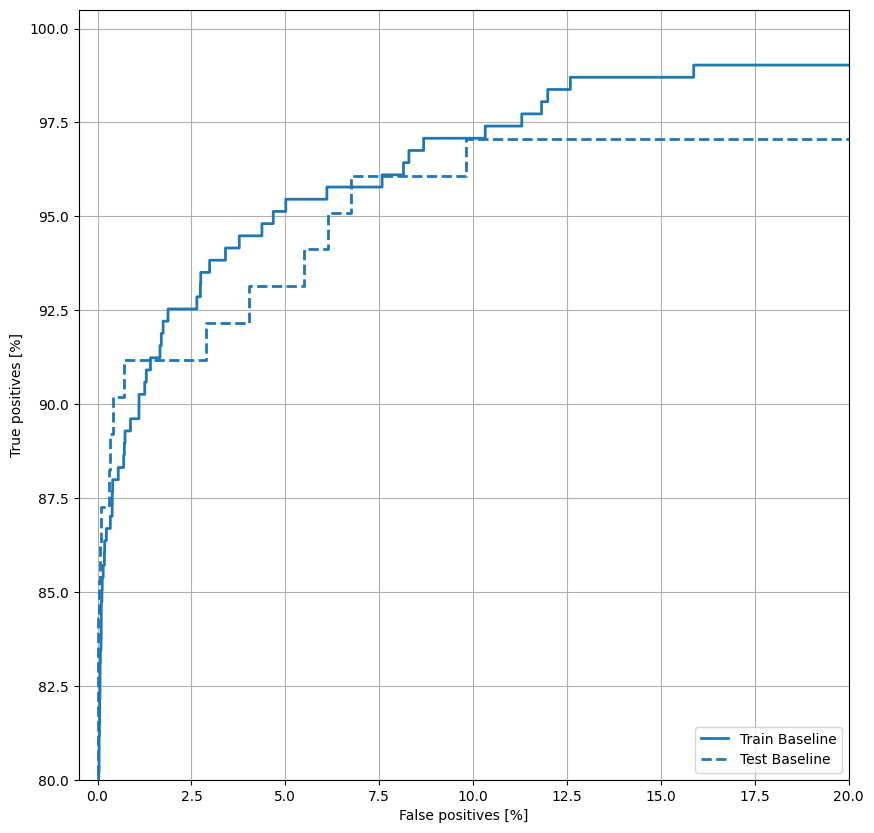

In [33]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the PRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [34]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

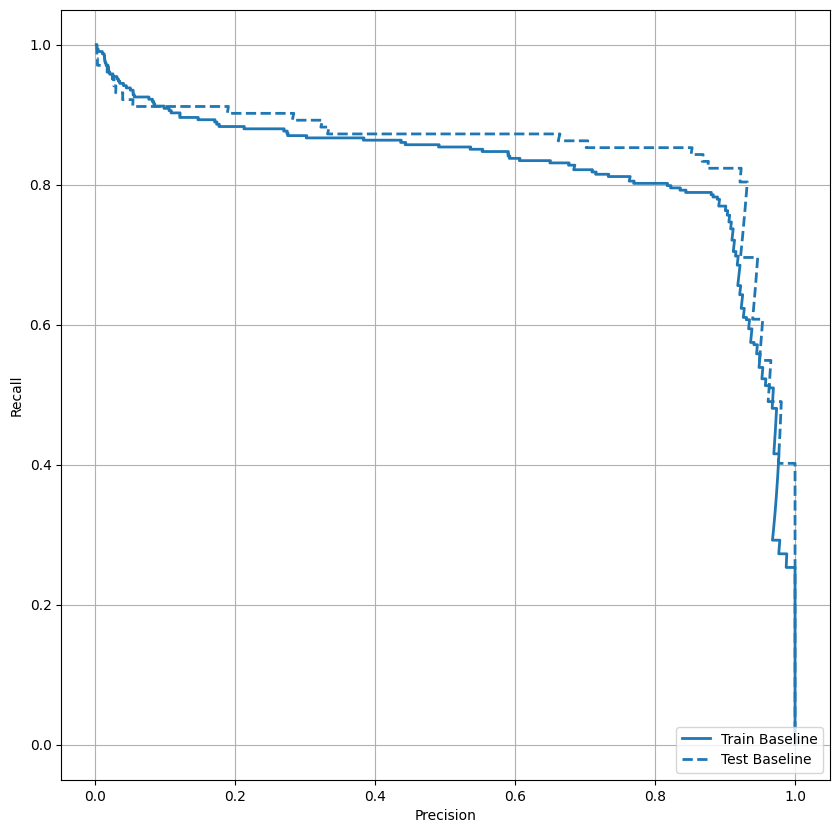

In [35]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class. Note, however, that this does not increase in any way the amount of information of your dataset. In the end, using class weights is more or less equivalent to changing the output bias or to changing the threshold. Let's see how it works out.

In [36]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [37]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/90 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - Brier score: 4.8176e-04 - accuracy: 0.9995 - auc: 0.9415 - cross entropy: 0.0029 - fn: 23.0000 - fp: 7.0000 - loss: 1.5095 - prc: 0.8239 - precision: 0.9205 - recall: 0.7788 - tn: 58899.0000 - tp: 81.0000

23/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 9.4502e-04 - accuracy: 0.9990 - auc: 0.8820 - cross entropy: 0.0060 - fn: 60.4783 - fp: 27.9565 - loss: 2.2363 - prc: 0.6085 - precision: 0.7546 - recall: 0.5922 - tn: 81367.9141 - tp: 81.6522

46/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0012 - accuracy: 0.9987 - auc: 0.8544 - cross entropy: 0.0076 - fn: 96.3696 - fp: 53.5652 - loss: 2.2360 - prc: 0.4991 - precision: 0.6450 - recall: 0.4987 - tn: 104854.6484 - tp: 85.4130   

71/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0014 - accuracy: 0.9985 - auc: 0.8427 - cross entropy: 0.0087 - fn: 131.7324 - fp: 85.3803 - loss: 2.1665 - prc: 0.4314 - precision: 0.5737 - recall: 0.4516 - tn: 130377.8438 - tp: 95.0423

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0015 - accuracy: 0.9983 - auc: 0.8392 - cross entropy: 0.0094 - fn: 155.4556 - fp: 116.7444 - loss: 2.0937 - prc: 0.3955 - precision: 0.5307 - recall: 0.4320 - tn: 149747.2500 - tp: 103.8333

90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - Brier score: 0.0015 - accuracy: 0.9983 - auc: 0.8391 - cross entropy: 0.0094 - fn: 156.5934 - fp: 118.4505 - loss: 2.0900 - prc: 0.3940 - precision: 0.5288 - recall: 0.4313 - tn: 150723.1719 - tp: 104.3516 - val_Brier score: 6.9626e-04 - val_accuracy: 0.9993 - val_auc: 0.9530 - val_cross entropy: 0.0072 - val_fn: 25.0000 - val_fp: 8.0000 - val_loss: 0.0072 - val_prc: 0.7354 - val_precision: 0.8769 - val_recall: 0.6951 - val_tn: 45479.0000 - val_tp: 57.0000


Epoch 2/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - Brier score: 0.0049 - accuracy: 0.9946 - auc: 0.7400 - cross entropy: 0.0260 - fn: 4.0000 - fp: 7.0000 - loss: 2.9107 - prc: 0.2079 - precision: 0.2222 - recall: 0.3333 - tn: 2035.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0033 - accuracy: 0.9963 - auc: 0.8914 - cross entropy: 0.0189 - fn: 27.8800 - fp: 65.8800 - loss: 1.3344 - prc: 0.3205 - precision: 0.2963 - recall: 0.4811 - tn: 26501.4805 - tp: 28.7600

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0033 - accuracy: 0.9964 - auc: 0.8921 - cross entropy: 0.0191 - fn: 49.8200 - fp: 138.5000 - loss: 1.2122 - prc: 0.3214 - precision: 0.2832 - recall: 0.4993 - tn: 51982.7812 - tp: 52.9000

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0034 - accuracy: 0.9963 - auc: 0.8910 - cross entropy: 0.0194 - fn: 67.9605 - fp: 225.6711 - loss: 1.1202 - prc: 0.3229 - precision: 0.2700 - recall: 0.5171 - tn: 78475.9844 - tp: 78.3816

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0034 - accuracy: 0.9963 - auc: 0.8909 - cross entropy: 0.0196 - fn: 77.0110 - fp: 278.7912 - loss: 1.0765 - prc: 0.3266 - precision: 0.2644 - recall: 0.5273 - tn: 93691.4688 - tp: 93.2967 - val_Brier score: 9.0370e-04 - val_accuracy: 0.9992 - val_auc: 0.9600 - val_cross entropy: 0.0106 - val_fn: 13.0000 - val_fp: 23.0000 - val_loss: 0.0106 - val_prc: 0.7694 - val_precision: 0.7500 - val_recall: 0.8415 - val_tn: 45464.0000 - val_tp: 69.0000


Epoch 3/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0034 - accuracy: 0.9971 - auc: 0.9997 - cross entropy: 0.0202 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0218 - prc: 0.6819 - precision: 0.3333 - recall: 1.0000 - tn: 2039.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0045 - accuracy: 0.9952 - auc: 0.9069 - cross entropy: 0.0250 - fn: 16.5600 - fp: 118.1600 - loss: 0.6688 - prc: 0.3881 - precision: 0.1880 - recall: 0.6329 - tn: 26464.9199 - tp: 24.3600

49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0048 - accuracy: 0.9948 - auc: 0.8999 - cross entropy: 0.0263 - fn: 33.6327 - fp: 247.6939 - loss: 0.7407 - prc: 0.3902 - precision: 0.1846 - recall: 0.6269 - tn: 50865.1016 - tp: 53.5714

74/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0050 - accuracy: 0.9945 - auc: 0.9013 - cross entropy: 0.0273 - fn: 48.2432 - fp: 397.2162 - loss: 0.7345 - prc: 0.3962 - precision: 0.1818 - recall: 0.6366 - tn: 76269.3516 - tp: 85.1892

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0052 - accuracy: 0.9943 - auc: 0.9018 - cross entropy: 0.0280 - fn: 56.4945 - fp: 508.4615 - loss: 0.7222 - prc: 0.3978 - precision: 0.1789 - recall: 0.6450 - tn: 93469.3984 - tp: 106.2198 - val_Brier score: 0.0016 - val_accuracy: 0.9987 - val_auc: 0.9681 - val_cross entropy: 0.0158 - val_fn: 11.0000 - val_fp: 49.0000 - val_loss: 0.0158 - val_prc: 0.7802 - val_precision: 0.5917 - val_recall: 0.8659 - val_tn: 45438.0000 - val_tp: 71.0000


Epoch 4/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - Brier score: 0.0085 - accuracy: 0.9912 - auc: 0.6689 - cross entropy: 0.0424 - fn: 3.0000 - fp: 15.0000 - loss: 2.0722 - prc: 0.1273 - precision: 0.0625 - recall: 0.2500 - tn: 2029.0000 - tp: 1.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0079 - accuracy: 0.9913 - auc: 0.8713 - cross entropy: 0.0397 - fn: 13.6154 - fp: 227.8462 - loss: 0.6866 - prc: 0.3892 - precision: 0.1043 - recall: 0.6371 - tn: 27379.6914 - tp: 26.8462

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0080 - accuracy: 0.9911 - auc: 0.8882 - cross entropy: 0.0402 - fn: 26.9412 - fp: 456.1961 - loss: 0.6336 - prc: 0.3857 - precision: 0.1077 - recall: 0.6588 - tn: 52708.6484 - tp: 56.2157

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0081 - accuracy: 0.9908 - auc: 0.8950 - cross entropy: 0.0408 - fn: 40.5195 - fp: 710.8961 - loss: 0.6246 - prc: 0.3944 - precision: 0.1111 - recall: 0.6743 - tn: 79028.7109 - tp: 91.8701

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0082 - accuracy: 0.9907 - auc: 0.8985 - cross entropy: 0.0412 - fn: 46.3956 - fp: 854.7033 - loss: 0.6114 - prc: 0.3998 - precision: 0.1116 - recall: 0.6828 - tn: 93128.9766 - tp: 110.4945 - val_Brier score: 0.0025 - val_accuracy: 0.9979 - val_auc: 0.9732 - val_cross entropy: 0.0218 - val_fn: 10.0000 - val_fp: 86.0000 - val_loss: 0.0218 - val_prc: 0.7647 - val_precision: 0.4557 - val_recall: 0.8780 - val_tn: 45401.0000 - val_tp: 72.0000


Epoch 5/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 0.0128 - accuracy: 0.9844 - auc: 0.9453 - cross entropy: 0.0542 - fn: 2.0000 - fp: 30.0000 - loss: 1.0314 - prc: 0.7055 - precision: 0.1429 - recall: 0.7143 - tn: 2011.0000 - tp: 5.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0110 - accuracy: 0.9872 - auc: 0.8851 - cross entropy: 0.0512 - fn: 18.6538 - fp: 337.9231 - loss: 0.8869 - prc: 0.5076 - precision: 0.1168 - recall: 0.6958 - tn: 27249.0000 - tp: 42.4231

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0113 - accuracy: 0.9868 - auc: 0.8933 - cross entropy: 0.0523 - fn: 32.3922 - fp: 688.2941 - loss: 0.7917 - prc: 0.4746 - precision: 0.1062 - recall: 0.6978 - tn: 52452.0977 - tp: 75.2157

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0116 - accuracy: 0.9864 - auc: 0.9012 - cross entropy: 0.0537 - fn: 42.0263 - fp: 1062.8158 - loss: 0.7068 - prc: 0.4476 - precision: 0.0985 - recall: 0.7073 - tn: 77638.3828 - tp: 104.7763

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0118 - accuracy: 0.9862 - auc: 0.9054 - cross entropy: 0.0546 - fn: 46.5934 - fp: 1299.8242 - loss: 0.6663 - prc: 0.4400 - precision: 0.0955 - recall: 0.7156 - tn: 92670.6953 - tp: 123.4615 - val_Brier score: 0.0040 - val_accuracy: 0.9962 - val_auc: 0.9780 - val_cross entropy: 0.0291 - val_fn: 10.0000 - val_fp: 161.0000 - val_loss: 0.0291 - val_prc: 0.7608 - val_precision: 0.3090 - val_recall: 0.8780 - val_tn: 45326.0000 - val_tp: 72.0000


Epoch 6/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0153 - accuracy: 0.9824 - auc: 0.9886 - cross entropy: 0.0677 - fn: 1.0000 - fp: 35.0000 - loss: 0.2406 - prc: 0.4593 - precision: 0.0789 - recall: 0.7500 - tn: 2009.0000 - tp: 3.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0145 - accuracy: 0.9830 - auc: 0.9396 - cross entropy: 0.0664 - fn: 10.3077 - fp: 469.1538 - loss: 0.3735 - prc: 0.4237 - precision: 0.0732 - recall: 0.7957 - tn: 27130.7305 - tp: 37.8077

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0148 - accuracy: 0.9826 - auc: 0.9319 - cross entropy: 0.0674 - fn: 20.1731 - fp: 943.4423 - loss: 0.4088 - prc: 0.4155 - precision: 0.0727 - recall: 0.7897 - tn: 53234.8086 - tp: 73.5769

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0151 - accuracy: 0.9822 - auc: 0.9298 - cross entropy: 0.0683 - fn: 28.7051 - fp: 1441.4359 - loss: 0.4091 - prc: 0.4066 - precision: 0.0700 - recall: 0.7885 - tn: 79320.6562 - tp: 105.2051

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0152 - accuracy: 0.9821 - auc: 0.9291 - cross entropy: 0.0687 - fn: 33.1978 - fp: 1695.3627 - loss: 0.4118 - prc: 0.4045 - precision: 0.0694 - recall: 0.7888 - tn: 92289.2891 - tp: 122.7253 - val_Brier score: 0.0054 - val_accuracy: 0.9945 - val_auc: 0.9816 - val_cross entropy: 0.0356 - val_fn: 9.0000 - val_fp: 243.0000 - val_loss: 0.0356 - val_prc: 0.7555 - val_precision: 0.2310 - val_recall: 0.8902 - val_tn: 45244.0000 - val_tp: 73.0000


Epoch 7/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0185 - accuracy: 0.9766 - auc: 0.9472 - cross entropy: 0.0735 - fn: 1.0000 - fp: 47.0000 - loss: 0.6100 - prc: 0.5083 - precision: 0.0962 - recall: 0.8333 - tn: 1995.0000 - tp: 5.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0178 - accuracy: 0.9786 - auc: 0.9611 - cross entropy: 0.0777 - fn: 8.0769 - fp: 582.1923 - loss: 0.3827 - prc: 0.4854 - precision: 0.0874 - recall: 0.8662 - tn: 27005.5000 - tp: 52.2308

52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0183 - accuracy: 0.9780 - auc: 0.9563 - cross entropy: 0.0797 - fn: 15.9038 - fp: 1197.8846 - loss: 0.3620 - prc: 0.4344 - precision: 0.0749 - recall: 0.8524 - tn: 52972.3828 - tp: 85.8269

78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0186 - accuracy: 0.9775 - auc: 0.9515 - cross entropy: 0.0810 - fn: 24.1410 - fp: 1838.6025 - loss: 0.3647 - prc: 0.4082 - precision: 0.0687 - recall: 0.8417 - tn: 78914.1797 - tp: 119.0769

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0187 - accuracy: 0.9773 - auc: 0.9501 - cross entropy: 0.0816 - fn: 28.1758 - fp: 2161.0769 - loss: 0.3649 - prc: 0.4001 - precision: 0.0667 - recall: 0.8385 - tn: 91815.3203 - tp: 136.0000 - val_Brier score: 0.0073 - val_accuracy: 0.9918 - val_auc: 0.9819 - val_cross entropy: 0.0436 - val_fn: 8.0000 - val_fp: 366.0000 - val_loss: 0.0436 - val_prc: 0.6999 - val_precision: 0.1682 - val_recall: 0.9024 - val_tn: 45121.0000 - val_tp: 74.0000


Epoch 8/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0192 - accuracy: 0.9756 - auc: 0.9982 - cross entropy: 0.0893 - fn: 0.0000e+00 - fp: 50.0000 - loss: 0.0488 - prc: 0.3458 - precision: 0.0566 - recall: 1.0000 - tn: 1995.0000 - tp: 3.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0217 - accuracy: 0.9733 - auc: 0.9457 - cross entropy: 0.0941 - fn: 10.2400 - fp: 711.0800 - loss: 0.3433 - prc: 0.2986 - precision: 0.0457 - recall: 0.7746 - tn: 25870.6797 - tp: 32.0000 

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0223 - accuracy: 0.9725 - auc: 0.9500 - cross entropy: 0.0961 - fn: 18.1800 - fp: 1443.5800 - loss: 0.3386 - prc: 0.3025 - precision: 0.0454 - recall: 0.7858 - tn: 50694.1406 - tp: 68.1000

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0228 - accuracy: 0.9720 - auc: 0.9513 - cross entropy: 0.0976 - fn: 25.8553 - fp: 2231.9211 - loss: 0.3350 - prc: 0.3089 - precision: 0.0457 - recall: 0.7963 - tn: 76483.5938 - tp: 106.6316

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0230 - accuracy: 0.9717 - auc: 0.9505 - cross entropy: 0.0985 - fn: 30.5714 - fp: 2692.1978 - loss: 0.3364 - prc: 0.3086 - precision: 0.0454 - recall: 0.7986 - tn: 91290.4062 - tp: 127.3956 - val_Brier score: 0.0100 - val_accuracy: 0.9885 - val_auc: 0.9839 - val_cross entropy: 0.0538 - val_fn: 5.0000 - val_fp: 517.0000 - val_loss: 0.0538 - val_prc: 0.6362 - val_precision: 0.1296 - val_recall: 0.9390 - val_tn: 44970.0000 - val_tp: 77.0000


Epoch 9/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - Brier score: 0.0308 - accuracy: 0.9624 - auc: 0.7143 - cross entropy: 0.1212 - fn: 1.0000 - fp: 76.0000 - loss: 0.9833 - prc: 0.1025 - precision: 0.0256 - recall: 0.6667 - tn: 1969.0000 - tp: 2.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0275 - accuracy: 0.9659 - auc: 0.8561 - cross entropy: 0.1138 - fn: 9.0000 - fp: 936.6154 - loss: 0.5649 - prc: 0.2057 - precision: 0.0327 - recall: 0.7563 - tn: 26668.4609 - tp: 33.9231

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0273 - accuracy: 0.9660 - auc: 0.8907 - cross entropy: 0.1137 - fn: 15.8627 - fp: 1791.0000 - loss: 0.4747 - prc: 0.2438 - precision: 0.0362 - recall: 0.7906 - tn: 51369.2930 - tp: 71.8431

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0272 - accuracy: 0.9662 - auc: 0.9074 - cross entropy: 0.1137 - fn: 21.0519 - fp: 2667.7144 - loss: 0.4235 - prc: 0.2648 - precision: 0.0381 - recall: 0.8141 - tn: 77070.5078 - tp: 112.7273

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0271 - accuracy: 0.9663 - auc: 0.9128 - cross entropy: 0.1138 - fn: 24.7473 - fp: 3137.8132 - loss: 0.4094 - prc: 0.2688 - precision: 0.0387 - recall: 0.8191 - tn: 90844.3438 - tp: 133.6703 - val_Brier score: 0.0114 - val_accuracy: 0.9865 - val_auc: 0.9853 - val_cross entropy: 0.0596 - val_fn: 5.0000 - val_fp: 609.0000 - val_loss: 0.0596 - val_prc: 0.6135 - val_precision: 0.1122 - val_recall: 0.9390 - val_tn: 44878.0000 - val_tp: 77.0000


Epoch 10/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0274 - accuracy: 0.9673 - auc: 0.9987 - cross entropy: 0.1102 - fn: 0.0000e+00 - fp: 67.0000 - loss: 0.0559 - prc: 0.2606 - precision: 0.0290 - recall: 1.0000 - tn: 1979.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0286 - accuracy: 0.9647 - auc: 0.9891 - cross entropy: 0.1200 - fn: 5.1600 - fp: 937.9600 - loss: 0.1486 - prc: 0.3244 - precision: 0.0456 - recall: 0.9016 - tn: 25637.6406 - tp: 43.2400  

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0286 - accuracy: 0.9646 - auc: 0.9788 - cross entropy: 0.1207 - fn: 11.4400 - fp: 1845.4600 - loss: 0.1910 - prc: 0.3107 - precision: 0.0433 - recall: 0.8863 - tn: 50286.9414 - tp: 80.1600

76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0288 - accuracy: 0.9644 - auc: 0.9725 - cross entropy: 0.1214 - fn: 19.6053 - fp: 2802.9080 - loss: 0.2205 - prc: 0.3005 - precision: 0.0419 - recall: 0.8716 - tn: 75907.8672 - tp: 117.6184

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0289 - accuracy: 0.9642 - auc: 0.9704 - cross entropy: 0.1220 - fn: 24.0220 - fp: 3374.6594 - loss: 0.2304 - prc: 0.2944 - precision: 0.0412 - recall: 0.8665 - tn: 90603.2422 - tp: 138.6483 - val_Brier score: 0.0141 - val_accuracy: 0.9837 - val_auc: 0.9858 - val_cross entropy: 0.0697 - val_fn: 5.0000 - val_fp: 739.0000 - val_loss: 0.0697 - val_prc: 0.5984 - val_precision: 0.0944 - val_recall: 0.9390 - val_tn: 44748.0000 - val_tp: 77.0000


Epoch 11/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - Brier score: 0.0360 - accuracy: 0.9580 - auc: 0.9853 - cross entropy: 0.1456 - fn: 0.0000e+00 - fp: 86.0000 - loss: 0.0851 - prc: 0.0163 - precision: 0.0115 - recall: 1.0000 - tn: 1961.0000 - tp: 1.0000

24/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0338 - accuracy: 0.9592 - auc: 0.9645 - cross entropy: 0.1434 - fn: 5.9583 - fp: 1025.7500 - loss: 0.2547 - prc: 0.2007 - precision: 0.0332 - recall: 0.8934 - tn: 24529.9590 - tp: 38.3333 

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0331 - accuracy: 0.9599 - auc: 0.9594 - cross entropy: 0.1403 - fn: 11.5957 - fp: 1935.5106 - loss: 0.2681 - prc: 0.2203 - precision: 0.0343 - recall: 0.8767 - tn: 47133.2539 - tp: 71.6383

70/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0329 - accuracy: 0.9601 - auc: 0.9572 - cross entropy: 0.1395 - fn: 17.2143 - fp: 2863.3428 - loss: 0.2753 - prc: 0.2272 - precision: 0.0348 - recall: 0.8714 - tn: 69717.2031 - tp: 106.2429

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0328 - accuracy: 0.9600 - auc: 0.9554 - cross entropy: 0.1394 - fn: 23.0989 - fp: 3730.7913 - loss: 0.2830 - prc: 0.2281 - precision: 0.0347 - recall: 0.8658 - tn: 90250.4062 - tp: 136.2747 - val_Brier score: 0.0158 - val_accuracy: 0.9821 - val_auc: 0.9870 - val_cross entropy: 0.0765 - val_fn: 5.0000 - val_fp: 809.0000 - val_loss: 0.0765 - val_prc: 0.5793 - val_precision: 0.0869 - val_recall: 0.9390 - val_tn: 44678.0000 - val_tp: 77.0000


Epoch 12/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Brier score: 0.0344 - accuracy: 0.9565 - auc: 0.9435 - cross entropy: 0.1376 - fn: 3.0000 - fp: 86.0000 - loss: 0.9305 - prc: 0.2908 - precision: 0.0652 - recall: 0.6667 - tn: 1953.0000 - tp: 6.0000

26/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0338 - accuracy: 0.9575 - auc: 0.9487 - cross entropy: 0.1381 - fn: 8.5769 - fp: 1164.9615 - loss: 0.3849 - prc: 0.2529 - precision: 0.0385 - recall: 0.8158 - tn: 26432.4238 - tp: 42.0385

51/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0345 - accuracy: 0.9569 - auc: 0.9479 - cross entropy: 0.1435 - fn: 15.3333 - fp: 2299.3333 - loss: 0.3537 - prc: 0.2374 - precision: 0.0355 - recall: 0.8274 - tn: 50855.0195 - tp: 78.3137

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0348 - accuracy: 0.9565 - auc: 0.9480 - cross entropy: 0.1453 - fn: 22.1818 - fp: 3477.0000 - loss: 0.3395 - prc: 0.2345 - precision: 0.0343 - recall: 0.8328 - tn: 76256.0625 - tp: 116.7533

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0348 - accuracy: 0.9565 - auc: 0.9489 - cross entropy: 0.1457 - fn: 25.3846 - fp: 4104.4395 - loss: 0.3314 - prc: 0.2346 - precision: 0.0340 - recall: 0.8358 - tn: 89873.6172 - tp: 137.1319 - val_Brier score: 0.0170 - val_accuracy: 0.9804 - val_auc: 0.9875 - val_cross entropy: 0.0810 - val_fn: 5.0000 - val_fp: 888.0000 - val_loss: 0.0810 - val_prc: 0.5611 - val_precision: 0.0798 - val_recall: 0.9390 - val_tn: 44599.0000 - val_tp: 77.0000


Epoch 13/100


 1/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - Brier score: 0.0387 - accuracy: 0.9536 - auc: 0.9988 - cross entropy: 0.1505 - fn: 0.0000e+00 - fp: 95.0000 - loss: 0.0754 - prc: 0.2857 - precision: 0.0206 - recall: 1.0000 - tn: 1951.0000 - tp: 2.0000

25/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0341 - accuracy: 0.9576 - auc: 0.9640 - cross entropy: 0.1439 - fn: 3.7200 - fp: 1120.7200 - loss: 0.2125 - prc: 0.2716 - precision: 0.0311 - recall: 0.9142 - tn: 25461.5195 - tp: 38.0400 

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0341 - accuracy: 0.9578 - auc: 0.9675 - cross entropy: 0.1439 - fn: 7.8400 - fp: 2189.5000 - loss: 0.2122 - prc: 0.2669 - precision: 0.0334 - recall: 0.9120 - tn: 49947.2812 - tp: 79.3800

77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Brier score: 0.0341 - accuracy: 0.9579 - auc: 0.9685 - cross entropy: 0.1439 - fn: 13.8701 - fp: 3341.4805 - loss: 0.2150 - prc: 0.2599 - precision: 0.0338 - recall: 0.9032 - tn: 76396.7812 - tp: 119.8701

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0341 - accuracy: 0.9579 - auc: 0.9679 - cross entropy: 0.1440 - fn: 17.4615 - fp: 3938.6704 - loss: 0.2195 - prc: 0.2564 - precision: 0.0337 - recall: 0.8983 - tn: 90044.4609 - tp: 139.9780 - val_Brier score: 0.0166 - val_accuracy: 0.9808 - val_auc: 0.9879 - val_cross entropy: 0.0798 - val_fn: 5.0000 - val_fp: 868.0000 - val_loss: 0.0798 - val_prc: 0.5770 - val_precision: 0.0815 - val_recall: 0.9390 - val_tn: 44619.0000 - val_tp: 77.0000


Epoch 13: early stopping


Restoring model weights from the end of the best epoch: 3.


### Check training history

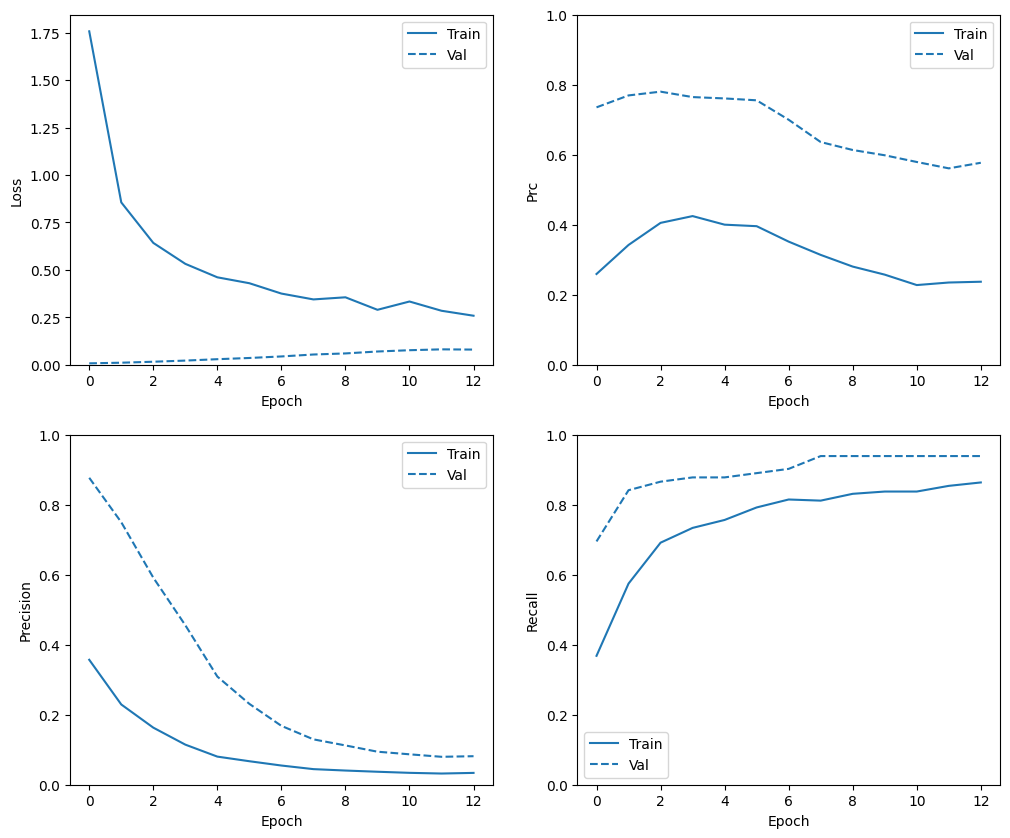

In [38]:
plot_metrics(weighted_history)

### Evaluate metrics

In [39]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step

47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


loss :  0.014986301772296429
compile_metrics :  0.014986301772296429

Legitimate Transactions Detected (True Negatives):  56817
Legitimate Transactions Incorrectly Detected (False Positives):  43
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  102


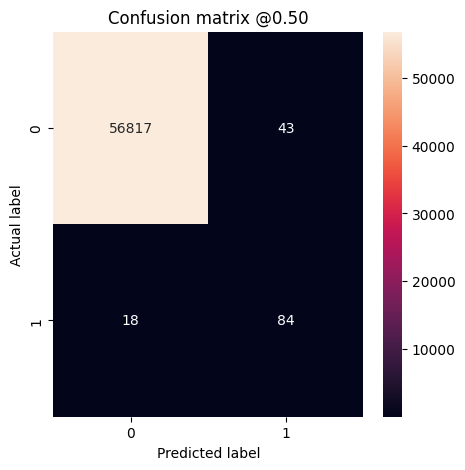

In [40]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions than the baseline model at threshold 50%). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

Compared to the baseline model with changed threshold, the class weighted model is clearly inferior. The superiority of the baseline model is further confirmed by the lower test loss value (cross entropy and mean squared error) and additionally can be seen by plotting the ROC curves of both models together.

### Plot the ROC

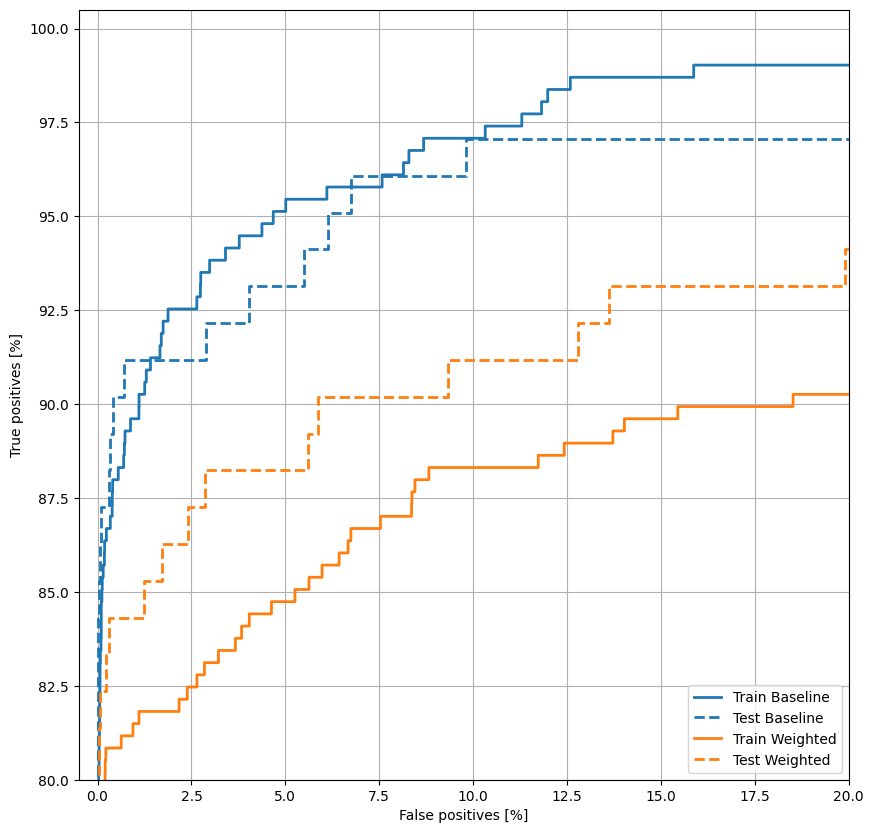

In [41]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the PRC

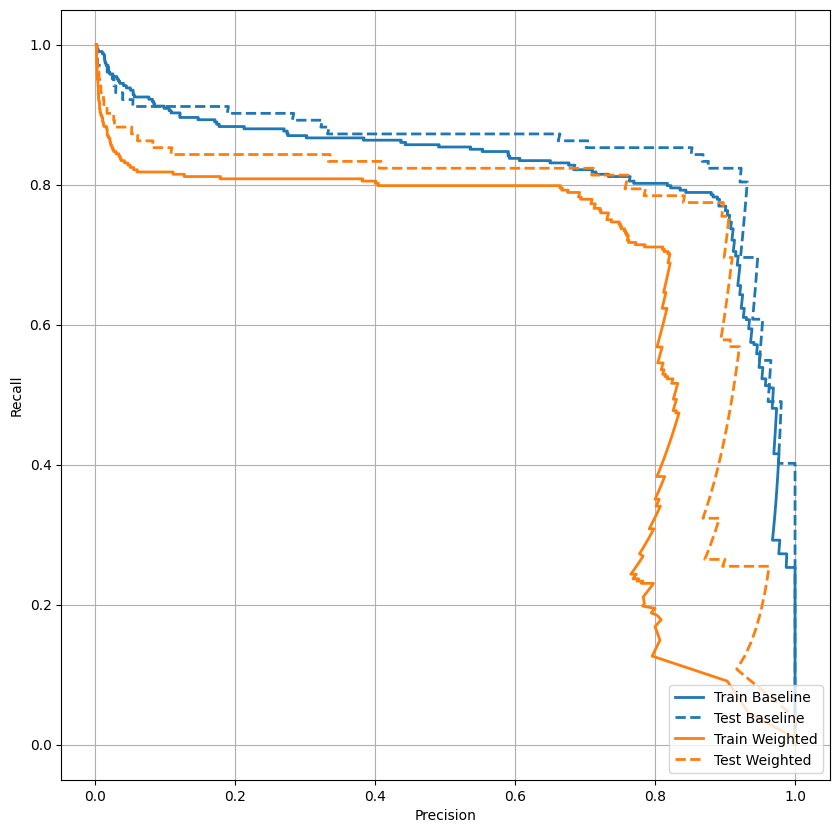

In [42]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [43]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random
indices from the positive examples:

In [44]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181968, 29)

In [45]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363936, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [46]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [47]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-5.          5.         -5.          5.         -5.         -1.79067376
 -5.          0.8091474  -5.         -5.          5.         -5.
  0.77844233 -5.         -0.38533935 -5.         -5.         -5.
  0.8008565   1.2865953  -3.24913168  1.43279414  1.794716   -1.72782919
 -0.20834708  1.3608197   5.         -4.32439607 -1.45407944]

Label:  [1]


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [48]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [49]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.509765625


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [50]:
resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch

278

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping()],
    validation_data=val_ds)

Epoch 1/100


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/278 ━━━━━━━━━━━━━━━━━━━━ 18:23 4s/step - Brier score: 0.0114 - accuracy: 0.9830 - auc: 0.9832 - cross entropy: 0.0438 - fn: 387.0000 - fp: 619.0000 - loss: 0.8446 - prc: 0.6497 - precision: 0.5465 - recall: 0.6584 - tn: 57258.0000 - tp: 746.0000

  6/278 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Brier score: 0.0314 - accuracy: 0.9510 - auc: 0.9708 - cross entropy: 0.1010 - fn: 1238.1666 - fp: 1974.6666 - loss: 0.8129 - prc: 0.6686 - precision: 0.5477 - recall: 0.6595 - tn: 58505.1680 - tp: 2412.0000

  9/278 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - Brier score: 0.0410 - accuracy: 0.9357 - auc: 0.9641 - cross entropy: 0.1282 - fn: 1694.3334 - fp: 2773.6667 - loss: 0.7977 - prc: 0.6802 - precision: 0.5521 - recall: 0.6668 - tn: 59262.7773 - tp: 3471.2222

 12/278 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - Brier score: 0.0494 - accuracy: 0.9223 - auc: 0.9580 - cross entropy: 0.1517 - fn: 2124.3333 - fp: 3569.1667 - loss: 0.7851 - prc: 0.6898 - precision: 0.5558 - recall: 0.6739 - tn: 60027.0820 - tp: 4553.4165

 15/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0566 - accuracy: 0.9106 - auc: 0.9525 - cross entropy: 0.1723 - fn: 2535.9333 - fp: 4354.3335 - loss: 0.7743 - prc: 0.6981 - precision: 0.5595 - recall: 0.6806 - tn: 60790.3320 - tp: 5665.3999

 18/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0630 - accuracy: 0.9003 - auc: 0.9477 - cross entropy: 0.1903 - fn: 2921.9443 - fp: 5134.0557 - loss: 0.7645 - prc: 0.7057 - precision: 0.5630 - recall: 0.6872 - tn: 61556.7773 - tp: 6805.2222

 21/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0687 - accuracy: 0.8912 - auc: 0.9433 - cross entropy: 0.2063 - fn: 3287.7620 - fp: 5908.2856 - loss: 0.7555 - prc: 0.7127 - precision: 0.5662 - recall: 0.6935 - tn: 62331.8086 - tp: 7962.1431

 24/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0737 - accuracy: 0.8830 - auc: 0.9395 - cross entropy: 0.2204 - fn: 3636.7917 - fp: 6672.7085 - loss: 0.7470 - prc: 0.7195 - precision: 0.5694 - recall: 0.6994 - tn: 63108.8320 - tp: 9143.6670

 27/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0781 - accuracy: 0.8757 - auc: 0.9362 - cross entropy: 0.2330 - fn: 3970.1853 - fp: 7428.5928 - loss: 0.7389 - prc: 0.7258 - precision: 0.5725 - recall: 0.7051 - tn: 63887.8906 - tp: 10347.3330

 30/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0821 - accuracy: 0.8692 - auc: 0.9331 - cross entropy: 0.2442 - fn: 4290.2998 - fp: 8171.1333 - loss: 0.7314 - prc: 0.7317 - precision: 0.5755 - recall: 0.7104 - tn: 64679.8008 - tp: 11564.7666

 33/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0857 - accuracy: 0.8634 - auc: 0.9304 - cross entropy: 0.2544 - fn: 4597.8486 - fp: 8905.6973 - loss: 0.7242 - prc: 0.7373 - precision: 0.5783 - recall: 0.7155 - tn: 65480.7266 - tp: 12793.7275

 36/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0890 - accuracy: 0.8581 - auc: 0.9279 - cross entropy: 0.2637 - fn: 4891.3335 - fp: 9632.4443 - loss: 0.7175 - prc: 0.7425 - precision: 0.5810 - recall: 0.7203 - tn: 66290.0859 - tp: 14036.1387

 39/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0920 - accuracy: 0.8533 - auc: 0.9257 - cross entropy: 0.2721 - fn: 5173.6411 - fp: 10350.4619 - loss: 0.7111 - prc: 0.7474 - precision: 0.5836 - recall: 0.7248 - tn: 67111.7188 - tp: 15286.1797

 42/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0947 - accuracy: 0.8489 - auc: 0.9237 - cross entropy: 0.2797 - fn: 5449.9521 - fp: 11057.8096 - loss: 0.7051 - prc: 0.7521 - precision: 0.5862 - recall: 0.7291 - tn: 67942.8594 - tp: 16543.3809

 45/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0972 - accuracy: 0.8450 - auc: 0.9219 - cross entropy: 0.2867 - fn: 5717.6445 - fp: 11753.1777 - loss: 0.6993 - prc: 0.7565 - precision: 0.5886 - recall: 0.7331 - tn: 68787.0703 - tp: 17808.1113

 48/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0994 - accuracy: 0.8414 - auc: 0.9203 - cross entropy: 0.2931 - fn: 5976.9375 - fp: 12437.7705 - loss: 0.6938 - prc: 0.7607 - precision: 0.5910 - recall: 0.7370 - tn: 69643.0234 - tp: 19080.2715

 51/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.1015 - accuracy: 0.8381 - auc: 0.9188 - cross entropy: 0.2990 - fn: 6229.6860 - fp: 13112.8828 - loss: 0.6885 - prc: 0.7646 - precision: 0.5933 - recall: 0.7406 - tn: 70509.7656 - tp: 20357.6660

 54/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.1034 - accuracy: 0.8351 - auc: 0.9175 - cross entropy: 0.3045 - fn: 6477.6479 - fp: 13778.5186 - loss: 0.6835 - prc: 0.7684 - precision: 0.5956 - recall: 0.7440 - tn: 71385.4297 - tp: 21640.4082

 57/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.1052 - accuracy: 0.8323 - auc: 0.9163 - cross entropy: 0.3095 - fn: 6720.0703 - fp: 14432.9473 - loss: 0.6787 - prc: 0.7720 - precision: 0.5978 - recall: 0.7473 - tn: 72271.8594 - tp: 22929.1230

 60/278 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Brier score: 0.1068 - accuracy: 0.8298 - auc: 0.9152 - cross entropy: 0.3142 - fn: 6960.0332 - fp: 15076.7002 - loss: 0.6740 - prc: 0.7754 - precision: 0.6000 - recall: 0.7504 - tn: 73166.9688 - tp: 24222.3008

 63/278 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Brier score: 0.1083 - accuracy: 0.8274 - auc: 0.9142 - cross entropy: 0.3185 - fn: 7197.8413 - fp: 15711.3652 - loss: 0.6695 - prc: 0.7787 - precision: 0.6021 - recall: 0.7533 - tn: 74070.9844 - tp: 25517.8086

 66/278 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Brier score: 0.1097 - accuracy: 0.8253 - auc: 0.9133 - cross entropy: 0.3225 - fn: 7433.5605 - fp: 16335.0459 - loss: 0.6652 - prc: 0.7818 - precision: 0.6041 - recall: 0.7560 - tn: 74984.3750 - tp: 26817.0156

 69/278 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Brier score: 0.1110 - accuracy: 0.8233 - auc: 0.9124 - cross entropy: 0.3262 - fn: 7667.2173 - fp: 16948.1016 - loss: 0.6610 - prc: 0.7848 - precision: 0.6062 - recall: 0.7586 - tn: 75908.5234 - tp: 28118.1602

 72/278 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Brier score: 0.1122 - accuracy: 0.8215 - auc: 0.9117 - cross entropy: 0.3297 - fn: 7898.5693 - fp: 17552.4590 - loss: 0.6570 - prc: 0.7876 - precision: 0.6082 - recall: 0.7611 - tn: 76841.5938 - tp: 29421.3750

 75/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1133 - accuracy: 0.8198 - auc: 0.9110 - cross entropy: 0.3329 - fn: 8128.2002 - fp: 18145.9863 - loss: 0.6530 - prc: 0.7904 - precision: 0.6101 - recall: 0.7635 - tn: 77785.1875 - tp: 30726.6270

 78/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1143 - accuracy: 0.8182 - auc: 0.9103 - cross entropy: 0.3359 - fn: 8355.2949 - fp: 18729.6289 - loss: 0.6492 - prc: 0.7930 - precision: 0.6120 - recall: 0.7657 - tn: 78738.2422 - tp: 32034.8340

 81/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1153 - accuracy: 0.8168 - auc: 0.9097 - cross entropy: 0.3387 - fn: 8580.0244 - fp: 19305.8398 - loss: 0.6455 - prc: 0.7956 - precision: 0.6139 - recall: 0.7679 - tn: 79700.7656 - tp: 33343.3711

 84/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1162 - accuracy: 0.8154 - auc: 0.9092 - cross entropy: 0.3413 - fn: 8803.5000 - fp: 19873.5957 - loss: 0.6419 - prc: 0.7980 - precision: 0.6158 - recall: 0.7699 - tn: 80669.8125 - tp: 34655.0938

 87/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1170 - accuracy: 0.8142 - auc: 0.9087 - cross entropy: 0.3438 - fn: 9026.4365 - fp: 20432.3906 - loss: 0.6384 - prc: 0.8004 - precision: 0.6176 - recall: 0.7719 - tn: 81644.9531 - tp: 35970.2188

 90/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1178 - accuracy: 0.8131 - auc: 0.9083 - cross entropy: 0.3460 - fn: 9248.1113 - fp: 20982.3008 - loss: 0.6350 - prc: 0.8027 - precision: 0.6194 - recall: 0.7737 - tn: 82629.1016 - tp: 37286.4883

 93/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1185 - accuracy: 0.8120 - auc: 0.9079 - cross entropy: 0.3482 - fn: 9468.8281 - fp: 21523.0000 - loss: 0.6317 - prc: 0.8049 - precision: 0.6211 - recall: 0.7755 - tn: 83623.7969 - tp: 38602.3750

 96/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1192 - accuracy: 0.8111 - auc: 0.9075 - cross entropy: 0.3502 - fn: 9687.8643 - fp: 22055.5215 - loss: 0.6285 - prc: 0.8070 - precision: 0.6229 - recall: 0.7772 - tn: 84627.4766 - tp: 39919.1367

 99/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1198 - accuracy: 0.8102 - auc: 0.9072 - cross entropy: 0.3520 - fn: 9905.2227 - fp: 22579.7676 - loss: 0.6253 - prc: 0.8091 - precision: 0.6246 - recall: 0.7789 - tn: 85639.8906 - tp: 41237.1211

102/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1204 - accuracy: 0.8094 - auc: 0.9069 - cross entropy: 0.3538 - fn: 10121.7549 - fp: 23096.2344 - loss: 0.6222 - prc: 0.8111 - precision: 0.6263 - recall: 0.7805 - tn: 86657.8047 - tp: 42558.2070

105/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1209 - accuracy: 0.8086 - auc: 0.9067 - cross entropy: 0.3554 - fn: 10337.2949 - fp: 23604.3145 - loss: 0.6192 - prc: 0.8131 - precision: 0.6280 - recall: 0.7820 - tn: 87681.9609 - tp: 43882.4297

108/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1214 - accuracy: 0.8079 - auc: 0.9064 - cross entropy: 0.3569 - fn: 10551.8057 - fp: 24104.7324 - loss: 0.6162 - prc: 0.8150 - precision: 0.6296 - recall: 0.7835 - tn: 88711.4141 - tp: 45210.0469

111/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1219 - accuracy: 0.8073 - auc: 0.9063 - cross entropy: 0.3583 - fn: 10765.0088 - fp: 24597.9277 - loss: 0.6133 - prc: 0.8168 - precision: 0.6313 - recall: 0.7849 - tn: 89747.1406 - tp: 46539.9180

114/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1223 - accuracy: 0.8067 - auc: 0.9061 - cross entropy: 0.3596 - fn: 10976.6406 - fp: 25084.7988 - loss: 0.6105 - prc: 0.8186 - precision: 0.6329 - recall: 0.7863 - tn: 90789.4922 - tp: 47871.0703

117/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.1227 - accuracy: 0.8062 - auc: 0.9059 - cross entropy: 0.3609 - fn: 11187.4102 - fp: 25563.9746 - loss: 0.6077 - prc: 0.8204 - precision: 0.6345 - recall: 0.7877 - tn: 91840.2969 - tp: 49202.3164

120/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1231 - accuracy: 0.8057 - auc: 0.9058 - cross entropy: 0.3620 - fn: 11397.1914 - fp: 26036.4492 - loss: 0.6050 - prc: 0.8221 - precision: 0.6360 - recall: 0.7890 - tn: 92898.7891 - tp: 50533.5664

123/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1235 - accuracy: 0.8053 - auc: 0.9057 - cross entropy: 0.3631 - fn: 11605.6338 - fp: 26503.6270 - loss: 0.6023 - prc: 0.8237 - precision: 0.6376 - recall: 0.7902 - tn: 93963.3203 - tp: 51865.4219

126/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1238 - accuracy: 0.8049 - auc: 0.9056 - cross entropy: 0.3641 - fn: 11813.4287 - fp: 26963.2930 - loss: 0.5997 - prc: 0.8253 - precision: 0.6391 - recall: 0.7914 - tn: 95036.1328 - tp: 53197.1445

129/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1241 - accuracy: 0.8045 - auc: 0.9056 - cross entropy: 0.3650 - fn: 12020.2480 - fp: 27415.5430 - loss: 0.5971 - prc: 0.8269 - precision: 0.6406 - recall: 0.7926 - tn: 96115.8594 - tp: 54530.3477

132/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1244 - accuracy: 0.8042 - auc: 0.9055 - cross entropy: 0.3659 - fn: 12226.4014 - fp: 27861.4922 - loss: 0.5946 - prc: 0.8284 - precision: 0.6421 - recall: 0.7938 - tn: 97201.6172 - tp: 55864.4922

135/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1246 - accuracy: 0.8039 - auc: 0.9055 - cross entropy: 0.3667 - fn: 12432.1260 - fp: 28301.2148 - loss: 0.5921 - prc: 0.8299 - precision: 0.6436 - recall: 0.7949 - tn: 98292.8203 - tp: 57199.8359

138/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1248 - accuracy: 0.8037 - auc: 0.9055 - cross entropy: 0.3675 - fn: 12637.6670 - fp: 28734.2754 - loss: 0.5896 - prc: 0.8314 - precision: 0.6451 - recall: 0.7959 - tn: 99389.4531 - tp: 58536.6094

141/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1251 - accuracy: 0.8034 - auc: 0.9054 - cross entropy: 0.3682 - fn: 12842.8799 - fp: 29161.4395 - loss: 0.5872 - prc: 0.8328 - precision: 0.6465 - recall: 0.7970 - tn: 100492.8828 - tp: 59872.8008

144/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1252 - accuracy: 0.8032 - auc: 0.9054 - cross entropy: 0.3688 - fn: 13047.3193 - fp: 29582.9160 - loss: 0.5849 - prc: 0.8342 - precision: 0.6480 - recall: 0.7980 - tn: 101602.5312 - tp: 61209.2305

147/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1254 - accuracy: 0.8031 - auc: 0.9055 - cross entropy: 0.3694 - fn: 13251.1768 - fp: 29998.1367 - loss: 0.5826 - prc: 0.8356 - precision: 0.6494 - recall: 0.7990 - tn: 102719.1875 - tp: 62545.5039

150/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1256 - accuracy: 0.8029 - auc: 0.9055 - cross entropy: 0.3700 - fn: 13454.3936 - fp: 30407.8672 - loss: 0.5803 - prc: 0.8369 - precision: 0.6508 - recall: 0.7999 - tn: 103841.8438 - tp: 63881.8945

153/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1257 - accuracy: 0.8028 - auc: 0.9055 - cross entropy: 0.3705 - fn: 13657.1895 - fp: 30811.3652 - loss: 0.5780 - prc: 0.8382 - precision: 0.6522 - recall: 0.8009 - tn: 104969.6875 - tp: 65219.7578

156/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1259 - accuracy: 0.8027 - auc: 0.9056 - cross entropy: 0.3709 - fn: 13859.4932 - fp: 31208.9043 - loss: 0.5758 - prc: 0.8395 - precision: 0.6535 - recall: 0.8018 - tn: 106103.3594 - tp: 66558.2422

159/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1260 - accuracy: 0.8027 - auc: 0.9056 - cross entropy: 0.3714 - fn: 14061.4531 - fp: 31600.8672 - loss: 0.5736 - prc: 0.8407 - precision: 0.6549 - recall: 0.8027 - tn: 107242.5938 - tp: 67897.0859

162/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1261 - accuracy: 0.8026 - auc: 0.9057 - cross entropy: 0.3718 - fn: 14262.8887 - fp: 31987.6855 - loss: 0.5715 - prc: 0.8419 - precision: 0.6562 - recall: 0.8035 - tn: 108387.2500 - tp: 69236.1797

165/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1262 - accuracy: 0.8026 - auc: 0.9058 - cross entropy: 0.3721 - fn: 14464.0420 - fp: 32369.4844 - loss: 0.5694 - prc: 0.8431 - precision: 0.6576 - recall: 0.8043 - tn: 109536.6094 - tp: 70575.8594

168/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1263 - accuracy: 0.8025 - auc: 0.9059 - cross entropy: 0.3724 - fn: 14664.5830 - fp: 32746.1484 - loss: 0.5673 - prc: 0.8443 - precision: 0.6589 - recall: 0.8052 - tn: 110691.1250 - tp: 71916.1406

171/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.1263 - accuracy: 0.8025 - auc: 0.9060 - cross entropy: 0.3727 - fn: 14865.1465 - fp: 33117.3750 - loss: 0.5652 - prc: 0.8454 - precision: 0.6602 - recall: 0.8060 - tn: 111850.9219 - tp: 73256.5625

174/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1264 - accuracy: 0.8026 - auc: 0.9060 - cross entropy: 0.3730 - fn: 15065.4365 - fp: 33483.3320 - loss: 0.5632 - prc: 0.8466 - precision: 0.6615 - recall: 0.8067 - tn: 113015.7266 - tp: 74597.5078

177/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1264 - accuracy: 0.8026 - auc: 0.9061 - cross entropy: 0.3732 - fn: 15265.6211 - fp: 33844.2266 - loss: 0.5612 - prc: 0.8477 - precision: 0.6628 - recall: 0.8075 - tn: 114185.3984 - tp: 75938.7500

180/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8026 - auc: 0.9063 - cross entropy: 0.3734 - fn: 15465.4277 - fp: 34200.0938 - loss: 0.5592 - prc: 0.8487 - precision: 0.6641 - recall: 0.8082 - tn: 115360.2266 - tp: 77280.2500

183/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8027 - auc: 0.9064 - cross entropy: 0.3736 - fn: 15664.8418 - fp: 34551.1328 - loss: 0.5573 - prc: 0.8498 - precision: 0.6653 - recall: 0.8089 - tn: 116539.9531 - tp: 78622.0781

186/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8028 - auc: 0.9065 - cross entropy: 0.3737 - fn: 15863.8711 - fp: 34897.5391 - loss: 0.5554 - prc: 0.8508 - precision: 0.6666 - recall: 0.8096 - tn: 117723.1094 - tp: 79965.4844

189/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8029 - auc: 0.9066 - cross entropy: 0.3739 - fn: 16062.3389 - fp: 35239.4180 - loss: 0.5535 - prc: 0.8519 - precision: 0.6678 - recall: 0.8103 - tn: 118910.8672 - tp: 81309.3750

192/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8030 - auc: 0.9067 - cross entropy: 0.3740 - fn: 16260.4482 - fp: 35576.6992 - loss: 0.5516 - prc: 0.8529 - precision: 0.6690 - recall: 0.8110 - tn: 120103.6797 - tp: 82653.1719

195/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8031 - auc: 0.9069 - cross entropy: 0.3741 - fn: 16458.1992 - fp: 35909.7188 - loss: 0.5498 - prc: 0.8539 - precision: 0.6703 - recall: 0.8117 - tn: 121301.1172 - tp: 83996.9609

198/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8032 - auc: 0.9070 - cross entropy: 0.3741 - fn: 16655.6719 - fp: 36238.4766 - loss: 0.5479 - prc: 0.8548 - precision: 0.6715 - recall: 0.8123 - tn: 122502.1953 - tp: 85341.6562

201/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8033 - auc: 0.9072 - cross entropy: 0.3742 - fn: 16852.8555 - fp: 36562.9609 - loss: 0.5461 - prc: 0.8558 - precision: 0.6727 - recall: 0.8129 - tn: 123707.5781 - tp: 86686.6094

204/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1265 - accuracy: 0.8034 - auc: 0.9073 - cross entropy: 0.3742 - fn: 17049.6465 - fp: 36883.3047 - loss: 0.5443 - prc: 0.8567 - precision: 0.6738 - recall: 0.8136 - tn: 124916.8516 - tp: 88032.2031

207/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1264 - accuracy: 0.8036 - auc: 0.9074 - cross entropy: 0.3742 - fn: 17245.8848 - fp: 37199.3477 - loss: 0.5426 - prc: 0.8576 - precision: 0.6750 - recall: 0.8142 - tn: 126129.9922 - tp: 89378.7812

210/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1264 - accuracy: 0.8037 - auc: 0.9076 - cross entropy: 0.3742 - fn: 17441.7051 - fp: 37511.3398 - loss: 0.5408 - prc: 0.8585 - precision: 0.6762 - recall: 0.8148 - tn: 127347.0469 - tp: 90725.9062

213/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1264 - accuracy: 0.8039 - auc: 0.9078 - cross entropy: 0.3741 - fn: 17637.1777 - fp: 37819.0742 - loss: 0.5391 - prc: 0.8594 - precision: 0.6773 - recall: 0.8153 - tn: 128568.9297 - tp: 92072.8203

216/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1263 - accuracy: 0.8041 - auc: 0.9079 - cross entropy: 0.3741 - fn: 17832.2031 - fp: 38122.4805 - loss: 0.5374 - prc: 0.8603 - precision: 0.6785 - recall: 0.8159 - tn: 129795.3047 - tp: 93420.0078

219/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1263 - accuracy: 0.8043 - auc: 0.9081 - cross entropy: 0.3740 - fn: 18027.2246 - fp: 38421.8594 - loss: 0.5357 - prc: 0.8611 - precision: 0.6796 - recall: 0.8165 - tn: 131025.2344 - tp: 94767.6797

222/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1262 - accuracy: 0.8044 - auc: 0.9082 - cross entropy: 0.3739 - fn: 18221.8477 - fp: 38717.4922 - loss: 0.5341 - prc: 0.8620 - precision: 0.6808 - recall: 0.8170 - tn: 132258.5469 - tp: 96116.1250

225/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.1261 - accuracy: 0.8046 - auc: 0.9084 - cross entropy: 0.3738 - fn: 18416.0273 - fp: 39009.4961 - loss: 0.5324 - prc: 0.8628 - precision: 0.6819 - recall: 0.8176 - tn: 133495.8750 - tp: 97464.6016

228/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1261 - accuracy: 0.8048 - auc: 0.9086 - cross entropy: 0.3737 - fn: 18609.8418 - fp: 39297.8164 - loss: 0.5308 - prc: 0.8636 - precision: 0.6830 - recall: 0.8181 - tn: 134736.6875 - tp: 98813.6641

231/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1260 - accuracy: 0.8050 - auc: 0.9087 - cross entropy: 0.3736 - fn: 18803.2344 - fp: 39582.7148 - loss: 0.5292 - prc: 0.8644 - precision: 0.6841 - recall: 0.8186 - tn: 135981.2188 - tp: 100162.8281

233/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1260 - accuracy: 0.8052 - auc: 0.9089 - cross entropy: 0.3735 - fn: 18931.9355 - fp: 39770.7305 - loss: 0.5281 - prc: 0.8650 - precision: 0.6848 - recall: 0.8189 - tn: 136812.3438 - tp: 101062.9922

236/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1259 - accuracy: 0.8054 - auc: 0.9090 - cross entropy: 0.3734 - fn: 19124.7637 - fp: 40050.3516 - loss: 0.5265 - prc: 0.8658 - precision: 0.6859 - recall: 0.8195 - tn: 138062.3281 - tp: 102412.5625

239/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1258 - accuracy: 0.8056 - auc: 0.9092 - cross entropy: 0.3732 - fn: 19317.1094 - fp: 40327.1094 - loss: 0.5250 - prc: 0.8665 - precision: 0.6870 - recall: 0.8200 - tn: 139316.3281 - tp: 103761.4453

242/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1257 - accuracy: 0.8058 - auc: 0.9094 - cross entropy: 0.3731 - fn: 19509.1523 - fp: 40600.4062 - loss: 0.5234 - prc: 0.8673 - precision: 0.6881 - recall: 0.8204 - tn: 140573.7812 - tp: 105110.6641

245/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1256 - accuracy: 0.8061 - auc: 0.9096 - cross entropy: 0.3729 - fn: 19700.7559 - fp: 40870.5039 - loss: 0.5219 - prc: 0.8680 - precision: 0.6891 - recall: 0.8209 - tn: 141834.5938 - tp: 106460.1406

248/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1255 - accuracy: 0.8063 - auc: 0.9097 - cross entropy: 0.3727 - fn: 19892.1094 - fp: 41137.6992 - loss: 0.5204 - prc: 0.8688 - precision: 0.6902 - recall: 0.8214 - tn: 143098.8281 - tp: 107809.3672

251/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1254 - accuracy: 0.8065 - auc: 0.9099 - cross entropy: 0.3726 - fn: 20083.0527 - fp: 41401.7773 - loss: 0.5189 - prc: 0.8695 - precision: 0.6912 - recall: 0.8219 - tn: 144366.6094 - tp: 109158.5625

254/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1254 - accuracy: 0.8068 - auc: 0.9101 - cross entropy: 0.3724 - fn: 20273.5859 - fp: 41662.7031 - loss: 0.5174 - prc: 0.8702 - precision: 0.6923 - recall: 0.8223 - tn: 145637.7656 - tp: 110507.9375

257/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1253 - accuracy: 0.8070 - auc: 0.9103 - cross entropy: 0.3722 - fn: 20463.8281 - fp: 41920.4844 - loss: 0.5159 - prc: 0.8709 - precision: 0.6933 - recall: 0.8228 - tn: 146912.5781 - tp: 111857.1172

260/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1251 - accuracy: 0.8072 - auc: 0.9104 - cross entropy: 0.3719 - fn: 20653.6309 - fp: 42175.3984 - loss: 0.5145 - prc: 0.8716 - precision: 0.6943 - recall: 0.8232 - tn: 148190.5469 - tp: 113206.4219

263/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1250 - accuracy: 0.8075 - auc: 0.9106 - cross entropy: 0.3717 - fn: 20843.1484 - fp: 42427.5391 - loss: 0.5131 - prc: 0.8723 - precision: 0.6953 - recall: 0.8236 - tn: 149471.7812 - tp: 114555.5391

266/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1249 - accuracy: 0.8077 - auc: 0.9108 - cross entropy: 0.3715 - fn: 21032.3457 - fp: 42676.5586 - loss: 0.5116 - prc: 0.8730 - precision: 0.6963 - recall: 0.8241 - tn: 150755.9062 - tp: 115905.1875

269/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1248 - accuracy: 0.8080 - auc: 0.9110 - cross entropy: 0.3713 - fn: 21221.2148 - fp: 42922.7969 - loss: 0.5102 - prc: 0.8736 - precision: 0.6973 - recall: 0.8245 - tn: 152042.8125 - tp: 117255.1719

272/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1247 - accuracy: 0.8082 - auc: 0.9112 - cross entropy: 0.3710 - fn: 21409.9258 - fp: 43166.6055 - loss: 0.5088 - prc: 0.8743 - precision: 0.6983 - recall: 0.8249 - tn: 153332.0000 - tp: 118605.4688

275/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1246 - accuracy: 0.8085 - auc: 0.9114 - cross entropy: 0.3708 - fn: 21598.2949 - fp: 43407.5430 - loss: 0.5075 - prc: 0.8749 - precision: 0.6993 - recall: 0.8253 - tn: 154624.7344 - tp: 119955.4297

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1245 - accuracy: 0.8088 - auc: 0.9115 - cross entropy: 0.3705 - fn: 21786.6875 - fp: 43645.6328 - loss: 0.5061 - prc: 0.8756 - precision: 0.7002 - recall: 0.8257 - tn: 155919.5312 - tp: 121306.1406

278/278 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - Brier score: 0.1245 - accuracy: 0.8089 - auc: 0.9116 - cross entropy: 0.3704 - fn: 21849.0215 - fp: 43724.1445 - loss: 0.5056 - prc: 0.8758 - precision: 0.7006 - recall: 0.8258 - tn: 156348.1719 - tp: 121753.3125 - val_Brier score: 0.0452 - val_accuracy: 0.9760 - val_auc: 0.9818 - val_cross entropy: 0.2065 - val_fn: 5.0000 - val_fp: 1090.0000 - val_loss: 0.2065 - val_prc: 0.7920 - val_precision: 0.0660 - val_recall: 0.9390 - val_tn: 44397.0000 - val_tp: 77.0000


Epoch 2/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0763 - accuracy: 0.8984 - auc: 0.9599 - cross entropy: 0.2509 - fn: 111.0000 - fp: 97.0000 - loss: 0.2509 - prc: 0.9688 - precision: 0.9020 - recall: 0.8894 - tn: 947.0000 - tp: 893.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Brier score: 0.0741 - accuracy: 0.9022 - auc: 0.9626 - cross entropy: 0.2428 - fn: 333.4000 - fp: 261.2000 - loss: 0.2428 - prc: 0.9703 - precision: 0.9094 - recall: 0.8891 - tn: 2868.0000 - tp: 2681.3999

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - Brier score: 0.0732 - accuracy: 0.9040 - auc: 0.9635 - cross entropy: 0.2400 - fn: 500.1250 - fp: 371.6250 - loss: 0.2400 - prc: 0.9712 - precision: 0.9131 - recall: 0.8897 - tn: 4294.0000 - tp: 4050.2500

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0729 - accuracy: 0.9045 - auc: 0.9638 - cross entropy: 0.2389 - fn: 669.1818 - fp: 489.6364 - loss: 0.2389 - prc: 0.9715 - precision: 0.9145 - recall: 0.8896 - tn: 5721.8184 - tp: 5407.3638

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0726 - accuracy: 0.9050 - auc: 0.9640 - cross entropy: 0.2381 - fn: 838.2857 - fp: 604.7857 - loss: 0.2381 - prc: 0.9717 - precision: 0.9156 - recall: 0.8896 - tn: 7149.8569 - tp: 6767.0713

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0724 - accuracy: 0.9054 - auc: 0.9642 - cross entropy: 0.2374 - fn: 1008.1177 - fp: 717.5294 - loss: 0.2374 - prc: 0.9719 - precision: 0.9166 - recall: 0.8896 - tn: 8571.8232 - tp: 8134.5293

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0722 - accuracy: 0.9056 - auc: 0.9644 - cross entropy: 0.2369 - fn: 1178.1000 - fp: 831.3500 - loss: 0.2369 - prc: 0.9720 - precision: 0.9173 - recall: 0.8896 - tn: 9992.1504 - tp: 9502.4004

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0721 - accuracy: 0.9058 - auc: 0.9645 - cross entropy: 0.2364 - fn: 1347.9131 - fp: 946.5652 - loss: 0.2364 - prc: 0.9722 - precision: 0.9177 - recall: 0.8896 - tn: 11415.1738 - tp: 10866.3477

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0719 - accuracy: 0.9060 - auc: 0.9646 - cross entropy: 0.2360 - fn: 1516.8462 - fp: 1059.9615 - loss: 0.2360 - prc: 0.9723 - precision: 0.9182 - recall: 0.8896 - tn: 12837.3457 - tp: 12233.8457

 28/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0718 - accuracy: 0.9061 - auc: 0.9647 - cross entropy: 0.2358 - fn: 1628.3928 - fp: 1134.7858 - loss: 0.2358 - prc: 0.9723 - precision: 0.9185 - recall: 0.8897 - tn: 13787.1074 - tp: 13145.7139

 31/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0717 - accuracy: 0.9063 - auc: 0.9648 - cross entropy: 0.2355 - fn: 1797.0322 - fp: 1246.9354 - loss: 0.2355 - prc: 0.9724 - precision: 0.9189 - recall: 0.8897 - tn: 15212.2578 - tp: 14511.7744

 34/278 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - Brier score: 0.0716 - accuracy: 0.9064 - auc: 0.9648 - cross entropy: 0.2352 - fn: 1967.5588 - fp: 1358.6471 - loss: 0.2352 - prc: 0.9724 - precision: 0.9192 - recall: 0.8897 - tn: 16641.5293 - tp: 15872.2646

 37/278 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - Brier score: 0.0715 - accuracy: 0.9065 - auc: 0.9649 - cross entropy: 0.2350 - fn: 2137.9460 - fp: 1470.7838 - loss: 0.2350 - prc: 0.9725 - precision: 0.9195 - recall: 0.8896 - tn: 18068.5137 - tp: 17234.7559

 40/278 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - Brier score: 0.0715 - accuracy: 0.9066 - auc: 0.9649 - cross entropy: 0.2348 - fn: 2308.3750 - fp: 1582.6250 - loss: 0.2348 - prc: 0.9725 - precision: 0.9197 - recall: 0.8896 - tn: 19493.5742 - tp: 18599.4258

 43/278 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - Brier score: 0.0714 - accuracy: 0.9067 - auc: 0.9650 - cross entropy: 0.2346 - fn: 2478.1860 - fp: 1692.4419 - loss: 0.2346 - prc: 0.9725 - precision: 0.9200 - recall: 0.8896 - tn: 20918.9531 - tp: 19966.4180

 46/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0713 - accuracy: 0.9068 - auc: 0.9651 - cross entropy: 0.2344 - fn: 2647.4565 - fp: 1801.3260 - loss: 0.2344 - prc: 0.9726 - precision: 0.9203 - recall: 0.8896 - tn: 22346.4785 - tp: 21332.7383

 49/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0712 - accuracy: 0.9069 - auc: 0.9651 - cross entropy: 0.2342 - fn: 2816.4490 - fp: 1910.6123 - loss: 0.2342 - prc: 0.9726 - precision: 0.9205 - recall: 0.8896 - tn: 23772.3887 - tp: 22700.5508

 52/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0712 - accuracy: 0.9070 - auc: 0.9652 - cross entropy: 0.2340 - fn: 2985.1155 - fp: 2018.8077 - loss: 0.2340 - prc: 0.9727 - precision: 0.9207 - recall: 0.8896 - tn: 25196.9238 - tp: 24071.1543

 54/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0711 - accuracy: 0.9071 - auc: 0.9652 - cross entropy: 0.2338 - fn: 3097.1667 - fp: 2090.0740 - loss: 0.2338 - prc: 0.9727 - precision: 0.9209 - recall: 0.8897 - tn: 26145.8887 - tp: 24986.8711

 57/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0710 - accuracy: 0.9072 - auc: 0.9652 - cross entropy: 0.2336 - fn: 3265.3333 - fp: 2196.1228 - loss: 0.2336 - prc: 0.9727 - precision: 0.9211 - recall: 0.8897 - tn: 27568.8945 - tp: 26361.6484

 60/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0710 - accuracy: 0.9073 - auc: 0.9653 - cross entropy: 0.2334 - fn: 3433.1333 - fp: 2300.9167 - loss: 0.2334 - prc: 0.9728 - precision: 0.9214 - recall: 0.8897 - tn: 28994.5508 - tp: 27735.4004

 63/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0709 - accuracy: 0.9075 - auc: 0.9654 - cross entropy: 0.2331 - fn: 3600.1587 - fp: 2404.9841 - loss: 0.2331 - prc: 0.9728 - precision: 0.9216 - recall: 0.8898 - tn: 30421.8730 - tp: 29108.9844

 66/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0708 - accuracy: 0.9076 - auc: 0.9654 - cross entropy: 0.2329 - fn: 3766.6667 - fp: 2509.0454 - loss: 0.2329 - prc: 0.9729 - precision: 0.9219 - recall: 0.8898 - tn: 31848.6055 - tp: 30483.6816

 69/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0707 - accuracy: 0.9077 - auc: 0.9655 - cross entropy: 0.2326 - fn: 3932.7102 - fp: 2612.7681 - loss: 0.2326 - prc: 0.9730 - precision: 0.9221 - recall: 0.8899 - tn: 33277.2734 - tp: 31857.2461

 72/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0706 - accuracy: 0.9078 - auc: 0.9656 - cross entropy: 0.2324 - fn: 4098.8613 - fp: 2715.6667 - loss: 0.2324 - prc: 0.9730 - precision: 0.9223 - recall: 0.8900 - tn: 34708.5273 - tp: 33228.9453

 75/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0705 - accuracy: 0.9079 - auc: 0.9656 - cross entropy: 0.2321 - fn: 4265.2266 - fp: 2818.2932 - loss: 0.2321 - prc: 0.9730 - precision: 0.9225 - recall: 0.8900 - tn: 36139.2266 - tp: 34601.2539

 78/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0705 - accuracy: 0.9081 - auc: 0.9657 - cross entropy: 0.2319 - fn: 4431.5771 - fp: 2919.8718 - loss: 0.2319 - prc: 0.9731 - precision: 0.9227 - recall: 0.8900 - tn: 37571.2188 - tp: 35973.3320

 81/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0704 - accuracy: 0.9082 - auc: 0.9658 - cross entropy: 0.2316 - fn: 4597.4321 - fp: 3020.7285 - loss: 0.2316 - prc: 0.9731 - precision: 0.9229 - recall: 0.8901 - tn: 39004.5195 - tp: 37345.3203

 84/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0703 - accuracy: 0.9083 - auc: 0.9658 - cross entropy: 0.2313 - fn: 4762.5835 - fp: 3121.2500 - loss: 0.2313 - prc: 0.9732 - precision: 0.9231 - recall: 0.8901 - tn: 40438.7383 - tp: 38717.4297

 87/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0702 - accuracy: 0.9084 - auc: 0.9659 - cross entropy: 0.2311 - fn: 4927.5400 - fp: 3221.8965 - loss: 0.2311 - prc: 0.9732 - precision: 0.9233 - recall: 0.8902 - tn: 41872.2539 - tp: 40090.3086

 90/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0701 - accuracy: 0.9085 - auc: 0.9660 - cross entropy: 0.2309 - fn: 5092.5889 - fp: 3321.7888 - loss: 0.2309 - prc: 0.9733 - precision: 0.9235 - recall: 0.8902 - tn: 43306.6445 - tp: 41462.9766

 93/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0700 - accuracy: 0.9086 - auc: 0.9660 - cross entropy: 0.2306 - fn: 5256.8496 - fp: 3421.2151 - loss: 0.2306 - prc: 0.9733 - precision: 0.9237 - recall: 0.8903 - tn: 44744.3672 - tp: 42833.5703

 96/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0700 - accuracy: 0.9087 - auc: 0.9661 - cross entropy: 0.2304 - fn: 5420.2290 - fp: 3520.4895 - loss: 0.2304 - prc: 0.9734 - precision: 0.9239 - recall: 0.8903 - tn: 46183.1562 - tp: 44204.1250

 99/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0699 - accuracy: 0.9088 - auc: 0.9662 - cross entropy: 0.2301 - fn: 5583.0908 - fp: 3619.4749 - loss: 0.2301 - prc: 0.9734 - precision: 0.9240 - recall: 0.8904 - tn: 47623.4258 - tp: 45574.0117

102/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0698 - accuracy: 0.9090 - auc: 0.9662 - cross entropy: 0.2299 - fn: 5745.6079 - fp: 3717.8530 - loss: 0.2299 - prc: 0.9735 - precision: 0.9242 - recall: 0.8905 - tn: 49062.9492 - tp: 46945.5898

105/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0697 - accuracy: 0.9091 - auc: 0.9663 - cross entropy: 0.2296 - fn: 5907.8569 - fp: 3815.6953 - loss: 0.2296 - prc: 0.9735 - precision: 0.9244 - recall: 0.8905 - tn: 50502.0938 - tp: 48318.3516

108/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0696 - accuracy: 0.9092 - auc: 0.9663 - cross entropy: 0.2294 - fn: 6069.8613 - fp: 3913.4629 - loss: 0.2294 - prc: 0.9736 - precision: 0.9245 - recall: 0.8906 - tn: 51941.5820 - tp: 49691.0938

111/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0696 - accuracy: 0.9093 - auc: 0.9664 - cross entropy: 0.2292 - fn: 6231.2163 - fp: 4010.6306 - loss: 0.2292 - prc: 0.9736 - precision: 0.9247 - recall: 0.8906 - tn: 53382.8359 - tp: 51063.3164

114/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0695 - accuracy: 0.9094 - auc: 0.9665 - cross entropy: 0.2289 - fn: 6391.9648 - fp: 4107.1665 - loss: 0.2289 - prc: 0.9736 - precision: 0.9248 - recall: 0.8907 - tn: 54825.4141 - tp: 52435.4570

117/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0694 - accuracy: 0.9095 - auc: 0.9665 - cross entropy: 0.2287 - fn: 6552.5127 - fp: 4203.3760 - loss: 0.2287 - prc: 0.9737 - precision: 0.9250 - recall: 0.8908 - tn: 56269.0430 - tp: 53807.0703

120/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0693 - accuracy: 0.9096 - auc: 0.9666 - cross entropy: 0.2284 - fn: 6712.6919 - fp: 4299.6919 - loss: 0.2284 - prc: 0.9737 - precision: 0.9251 - recall: 0.8908 - tn: 57711.5156 - tp: 55180.1016

123/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0692 - accuracy: 0.9097 - auc: 0.9667 - cross entropy: 0.2282 - fn: 6872.8535 - fp: 4395.7559 - loss: 0.2282 - prc: 0.9738 - precision: 0.9253 - recall: 0.8909 - tn: 59153.9609 - tp: 56553.4297

126/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0692 - accuracy: 0.9098 - auc: 0.9667 - cross entropy: 0.2280 - fn: 7032.7539 - fp: 4491.1348 - loss: 0.2280 - prc: 0.9738 - precision: 0.9254 - recall: 0.8910 - tn: 60597.7695 - tp: 57926.3398

129/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0691 - accuracy: 0.9099 - auc: 0.9668 - cross entropy: 0.2278 - fn: 7192.1782 - fp: 4586.3257 - loss: 0.2278 - prc: 0.9739 - precision: 0.9256 - recall: 0.8910 - tn: 62043.0938 - tp: 59298.4023

132/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0690 - accuracy: 0.9100 - auc: 0.9669 - cross entropy: 0.2275 - fn: 7351.3940 - fp: 4681.0078 - loss: 0.2275 - prc: 0.9739 - precision: 0.9257 - recall: 0.8911 - tn: 63489.2344 - tp: 60670.3633

135/278 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - Brier score: 0.0689 - accuracy: 0.9101 - auc: 0.9669 - cross entropy: 0.2273 - fn: 7510.2148 - fp: 4775.4888 - loss: 0.2273 - prc: 0.9739 - precision: 0.9259 - recall: 0.8912 - tn: 64936.7344 - tp: 62041.5625

138/278 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - Brier score: 0.0689 - accuracy: 0.9102 - auc: 0.9670 - cross entropy: 0.2271 - fn: 7668.8843 - fp: 4869.8696 - loss: 0.2271 - prc: 0.9740 - precision: 0.9260 - recall: 0.8912 - tn: 66384.7969 - tp: 63412.4492

141/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0688 - accuracy: 0.9103 - auc: 0.9670 - cross entropy: 0.2268 - fn: 7827.1489 - fp: 4963.6382 - loss: 0.2268 - prc: 0.9740 - precision: 0.9261 - recall: 0.8913 - tn: 67834.2031 - tp: 64783.0078

144/278 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - Brier score: 0.0687 - accuracy: 0.9104 - auc: 0.9671 - cross entropy: 0.2266 - fn: 7985.1182 - fp: 5057.1665 - loss: 0.2266 - prc: 0.9741 - precision: 0.9263 - recall: 0.8914 - tn: 69283.5156 - tp: 66154.2031

147/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0686 - accuracy: 0.9105 - auc: 0.9672 - cross entropy: 0.2264 - fn: 8142.8232 - fp: 5150.3062 - loss: 0.2264 - prc: 0.9741 - precision: 0.9264 - recall: 0.8914 - tn: 70733.1406 - tp: 67525.7266

150/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0686 - accuracy: 0.9106 - auc: 0.9672 - cross entropy: 0.2262 - fn: 8300.4336 - fp: 5242.9531 - loss: 0.2262 - prc: 0.9741 - precision: 0.9265 - recall: 0.8915 - tn: 72183.7031 - tp: 68896.9062

153/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0685 - accuracy: 0.9107 - auc: 0.9673 - cross entropy: 0.2260 - fn: 8457.6475 - fp: 5335.2026 - loss: 0.2260 - prc: 0.9742 - precision: 0.9267 - recall: 0.8916 - tn: 73634.8672 - tp: 70268.2812

156/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0684 - accuracy: 0.9108 - auc: 0.9673 - cross entropy: 0.2257 - fn: 8614.4229 - fp: 5427.0322 - loss: 0.2257 - prc: 0.9742 - precision: 0.9268 - recall: 0.8916 - tn: 75087.3047 - tp: 71639.2344

159/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0684 - accuracy: 0.9109 - auc: 0.9674 - cross entropy: 0.2255 - fn: 8770.8115 - fp: 5518.5347 - loss: 0.2255 - prc: 0.9743 - precision: 0.9269 - recall: 0.8917 - tn: 76540.2109 - tp: 73010.4453

162/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0683 - accuracy: 0.9110 - auc: 0.9674 - cross entropy: 0.2253 - fn: 8926.9316 - fp: 5609.6543 - loss: 0.2253 - prc: 0.9743 - precision: 0.9270 - recall: 0.8918 - tn: 77993.3047 - tp: 74382.1094

165/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0682 - accuracy: 0.9111 - auc: 0.9675 - cross entropy: 0.2251 - fn: 9082.8125 - fp: 5700.4062 - loss: 0.2251 - prc: 0.9743 - precision: 0.9272 - recall: 0.8918 - tn: 79447.3359 - tp: 75753.4453

168/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0681 - accuracy: 0.9112 - auc: 0.9676 - cross entropy: 0.2249 - fn: 9238.2324 - fp: 5790.5415 - loss: 0.2249 - prc: 0.9744 - precision: 0.9273 - recall: 0.8919 - tn: 80902.2969 - tp: 77124.9297

171/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0681 - accuracy: 0.9113 - auc: 0.9676 - cross entropy: 0.2247 - fn: 9393.3037 - fp: 5880.3975 - loss: 0.2247 - prc: 0.9744 - precision: 0.9274 - recall: 0.8920 - tn: 82357.3906 - tp: 78496.9062

174/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0680 - accuracy: 0.9114 - auc: 0.9677 - cross entropy: 0.2244 - fn: 9548.1318 - fp: 5969.9194 - loss: 0.2244 - prc: 0.9745 - precision: 0.9275 - recall: 0.8920 - tn: 83811.5938 - tp: 79870.3594

177/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0679 - accuracy: 0.9115 - auc: 0.9677 - cross entropy: 0.2242 - fn: 9702.7910 - fp: 6058.8530 - loss: 0.2242 - prc: 0.9745 - precision: 0.9277 - recall: 0.8921 - tn: 85264.5625 - tp: 81245.7891

180/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0679 - accuracy: 0.9116 - auc: 0.9678 - cross entropy: 0.2240 - fn: 9857.0889 - fp: 6147.1279 - loss: 0.2240 - prc: 0.9745 - precision: 0.9278 - recall: 0.8922 - tn: 86717.8203 - tp: 82621.9609

183/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0678 - accuracy: 0.9117 - auc: 0.9678 - cross entropy: 0.2238 - fn: 10011.0381 - fp: 6234.9946 - loss: 0.2238 - prc: 0.9746 - precision: 0.9279 - recall: 0.8922 - tn: 88171.7891 - tp: 83998.1797

186/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0677 - accuracy: 0.9118 - auc: 0.9679 - cross entropy: 0.2236 - fn: 10164.6562 - fp: 6322.5107 - loss: 0.2236 - prc: 0.9746 - precision: 0.9280 - recall: 0.8923 - tn: 89625.8047 - tp: 85375.0312

189/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0676 - accuracy: 0.9119 - auc: 0.9680 - cross entropy: 0.2234 - fn: 10317.9785 - fp: 6409.6880 - loss: 0.2234 - prc: 0.9747 - precision: 0.9282 - recall: 0.8924 - tn: 91080.2578 - tp: 86752.0703

192/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0676 - accuracy: 0.9120 - auc: 0.9680 - cross entropy: 0.2232 - fn: 10470.8750 - fp: 6496.6821 - loss: 0.2232 - prc: 0.9747 - precision: 0.9283 - recall: 0.8925 - tn: 92535.0391 - tp: 88129.3984

195/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0675 - accuracy: 0.9121 - auc: 0.9681 - cross entropy: 0.2230 - fn: 10623.4766 - fp: 6583.3438 - loss: 0.2230 - prc: 0.9747 - precision: 0.9284 - recall: 0.8925 - tn: 93989.6797 - tp: 89507.5000

197/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0675 - accuracy: 0.9121 - auc: 0.9681 - cross entropy: 0.2228 - fn: 10725.2383 - fp: 6640.8579 - loss: 0.2228 - prc: 0.9748 - precision: 0.9285 - recall: 0.8926 - tn: 94959.5391 - tp: 90426.3672

200/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0674 - accuracy: 0.9122 - auc: 0.9682 - cross entropy: 0.2226 - fn: 10877.5996 - fp: 6726.9702 - loss: 0.2226 - prc: 0.9748 - precision: 0.9286 - recall: 0.8926 - tn: 96415.0312 - tp: 91804.3984

203/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0673 - accuracy: 0.9123 - auc: 0.9682 - cross entropy: 0.2224 - fn: 11029.7979 - fp: 6812.7388 - loss: 0.2224 - prc: 0.9748 - precision: 0.9287 - recall: 0.8927 - tn: 97870.6328 - tp: 93182.8359

206/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0673 - accuracy: 0.9124 - auc: 0.9683 - cross entropy: 0.2222 - fn: 11181.5000 - fp: 6898.0532 - loss: 0.2222 - prc: 0.9749 - precision: 0.9288 - recall: 0.8928 - tn: 99327.2656 - tp: 94561.1797

209/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0672 - accuracy: 0.9125 - auc: 0.9683 - cross entropy: 0.2220 - fn: 11332.9326 - fp: 6983.2295 - loss: 0.2220 - prc: 0.9749 - precision: 0.9290 - recall: 0.8929 - tn: 100784.5625 - tp: 95939.2734

212/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0671 - accuracy: 0.9126 - auc: 0.9684 - cross entropy: 0.2218 - fn: 11484.2451 - fp: 7068.3301 - loss: 0.2218 - prc: 0.9749 - precision: 0.9291 - recall: 0.8929 - tn: 102241.6016 - tp: 97317.8281

215/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0671 - accuracy: 0.9127 - auc: 0.9684 - cross entropy: 0.2216 - fn: 11635.3623 - fp: 7153.0557 - loss: 0.2216 - prc: 0.9750 - precision: 0.9292 - recall: 0.8930 - tn: 103699.1328 - tp: 98696.4531

218/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0670 - accuracy: 0.9128 - auc: 0.9685 - cross entropy: 0.2214 - fn: 11786.2197 - fp: 7237.5596 - loss: 0.2214 - prc: 0.9750 - precision: 0.9293 - recall: 0.8931 - tn: 105157.2500 - tp: 100074.9688

221/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0669 - accuracy: 0.9129 - auc: 0.9685 - cross entropy: 0.2212 - fn: 11936.6289 - fp: 7321.8418 - loss: 0.2212 - prc: 0.9751 - precision: 0.9294 - recall: 0.8931 - tn: 106615.1875 - tp: 101454.3438

224/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0669 - accuracy: 0.9130 - auc: 0.9686 - cross entropy: 0.2210 - fn: 12086.9551 - fp: 7405.7856 - loss: 0.2210 - prc: 0.9751 - precision: 0.9295 - recall: 0.8932 - tn: 108073.7109 - tp: 102833.5469

227/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0668 - accuracy: 0.9130 - auc: 0.9687 - cross entropy: 0.2208 - fn: 12237.1104 - fp: 7489.5376 - loss: 0.2208 - prc: 0.9751 - precision: 0.9296 - recall: 0.8933 - tn: 109532.6406 - tp: 104212.7109

230/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0667 - accuracy: 0.9131 - auc: 0.9687 - cross entropy: 0.2206 - fn: 12387.0352 - fp: 7572.9307 - loss: 0.2206 - prc: 0.9752 - precision: 0.9297 - recall: 0.8933 - tn: 110992.0938 - tp: 105591.9453

233/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0667 - accuracy: 0.9132 - auc: 0.9688 - cross entropy: 0.2204 - fn: 12536.7725 - fp: 7656.0903 - loss: 0.2204 - prc: 0.9752 - precision: 0.9298 - recall: 0.8934 - tn: 112451.1328 - tp: 106972.0078

236/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0666 - accuracy: 0.9133 - auc: 0.9688 - cross entropy: 0.2202 - fn: 12686.5674 - fp: 7738.8516 - loss: 0.2202 - prc: 0.9752 - precision: 0.9299 - recall: 0.8935 - tn: 113909.5547 - tp: 108353.0312

239/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0665 - accuracy: 0.9134 - auc: 0.9689 - cross entropy: 0.2200 - fn: 12836.4229 - fp: 7821.2847 - loss: 0.2200 - prc: 0.9753 - precision: 0.9301 - recall: 0.8935 - tn: 115367.2500 - tp: 109735.0391

242/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0665 - accuracy: 0.9135 - auc: 0.9689 - cross entropy: 0.2198 - fn: 12985.9961 - fp: 7903.6035 - loss: 0.2198 - prc: 0.9753 - precision: 0.9302 - recall: 0.8936 - tn: 116825.4531 - tp: 111116.9531

245/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0664 - accuracy: 0.9136 - auc: 0.9690 - cross entropy: 0.2196 - fn: 13135.4160 - fp: 7985.6655 - loss: 0.2196 - prc: 0.9754 - precision: 0.9303 - recall: 0.8937 - tn: 118283.3047 - tp: 112499.6172

248/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0663 - accuracy: 0.9136 - auc: 0.9690 - cross entropy: 0.2194 - fn: 13284.5723 - fp: 8067.4478 - loss: 0.2194 - prc: 0.9754 - precision: 0.9304 - recall: 0.8937 - tn: 119741.8047 - tp: 113882.1719

251/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0663 - accuracy: 0.9137 - auc: 0.9691 - cross entropy: 0.2192 - fn: 13433.5654 - fp: 8149.3428 - loss: 0.2192 - prc: 0.9754 - precision: 0.9305 - recall: 0.8938 - tn: 121200.5547 - tp: 115264.5391

254/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0662 - accuracy: 0.9138 - auc: 0.9691 - cross entropy: 0.2190 - fn: 13582.4365 - fp: 8231.0000 - loss: 0.2190 - prc: 0.9755 - precision: 0.9306 - recall: 0.8939 - tn: 122659.3203 - tp: 116647.2422

257/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0662 - accuracy: 0.9139 - auc: 0.9692 - cross entropy: 0.2188 - fn: 13731.0312 - fp: 8312.1865 - loss: 0.2188 - prc: 0.9755 - precision: 0.9307 - recall: 0.8939 - tn: 124118.6797 - tp: 118030.1016

260/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0661 - accuracy: 0.9140 - auc: 0.9692 - cross entropy: 0.2186 - fn: 13879.5273 - fp: 8392.9424 - loss: 0.2186 - prc: 0.9755 - precision: 0.9308 - recall: 0.8940 - tn: 125578.2969 - tp: 119413.2344

263/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0660 - accuracy: 0.9141 - auc: 0.9693 - cross entropy: 0.2184 - fn: 14027.8818 - fp: 8473.2549 - loss: 0.2184 - prc: 0.9756 - precision: 0.9309 - recall: 0.8940 - tn: 127037.9531 - tp: 120796.9062

266/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0660 - accuracy: 0.9141 - auc: 0.9693 - cross entropy: 0.2182 - fn: 14175.8877 - fp: 8553.2559 - loss: 0.2182 - prc: 0.9756 - precision: 0.9310 - recall: 0.8941 - tn: 128497.8984 - tp: 122180.9531

269/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0659 - accuracy: 0.9142 - auc: 0.9694 - cross entropy: 0.2180 - fn: 14323.5615 - fp: 8633.1299 - loss: 0.2180 - prc: 0.9756 - precision: 0.9311 - recall: 0.8942 - tn: 129958.1641 - tp: 123565.1406

272/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0658 - accuracy: 0.9143 - auc: 0.9694 - cross entropy: 0.2178 - fn: 14471.1504 - fp: 8712.8525 - loss: 0.2178 - prc: 0.9757 - precision: 0.9312 - recall: 0.8942 - tn: 131418.8281 - tp: 124949.1719

275/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0658 - accuracy: 0.9144 - auc: 0.9695 - cross entropy: 0.2176 - fn: 14618.6250 - fp: 8792.3525 - loss: 0.2176 - prc: 0.9757 - precision: 0.9313 - recall: 0.8943 - tn: 132879.4844 - tp: 126333.5391

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0657 - accuracy: 0.9145 - auc: 0.9695 - cross entropy: 0.2174 - fn: 14765.8311 - fp: 8871.4746 - loss: 0.2174 - prc: 0.9757 - precision: 0.9314 - recall: 0.8944 - tn: 134340.9219 - tp: 127717.7656

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Brier score: 0.0657 - accuracy: 0.9145 - auc: 0.9696 - cross entropy: 0.2174 - fn: 14814.5234 - fp: 8897.6309 - loss: 0.2174 - prc: 0.9758 - precision: 0.9314 - recall: 0.8944 - tn: 134824.6719 - tp: 128175.8359 - val_Brier score: 0.0228 - val_accuracy: 0.9804 - val_auc: 0.9865 - val_cross entropy: 0.1128 - val_fn: 5.0000 - val_fp: 889.0000 - val_loss: 0.1128 - val_prc: 0.7845 - val_precision: 0.0797 - val_recall: 0.9390 - val_tn: 44598.0000 - val_tp: 77.0000


Epoch 3/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0507 - accuracy: 0.9360 - auc: 0.9814 - cross entropy: 0.1792 - fn: 88.0000 - fp: 43.0000 - loss: 0.1792 - prc: 0.9831 - precision: 0.9563 - recall: 0.9145 - tn: 976.0000 - tp: 941.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Brier score: 0.0523 - accuracy: 0.9303 - auc: 0.9809 - cross entropy: 0.1765 - fn: 287.4000 - fp: 146.6000 - loss: 0.1765 - prc: 0.9835 - precision: 0.9514 - recall: 0.9086 - tn: 2889.0000 - tp: 2821.0000

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0523 - accuracy: 0.9303 - auc: 0.9809 - cross entropy: 0.1755 - fn: 424.7500 - fp: 220.6250 - loss: 0.1755 - prc: 0.9836 - precision: 0.9508 - recall: 0.9088 - tn: 4353.8750 - tp: 4216.7500

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0522 - accuracy: 0.9306 - auc: 0.9808 - cross entropy: 0.1752 - fn: 565.1818 - fp: 288.7273 - loss: 0.1752 - prc: 0.9836 - precision: 0.9512 - recall: 0.9088 - tn: 5817.1816 - tp: 5616.9092

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0522 - accuracy: 0.9308 - auc: 0.9808 - cross entropy: 0.1749 - fn: 705.1429 - fp: 354.7143 - loss: 0.1749 - prc: 0.9837 - precision: 0.9516 - recall: 0.9088 - tn: 7278.1431 - tp: 7022.0000

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0521 - accuracy: 0.9310 - auc: 0.9808 - cross entropy: 0.1747 - fn: 843.0000 - fp: 423.7647 - loss: 0.1747 - prc: 0.9837 - precision: 0.9518 - recall: 0.9090 - tn: 8737.3525 - tp: 8427.8828

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0521 - accuracy: 0.9311 - auc: 0.9808 - cross entropy: 0.1746 - fn: 980.7000 - fp: 493.9500 - loss: 0.1746 - prc: 0.9837 - precision: 0.9519 - recall: 0.9091 - tn: 10205.2002 - tp: 9824.1504

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0521 - accuracy: 0.9313 - auc: 0.9808 - cross entropy: 0.1744 - fn: 1118.3043 - fp: 562.7391 - loss: 0.1744 - prc: 0.9837 - precision: 0.9520 - recall: 0.9092 - tn: 11672.0869 - tp: 11222.8691

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0520 - accuracy: 0.9314 - auc: 0.9808 - cross entropy: 0.1742 - fn: 1255.6154 - fp: 630.1539 - loss: 0.1742 - prc: 0.9838 - precision: 0.9521 - recall: 0.9093 - tn: 13139.7695 - tp: 12622.4619

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0520 - accuracy: 0.9315 - auc: 0.9808 - cross entropy: 0.1741 - fn: 1394.0690 - fp: 697.6552 - loss: 0.1741 - prc: 0.9838 - precision: 0.9522 - recall: 0.9093 - tn: 14610.5176 - tp: 14017.7588

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0519 - accuracy: 0.9316 - auc: 0.9809 - cross entropy: 0.1739 - fn: 1531.5938 - fp: 765.0312 - loss: 0.1739 - prc: 0.9838 - precision: 0.9523 - recall: 0.9094 - tn: 16081.5000 - tp: 15413.8750

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0519 - accuracy: 0.9317 - auc: 0.9809 - cross entropy: 0.1738 - fn: 1667.8000 - fp: 831.1429 - loss: 0.1738 - prc: 0.9838 - precision: 0.9524 - recall: 0.9095 - tn: 17548.5723 - tp: 16816.4863

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0518 - accuracy: 0.9319 - auc: 0.9809 - cross entropy: 0.1736 - fn: 1803.5000 - fp: 897.4211 - loss: 0.1736 - prc: 0.9839 - precision: 0.9526 - recall: 0.9096 - tn: 19015.4746 - tp: 18219.6055

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0518 - accuracy: 0.9320 - auc: 0.9809 - cross entropy: 0.1733 - fn: 1937.7073 - fp: 962.9512 - loss: 0.1733 - prc: 0.9839 - precision: 0.9527 - recall: 0.9097 - tn: 20487.1211 - tp: 19620.2188

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0517 - accuracy: 0.9321 - auc: 0.9810 - cross entropy: 0.1731 - fn: 2071.2046 - fp: 1029.3409 - loss: 0.1731 - prc: 0.9839 - precision: 0.9528 - recall: 0.9098 - tn: 21960.8867 - tp: 21018.5684

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0517 - accuracy: 0.9322 - auc: 0.9810 - cross entropy: 0.1730 - fn: 2204.0425 - fp: 1096.7234 - loss: 0.1730 - prc: 0.9839 - precision: 0.9528 - recall: 0.9100 - tn: 23433.8730 - tp: 22417.3613

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0516 - accuracy: 0.9323 - auc: 0.9810 - cross entropy: 0.1728 - fn: 2336.8799 - fp: 1164.2800 - loss: 0.1728 - prc: 0.9840 - precision: 0.9529 - recall: 0.9101 - tn: 24906.0801 - tp: 23816.7598

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0516 - accuracy: 0.9324 - auc: 0.9811 - cross entropy: 0.1726 - fn: 2470.2642 - fp: 1231.3396 - loss: 0.1726 - prc: 0.9840 - precision: 0.9529 - recall: 0.9102 - tn: 26376.1895 - tp: 25218.2070

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0515 - accuracy: 0.9325 - auc: 0.9811 - cross entropy: 0.1725 - fn: 2603.5894 - fp: 1298.6072 - loss: 0.1725 - prc: 0.9840 - precision: 0.9530 - recall: 0.9103 - tn: 27845.4473 - tp: 26620.3574

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0515 - accuracy: 0.9326 - auc: 0.9811 - cross entropy: 0.1723 - fn: 2735.3052 - fp: 1366.1356 - loss: 0.1723 - prc: 0.9840 - precision: 0.9530 - recall: 0.9104 - tn: 29318.7285 - tp: 28019.8301

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0514 - accuracy: 0.9327 - auc: 0.9812 - cross entropy: 0.1721 - fn: 2867.0322 - fp: 1433.9517 - loss: 0.1721 - prc: 0.9841 - precision: 0.9530 - recall: 0.9105 - tn: 30793.9355 - tp: 29417.0801

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0514 - accuracy: 0.9327 - auc: 0.9812 - cross entropy: 0.1720 - fn: 2998.4922 - fp: 1501.7230 - loss: 0.1720 - prc: 0.9841 - precision: 0.9531 - recall: 0.9106 - tn: 32268.6777 - tp: 30815.1074

 68/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0513 - accuracy: 0.9328 - auc: 0.9812 - cross entropy: 0.1718 - fn: 3129.1177 - fp: 1568.9706 - loss: 0.1718 - prc: 0.9841 - precision: 0.9531 - recall: 0.9107 - tn: 33746.3516 - tp: 32211.5586

 71/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0513 - accuracy: 0.9329 - auc: 0.9813 - cross entropy: 0.1717 - fn: 3259.3804 - fp: 1635.7183 - loss: 0.1717 - prc: 0.9841 - precision: 0.9531 - recall: 0.9108 - tn: 35222.1680 - tp: 33610.7305

 74/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0513 - accuracy: 0.9330 - auc: 0.9813 - cross entropy: 0.1715 - fn: 3389.1758 - fp: 1702.2703 - loss: 0.1715 - prc: 0.9842 - precision: 0.9532 - recall: 0.9109 - tn: 36698.5391 - tp: 35010.0117

 77/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0512 - accuracy: 0.9330 - auc: 0.9813 - cross entropy: 0.1714 - fn: 3518.5715 - fp: 1768.5195 - loss: 0.1714 - prc: 0.9842 - precision: 0.9532 - recall: 0.9110 - tn: 38176.4297 - tp: 36408.4805

 80/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0512 - accuracy: 0.9331 - auc: 0.9814 - cross entropy: 0.1712 - fn: 3647.8750 - fp: 1835.0625 - loss: 0.1712 - prc: 0.9842 - precision: 0.9533 - recall: 0.9111 - tn: 39652.5000 - tp: 37808.5625

 83/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0511 - accuracy: 0.9332 - auc: 0.9814 - cross entropy: 0.1710 - fn: 3777.5542 - fp: 1901.2531 - loss: 0.1710 - prc: 0.9842 - precision: 0.9533 - recall: 0.9112 - tn: 41127.4805 - tp: 39209.7109

 86/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0511 - accuracy: 0.9333 - auc: 0.9814 - cross entropy: 0.1709 - fn: 3907.2673 - fp: 1966.6163 - loss: 0.1709 - prc: 0.9843 - precision: 0.9533 - recall: 0.9113 - tn: 42602.3242 - tp: 40611.7891

 89/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0510 - accuracy: 0.9333 - auc: 0.9815 - cross entropy: 0.1707 - fn: 4037.0562 - fp: 2032.2247 - loss: 0.1707 - prc: 0.9843 - precision: 0.9534 - recall: 0.9114 - tn: 44076.5859 - tp: 42014.1367

 92/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0510 - accuracy: 0.9334 - auc: 0.9815 - cross entropy: 0.1706 - fn: 4166.5107 - fp: 2097.6196 - loss: 0.1706 - prc: 0.9843 - precision: 0.9534 - recall: 0.9115 - tn: 45548.2188 - tp: 43419.6523

 95/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0509 - accuracy: 0.9335 - auc: 0.9815 - cross entropy: 0.1705 - fn: 4296.3789 - fp: 2163.0947 - loss: 0.1705 - prc: 0.9843 - precision: 0.9535 - recall: 0.9115 - tn: 47019.7773 - tp: 44824.7461

 98/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0509 - accuracy: 0.9335 - auc: 0.9816 - cross entropy: 0.1703 - fn: 4426.0410 - fp: 2228.3367 - loss: 0.1703 - prc: 0.9843 - precision: 0.9535 - recall: 0.9116 - tn: 48491.2773 - tp: 46230.3477

101/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0509 - accuracy: 0.9336 - auc: 0.9816 - cross entropy: 0.1702 - fn: 4555.2476 - fp: 2293.1980 - loss: 0.1702 - prc: 0.9844 - precision: 0.9536 - recall: 0.9117 - tn: 49963.5938 - tp: 47635.9609

104/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0508 - accuracy: 0.9336 - auc: 0.9816 - cross entropy: 0.1700 - fn: 4684.2500 - fp: 2357.9326 - loss: 0.1700 - prc: 0.9844 - precision: 0.9536 - recall: 0.9118 - tn: 51437.0000 - tp: 49040.8164

107/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0508 - accuracy: 0.9337 - auc: 0.9817 - cross entropy: 0.1699 - fn: 4813.5327 - fp: 2422.7290 - loss: 0.1699 - prc: 0.9844 - precision: 0.9536 - recall: 0.9118 - tn: 52910.3086 - tp: 50445.4297

110/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0507 - accuracy: 0.9338 - auc: 0.9817 - cross entropy: 0.1698 - fn: 4942.9907 - fp: 2487.2910 - loss: 0.1698 - prc: 0.9844 - precision: 0.9537 - recall: 0.9119 - tn: 54383.1172 - tp: 51850.6016

113/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0507 - accuracy: 0.9338 - auc: 0.9817 - cross entropy: 0.1696 - fn: 5072.3628 - fp: 2551.6726 - loss: 0.1696 - prc: 0.9845 - precision: 0.9537 - recall: 0.9120 - tn: 55855.9727 - tp: 53255.9922

116/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0507 - accuracy: 0.9339 - auc: 0.9817 - cross entropy: 0.1695 - fn: 5201.5864 - fp: 2616.0776 - loss: 0.1695 - prc: 0.9845 - precision: 0.9538 - recall: 0.9120 - tn: 57329.7930 - tp: 54660.5430

119/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0506 - accuracy: 0.9339 - auc: 0.9818 - cross entropy: 0.1694 - fn: 5331.0503 - fp: 2680.4453 - loss: 0.1694 - prc: 0.9845 - precision: 0.9538 - recall: 0.9121 - tn: 58802.6055 - tp: 56065.8984

122/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0506 - accuracy: 0.9340 - auc: 0.9818 - cross entropy: 0.1693 - fn: 5460.1885 - fp: 2744.1558 - loss: 0.1693 - prc: 0.9845 - precision: 0.9538 - recall: 0.9122 - tn: 60275.1484 - tp: 57472.5078

125/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0506 - accuracy: 0.9340 - auc: 0.9818 - cross entropy: 0.1691 - fn: 5589.1279 - fp: 2807.9199 - loss: 0.1691 - prc: 0.9845 - precision: 0.9539 - recall: 0.9122 - tn: 61747.0781 - tp: 58879.8711

128/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0505 - accuracy: 0.9341 - auc: 0.9819 - cross entropy: 0.1690 - fn: 5717.7578 - fp: 2871.7734 - loss: 0.1690 - prc: 0.9846 - precision: 0.9539 - recall: 0.9123 - tn: 63219.9141 - tp: 60286.5547

131/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0505 - accuracy: 0.9341 - auc: 0.9819 - cross entropy: 0.1689 - fn: 5846.0918 - fp: 2935.5344 - loss: 0.1689 - prc: 0.9846 - precision: 0.9540 - recall: 0.9123 - tn: 64691.9453 - tp: 61694.4258

133/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0505 - accuracy: 0.9341 - auc: 0.9819 - cross entropy: 0.1688 - fn: 5931.7368 - fp: 2977.9473 - loss: 0.1688 - prc: 0.9846 - precision: 0.9540 - recall: 0.9124 - tn: 65673.0859 - tp: 62633.2344

136/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0504 - accuracy: 0.9342 - auc: 0.9819 - cross entropy: 0.1687 - fn: 6059.8530 - fp: 3041.7354 - loss: 0.1687 - prc: 0.9846 - precision: 0.9540 - recall: 0.9124 - tn: 67144.4297 - tp: 64041.9844

139/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0504 - accuracy: 0.9342 - auc: 0.9819 - cross entropy: 0.1686 - fn: 6187.7192 - fp: 3105.4963 - loss: 0.1686 - prc: 0.9846 - precision: 0.9541 - recall: 0.9125 - tn: 68615.8438 - tp: 65450.9414

142/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0504 - accuracy: 0.9343 - auc: 0.9820 - cross entropy: 0.1685 - fn: 6315.5493 - fp: 3168.9084 - loss: 0.1685 - prc: 0.9847 - precision: 0.9541 - recall: 0.9125 - tn: 70087.0312 - tp: 66860.5156

145/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0503 - accuracy: 0.9343 - auc: 0.9820 - cross entropy: 0.1684 - fn: 6443.2070 - fp: 3232.2139 - loss: 0.1684 - prc: 0.9847 - precision: 0.9541 - recall: 0.9126 - tn: 71557.8984 - tp: 68270.6797

148/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0503 - accuracy: 0.9344 - auc: 0.9820 - cross entropy: 0.1683 - fn: 6570.6353 - fp: 3295.5000 - loss: 0.1683 - prc: 0.9847 - precision: 0.9542 - recall: 0.9127 - tn: 73028.0078 - tp: 69681.8594

151/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0503 - accuracy: 0.9344 - auc: 0.9820 - cross entropy: 0.1682 - fn: 6697.9468 - fp: 3359.0332 - loss: 0.1682 - prc: 0.9847 - precision: 0.9542 - recall: 0.9127 - tn: 74498.3672 - tp: 71092.6562

154/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0502 - accuracy: 0.9345 - auc: 0.9821 - cross entropy: 0.1681 - fn: 6824.9287 - fp: 3422.4480 - loss: 0.1681 - prc: 0.9847 - precision: 0.9542 - recall: 0.9128 - tn: 75969.0469 - tp: 72503.5781

157/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0502 - accuracy: 0.9345 - auc: 0.9821 - cross entropy: 0.1680 - fn: 6951.5732 - fp: 3486.0447 - loss: 0.1680 - prc: 0.9847 - precision: 0.9543 - recall: 0.9128 - tn: 77439.7109 - tp: 73914.6719

160/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0502 - accuracy: 0.9346 - auc: 0.9821 - cross entropy: 0.1679 - fn: 7078.2500 - fp: 3549.6626 - loss: 0.1679 - prc: 0.9848 - precision: 0.9543 - recall: 0.9129 - tn: 78910.0625 - tp: 75326.0234

163/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0501 - accuracy: 0.9346 - auc: 0.9821 - cross entropy: 0.1678 - fn: 7204.5522 - fp: 3613.0798 - loss: 0.1678 - prc: 0.9848 - precision: 0.9543 - recall: 0.9130 - tn: 80381.4688 - tp: 76736.8984

166/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0501 - accuracy: 0.9346 - auc: 0.9822 - cross entropy: 0.1677 - fn: 7330.6265 - fp: 3676.2590 - loss: 0.1677 - prc: 0.9848 - precision: 0.9544 - recall: 0.9130 - tn: 81852.5000 - tp: 78148.6172

169/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0501 - accuracy: 0.9347 - auc: 0.9822 - cross entropy: 0.1676 - fn: 7456.5859 - fp: 3739.1123 - loss: 0.1676 - prc: 0.9848 - precision: 0.9544 - recall: 0.9131 - tn: 83323.3281 - tp: 79560.9688

172/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0501 - accuracy: 0.9347 - auc: 0.9822 - cross entropy: 0.1675 - fn: 7582.4766 - fp: 3801.7268 - loss: 0.1675 - prc: 0.9848 - precision: 0.9544 - recall: 0.9131 - tn: 84795.0234 - tp: 80972.7734

175/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0500 - accuracy: 0.9348 - auc: 0.9822 - cross entropy: 0.1674 - fn: 7708.1943 - fp: 3864.5486 - loss: 0.1674 - prc: 0.9849 - precision: 0.9545 - recall: 0.9132 - tn: 86266.6172 - tp: 82384.6406

178/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0500 - accuracy: 0.9348 - auc: 0.9823 - cross entropy: 0.1673 - fn: 7833.6797 - fp: 3927.4326 - loss: 0.1673 - prc: 0.9849 - precision: 0.9545 - recall: 0.9132 - tn: 87738.8516 - tp: 83796.0312

181/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0500 - accuracy: 0.9349 - auc: 0.9823 - cross entropy: 0.1672 - fn: 7958.9004 - fp: 3990.0994 - loss: 0.1672 - prc: 0.9849 - precision: 0.9545 - recall: 0.9133 - tn: 89211.6641 - tp: 85207.3359

184/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0499 - accuracy: 0.9349 - auc: 0.9823 - cross entropy: 0.1671 - fn: 8083.8530 - fp: 4052.7065 - loss: 0.1671 - prc: 0.9849 - precision: 0.9546 - recall: 0.9133 - tn: 90684.7422 - tp: 86618.6953

187/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0499 - accuracy: 0.9349 - auc: 0.9823 - cross entropy: 0.1670 - fn: 8208.7539 - fp: 4115.1445 - loss: 0.1670 - prc: 0.9849 - precision: 0.9546 - recall: 0.9134 - tn: 92157.5078 - tp: 88030.5938

190/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0499 - accuracy: 0.9350 - auc: 0.9823 - cross entropy: 0.1669 - fn: 8333.4365 - fp: 4177.5894 - loss: 0.1669 - prc: 0.9849 - precision: 0.9546 - recall: 0.9134 - tn: 93630.0234 - tp: 89442.9453

193/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0498 - accuracy: 0.9350 - auc: 0.9824 - cross entropy: 0.1668 - fn: 8457.9482 - fp: 4239.8496 - loss: 0.1668 - prc: 0.9850 - precision: 0.9546 - recall: 0.9135 - tn: 95102.8125 - tp: 90855.3906

196/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0498 - accuracy: 0.9351 - auc: 0.9824 - cross entropy: 0.1667 - fn: 8582.3008 - fp: 4302.0103 - loss: 0.1667 - prc: 0.9850 - precision: 0.9547 - recall: 0.9136 - tn: 96575.8750 - tp: 92267.8125

199/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0498 - accuracy: 0.9351 - auc: 0.9824 - cross entropy: 0.1666 - fn: 8706.3418 - fp: 4363.9194 - loss: 0.1666 - prc: 0.9850 - precision: 0.9547 - recall: 0.9136 - tn: 98049.0391 - tp: 93680.7031

202/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0498 - accuracy: 0.9351 - auc: 0.9824 - cross entropy: 0.1665 - fn: 8830.3857 - fp: 4425.6436 - loss: 0.1665 - prc: 0.9850 - precision: 0.9547 - recall: 0.9137 - tn: 99521.9375 - tp: 95094.0312

205/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0497 - accuracy: 0.9352 - auc: 0.9825 - cross entropy: 0.1664 - fn: 8954.2734 - fp: 4487.3999 - loss: 0.1664 - prc: 0.9850 - precision: 0.9548 - recall: 0.9137 - tn: 100995.5703 - tp: 96506.7578

208/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0497 - accuracy: 0.9352 - auc: 0.9825 - cross entropy: 0.1663 - fn: 9077.9521 - fp: 4549.0288 - loss: 0.1663 - prc: 0.9850 - precision: 0.9548 - recall: 0.9138 - tn: 102469.2500 - tp: 97919.7656

211/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0497 - accuracy: 0.9353 - auc: 0.9825 - cross entropy: 0.1662 - fn: 9201.4980 - fp: 4610.4453 - loss: 0.1662 - prc: 0.9851 - precision: 0.9548 - recall: 0.9138 - tn: 103943.0156 - tp: 99333.0391

214/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0496 - accuracy: 0.9353 - auc: 0.9825 - cross entropy: 0.1661 - fn: 9324.6729 - fp: 4672.0093 - loss: 0.1661 - prc: 0.9851 - precision: 0.9549 - recall: 0.9139 - tn: 105416.1719 - tp: 100747.1484

217/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0496 - accuracy: 0.9353 - auc: 0.9825 - cross entropy: 0.1660 - fn: 9447.7188 - fp: 4733.6128 - loss: 0.1660 - prc: 0.9851 - precision: 0.9549 - recall: 0.9139 - tn: 106888.9766 - tp: 102161.6875

220/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0496 - accuracy: 0.9354 - auc: 0.9826 - cross entropy: 0.1659 - fn: 9570.7773 - fp: 4795.1909 - loss: 0.1659 - prc: 0.9851 - precision: 0.9549 - recall: 0.9140 - tn: 108361.0000 - tp: 103577.0312

223/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0496 - accuracy: 0.9354 - auc: 0.9826 - cross entropy: 0.1658 - fn: 9693.6318 - fp: 4856.6772 - loss: 0.1658 - prc: 0.9851 - precision: 0.9549 - recall: 0.9140 - tn: 109833.4688 - tp: 104992.2188

226/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0495 - accuracy: 0.9355 - auc: 0.9826 - cross entropy: 0.1657 - fn: 9816.2080 - fp: 4918.2036 - loss: 0.1657 - prc: 0.9851 - precision: 0.9550 - recall: 0.9141 - tn: 111305.9609 - tp: 106407.6250

229/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0495 - accuracy: 0.9355 - auc: 0.9826 - cross entropy: 0.1656 - fn: 9938.8037 - fp: 4979.6724 - loss: 0.1656 - prc: 0.9852 - precision: 0.9550 - recall: 0.9141 - tn: 112777.8281 - tp: 107823.6953

232/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0495 - accuracy: 0.9355 - auc: 0.9826 - cross entropy: 0.1655 - fn: 10061.3447 - fp: 5041.0044 - loss: 0.1655 - prc: 0.9852 - precision: 0.9550 - recall: 0.9142 - tn: 114250.0312 - tp: 109239.6172

235/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0494 - accuracy: 0.9356 - auc: 0.9827 - cross entropy: 0.1654 - fn: 10183.7188 - fp: 5102.1318 - loss: 0.1654 - prc: 0.9852 - precision: 0.9551 - recall: 0.9142 - tn: 115722.1484 - tp: 110656.0078

238/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0494 - accuracy: 0.9356 - auc: 0.9827 - cross entropy: 0.1653 - fn: 10305.9541 - fp: 5163.0127 - loss: 0.1653 - prc: 0.9852 - precision: 0.9551 - recall: 0.9143 - tn: 117194.8516 - tp: 112072.1797

241/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0494 - accuracy: 0.9356 - auc: 0.9827 - cross entropy: 0.1653 - fn: 10427.8799 - fp: 5223.7720 - loss: 0.1653 - prc: 0.9852 - precision: 0.9551 - recall: 0.9143 - tn: 118668.2500 - tp: 113488.1016

244/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0494 - accuracy: 0.9357 - auc: 0.9827 - cross entropy: 0.1652 - fn: 10549.7627 - fp: 5284.4468 - loss: 0.1652 - prc: 0.9852 - precision: 0.9551 - recall: 0.9144 - tn: 120141.5625 - tp: 114904.2266

247/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0493 - accuracy: 0.9357 - auc: 0.9828 - cross entropy: 0.1651 - fn: 10671.2793 - fp: 5345.2671 - loss: 0.1651 - prc: 0.9853 - precision: 0.9552 - recall: 0.9144 - tn: 121614.7734 - tp: 116320.6797

250/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0493 - accuracy: 0.9358 - auc: 0.9828 - cross entropy: 0.1650 - fn: 10792.6797 - fp: 5406.0000 - loss: 0.1650 - prc: 0.9853 - precision: 0.9552 - recall: 0.9145 - tn: 123088.2969 - tp: 117737.0234

253/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0493 - accuracy: 0.9358 - auc: 0.9828 - cross entropy: 0.1649 - fn: 10914.0830 - fp: 5466.6719 - loss: 0.1649 - prc: 0.9853 - precision: 0.9552 - recall: 0.9145 - tn: 124560.9922 - tp: 119154.2500

256/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0492 - accuracy: 0.9358 - auc: 0.9828 - cross entropy: 0.1648 - fn: 11035.1914 - fp: 5527.1328 - loss: 0.1648 - prc: 0.9853 - precision: 0.9553 - recall: 0.9146 - tn: 126033.9375 - tp: 120571.7344

259/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0492 - accuracy: 0.9359 - auc: 0.9828 - cross entropy: 0.1647 - fn: 11156.0391 - fp: 5587.5249 - loss: 0.1647 - prc: 0.9853 - precision: 0.9553 - recall: 0.9146 - tn: 127507.0156 - tp: 121989.4219

262/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0492 - accuracy: 0.9359 - auc: 0.9829 - cross entropy: 0.1646 - fn: 11276.5918 - fp: 5648.0269 - loss: 0.1646 - prc: 0.9853 - precision: 0.9553 - recall: 0.9147 - tn: 128980.5156 - tp: 123406.8594

265/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0492 - accuracy: 0.9359 - auc: 0.9829 - cross entropy: 0.1645 - fn: 11396.7998 - fp: 5708.5020 - loss: 0.1645 - prc: 0.9853 - precision: 0.9553 - recall: 0.9147 - tn: 130454.7109 - tp: 124823.9844

268/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0491 - accuracy: 0.9360 - auc: 0.9829 - cross entropy: 0.1645 - fn: 11516.8057 - fp: 5768.8994 - loss: 0.1645 - prc: 0.9854 - precision: 0.9554 - recall: 0.9148 - tn: 131929.0625 - tp: 126241.2344

271/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0491 - accuracy: 0.9360 - auc: 0.9829 - cross entropy: 0.1644 - fn: 11636.6494 - fp: 5829.1548 - loss: 0.1644 - prc: 0.9854 - precision: 0.9554 - recall: 0.9148 - tn: 133403.7969 - tp: 127658.4062

274/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0491 - accuracy: 0.9361 - auc: 0.9829 - cross entropy: 0.1643 - fn: 11756.3975 - fp: 5889.3394 - loss: 0.1643 - prc: 0.9854 - precision: 0.9554 - recall: 0.9149 - tn: 134878.4844 - tp: 129075.7734

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0491 - accuracy: 0.9361 - auc: 0.9830 - cross entropy: 0.1642 - fn: 11876.0576 - fp: 5949.5923 - loss: 0.1642 - prc: 0.9854 - precision: 0.9554 - recall: 0.9149 - tn: 136352.9062 - tp: 130493.4375

278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0490 - accuracy: 0.9361 - auc: 0.9830 - cross entropy: 0.1641 - fn: 11955.5195 - fp: 5989.6235 - loss: 0.1641 - prc: 0.9854 - precision: 0.9555 - recall: 0.9149 - tn: 137332.3906 - tp: 131435.1250 - val_Brier score: 0.0187 - val_accuracy: 0.9810 - val_auc: 0.9886 - val_cross entropy: 0.0874 - val_fn: 5.0000 - val_fp: 859.0000 - val_loss: 0.0874 - val_prc: 0.7531 - val_precision: 0.0823 - val_recall: 0.9390 - val_tn: 44628.0000 - val_tp: 77.0000


Epoch 4/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0409 - accuracy: 0.9458 - auc: 0.9884 - cross entropy: 0.1371 - fn: 73.0000 - fp: 38.0000 - loss: 0.1371 - prc: 0.9906 - precision: 0.9629 - recall: 0.9311 - tn: 951.0000 - tp: 986.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - Brier score: 0.0420 - accuracy: 0.9433 - auc: 0.9881 - cross entropy: 0.1401 - fn: 235.4000 - fp: 114.8000 - loss: 0.1401 - prc: 0.9898 - precision: 0.9612 - recall: 0.9250 - tn: 2939.2000 - tp: 2854.6001

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0423 - accuracy: 0.9431 - auc: 0.9879 - cross entropy: 0.1408 - fn: 352.2500 - fp: 174.8750 - loss: 0.1408 - prc: 0.9896 - precision: 0.9608 - recall: 0.9245 - tn: 4420.5000 - tp: 4268.3750

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0424 - accuracy: 0.9429 - auc: 0.9879 - cross entropy: 0.1413 - fn: 467.5454 - fp: 236.0909 - loss: 0.1413 - prc: 0.9894 - precision: 0.9605 - recall: 0.9244 - tn: 5898.7271 - tp: 5685.6362

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0424 - accuracy: 0.9430 - auc: 0.9878 - cross entropy: 0.1415 - fn: 581.4286 - fp: 295.0000 - loss: 0.1415 - prc: 0.9893 - precision: 0.9604 - recall: 0.9246 - tn: 7368.7856 - tp: 7114.7856

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0423 - accuracy: 0.9431 - auc: 0.9878 - cross entropy: 0.1415 - fn: 695.4117 - fp: 351.7059 - loss: 0.1415 - prc: 0.9893 - precision: 0.9605 - recall: 0.9247 - tn: 8838.4707 - tp: 8546.4121

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0423 - accuracy: 0.9433 - auc: 0.9878 - cross entropy: 0.1414 - fn: 806.3000 - fp: 408.9500 - loss: 0.1414 - prc: 0.9893 - precision: 0.9606 - recall: 0.9250 - tn: 10309.6504 - tp: 9979.0996

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0423 - accuracy: 0.9434 - auc: 0.9878 - cross entropy: 0.1414 - fn: 918.7826 - fp: 466.9131 - loss: 0.1414 - prc: 0.9893 - precision: 0.9606 - recall: 0.9252 - tn: 11781.7822 - tp: 11408.5215

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0423 - accuracy: 0.9435 - auc: 0.9878 - cross entropy: 0.1413 - fn: 1031.5000 - fp: 523.4615 - loss: 0.1413 - prc: 0.9893 - precision: 0.9607 - recall: 0.9253 - tn: 13249.9619 - tp: 12843.0771

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0423 - accuracy: 0.9436 - auc: 0.9878 - cross entropy: 0.1413 - fn: 1143.7587 - fp: 580.4828 - loss: 0.1413 - prc: 0.9893 - precision: 0.9608 - recall: 0.9254 - tn: 14719.2070 - tp: 14276.5518

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0423 - accuracy: 0.9437 - auc: 0.9878 - cross entropy: 0.1413 - fn: 1256.8125 - fp: 637.5938 - loss: 0.1413 - prc: 0.9893 - precision: 0.9608 - recall: 0.9255 - tn: 16183.1562 - tp: 15714.4375

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0422 - accuracy: 0.9437 - auc: 0.9878 - cross entropy: 0.1413 - fn: 1369.0000 - fp: 695.1429 - loss: 0.1413 - prc: 0.9893 - precision: 0.9609 - recall: 0.9256 - tn: 17646.2852 - tp: 17153.5723

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0422 - accuracy: 0.9438 - auc: 0.9878 - cross entropy: 0.1413 - fn: 1480.7894 - fp: 753.1053 - loss: 0.1413 - prc: 0.9893 - precision: 0.9609 - recall: 0.9258 - tn: 19109.2109 - tp: 18592.8945

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0422 - accuracy: 0.9438 - auc: 0.9879 - cross entropy: 0.1413 - fn: 1592.2195 - fp: 810.3171 - loss: 0.1413 - prc: 0.9893 - precision: 0.9609 - recall: 0.9259 - tn: 20576.2930 - tp: 20029.1699

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0422 - accuracy: 0.9439 - auc: 0.9879 - cross entropy: 0.1413 - fn: 1704.4318 - fp: 866.5227 - loss: 0.1413 - prc: 0.9893 - precision: 0.9610 - recall: 0.9259 - tn: 22046.8867 - tp: 21462.1582

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0422 - accuracy: 0.9439 - auc: 0.9879 - cross entropy: 0.1412 - fn: 1816.2128 - fp: 922.8298 - loss: 0.1412 - prc: 0.9893 - precision: 0.9610 - recall: 0.9260 - tn: 23522.5742 - tp: 22890.3828

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0421 - accuracy: 0.9440 - auc: 0.9879 - cross entropy: 0.1412 - fn: 1928.3000 - fp: 979.1600 - loss: 0.1412 - prc: 0.9893 - precision: 0.9611 - recall: 0.9260 - tn: 24995.9805 - tp: 24320.5605

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0421 - accuracy: 0.9440 - auc: 0.9879 - cross entropy: 0.1412 - fn: 2040.3773 - fp: 1035.5094 - loss: 0.1412 - prc: 0.9893 - precision: 0.9611 - recall: 0.9261 - tn: 26469.3770 - tp: 25750.7363

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0421 - accuracy: 0.9441 - auc: 0.9879 - cross entropy: 0.1412 - fn: 2152.2500 - fp: 1091.0536 - loss: 0.1412 - prc: 0.9893 - precision: 0.9612 - recall: 0.9261 - tn: 27943.1777 - tp: 27181.5176

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0421 - accuracy: 0.9441 - auc: 0.9879 - cross entropy: 0.1411 - fn: 2264.1865 - fp: 1145.8306 - loss: 0.1411 - prc: 0.9893 - precision: 0.9612 - recall: 0.9262 - tn: 29417.7637 - tp: 28612.2207

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0421 - accuracy: 0.9442 - auc: 0.9879 - cross entropy: 0.1411 - fn: 2376.2903 - fp: 1200.6451 - loss: 0.1411 - prc: 0.9893 - precision: 0.9613 - recall: 0.9262 - tn: 30891.4512 - tp: 30043.6133

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0421 - accuracy: 0.9442 - auc: 0.9879 - cross entropy: 0.1411 - fn: 2488.2461 - fp: 1255.5692 - loss: 0.1411 - prc: 0.9893 - precision: 0.9613 - recall: 0.9263 - tn: 32367.2148 - tp: 31472.9688

 68/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0420 - accuracy: 0.9443 - auc: 0.9879 - cross entropy: 0.1410 - fn: 2599.6030 - fp: 1309.9706 - loss: 0.1410 - prc: 0.9893 - precision: 0.9614 - recall: 0.9263 - tn: 33845.6484 - tp: 32900.7812

 71/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0420 - accuracy: 0.9443 - auc: 0.9879 - cross entropy: 0.1410 - fn: 2711.3662 - fp: 1363.4507 - loss: 0.1410 - prc: 0.9893 - precision: 0.9614 - recall: 0.9263 - tn: 35324.4648 - tp: 34328.7188

 74/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0420 - accuracy: 0.9444 - auc: 0.9879 - cross entropy: 0.1409 - fn: 2822.8513 - fp: 1417.2433 - loss: 0.1409 - prc: 0.9893 - precision: 0.9615 - recall: 0.9264 - tn: 36804.3633 - tp: 35755.5391

 76/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0420 - accuracy: 0.9444 - auc: 0.9880 - cross entropy: 0.1409 - fn: 2897.0657 - fp: 1453.2236 - loss: 0.1409 - prc: 0.9893 - precision: 0.9615 - recall: 0.9264 - tn: 37791.4883 - tp: 36706.2227

 79/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0420 - accuracy: 0.9444 - auc: 0.9880 - cross entropy: 0.1409 - fn: 3008.2278 - fp: 1507.7595 - loss: 0.1409 - prc: 0.9893 - precision: 0.9616 - recall: 0.9264 - tn: 39272.0898 - tp: 38131.9258

 82/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0420 - accuracy: 0.9445 - auc: 0.9880 - cross entropy: 0.1409 - fn: 3118.9634 - fp: 1562.5366 - loss: 0.1409 - prc: 0.9893 - precision: 0.9616 - recall: 0.9265 - tn: 40753.5469 - tp: 39556.9531

 85/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9445 - auc: 0.9880 - cross entropy: 0.1408 - fn: 3230.0471 - fp: 1617.2118 - loss: 0.1408 - prc: 0.9893 - precision: 0.9616 - recall: 0.9265 - tn: 42234.1992 - tp: 40982.5430

 88/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9445 - auc: 0.9880 - cross entropy: 0.1408 - fn: 3340.9092 - fp: 1671.6250 - loss: 0.1408 - prc: 0.9894 - precision: 0.9617 - recall: 0.9265 - tn: 43713.6250 - tp: 42409.8398

 91/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9446 - auc: 0.9880 - cross entropy: 0.1408 - fn: 3451.4834 - fp: 1725.8792 - loss: 0.1408 - prc: 0.9894 - precision: 0.9617 - recall: 0.9266 - tn: 45193.0000 - tp: 43837.6367

 94/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9446 - auc: 0.9880 - cross entropy: 0.1407 - fn: 3561.7874 - fp: 1780.4574 - loss: 0.1407 - prc: 0.9894 - precision: 0.9617 - recall: 0.9266 - tn: 46673.3945 - tp: 45264.3633

 97/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9447 - auc: 0.9880 - cross entropy: 0.1407 - fn: 3672.2783 - fp: 1835.0206 - loss: 0.1407 - prc: 0.9894 - precision: 0.9618 - recall: 0.9266 - tn: 48153.0820 - tp: 46691.6172

100/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9447 - auc: 0.9880 - cross entropy: 0.1407 - fn: 3783.2300 - fp: 1889.5500 - loss: 0.1407 - prc: 0.9894 - precision: 0.9618 - recall: 0.9267 - tn: 49630.8906 - tp: 48120.3281

103/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0419 - accuracy: 0.9447 - auc: 0.9880 - cross entropy: 0.1406 - fn: 3894.2524 - fp: 1943.8350 - loss: 0.1406 - prc: 0.9894 - precision: 0.9618 - recall: 0.9267 - tn: 51109.5156 - tp: 49548.3984

106/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0418 - accuracy: 0.9447 - auc: 0.9880 - cross entropy: 0.1406 - fn: 4005.2170 - fp: 1998.4623 - loss: 0.1406 - prc: 0.9894 - precision: 0.9618 - recall: 0.9267 - tn: 52588.9805 - tp: 50975.3398

109/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0418 - accuracy: 0.9448 - auc: 0.9880 - cross entropy: 0.1406 - fn: 4116.2842 - fp: 2052.9451 - loss: 0.1406 - prc: 0.9894 - precision: 0.9619 - recall: 0.9267 - tn: 54065.6680 - tp: 52405.1016

112/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0418 - accuracy: 0.9448 - auc: 0.9880 - cross entropy: 0.1405 - fn: 4227.3394 - fp: 2107.2856 - loss: 0.1405 - prc: 0.9894 - precision: 0.9619 - recall: 0.9267 - tn: 55542.2227 - tp: 53835.1523

115/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0418 - accuracy: 0.9448 - auc: 0.9881 - cross entropy: 0.1405 - fn: 4338.3828 - fp: 2161.4434 - loss: 0.1405 - prc: 0.9894 - precision: 0.9619 - recall: 0.9268 - tn: 57019.3984 - tp: 55264.7734

118/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0418 - accuracy: 0.9448 - auc: 0.9881 - cross entropy: 0.1405 - fn: 4449.2627 - fp: 2215.6187 - loss: 0.1405 - prc: 0.9894 - precision: 0.9619 - recall: 0.9268 - tn: 58496.6094 - tp: 56694.5078

121/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0418 - accuracy: 0.9449 - auc: 0.9881 - cross entropy: 0.1404 - fn: 4560.3887 - fp: 2269.4297 - loss: 0.1404 - prc: 0.9894 - precision: 0.9620 - recall: 0.9268 - tn: 59974.6445 - tp: 58123.5391

124/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0418 - accuracy: 0.9449 - auc: 0.9881 - cross entropy: 0.1404 - fn: 4671.6694 - fp: 2323.3708 - loss: 0.1404 - prc: 0.9894 - precision: 0.9620 - recall: 0.9268 - tn: 61452.8477 - tp: 59552.1133

127/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0418 - accuracy: 0.9449 - auc: 0.9881 - cross entropy: 0.1404 - fn: 4782.9526 - fp: 2377.1890 - loss: 0.1404 - prc: 0.9894 - precision: 0.9620 - recall: 0.9268 - tn: 62931.9297 - tp: 60979.9297

130/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0418 - accuracy: 0.9449 - auc: 0.9881 - cross entropy: 0.1403 - fn: 4894.1846 - fp: 2430.8538 - loss: 0.1403 - prc: 0.9894 - precision: 0.9620 - recall: 0.9269 - tn: 64410.1758 - tp: 62408.7852

133/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9450 - auc: 0.9881 - cross entropy: 0.1403 - fn: 5005.2783 - fp: 2484.0676 - loss: 0.1403 - prc: 0.9894 - precision: 0.9621 - recall: 0.9269 - tn: 65888.8672 - tp: 63837.7891

136/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9450 - auc: 0.9881 - cross entropy: 0.1402 - fn: 5116.2646 - fp: 2537.1765 - loss: 0.1402 - prc: 0.9894 - precision: 0.9621 - recall: 0.9269 - tn: 67368.1094 - tp: 65266.4492

139/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9450 - auc: 0.9881 - cross entropy: 0.1402 - fn: 5226.9639 - fp: 2590.3167 - loss: 0.1402 - prc: 0.9894 - precision: 0.9621 - recall: 0.9269 - tn: 68848.1641 - tp: 66694.5547

142/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9450 - auc: 0.9881 - cross entropy: 0.1402 - fn: 5337.9717 - fp: 2643.4929 - loss: 0.1402 - prc: 0.9894 - precision: 0.9622 - recall: 0.9269 - tn: 70327.5391 - tp: 68123.0000

145/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9450 - auc: 0.9881 - cross entropy: 0.1401 - fn: 5449.3032 - fp: 2696.7173 - loss: 0.1401 - prc: 0.9894 - precision: 0.9622 - recall: 0.9269 - tn: 71805.4297 - tp: 69552.5547

148/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9451 - auc: 0.9881 - cross entropy: 0.1401 - fn: 5560.4663 - fp: 2750.0676 - loss: 0.1401 - prc: 0.9894 - precision: 0.9622 - recall: 0.9269 - tn: 73283.9219 - tp: 70981.5391

151/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0417 - accuracy: 0.9451 - auc: 0.9881 - cross entropy: 0.1400 - fn: 5671.4370 - fp: 2803.5630 - loss: 0.1400 - prc: 0.9895 - precision: 0.9622 - recall: 0.9270 - tn: 74763.3516 - tp: 72409.6484

154/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9451 - auc: 0.9882 - cross entropy: 0.1400 - fn: 5782.1167 - fp: 2857.0845 - loss: 0.1400 - prc: 0.9895 - precision: 0.9622 - recall: 0.9270 - tn: 76242.7969 - tp: 73838.0000

157/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9451 - auc: 0.9882 - cross entropy: 0.1400 - fn: 5892.5669 - fp: 2910.8218 - loss: 0.1400 - prc: 0.9895 - precision: 0.9623 - recall: 0.9270 - tn: 77722.5000 - tp: 75266.1094

160/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9451 - auc: 0.9882 - cross entropy: 0.1399 - fn: 6002.9375 - fp: 2964.5249 - loss: 0.1399 - prc: 0.9895 - precision: 0.9623 - recall: 0.9270 - tn: 79202.3203 - tp: 76694.2188

163/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9452 - auc: 0.9882 - cross entropy: 0.1399 - fn: 6113.3618 - fp: 3018.2024 - loss: 0.1399 - prc: 0.9895 - precision: 0.9623 - recall: 0.9270 - tn: 80682.0391 - tp: 78122.3984

166/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9452 - auc: 0.9882 - cross entropy: 0.1398 - fn: 6223.8975 - fp: 3071.6748 - loss: 0.1398 - prc: 0.9895 - precision: 0.9623 - recall: 0.9270 - tn: 82161.4141 - tp: 79551.0156

169/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9452 - auc: 0.9882 - cross entropy: 0.1398 - fn: 6334.7100 - fp: 3125.0295 - loss: 0.1398 - prc: 0.9895 - precision: 0.9623 - recall: 0.9270 - tn: 83640.6250 - tp: 80979.6406

172/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0416 - accuracy: 0.9452 - auc: 0.9882 - cross entropy: 0.1398 - fn: 6445.1279 - fp: 3178.2559 - loss: 0.1398 - prc: 0.9895 - precision: 0.9624 - recall: 0.9271 - tn: 85121.0312 - tp: 82407.5781

175/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9452 - auc: 0.9882 - cross entropy: 0.1397 - fn: 6555.3486 - fp: 3231.3486 - loss: 0.1397 - prc: 0.9895 - precision: 0.9624 - recall: 0.9271 - tn: 86602.0625 - tp: 83835.2422

178/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9452 - auc: 0.9882 - cross entropy: 0.1397 - fn: 6665.7134 - fp: 3284.6348 - loss: 0.1397 - prc: 0.9895 - precision: 0.9624 - recall: 0.9271 - tn: 88082.7500 - tp: 85262.8984

181/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9453 - auc: 0.9882 - cross entropy: 0.1397 - fn: 6775.9722 - fp: 3338.1050 - loss: 0.1397 - prc: 0.9895 - precision: 0.9624 - recall: 0.9271 - tn: 89563.6562 - tp: 86690.2656

184/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9453 - auc: 0.9882 - cross entropy: 0.1396 - fn: 6886.0815 - fp: 3391.4131 - loss: 0.1396 - prc: 0.9895 - precision: 0.9624 - recall: 0.9271 - tn: 91044.6719 - tp: 88117.8281

187/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9453 - auc: 0.9882 - cross entropy: 0.1396 - fn: 6995.9624 - fp: 3444.8235 - loss: 0.1396 - prc: 0.9895 - precision: 0.9624 - recall: 0.9271 - tn: 92526.1094 - tp: 89545.1016

190/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9453 - auc: 0.9882 - cross entropy: 0.1395 - fn: 7105.7632 - fp: 3497.9790 - loss: 0.1395 - prc: 0.9895 - precision: 0.9625 - recall: 0.9271 - tn: 94008.3594 - tp: 90971.8984

193/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9453 - auc: 0.9883 - cross entropy: 0.1395 - fn: 7215.4043 - fp: 3551.0881 - loss: 0.1395 - prc: 0.9895 - precision: 0.9625 - recall: 0.9272 - tn: 95490.7344 - tp: 92398.7734

196/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0415 - accuracy: 0.9453 - auc: 0.9883 - cross entropy: 0.1395 - fn: 7324.7451 - fp: 3604.1990 - loss: 0.1395 - prc: 0.9895 - precision: 0.9625 - recall: 0.9272 - tn: 96973.6719 - tp: 93825.3906

199/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9454 - auc: 0.9883 - cross entropy: 0.1394 - fn: 7434.0503 - fp: 3657.3215 - loss: 0.1394 - prc: 0.9895 - precision: 0.9625 - recall: 0.9272 - tn: 98456.5938 - tp: 95252.0391

202/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9454 - auc: 0.9883 - cross entropy: 0.1394 - fn: 7543.3418 - fp: 3710.4158 - loss: 0.1394 - prc: 0.9895 - precision: 0.9625 - recall: 0.9272 - tn: 99940.4688 - tp: 96677.7734

205/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9454 - auc: 0.9883 - cross entropy: 0.1393 - fn: 7652.5610 - fp: 3763.5903 - loss: 0.1393 - prc: 0.9896 - precision: 0.9625 - recall: 0.9272 - tn: 101423.5625 - tp: 98104.2812

208/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9454 - auc: 0.9883 - cross entropy: 0.1393 - fn: 7761.6152 - fp: 3816.7644 - loss: 0.1393 - prc: 0.9896 - precision: 0.9626 - recall: 0.9272 - tn: 102906.4141 - tp: 99531.2031

211/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9454 - auc: 0.9883 - cross entropy: 0.1392 - fn: 7870.6636 - fp: 3869.9385 - loss: 0.1392 - prc: 0.9896 - precision: 0.9626 - recall: 0.9273 - tn: 104389.0781 - tp: 100958.3203

214/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9454 - auc: 0.9883 - cross entropy: 0.1392 - fn: 7979.7803 - fp: 3923.0420 - loss: 0.1392 - prc: 0.9896 - precision: 0.9626 - recall: 0.9273 - tn: 105871.4688 - tp: 102385.7109

217/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9455 - auc: 0.9883 - cross entropy: 0.1392 - fn: 8088.8066 - fp: 3975.9724 - loss: 0.1392 - prc: 0.9896 - precision: 0.9626 - recall: 0.9273 - tn: 107354.3672 - tp: 103812.8594

220/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0414 - accuracy: 0.9455 - auc: 0.9883 - cross entropy: 0.1391 - fn: 8197.6543 - fp: 4028.8728 - loss: 0.1391 - prc: 0.9896 - precision: 0.9626 - recall: 0.9273 - tn: 108837.0000 - tp: 105240.4766

223/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0413 - accuracy: 0.9455 - auc: 0.9883 - cross entropy: 0.1391 - fn: 8306.6768 - fp: 4081.6008 - loss: 0.1391 - prc: 0.9896 - precision: 0.9626 - recall: 0.9273 - tn: 110318.1484 - tp: 106669.5703

226/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0413 - accuracy: 0.9455 - auc: 0.9883 - cross entropy: 0.1390 - fn: 8415.7305 - fp: 4134.2300 - loss: 0.1390 - prc: 0.9896 - precision: 0.9627 - recall: 0.9273 - tn: 111799.5703 - tp: 108098.4688

229/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0413 - accuracy: 0.9455 - auc: 0.9884 - cross entropy: 0.1390 - fn: 8524.6855 - fp: 4187.0264 - loss: 0.1390 - prc: 0.9896 - precision: 0.9627 - recall: 0.9273 - tn: 113281.4219 - tp: 109526.8672

232/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0413 - accuracy: 0.9455 - auc: 0.9884 - cross entropy: 0.1390 - fn: 8633.4609 - fp: 4239.7886 - loss: 0.1390 - prc: 0.9896 - precision: 0.9627 - recall: 0.9274 - tn: 114763.9688 - tp: 110954.7812

235/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0413 - accuracy: 0.9455 - auc: 0.9884 - cross entropy: 0.1389 - fn: 8742.2725 - fp: 4292.5107 - loss: 0.1389 - prc: 0.9896 - precision: 0.9627 - recall: 0.9274 - tn: 116246.7031 - tp: 112382.5156

238/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0413 - accuracy: 0.9456 - auc: 0.9884 - cross entropy: 0.1389 - fn: 8851.0928 - fp: 4345.2480 - loss: 0.1389 - prc: 0.9896 - precision: 0.9627 - recall: 0.9274 - tn: 117729.8516 - tp: 113809.8047

241/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0413 - accuracy: 0.9456 - auc: 0.9884 - cross entropy: 0.1388 - fn: 8959.7471 - fp: 4397.9668 - loss: 0.1388 - prc: 0.9896 - precision: 0.9627 - recall: 0.9274 - tn: 119213.0078 - tp: 115237.2812

244/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0413 - accuracy: 0.9456 - auc: 0.9884 - cross entropy: 0.1388 - fn: 9068.2168 - fp: 4450.6187 - loss: 0.1388 - prc: 0.9896 - precision: 0.9627 - recall: 0.9274 - tn: 120695.9766 - tp: 116665.1875

247/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9456 - auc: 0.9884 - cross entropy: 0.1388 - fn: 9176.5303 - fp: 4503.2104 - loss: 0.1388 - prc: 0.9896 - precision: 0.9627 - recall: 0.9274 - tn: 122179.2734 - tp: 118092.9844

250/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9456 - auc: 0.9884 - cross entropy: 0.1387 - fn: 9284.8320 - fp: 4555.7642 - loss: 0.1387 - prc: 0.9896 - precision: 0.9628 - recall: 0.9274 - tn: 123662.5234 - tp: 119520.8828

253/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9456 - auc: 0.9884 - cross entropy: 0.1387 - fn: 9393.0078 - fp: 4608.1621 - loss: 0.1387 - prc: 0.9896 - precision: 0.9628 - recall: 0.9275 - tn: 125145.8672 - tp: 120948.9609

256/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9457 - auc: 0.9884 - cross entropy: 0.1386 - fn: 9501.0469 - fp: 4660.5195 - loss: 0.1386 - prc: 0.9896 - precision: 0.9628 - recall: 0.9275 - tn: 126629.5469 - tp: 122376.8828

259/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9457 - auc: 0.9884 - cross entropy: 0.1386 - fn: 9609.0078 - fp: 4712.6797 - loss: 0.1386 - prc: 0.9897 - precision: 0.9628 - recall: 0.9275 - tn: 128113.9297 - tp: 123804.3828

262/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9457 - auc: 0.9884 - cross entropy: 0.1386 - fn: 9716.8477 - fp: 4764.6641 - loss: 0.1386 - prc: 0.9897 - precision: 0.9628 - recall: 0.9275 - tn: 129598.1172 - tp: 125232.3750

265/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9457 - auc: 0.9884 - cross entropy: 0.1385 - fn: 9824.6562 - fp: 4816.6831 - loss: 0.1385 - prc: 0.9897 - precision: 0.9628 - recall: 0.9275 - tn: 131082.1719 - tp: 126660.4922

268/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0412 - accuracy: 0.9457 - auc: 0.9885 - cross entropy: 0.1385 - fn: 9932.3359 - fp: 4868.6641 - loss: 0.1385 - prc: 0.9897 - precision: 0.9628 - recall: 0.9275 - tn: 132565.7031 - tp: 128089.2969

271/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0411 - accuracy: 0.9457 - auc: 0.9885 - cross entropy: 0.1384 - fn: 10039.7715 - fp: 4920.4282 - loss: 0.1384 - prc: 0.9897 - precision: 0.9629 - recall: 0.9276 - tn: 134049.2344 - tp: 129518.5703

274/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0411 - accuracy: 0.9458 - auc: 0.9885 - cross entropy: 0.1384 - fn: 10147.1748 - fp: 4971.9746 - loss: 0.1384 - prc: 0.9897 - precision: 0.9629 - recall: 0.9276 - tn: 135532.4844 - tp: 130948.3672

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0411 - accuracy: 0.9458 - auc: 0.9885 - cross entropy: 0.1383 - fn: 10254.4336 - fp: 5023.3608 - loss: 0.1383 - prc: 0.9897 - precision: 0.9629 - recall: 0.9276 - tn: 137015.0938 - tp: 132379.1094

278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0411 - accuracy: 0.9458 - auc: 0.9885 - cross entropy: 0.1383 - fn: 10325.6631 - fp: 5057.5518 - loss: 0.1383 - prc: 0.9897 - precision: 0.9629 - recall: 0.9276 - tn: 137999.7344 - tp: 133329.7031 - val_Brier score: 0.0166 - val_accuracy: 0.9824 - val_auc: 0.9891 - val_cross entropy: 0.0745 - val_fn: 4.0000 - val_fp: 798.0000 - val_loss: 0.0745 - val_prc: 0.7324 - val_precision: 0.0890 - val_recall: 0.9512 - val_tn: 44689.0000 - val_tp: 78.0000


Epoch 5/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0376 - accuracy: 0.9492 - auc: 0.9908 - cross entropy: 0.1224 - fn: 70.0000 - fp: 34.0000 - loss: 0.1224 - prc: 0.9917 - precision: 0.9657 - recall: 0.9318 - tn: 988.0000 - tp: 956.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - Brier score: 0.0367 - accuracy: 0.9510 - auc: 0.9912 - cross entropy: 0.1245 - fn: 204.8000 - fp: 94.4000 - loss: 0.1245 - prc: 0.9917 - precision: 0.9676 - recall: 0.9325 - tn: 3001.2000 - tp: 2843.6001

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9911 - cross entropy: 0.1252 - fn: 307.7500 - fp: 145.8750 - loss: 0.1252 - prc: 0.9916 - precision: 0.9672 - recall: 0.9328 - tn: 4466.8750 - tp: 4295.5000

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0368 - accuracy: 0.9508 - auc: 0.9911 - cross entropy: 0.1249 - fn: 410.3636 - fp: 192.4545 - loss: 0.1249 - prc: 0.9916 - precision: 0.9674 - recall: 0.9330 - tn: 5943.2729 - tp: 5741.9092

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1248 - fn: 512.5714 - fp: 239.6429 - loss: 0.1248 - prc: 0.9916 - precision: 0.9675 - recall: 0.9331 - tn: 7431.2856 - tp: 7176.5000

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0369 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1249 - fn: 616.1765 - fp: 287.2941 - loss: 0.1249 - prc: 0.9916 - precision: 0.9676 - recall: 0.9330 - tn: 8924.1768 - tp: 8604.3525

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0369 - accuracy: 0.9509 - auc: 0.9910 - cross entropy: 0.1249 - fn: 719.7500 - fp: 335.9500 - loss: 0.1249 - prc: 0.9916 - precision: 0.9675 - recall: 0.9330 - tn: 10415.2002 - tp: 10033.0996

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0369 - accuracy: 0.9509 - auc: 0.9910 - cross entropy: 0.1248 - fn: 823.5652 - fp: 384.0000 - loss: 0.1248 - prc: 0.9916 - precision: 0.9675 - recall: 0.9330 - tn: 11900.3916 - tp: 11468.0439

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1248 - fn: 926.3077 - fp: 433.1923 - loss: 0.1248 - prc: 0.9916 - precision: 0.9675 - recall: 0.9330 - tn: 13386.2305 - tp: 12902.2695

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1028.5862 - fp: 483.5517 - loss: 0.1248 - prc: 0.9916 - precision: 0.9674 - recall: 0.9330 - tn: 14871.5859 - tp: 14336.2754

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1249 - fn: 1132.7500 - fp: 533.2188 - loss: 0.1249 - prc: 0.9916 - precision: 0.9674 - recall: 0.9330 - tn: 16355.2812 - tp: 15770.7500

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1235.7428 - fp: 582.1143 - loss: 0.1248 - prc: 0.9916 - precision: 0.9674 - recall: 0.9330 - tn: 17836.4570 - tp: 17209.6855

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1339.8158 - fp: 631.0000 - loss: 0.1248 - prc: 0.9916 - precision: 0.9674 - recall: 0.9330 - tn: 19315.9473 - tp: 18649.2363

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1444.6097 - fp: 681.0488 - loss: 0.1248 - prc: 0.9916 - precision: 0.9673 - recall: 0.9329 - tn: 20797.0977 - tp: 20085.2441

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1549.2954 - fp: 731.7045 - loss: 0.1248 - prc: 0.9916 - precision: 0.9673 - recall: 0.9329 - tn: 22276.7500 - tp: 21522.2500

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1653.7234 - fp: 782.9575 - loss: 0.1248 - prc: 0.9916 - precision: 0.9672 - recall: 0.9329 - tn: 23754.5957 - tp: 22960.7227

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1758.2000 - fp: 833.4800 - loss: 0.1248 - prc: 0.9916 - precision: 0.9672 - recall: 0.9329 - tn: 25230.0801 - tp: 24402.2402

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1248 - fn: 1862.5471 - fp: 883.7358 - loss: 0.1248 - prc: 0.9916 - precision: 0.9671 - recall: 0.9329 - tn: 26709.0195 - tp: 25840.6973

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9505 - auc: 0.9909 - cross entropy: 0.1248 - fn: 1967.1428 - fp: 934.2500 - loss: 0.1248 - prc: 0.9916 - precision: 0.9671 - recall: 0.9328 - tn: 28190.8027 - tp: 27275.8027

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9505 - auc: 0.9909 - cross entropy: 0.1248 - fn: 2071.7627 - fp: 984.8305 - loss: 0.1248 - prc: 0.9916 - precision: 0.9671 - recall: 0.9328 - tn: 29672.6602 - tp: 28710.7461

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1248 - fn: 2175.7419 - fp: 1035.1613 - loss: 0.1248 - prc: 0.9916 - precision: 0.9670 - recall: 0.9328 - tn: 31153.5000 - tp: 30147.5977

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1248 - fn: 2279.7231 - fp: 1085.3077 - loss: 0.1248 - prc: 0.9916 - precision: 0.9670 - recall: 0.9328 - tn: 32632.2930 - tp: 31586.6777

 68/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1248 - fn: 2383.2354 - fp: 1135.0883 - loss: 0.1248 - prc: 0.9916 - precision: 0.9670 - recall: 0.9328 - tn: 34111.9844 - tp: 33025.6914

 71/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1248 - fn: 2486.3098 - fp: 1184.4507 - loss: 0.1248 - prc: 0.9916 - precision: 0.9670 - recall: 0.9328 - tn: 35594.3516 - tp: 34462.8867

 74/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 2588.8918 - fp: 1233.8243 - loss: 0.1247 - prc: 0.9916 - precision: 0.9670 - recall: 0.9328 - tn: 37076.6758 - tp: 35900.6094

 77/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 2691.1558 - fp: 1284.0520 - loss: 0.1247 - prc: 0.9916 - precision: 0.9670 - recall: 0.9328 - tn: 38558.2070 - tp: 37338.5859

 80/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 2793.7749 - fp: 1334.0875 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9328 - tn: 40038.9375 - tp: 38777.1992

 83/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 2896.2410 - fp: 1383.9518 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9328 - tn: 41519.4102 - tp: 40216.3984

 86/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 2998.5349 - fp: 1433.9767 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9329 - tn: 42999.8125 - tp: 41655.6758

 89/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 3100.4158 - fp: 1484.3707 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9329 - tn: 44480.9219 - tp: 43094.2930

 92/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 3202.0869 - fp: 1534.4783 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9329 - tn: 45962.1211 - tp: 44533.3164

 95/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 3303.7473 - fp: 1584.4736 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9329 - tn: 47442.6641 - tp: 45973.1172

 98/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1247 - fn: 3405.1326 - fp: 1634.3877 - loss: 0.1247 - prc: 0.9916 - precision: 0.9669 - recall: 0.9329 - tn: 48922.5625 - tp: 47413.9180

101/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1246 - fn: 3506.5049 - fp: 1684.2772 - loss: 0.1246 - prc: 0.9916 - precision: 0.9669 - recall: 0.9330 - tn: 50403.3555 - tp: 48853.8633

104/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1246 - fn: 3607.8845 - fp: 1733.8462 - loss: 0.1246 - prc: 0.9916 - precision: 0.9669 - recall: 0.9330 - tn: 51885.6055 - tp: 50292.6641

107/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1246 - fn: 3708.8599 - fp: 1783.5701 - loss: 0.1246 - prc: 0.9916 - precision: 0.9669 - recall: 0.9330 - tn: 53367.1211 - tp: 51732.4492

110/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1246 - fn: 3809.9182 - fp: 1832.9546 - loss: 0.1246 - prc: 0.9916 - precision: 0.9669 - recall: 0.9330 - tn: 54847.1836 - tp: 53173.9453

113/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0371 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1246 - fn: 3911.0884 - fp: 1882.5841 - loss: 0.1246 - prc: 0.9916 - precision: 0.9668 - recall: 0.9330 - tn: 56327.5586 - tp: 54614.7695

116/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0370 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1245 - fn: 4012.3362 - fp: 1932.1897 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9331 - tn: 57809.2148 - tp: 56054.2578

119/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0370 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1245 - fn: 4113.4873 - fp: 1981.5210 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9331 - tn: 59291.5703 - tp: 57493.4219

122/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0370 - accuracy: 0.9504 - auc: 0.9909 - cross entropy: 0.1245 - fn: 4214.4673 - fp: 2030.8115 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9331 - tn: 60774.4609 - tp: 58932.2617

125/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9909 - cross entropy: 0.1245 - fn: 4315.2881 - fp: 2080.0000 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9331 - tn: 62257.3359 - tp: 60371.3750

128/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9909 - cross entropy: 0.1245 - fn: 4416.1719 - fp: 2128.9375 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9331 - tn: 63739.4375 - tp: 61811.4531

131/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9909 - cross entropy: 0.1245 - fn: 4516.9922 - fp: 2177.8550 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9331 - tn: 65222.1211 - tp: 63251.0312

134/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1245 - fn: 4617.7759 - fp: 2226.6418 - loss: 0.1245 - prc: 0.9916 - precision: 0.9668 - recall: 0.9332 - tn: 66704.6094 - tp: 64690.9688

137/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1245 - fn: 4718.4746 - fp: 2275.3213 - loss: 0.1245 - prc: 0.9916 - precision: 0.9669 - recall: 0.9332 - tn: 68186.6406 - tp: 66131.5625

140/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1244 - fn: 4818.9785 - fp: 2324.2144 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9332 - tn: 69669.7578 - tp: 67571.0469

143/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1244 - fn: 4919.4824 - fp: 2373.0979 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9332 - tn: 71154.2500 - tp: 69009.1641

146/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1244 - fn: 5020.0547 - fp: 2422.2056 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9332 - tn: 72638.4688 - tp: 70447.2734

149/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1244 - fn: 5120.2686 - fp: 2471.2617 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9333 - tn: 74123.2188 - tp: 71885.2500

152/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1244 - fn: 5220.5195 - fp: 2520.2434 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9333 - tn: 75607.8438 - tp: 73323.3984

155/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9505 - auc: 0.9910 - cross entropy: 0.1244 - fn: 5320.7935 - fp: 2569.1807 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9333 - tn: 77091.9062 - tp: 74762.1250

158/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1244 - fn: 5421.1201 - fp: 2618.0823 - loss: 0.1244 - prc: 0.9916 - precision: 0.9669 - recall: 0.9333 - tn: 78575.9062 - tp: 76200.8906

161/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 5521.3354 - fp: 2667.1863 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9333 - tn: 80059.3906 - tp: 77640.0859

164/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 5621.5913 - fp: 2716.4146 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9333 - tn: 81542.8750 - tp: 79079.1172

167/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 5721.7427 - fp: 2765.7605 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9334 - tn: 83026.5234 - tp: 80517.9688

170/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 5821.6177 - fp: 2815.1118 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9334 - tn: 84510.4062 - tp: 81956.8672

173/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 5921.1216 - fp: 2864.3816 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9334 - tn: 85994.7656 - tp: 83395.7344

176/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 6020.3296 - fp: 2913.7500 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9334 - tn: 87479.3203 - tp: 84834.6016

179/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 6119.5474 - fp: 2962.9329 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9334 - tn: 88964.4375 - tp: 86273.0781

182/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1243 - fn: 6218.6758 - fp: 3012.0769 - loss: 0.1243 - prc: 0.9916 - precision: 0.9669 - recall: 0.9335 - tn: 90450.0078 - tp: 87711.2344

185/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6317.7568 - fp: 3061.2107 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9335 - tn: 91935.7344 - tp: 89149.2969

188/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0370 - accuracy: 0.9506 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6416.7607 - fp: 3110.2554 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9335 - tn: 93420.9141 - tp: 90588.0703

191/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6515.7593 - fp: 3159.3613 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9335 - tn: 94905.7422 - tp: 92027.1328

194/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6614.8506 - fp: 3208.4587 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9335 - tn: 96389.7188 - tp: 93466.9688

197/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6713.9746 - fp: 3257.4468 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9336 - tn: 97873.2812 - tp: 94907.2969

200/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6812.9551 - fp: 3306.5049 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9336 - tn: 99357.6328 - tp: 96346.9062

203/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1242 - fn: 6911.9014 - fp: 3355.6355 - loss: 0.1242 - prc: 0.9916 - precision: 0.9669 - recall: 0.9336 - tn: 100841.9688 - tp: 97786.5000

206/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1241 - fn: 7010.6553 - fp: 3404.6409 - loss: 0.1241 - prc: 0.9916 - precision: 0.9669 - recall: 0.9336 - tn: 102326.6719 - tp: 99226.0312

209/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1241 - fn: 7109.2393 - fp: 3453.5215 - loss: 0.1241 - prc: 0.9916 - precision: 0.9669 - recall: 0.9336 - tn: 103811.1953 - tp: 100666.0469

212/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1241 - fn: 7207.7783 - fp: 3502.4905 - loss: 0.1241 - prc: 0.9916 - precision: 0.9669 - recall: 0.9337 - tn: 105296.0625 - tp: 102105.6719

215/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1241 - fn: 7306.2324 - fp: 3551.3860 - loss: 0.1241 - prc: 0.9916 - precision: 0.9669 - recall: 0.9337 - tn: 106781.3047 - tp: 103545.0781

218/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9507 - auc: 0.9910 - cross entropy: 0.1241 - fn: 7404.6240 - fp: 3600.1514 - loss: 0.1241 - prc: 0.9916 - precision: 0.9669 - recall: 0.9337 - tn: 108267.1328 - tp: 104984.0938

221/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1241 - fn: 7502.8369 - fp: 3648.7917 - loss: 0.1241 - prc: 0.9917 - precision: 0.9669 - recall: 0.9337 - tn: 109752.8359 - tp: 106423.5391

224/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1240 - fn: 7600.9243 - fp: 3697.3572 - loss: 0.1240 - prc: 0.9917 - precision: 0.9669 - recall: 0.9337 - tn: 111238.3984 - tp: 107863.3203

227/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1240 - fn: 7698.7578 - fp: 3745.9692 - loss: 0.1240 - prc: 0.9917 - precision: 0.9669 - recall: 0.9337 - tn: 112724.0547 - tp: 109303.2188

230/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1240 - fn: 7796.6606 - fp: 3794.5784 - loss: 0.1240 - prc: 0.9917 - precision: 0.9669 - recall: 0.9338 - tn: 114209.9922 - tp: 110742.7734

233/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1240 - fn: 7894.5879 - fp: 3843.0386 - loss: 0.1240 - prc: 0.9917 - precision: 0.9669 - recall: 0.9338 - tn: 115696.1562 - tp: 112182.2188

236/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0369 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1239 - fn: 7992.3350 - fp: 3891.3093 - loss: 0.1239 - prc: 0.9917 - precision: 0.9669 - recall: 0.9338 - tn: 117183.3438 - tp: 113621.0078

239/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1239 - fn: 8089.9287 - fp: 3939.4478 - loss: 0.1239 - prc: 0.9917 - precision: 0.9669 - recall: 0.9338 - tn: 118670.8906 - tp: 115059.7344

242/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9508 - auc: 0.9910 - cross entropy: 0.1239 - fn: 8187.4751 - fp: 3987.5042 - loss: 0.1239 - prc: 0.9917 - precision: 0.9669 - recall: 0.9338 - tn: 120157.3516 - tp: 116499.6641

245/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1239 - fn: 8284.9873 - fp: 4035.4775 - loss: 0.1239 - prc: 0.9917 - precision: 0.9669 - recall: 0.9339 - tn: 121643.7344 - tp: 117939.7969

248/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1239 - fn: 8382.4473 - fp: 4083.5847 - loss: 0.1239 - prc: 0.9917 - precision: 0.9669 - recall: 0.9339 - tn: 123130.3281 - tp: 119379.6406

251/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1238 - fn: 8479.7969 - fp: 4131.7290 - loss: 0.1238 - prc: 0.9917 - precision: 0.9669 - recall: 0.9339 - tn: 124617.5625 - tp: 120818.9141

254/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1238 - fn: 8577.1299 - fp: 4179.6455 - loss: 0.1238 - prc: 0.9917 - precision: 0.9669 - recall: 0.9339 - tn: 126105.3828 - tp: 122257.8438

257/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1238 - fn: 8674.5332 - fp: 4227.4395 - loss: 0.1238 - prc: 0.9917 - precision: 0.9669 - recall: 0.9339 - tn: 127592.4531 - tp: 123697.5703

260/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1238 - fn: 8772.0195 - fp: 4275.2847 - loss: 0.1238 - prc: 0.9917 - precision: 0.9669 - recall: 0.9340 - tn: 129078.9844 - tp: 125137.7188

263/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1237 - fn: 8869.4795 - fp: 4323.1445 - loss: 0.1237 - prc: 0.9917 - precision: 0.9669 - recall: 0.9340 - tn: 130565.3438 - tp: 126578.0312

266/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1237 - fn: 8966.8643 - fp: 4370.9961 - loss: 0.1237 - prc: 0.9917 - precision: 0.9669 - recall: 0.9340 - tn: 132051.6094 - tp: 128018.5312

269/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9509 - auc: 0.9911 - cross entropy: 0.1237 - fn: 9064.3945 - fp: 4418.7808 - loss: 0.1237 - prc: 0.9917 - precision: 0.9669 - recall: 0.9340 - tn: 133537.7188 - tp: 129459.1016

272/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9510 - auc: 0.9911 - cross entropy: 0.1237 - fn: 9161.8828 - fp: 4466.5220 - loss: 0.1237 - prc: 0.9917 - precision: 0.9670 - recall: 0.9340 - tn: 135023.8750 - tp: 130899.7266

275/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9510 - auc: 0.9911 - cross entropy: 0.1236 - fn: 9259.3818 - fp: 4514.1855 - loss: 0.1236 - prc: 0.9917 - precision: 0.9670 - recall: 0.9341 - tn: 136510.7344 - tp: 132339.7031

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0368 - accuracy: 0.9510 - auc: 0.9911 - cross entropy: 0.1236 - fn: 9356.7051 - fp: 4561.8203 - loss: 0.1236 - prc: 0.9917 - precision: 0.9670 - recall: 0.9341 - tn: 137997.5000 - tp: 133779.9844

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Brier score: 0.0367 - accuracy: 0.9510 - auc: 0.9911 - cross entropy: 0.1236 - fn: 9388.8965 - fp: 4577.5771 - loss: 0.1236 - prc: 0.9917 - precision: 0.9670 - recall: 0.9341 - tn: 138489.5000 - tp: 134256.6875 - val_Brier score: 0.0148 - val_accuracy: 0.9843 - val_auc: 0.9893 - val_cross entropy: 0.0651 - val_fn: 4.0000 - val_fp: 713.0000 - val_loss: 0.0651 - val_prc: 0.7189 - val_precision: 0.0986 - val_recall: 0.9512 - val_tn: 44774.0000 - val_tp: 78.0000


Epoch 6/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0353 - accuracy: 0.9526 - auc: 0.9919 - cross entropy: 0.1172 - fn: 63.0000 - fp: 34.0000 - loss: 0.1172 - prc: 0.9922 - precision: 0.9649 - recall: 0.9368 - tn: 1017.0000 - tp: 934.0000

  4/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0342 - accuracy: 0.9547 - auc: 0.9926 - cross entropy: 0.1137 - fn: 155.0000 - fp: 74.7500 - loss: 0.1137 - prc: 0.9929 - precision: 0.9687 - recall: 0.9384 - tn: 2516.5000 - tp: 2373.7500

  7/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Brier score: 0.0340 - accuracy: 0.9549 - auc: 0.9928 - cross entropy: 0.1129 - fn: 248.7143 - fp: 118.7143 - loss: 0.1129 - prc: 0.9929 - precision: 0.9692 - recall: 0.9385 - tn: 4024.4285 - tp: 3800.1428

 10/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Brier score: 0.0340 - accuracy: 0.9549 - auc: 0.9927 - cross entropy: 0.1130 - fn: 344.6000 - fp: 161.9000 - loss: 0.1130 - prc: 0.9929 - precision: 0.9695 - recall: 0.9383 - tn: 5524.7998 - tp: 5232.7002

 13/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Brier score: 0.0341 - accuracy: 0.9548 - auc: 0.9927 - cross entropy: 0.1136 - fn: 441.9231 - fp: 207.5385 - loss: 0.1136 - prc: 0.9929 - precision: 0.9695 - recall: 0.9381 - tn: 7010.7690 - tp: 6675.7690

 16/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0342 - accuracy: 0.9546 - auc: 0.9926 - cross entropy: 0.1139 - fn: 539.3750 - fp: 253.0625 - loss: 0.1139 - prc: 0.9928 - precision: 0.9696 - recall: 0.9380 - tn: 8493.1250 - tp: 8122.4375

 19/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0342 - accuracy: 0.9546 - auc: 0.9926 - cross entropy: 0.1140 - fn: 634.0526 - fp: 298.9474 - loss: 0.1140 - prc: 0.9928 - precision: 0.9695 - recall: 0.9380 - tn: 9981.0527 - tp: 9565.9473

 22/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0342 - accuracy: 0.9545 - auc: 0.9926 - cross entropy: 0.1141 - fn: 726.2273 - fp: 347.0909 - loss: 0.1141 - prc: 0.9928 - precision: 0.9694 - recall: 0.9381 - tn: 11466.1367 - tp: 11012.5459

 25/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0342 - accuracy: 0.9545 - auc: 0.9926 - cross entropy: 0.1142 - fn: 818.3200 - fp: 395.0400 - loss: 0.1142 - prc: 0.9928 - precision: 0.9693 - recall: 0.9383 - tn: 12951.1602 - tp: 12459.4805

 28/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0342 - accuracy: 0.9546 - auc: 0.9926 - cross entropy: 0.1142 - fn: 909.8214 - fp: 441.7500 - loss: 0.1142 - prc: 0.9928 - precision: 0.9693 - recall: 0.9384 - tn: 14431.1074 - tp: 13913.3213

 31/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0342 - accuracy: 0.9546 - auc: 0.9926 - cross entropy: 0.1142 - fn: 1001.3871 - fp: 487.4516 - loss: 0.1142 - prc: 0.9928 - precision: 0.9693 - recall: 0.9385 - tn: 15913.2900 - tp: 15365.8711

 34/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0342 - accuracy: 0.9546 - auc: 0.9926 - cross entropy: 0.1142 - fn: 1093.2354 - fp: 531.9706 - loss: 0.1142 - prc: 0.9928 - precision: 0.9694 - recall: 0.9386 - tn: 17396.3535 - tp: 16818.4414

 37/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0342 - accuracy: 0.9547 - auc: 0.9926 - cross entropy: 0.1141 - fn: 1185.0000 - fp: 576.0270 - loss: 0.1141 - prc: 0.9928 - precision: 0.9694 - recall: 0.9387 - tn: 18871.8105 - tp: 18279.1621

 39/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0342 - accuracy: 0.9547 - auc: 0.9926 - cross entropy: 0.1141 - fn: 1246.4103 - fp: 605.2308 - loss: 0.1141 - prc: 0.9928 - precision: 0.9694 - recall: 0.9388 - tn: 19855.7695 - tp: 19252.5898

 42/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0341 - accuracy: 0.9547 - auc: 0.9926 - cross entropy: 0.1141 - fn: 1338.4524 - fp: 649.8571 - loss: 0.1141 - prc: 0.9929 - precision: 0.9695 - recall: 0.9389 - tn: 21334.0234 - tp: 20709.6660

 45/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0341 - accuracy: 0.9548 - auc: 0.9926 - cross entropy: 0.1140 - fn: 1430.3778 - fp: 694.6445 - loss: 0.1140 - prc: 0.9929 - precision: 0.9695 - recall: 0.9389 - tn: 22816.5781 - tp: 22162.4004

 48/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0341 - accuracy: 0.9548 - auc: 0.9926 - cross entropy: 0.1140 - fn: 1521.8334 - fp: 739.6042 - loss: 0.1140 - prc: 0.9929 - precision: 0.9695 - recall: 0.9390 - tn: 24299.4160 - tp: 23615.1465

 51/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0341 - accuracy: 0.9548 - auc: 0.9926 - cross entropy: 0.1139 - fn: 1613.0000 - fp: 784.1961 - loss: 0.1139 - prc: 0.9929 - precision: 0.9695 - recall: 0.9391 - tn: 25784.8828 - tp: 25065.9219

 54/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0341 - accuracy: 0.9549 - auc: 0.9926 - cross entropy: 0.1139 - fn: 1704.2963 - fp: 828.4445 - loss: 0.1139 - prc: 0.9929 - precision: 0.9696 - recall: 0.9391 - tn: 27271.0371 - tp: 26516.2227

 57/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0340 - accuracy: 0.9549 - auc: 0.9926 - cross entropy: 0.1138 - fn: 1794.8422 - fp: 872.5439 - loss: 0.1138 - prc: 0.9929 - precision: 0.9696 - recall: 0.9392 - tn: 28758.1230 - tp: 27966.4922

 60/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0340 - accuracy: 0.9550 - auc: 0.9926 - cross entropy: 0.1138 - fn: 1884.3500 - fp: 916.2500 - loss: 0.1138 - prc: 0.9929 - precision: 0.9696 - recall: 0.9393 - tn: 30248.1992 - tp: 29415.1992

 63/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0340 - accuracy: 0.9550 - auc: 0.9926 - cross entropy: 0.1137 - fn: 1974.0952 - fp: 959.8571 - loss: 0.1137 - prc: 0.9929 - precision: 0.9697 - recall: 0.9394 - tn: 31739.0312 - tp: 30863.0156

 66/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0340 - accuracy: 0.9550 - auc: 0.9926 - cross entropy: 0.1137 - fn: 2063.9697 - fp: 1003.8030 - loss: 0.1137 - prc: 0.9929 - precision: 0.9697 - recall: 0.9394 - tn: 33230.0156 - tp: 32310.2129

 69/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0339 - accuracy: 0.9551 - auc: 0.9927 - cross entropy: 0.1136 - fn: 2153.6956 - fp: 1047.9420 - loss: 0.1136 - prc: 0.9929 - precision: 0.9697 - recall: 0.9395 - tn: 34720.8242 - tp: 33757.5352

 72/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0339 - accuracy: 0.9551 - auc: 0.9927 - cross entropy: 0.1136 - fn: 2243.6667 - fp: 1091.9166 - loss: 0.1136 - prc: 0.9929 - precision: 0.9697 - recall: 0.9395 - tn: 36213.1680 - tp: 35203.2500

 75/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0339 - accuracy: 0.9551 - auc: 0.9927 - cross entropy: 0.1135 - fn: 2333.6799 - fp: 1136.5333 - loss: 0.1135 - prc: 0.9929 - precision: 0.9697 - recall: 0.9396 - tn: 37705.9453 - tp: 36647.8398

 78/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0339 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1135 - fn: 2423.9487 - fp: 1181.4615 - loss: 0.1135 - prc: 0.9930 - precision: 0.9697 - recall: 0.9396 - tn: 39197.9219 - tp: 38092.6680

 81/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0339 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1135 - fn: 2514.3704 - fp: 1226.8395 - loss: 0.1135 - prc: 0.9930 - precision: 0.9697 - recall: 0.9397 - tn: 40688.7891 - tp: 39538.0000

 84/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0339 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1135 - fn: 2604.8333 - fp: 1272.6666 - loss: 0.1135 - prc: 0.9930 - precision: 0.9697 - recall: 0.9397 - tn: 42179.7383 - tp: 40982.7617

 87/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1134 - fn: 2695.2759 - fp: 1318.5172 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9397 - tn: 43670.2188 - tp: 42427.9883

 90/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1134 - fn: 2785.3889 - fp: 1364.4333 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9398 - tn: 45159.4570 - tp: 43874.7227

 93/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1134 - fn: 2875.3225 - fp: 1410.5591 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9398 - tn: 46649.8828 - tp: 45320.2383

 96/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1134 - fn: 2965.1250 - fp: 1457.0416 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9398 - tn: 48141.8633 - tp: 46763.9688

 99/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9552 - auc: 0.9927 - cross entropy: 0.1134 - fn: 3054.6667 - fp: 1503.7778 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9399 - tn: 49635.7891 - tp: 48205.7695

102/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1134 - fn: 3144.0981 - fp: 1550.3040 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9399 - tn: 51128.3438 - tp: 49649.2539

105/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1134 - fn: 3233.7144 - fp: 1596.4476 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9399 - tn: 52621.4766 - tp: 51092.3633

108/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1134 - fn: 3323.2314 - fp: 1642.1296 - loss: 0.1134 - prc: 0.9930 - precision: 0.9697 - recall: 0.9400 - tn: 54116.3047 - tp: 52534.3320

111/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1133 - fn: 3412.5676 - fp: 1687.8558 - loss: 0.1133 - prc: 0.9930 - precision: 0.9697 - recall: 0.9400 - tn: 55610.4688 - tp: 53977.1094

114/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1133 - fn: 3501.9473 - fp: 1733.8596 - loss: 0.1133 - prc: 0.9930 - precision: 0.9697 - recall: 0.9400 - tn: 57103.0000 - tp: 55421.1914

117/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1133 - fn: 3591.3760 - fp: 1779.6154 - loss: 0.1133 - prc: 0.9930 - precision: 0.9696 - recall: 0.9401 - tn: 58594.1523 - tp: 56866.8555

120/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0338 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1133 - fn: 3680.4751 - fp: 1824.9667 - loss: 0.1133 - prc: 0.9930 - precision: 0.9696 - recall: 0.9401 - tn: 60086.4180 - tp: 58312.1406

123/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0337 - accuracy: 0.9553 - auc: 0.9927 - cross entropy: 0.1133 - fn: 3769.6016 - fp: 1870.3090 - loss: 0.1133 - prc: 0.9930 - precision: 0.9696 - recall: 0.9401 - tn: 61579.6406 - tp: 59756.4453

126/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1133 - fn: 3858.6428 - fp: 1915.6666 - loss: 0.1133 - prc: 0.9930 - precision: 0.9696 - recall: 0.9401 - tn: 63073.0625 - tp: 61200.6289

129/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1132 - fn: 3947.7673 - fp: 1961.0698 - loss: 0.1132 - prc: 0.9930 - precision: 0.9696 - recall: 0.9402 - tn: 64567.2773 - tp: 62643.8828

132/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1132 - fn: 4036.4622 - fp: 2006.3409 - loss: 0.1132 - prc: 0.9930 - precision: 0.9696 - recall: 0.9402 - tn: 66061.3438 - tp: 64087.8555

135/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1132 - fn: 4124.9556 - fp: 2051.6223 - loss: 0.1132 - prc: 0.9930 - precision: 0.9696 - recall: 0.9402 - tn: 67556.5391 - tp: 65530.8828

138/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1132 - fn: 4213.7969 - fp: 2096.9783 - loss: 0.1132 - prc: 0.9930 - precision: 0.9696 - recall: 0.9403 - tn: 69051.0469 - tp: 66974.1797

141/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1132 - fn: 4302.3901 - fp: 2142.2695 - loss: 0.1132 - prc: 0.9930 - precision: 0.9696 - recall: 0.9403 - tn: 70544.6250 - tp: 68418.7188

144/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9554 - auc: 0.9927 - cross entropy: 0.1132 - fn: 4390.7568 - fp: 2187.5486 - loss: 0.1132 - prc: 0.9930 - precision: 0.9696 - recall: 0.9403 - tn: 72038.0859 - tp: 69863.6094

147/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9555 - auc: 0.9927 - cross entropy: 0.1131 - fn: 4479.1836 - fp: 2232.8503 - loss: 0.1131 - prc: 0.9930 - precision: 0.9696 - recall: 0.9403 - tn: 73531.2031 - tp: 71308.7656

150/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9555 - auc: 0.9927 - cross entropy: 0.1131 - fn: 4567.5068 - fp: 2278.1133 - loss: 0.1131 - prc: 0.9930 - precision: 0.9696 - recall: 0.9404 - tn: 75023.3828 - tp: 72755.0000

153/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9555 - auc: 0.9927 - cross entropy: 0.1131 - fn: 4655.8364 - fp: 2323.2354 - loss: 0.1131 - prc: 0.9930 - precision: 0.9696 - recall: 0.9404 - tn: 76514.3438 - tp: 74202.5859

156/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9555 - auc: 0.9927 - cross entropy: 0.1131 - fn: 4744.3462 - fp: 2368.2500 - loss: 0.1131 - prc: 0.9930 - precision: 0.9696 - recall: 0.9404 - tn: 78005.3203 - tp: 75650.0859

159/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9555 - auc: 0.9927 - cross entropy: 0.1130 - fn: 4832.6665 - fp: 2413.5283 - loss: 0.1130 - prc: 0.9930 - precision: 0.9696 - recall: 0.9404 - tn: 79495.2969 - tp: 77098.5078

162/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0337 - accuracy: 0.9555 - auc: 0.9928 - cross entropy: 0.1130 - fn: 4920.7593 - fp: 2458.8396 - loss: 0.1130 - prc: 0.9930 - precision: 0.9696 - recall: 0.9405 - tn: 80985.6406 - tp: 78546.7578

165/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0336 - accuracy: 0.9555 - auc: 0.9928 - cross entropy: 0.1130 - fn: 5008.8301 - fp: 2504.0303 - loss: 0.1130 - prc: 0.9930 - precision: 0.9696 - recall: 0.9405 - tn: 82476.1797 - tp: 79994.9609

168/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0336 - accuracy: 0.9555 - auc: 0.9928 - cross entropy: 0.1130 - fn: 5096.9585 - fp: 2549.1370 - loss: 0.1130 - prc: 0.9930 - precision: 0.9696 - recall: 0.9405 - tn: 83966.5391 - tp: 81443.3594

171/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1130 - fn: 5185.1929 - fp: 2594.1169 - loss: 0.1130 - prc: 0.9930 - precision: 0.9696 - recall: 0.9405 - tn: 85455.8750 - tp: 82892.8203

174/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1129 - fn: 5273.3794 - fp: 2639.0173 - loss: 0.1129 - prc: 0.9930 - precision: 0.9697 - recall: 0.9406 - tn: 86945.6328 - tp: 84341.9688

177/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1129 - fn: 5361.4858 - fp: 2683.9661 - loss: 0.1129 - prc: 0.9930 - precision: 0.9697 - recall: 0.9406 - tn: 88435.8203 - tp: 85790.7266

180/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1129 - fn: 5449.4668 - fp: 2729.0388 - loss: 0.1129 - prc: 0.9930 - precision: 0.9697 - recall: 0.9406 - tn: 89926.3984 - tp: 87239.0938

183/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1129 - fn: 5537.5410 - fp: 2774.2021 - loss: 0.1129 - prc: 0.9930 - precision: 0.9697 - recall: 0.9406 - tn: 91416.2578 - tp: 88688.0000

186/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1128 - fn: 5625.5591 - fp: 2819.2688 - loss: 0.1128 - prc: 0.9930 - precision: 0.9697 - recall: 0.9406 - tn: 92906.1641 - tp: 90137.0078

189/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1128 - fn: 5713.4976 - fp: 2864.0688 - loss: 0.1128 - prc: 0.9930 - precision: 0.9697 - recall: 0.9407 - tn: 94396.5000 - tp: 91585.9297

192/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1128 - fn: 5801.1929 - fp: 2909.0261 - loss: 0.1128 - prc: 0.9930 - precision: 0.9697 - recall: 0.9407 - tn: 95887.2109 - tp: 93034.5703

195/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9556 - auc: 0.9928 - cross entropy: 0.1128 - fn: 5888.7744 - fp: 2954.1487 - loss: 0.1128 - prc: 0.9930 - precision: 0.9697 - recall: 0.9407 - tn: 97378.0312 - tp: 94483.0469

198/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1128 - fn: 5976.2271 - fp: 2999.2576 - loss: 0.1128 - prc: 0.9930 - precision: 0.9697 - recall: 0.9407 - tn: 98868.0391 - tp: 95932.4766

201/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0336 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1127 - fn: 6063.6470 - fp: 3044.5474 - loss: 0.1127 - prc: 0.9930 - precision: 0.9697 - recall: 0.9408 - tn: 100357.7734 - tp: 97382.0312

204/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1127 - fn: 6151.0049 - fp: 3089.7646 - loss: 0.1127 - prc: 0.9930 - precision: 0.9697 - recall: 0.9408 - tn: 101847.5469 - tp: 98831.6875

207/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1127 - fn: 6238.3428 - fp: 3134.9275 - loss: 0.1127 - prc: 0.9930 - precision: 0.9697 - recall: 0.9408 - tn: 103338.0469 - tp: 100280.6797

210/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1127 - fn: 6325.6714 - fp: 3179.9856 - loss: 0.1127 - prc: 0.9930 - precision: 0.9697 - recall: 0.9408 - tn: 104829.1250 - tp: 101729.2188

213/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1126 - fn: 6413.1128 - fp: 3225.0469 - loss: 0.1126 - prc: 0.9930 - precision: 0.9697 - recall: 0.9408 - tn: 106320.5156 - tp: 103177.3281

216/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1126 - fn: 6500.4771 - fp: 3269.9121 - loss: 0.1126 - prc: 0.9930 - precision: 0.9697 - recall: 0.9409 - tn: 107811.9375 - tp: 104625.6719

219/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1126 - fn: 6587.7397 - fp: 3314.7534 - loss: 0.1126 - prc: 0.9930 - precision: 0.9697 - recall: 0.9409 - tn: 109303.4922 - tp: 106074.0156

222/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9557 - auc: 0.9928 - cross entropy: 0.1126 - fn: 6674.9277 - fp: 3359.6306 - loss: 0.1126 - prc: 0.9930 - precision: 0.9697 - recall: 0.9409 - tn: 110795.8906 - tp: 107521.5547

225/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1126 - fn: 6761.8979 - fp: 3404.4399 - loss: 0.1126 - prc: 0.9930 - precision: 0.9697 - recall: 0.9409 - tn: 112289.1172 - tp: 108968.5469

228/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1125 - fn: 6848.8901 - fp: 3449.2588 - loss: 0.1125 - prc: 0.9930 - precision: 0.9697 - recall: 0.9409 - tn: 113782.0312 - tp: 110415.8125

231/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1125 - fn: 6935.7617 - fp: 3494.1602 - loss: 0.1125 - prc: 0.9930 - precision: 0.9697 - recall: 0.9410 - tn: 115274.5469 - tp: 111863.5312

234/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1125 - fn: 7022.6880 - fp: 3539.0557 - loss: 0.1125 - prc: 0.9930 - precision: 0.9697 - recall: 0.9410 - tn: 116767.2188 - tp: 113311.0312

237/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1125 - fn: 7109.3628 - fp: 3583.9114 - loss: 0.1125 - prc: 0.9930 - precision: 0.9697 - recall: 0.9410 - tn: 118260.4531 - tp: 114758.2734

240/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1124 - fn: 7195.8833 - fp: 3628.7292 - loss: 0.1124 - prc: 0.9930 - precision: 0.9697 - recall: 0.9410 - tn: 119753.8281 - tp: 116205.5547

243/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1124 - fn: 7282.3745 - fp: 3673.4485 - loss: 0.1124 - prc: 0.9930 - precision: 0.9697 - recall: 0.9410 - tn: 121246.9531 - tp: 117653.2188

246/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0335 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1124 - fn: 7368.8862 - fp: 3718.1912 - loss: 0.1124 - prc: 0.9930 - precision: 0.9697 - recall: 0.9411 - tn: 122740.2344 - tp: 119100.6875

249/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9558 - auc: 0.9928 - cross entropy: 0.1124 - fn: 7455.4497 - fp: 3762.8997 - loss: 0.1124 - prc: 0.9931 - precision: 0.9697 - recall: 0.9411 - tn: 124233.5000 - tp: 120548.1562

252/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1124 - fn: 7541.9961 - fp: 3807.5317 - loss: 0.1124 - prc: 0.9931 - precision: 0.9697 - recall: 0.9411 - tn: 125727.3516 - tp: 121995.1172

255/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1123 - fn: 7628.4155 - fp: 3851.9138 - loss: 0.1123 - prc: 0.9931 - precision: 0.9697 - recall: 0.9411 - tn: 127222.1250 - tp: 123441.5469

258/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1123 - fn: 7714.6860 - fp: 3896.1667 - loss: 0.1123 - prc: 0.9931 - precision: 0.9697 - recall: 0.9411 - tn: 128717.1406 - tp: 124888.0000

261/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1123 - fn: 7800.9385 - fp: 3940.4866 - loss: 0.1123 - prc: 0.9931 - precision: 0.9697 - recall: 0.9412 - tn: 130212.3516 - tp: 126334.2266

264/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1123 - fn: 7887.2046 - fp: 3984.7349 - loss: 0.1123 - prc: 0.9931 - precision: 0.9697 - recall: 0.9412 - tn: 131707.7656 - tp: 127780.2969

267/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1122 - fn: 7973.4194 - fp: 4028.9214 - loss: 0.1122 - prc: 0.9931 - precision: 0.9697 - recall: 0.9412 - tn: 133202.7812 - tp: 129226.8828

270/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1122 - fn: 8059.6479 - fp: 4073.0740 - loss: 0.1122 - prc: 0.9931 - precision: 0.9697 - recall: 0.9412 - tn: 134698.0781 - tp: 130673.2031

273/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1122 - fn: 8145.8423 - fp: 4117.3296 - loss: 0.1122 - prc: 0.9931 - precision: 0.9697 - recall: 0.9412 - tn: 136193.6094 - tp: 132119.2188

276/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0334 - accuracy: 0.9559 - auc: 0.9929 - cross entropy: 0.1122 - fn: 8232.0723 - fp: 4161.4639 - loss: 0.1122 - prc: 0.9931 - precision: 0.9697 - recall: 0.9413 - tn: 137689.6719 - tp: 133564.7812

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Brier score: 0.0334 - accuracy: 0.9560 - auc: 0.9929 - cross entropy: 0.1122 - fn: 8318.0391 - fp: 4205.3477 - loss: 0.1122 - prc: 0.9931 - precision: 0.9697 - recall: 0.9413 - tn: 139183.0000 - tp: 135006.2656 - val_Brier score: 0.0135 - val_accuracy: 0.9854 - val_auc: 0.9864 - val_cross entropy: 0.0582 - val_fn: 4.0000 - val_fp: 660.0000 - val_loss: 0.0582 - val_prc: 0.7222 - val_precision: 0.1057 - val_recall: 0.9512 - val_tn: 44827.0000 - val_tp: 78.0000


Epoch 7/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0331 - accuracy: 0.9565 - auc: 0.9924 - cross entropy: 0.1120 - fn: 58.0000 - fp: 31.0000 - loss: 0.1120 - prc: 0.9916 - precision: 0.9690 - recall: 0.9435 - tn: 991.0000 - tp: 968.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - Brier score: 0.0322 - accuracy: 0.9568 - auc: 0.9934 - cross entropy: 0.1067 - fn: 176.0000 - fp: 89.0000 - loss: 0.1067 - prc: 0.9931 - precision: 0.9701 - recall: 0.9428 - tn: 2977.3999 - tp: 2901.6001

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0319 - accuracy: 0.9572 - auc: 0.9935 - cross entropy: 0.1056 - fn: 264.6250 - fp: 127.8750 - loss: 0.1056 - prc: 0.9934 - precision: 0.9708 - recall: 0.9426 - tn: 4488.1250 - tp: 4335.3750

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0316 - accuracy: 0.9576 - auc: 0.9937 - cross entropy: 0.1046 - fn: 351.3636 - fp: 165.6364 - loss: 0.1046 - prc: 0.9936 - precision: 0.9714 - recall: 0.9427 - tn: 5993.1816 - tp: 5777.8184

 14/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Brier score: 0.0316 - accuracy: 0.9577 - auc: 0.9937 - cross entropy: 0.1045 - fn: 439.1429 - fp: 206.0714 - loss: 0.1045 - prc: 0.9937 - precision: 0.9717 - recall: 0.9427 - tn: 7492.0000 - tp: 7222.7856

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0316 - accuracy: 0.9578 - auc: 0.9937 - cross entropy: 0.1046 - fn: 523.7059 - fp: 247.4118 - loss: 0.1046 - prc: 0.9937 - precision: 0.9718 - recall: 0.9429 - tn: 8996.0586 - tp: 8664.8232

 20/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0315 - accuracy: 0.9580 - auc: 0.9937 - cross entropy: 0.1047 - fn: 605.5500 - fp: 290.1500 - loss: 0.1047 - prc: 0.9937 - precision: 0.9718 - recall: 0.9432 - tn: 10500.6504 - tp: 10107.6504

 23/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0315 - accuracy: 0.9581 - auc: 0.9937 - cross entropy: 0.1047 - fn: 687.5652 - fp: 332.3044 - loss: 0.1047 - prc: 0.9937 - precision: 0.9718 - recall: 0.9434 - tn: 12007.5215 - tp: 11548.6084

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0315 - accuracy: 0.9582 - auc: 0.9938 - cross entropy: 0.1048 - fn: 770.8077 - fp: 374.3077 - loss: 0.1048 - prc: 0.9937 - precision: 0.9718 - recall: 0.9435 - tn: 13510.9229 - tp: 12991.9619

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9583 - auc: 0.9938 - cross entropy: 0.1048 - fn: 853.4483 - fp: 416.9310 - loss: 0.1048 - prc: 0.9937 - precision: 0.9718 - recall: 0.9437 - tn: 15016.1729 - tp: 14433.4482

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9583 - auc: 0.9938 - cross entropy: 0.1048 - fn: 934.9688 - fp: 460.6875 - loss: 0.1048 - prc: 0.9937 - precision: 0.9717 - recall: 0.9438 - tn: 16521.9375 - tp: 15874.4062

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9584 - auc: 0.9938 - cross entropy: 0.1049 - fn: 1018.4286 - fp: 504.1714 - loss: 0.1049 - prc: 0.9937 - precision: 0.9717 - recall: 0.9439 - tn: 18022.8574 - tp: 17318.5430

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0314 - accuracy: 0.9584 - auc: 0.9938 - cross entropy: 0.1050 - fn: 1101.0264 - fp: 547.1316 - loss: 0.1050 - prc: 0.9937 - precision: 0.9717 - recall: 0.9440 - tn: 19520.8418 - tp: 18767.0000

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9584 - auc: 0.9938 - cross entropy: 0.1051 - fn: 1183.8292 - fp: 589.9756 - loss: 0.1051 - prc: 0.9937 - precision: 0.9716 - recall: 0.9441 - tn: 21013.6582 - tp: 20220.5371

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1052 - fn: 1266.5454 - fp: 634.7500 - loss: 0.1052 - prc: 0.9937 - precision: 0.9716 - recall: 0.9442 - tn: 22506.8418 - tp: 21671.8633

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1053 - fn: 1349.6809 - fp: 679.1702 - loss: 0.1053 - prc: 0.9937 - precision: 0.9715 - recall: 0.9443 - tn: 24000.5742 - tp: 23122.5742

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1054 - fn: 1431.8800 - fp: 723.5400 - loss: 0.1054 - prc: 0.9937 - precision: 0.9715 - recall: 0.9444 - tn: 25491.8594 - tp: 24576.7207

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1055 - fn: 1514.0189 - fp: 767.9434 - loss: 0.1055 - prc: 0.9937 - precision: 0.9715 - recall: 0.9444 - tn: 26983.6797 - tp: 26030.3594

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1056 - fn: 1595.9108 - fp: 812.7679 - loss: 0.1056 - prc: 0.9937 - precision: 0.9714 - recall: 0.9445 - tn: 28475.2852 - tp: 27484.0352

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1056 - fn: 1677.8306 - fp: 857.6271 - loss: 0.1056 - prc: 0.9937 - precision: 0.9714 - recall: 0.9446 - tn: 29968.1348 - tp: 28936.4062

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1057 - fn: 1760.2258 - fp: 902.5000 - loss: 0.1057 - prc: 0.9937 - precision: 0.9714 - recall: 0.9446 - tn: 31458.5332 - tp: 30390.7422

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1057 - fn: 1842.7230 - fp: 947.1077 - loss: 0.1057 - prc: 0.9937 - precision: 0.9713 - recall: 0.9447 - tn: 32950.6016 - tp: 31843.5684

 68/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9585 - auc: 0.9938 - cross entropy: 0.1058 - fn: 1925.0735 - fp: 991.5147 - loss: 0.1058 - prc: 0.9937 - precision: 0.9713 - recall: 0.9447 - tn: 34444.4688 - tp: 33294.9414

 71/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1058 - fn: 2007.3802 - fp: 1035.7887 - loss: 0.1058 - prc: 0.9937 - precision: 0.9713 - recall: 0.9448 - tn: 35938.9141 - tp: 34745.9141

 74/278 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1058 - fn: 2090.2432 - fp: 1080.5135 - loss: 0.1058 - prc: 0.9937 - precision: 0.9712 - recall: 0.9448 - tn: 37433.0273 - tp: 36196.2148

 77/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1059 - fn: 2173.1948 - fp: 1125.4026 - loss: 0.1059 - prc: 0.9937 - precision: 0.9712 - recall: 0.9449 - tn: 38927.2969 - tp: 37646.1055

 80/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1059 - fn: 2256.4126 - fp: 1170.0500 - loss: 0.1059 - prc: 0.9937 - precision: 0.9712 - recall: 0.9449 - tn: 40421.3867 - tp: 39096.1484

 83/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1059 - fn: 2339.6868 - fp: 1214.6265 - loss: 0.1059 - prc: 0.9937 - precision: 0.9712 - recall: 0.9449 - tn: 41915.9766 - tp: 40545.7109

 85/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2395.3765 - fp: 1244.4236 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9449 - tn: 42912.0234 - tp: 41512.1758

 88/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2478.8635 - fp: 1288.6591 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9449 - tn: 44408.1016 - tp: 42960.3750

 91/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2562.2966 - fp: 1332.2638 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 45903.7578 - tp: 44409.6797

 94/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2645.6382 - fp: 1375.7340 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 47399.0859 - tp: 45859.5430

 97/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2729.2063 - fp: 1418.9691 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 48895.0703 - tp: 47308.7539

100/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2812.8601 - fp: 1461.8600 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 50389.6016 - tp: 48759.6797

103/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2896.7573 - fp: 1504.6699 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 51884.7578 - tp: 50209.8164

106/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 2980.7454 - fp: 1547.6132 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 53379.4531 - tp: 51660.1875

109/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3064.5964 - fp: 1590.5504 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9450 - tn: 54874.7422 - tp: 53110.1094

112/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3148.0894 - fp: 1633.2858 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9451 - tn: 56370.6172 - tp: 54560.0078

115/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3231.9216 - fp: 1675.5479 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9451 - tn: 57865.9375 - tp: 56010.5898

118/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3316.0847 - fp: 1717.3644 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9451 - tn: 59361.5586 - tp: 57460.9922

121/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3400.2480 - fp: 1759.0662 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9451 - tn: 60857.0586 - tp: 58911.6289

124/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3484.4033 - fp: 1800.4758 - loss: 0.1060 - prc: 0.9937 - precision: 0.9711 - recall: 0.9451 - tn: 62352.6367 - tp: 60362.4844

127/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1060 - fn: 3568.1575 - fp: 1841.7086 - loss: 0.1060 - prc: 0.9937 - precision: 0.9712 - recall: 0.9451 - tn: 63849.2422 - tp: 61812.8906

130/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1059 - fn: 3651.6924 - fp: 1883.3693 - loss: 0.1059 - prc: 0.9938 - precision: 0.9712 - recall: 0.9451 - tn: 65345.4688 - tp: 63263.4688

133/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1059 - fn: 3734.8721 - fp: 1925.4962 - loss: 0.1059 - prc: 0.9938 - precision: 0.9712 - recall: 0.9451 - tn: 66842.0469 - tp: 64713.5859

136/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9586 - auc: 0.9938 - cross entropy: 0.1059 - fn: 3817.9265 - fp: 1967.6544 - loss: 0.1059 - prc: 0.9938 - precision: 0.9712 - recall: 0.9451 - tn: 68339.5703 - tp: 66162.8438

139/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1059 - fn: 3901.2661 - fp: 2009.6835 - loss: 0.1059 - prc: 0.9938 - precision: 0.9712 - recall: 0.9451 - tn: 69837.5625 - tp: 67611.4922

142/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1059 - fn: 3984.6973 - fp: 2051.5635 - loss: 0.1059 - prc: 0.9938 - precision: 0.9712 - recall: 0.9451 - tn: 71336.6094 - tp: 69059.1250

145/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1058 - fn: 4068.0137 - fp: 2093.6621 - loss: 0.1058 - prc: 0.9938 - precision: 0.9712 - recall: 0.9451 - tn: 72835.8125 - tp: 70506.5078

148/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1058 - fn: 4151.3174 - fp: 2135.8987 - loss: 0.1058 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 74334.5703 - tp: 71954.2188

151/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1058 - fn: 4234.5034 - fp: 2178.2385 - loss: 0.1058 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 75832.3281 - tp: 73402.9297

154/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1058 - fn: 4317.5391 - fp: 2220.4417 - loss: 0.1058 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 77329.4062 - tp: 74852.6094

157/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1058 - fn: 4400.4268 - fp: 2262.5159 - loss: 0.1058 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 78826.1875 - tp: 76302.8750

160/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1058 - fn: 4483.2563 - fp: 2304.6626 - loss: 0.1058 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 80322.4219 - tp: 77753.6562

163/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1057 - fn: 4565.9448 - fp: 2346.8835 - loss: 0.1057 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 81818.8750 - tp: 79204.2969

166/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1057 - fn: 4648.5903 - fp: 2388.9639 - loss: 0.1057 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 83314.6953 - tp: 80655.7500

169/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1057 - fn: 4731.2246 - fp: 2431.0415 - loss: 0.1057 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 84811.0156 - tp: 82106.7188

172/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1057 - fn: 4813.8545 - fp: 2473.4709 - loss: 0.1057 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 86308.0547 - tp: 83556.6250

175/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0314 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1057 - fn: 4896.4800 - fp: 2516.0286 - loss: 0.1057 - prc: 0.9938 - precision: 0.9712 - recall: 0.9452 - tn: 87805.0938 - tp: 85006.3906

178/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1056 - fn: 4979.1572 - fp: 2558.4719 - loss: 0.1056 - prc: 0.9938 - precision: 0.9712 - recall: 0.9453 - tn: 89302.4141 - tp: 86455.9531

181/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9587 - auc: 0.9938 - cross entropy: 0.1056 - fn: 5061.8398 - fp: 2600.6851 - loss: 0.1056 - prc: 0.9938 - precision: 0.9712 - recall: 0.9453 - tn: 90800.0625 - tp: 87905.4062

184/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1056 - fn: 5144.5000 - fp: 2643.0381 - loss: 0.1056 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 92297.3828 - tp: 89355.0781

187/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1056 - fn: 5227.1553 - fp: 2685.3049 - loss: 0.1056 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 93794.3359 - tp: 90805.2031

190/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1056 - fn: 5309.8735 - fp: 2727.5632 - loss: 0.1056 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 95290.5859 - tp: 92255.9766

193/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1056 - fn: 5392.4717 - fp: 2769.6943 - loss: 0.1056 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 96786.5781 - tp: 93707.2500

196/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1055 - fn: 5474.9082 - fp: 2811.8164 - loss: 0.1055 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 98283.0234 - tp: 95158.2500

199/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1055 - fn: 5557.4121 - fp: 2853.8643 - loss: 0.1055 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 99779.2891 - tp: 96609.4297

202/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1055 - fn: 5639.7129 - fp: 2895.6882 - loss: 0.1055 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 101275.1406 - tp: 98061.4531

205/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1055 - fn: 5721.9219 - fp: 2937.4683 - loss: 0.1055 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 102771.0547 - tp: 99513.5547

208/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1055 - fn: 5804.2310 - fp: 2979.1443 - loss: 0.1055 - prc: 0.9938 - precision: 0.9713 - recall: 0.9453 - tn: 104266.5078 - tp: 100966.1172

211/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1054 - fn: 5886.6113 - fp: 3020.7820 - loss: 0.1054 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 105762.6484 - tp: 102417.9609

214/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9938 - cross entropy: 0.1054 - fn: 5968.8130 - fp: 3062.4766 - loss: 0.1054 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 107259.2812 - tp: 103869.4297

217/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9939 - cross entropy: 0.1054 - fn: 6051.0093 - fp: 3104.2212 - loss: 0.1054 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 108755.9688 - tp: 105320.8047

220/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9939 - cross entropy: 0.1054 - fn: 6133.1680 - fp: 3146.0454 - loss: 0.1054 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 110252.3203 - tp: 106772.4688

223/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9939 - cross entropy: 0.1054 - fn: 6215.2334 - fp: 3187.9282 - loss: 0.1054 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 111748.6562 - tp: 108224.1797

226/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0313 - accuracy: 0.9588 - auc: 0.9939 - cross entropy: 0.1053 - fn: 6297.1240 - fp: 3229.9514 - loss: 0.1053 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 113245.3125 - tp: 109675.6172

229/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0313 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1053 - fn: 6378.9648 - fp: 3271.9390 - loss: 0.1053 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 114741.9766 - tp: 111127.1250

232/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0313 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1053 - fn: 6460.6938 - fp: 3313.8447 - loss: 0.1053 - prc: 0.9938 - precision: 0.9713 - recall: 0.9454 - tn: 116238.5000 - tp: 112578.9609

235/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1053 - fn: 6542.3701 - fp: 3355.7915 - loss: 0.1053 - prc: 0.9939 - precision: 0.9713 - recall: 0.9454 - tn: 117734.7812 - tp: 114031.0547

238/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1053 - fn: 6623.9116 - fp: 3397.7898 - loss: 0.1053 - prc: 0.9939 - precision: 0.9713 - recall: 0.9454 - tn: 119230.9609 - tp: 115483.3359

241/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1053 - fn: 6705.4316 - fp: 3439.7261 - loss: 0.1053 - prc: 0.9939 - precision: 0.9713 - recall: 0.9455 - tn: 120726.7969 - tp: 116936.0469

244/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 6786.8853 - fp: 3481.6475 - loss: 0.1052 - prc: 0.9939 - precision: 0.9713 - recall: 0.9455 - tn: 122222.7109 - tp: 118388.7578

247/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 6868.3481 - fp: 3523.6155 - loss: 0.1052 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 123719.0391 - tp: 119841.0000

250/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 6949.8599 - fp: 3565.5759 - loss: 0.1052 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 125215.1719 - tp: 121293.3984

253/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 7031.5415 - fp: 3607.5850 - loss: 0.1052 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 126711.3594 - tp: 122745.5156

256/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 7113.4492 - fp: 3649.6523 - loss: 0.1052 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 128207.0859 - tp: 124197.8125

259/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 7195.3052 - fp: 3691.8647 - loss: 0.1052 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 129702.5625 - tp: 125650.2734

262/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1052 - fn: 7277.3511 - fp: 3734.0076 - loss: 0.1052 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 131198.0781 - tp: 127102.5547

265/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1051 - fn: 7359.3096 - fp: 3776.1284 - loss: 0.1051 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 132693.4531 - tp: 128555.1016

268/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1051 - fn: 7441.1304 - fp: 3818.1941 - loss: 0.1051 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 134188.8281 - tp: 130007.8438

271/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1051 - fn: 7522.9004 - fp: 3860.1255 - loss: 0.1051 - prc: 0.9939 - precision: 0.9714 - recall: 0.9455 - tn: 135684.3281 - tp: 131460.6406

274/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1051 - fn: 7604.6787 - fp: 3902.0730 - loss: 0.1051 - prc: 0.9939 - precision: 0.9714 - recall: 0.9456 - tn: 137179.5938 - tp: 132913.6562

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0312 - accuracy: 0.9589 - auc: 0.9939 - cross entropy: 0.1051 - fn: 7686.3682 - fp: 3944.0793 - loss: 0.1051 - prc: 0.9939 - precision: 0.9714 - recall: 0.9456 - tn: 138674.2500 - tp: 134367.3125

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Brier score: 0.0312 - accuracy: 0.9590 - auc: 0.9939 - cross entropy: 0.1051 - fn: 7740.6382 - fp: 3971.9570 - loss: 0.1051 - prc: 0.9939 - precision: 0.9714 - recall: 0.9456 - tn: 139666.8906 - tp: 135333.1719 - val_Brier score: 0.0125 - val_accuracy: 0.9862 - val_auc: 0.9868 - val_cross entropy: 0.0532 - val_fn: 4.0000 - val_fp: 624.0000 - val_loss: 0.0532 - val_prc: 0.7229 - val_precision: 0.1111 - val_recall: 0.9512 - val_tn: 44863.0000 - val_tp: 78.0000


Epoch 8/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0294 - accuracy: 0.9619 - auc: 0.9952 - cross entropy: 0.0982 - fn: 59.0000 - fp: 19.0000 - loss: 0.0982 - prc: 0.9952 - precision: 0.9801 - recall: 0.9408 - tn: 1033.0000 - tp: 937.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - Brier score: 0.0297 - accuracy: 0.9613 - auc: 0.9948 - cross entropy: 0.1014 - fn: 170.2000 - fp: 67.2000 - loss: 0.1014 - prc: 0.9948 - precision: 0.9779 - recall: 0.9436 - tn: 3011.3999 - tp: 2895.2000

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0298 - accuracy: 0.9611 - auc: 0.9947 - cross entropy: 0.1022 - fn: 249.3750 - fp: 110.0000 - loss: 0.1022 - prc: 0.9945 - precision: 0.9764 - recall: 0.9447 - tn: 4511.5000 - tp: 4345.1250

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0298 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1019 - fn: 323.9091 - fp: 151.6364 - loss: 0.1019 - prc: 0.9945 - precision: 0.9756 - recall: 0.9458 - tn: 6015.1816 - tp: 5797.2729

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0297 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1014 - fn: 400.0000 - fp: 192.2143 - loss: 0.1014 - prc: 0.9946 - precision: 0.9752 - recall: 0.9464 - tn: 7522.5713 - tp: 7245.2144

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1010 - fn: 478.7059 - fp: 231.5882 - loss: 0.1010 - prc: 0.9946 - precision: 0.9749 - recall: 0.9467 - tn: 9027.8232 - tp: 8693.8828

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1009 - fn: 557.9000 - fp: 271.5500 - loss: 0.1009 - prc: 0.9946 - precision: 0.9747 - recall: 0.9469 - tn: 10528.4502 - tp: 10146.0996

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1007 - fn: 636.7391 - fp: 311.7826 - loss: 0.1007 - prc: 0.9946 - precision: 0.9746 - recall: 0.9471 - tn: 12018.0000 - tp: 11609.4785

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1007 - fn: 716.2692 - fp: 352.3077 - loss: 0.1007 - prc: 0.9946 - precision: 0.9745 - recall: 0.9472 - tn: 13506.0000 - tp: 13073.4229

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1006 - fn: 795.4138 - fp: 393.3103 - loss: 0.1006 - prc: 0.9946 - precision: 0.9743 - recall: 0.9473 - tn: 15000.2412 - tp: 14531.0342

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1006 - fn: 874.3125 - fp: 434.0625 - loss: 0.1006 - prc: 0.9946 - precision: 0.9742 - recall: 0.9474 - tn: 16499.4375 - tp: 15984.1875

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1006 - fn: 953.0000 - fp: 475.0571 - loss: 0.1006 - prc: 0.9946 - precision: 0.9741 - recall: 0.9475 - tn: 17999.4277 - tp: 17436.5137

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1006 - fn: 1031.2368 - fp: 516.4474 - loss: 0.1006 - prc: 0.9946 - precision: 0.9740 - recall: 0.9476 - tn: 19496.8691 - tp: 18891.4473

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1006 - fn: 1108.6342 - fp: 557.0488 - loss: 0.1006 - prc: 0.9946 - precision: 0.9739 - recall: 0.9477 - tn: 20997.0723 - tp: 20345.2441

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1005 - fn: 1186.2727 - fp: 596.6136 - loss: 0.1005 - prc: 0.9946 - precision: 0.9739 - recall: 0.9478 - tn: 22497.0918 - tp: 21800.0234

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1004 - fn: 1263.7021 - fp: 636.5958 - loss: 0.1004 - prc: 0.9946 - precision: 0.9739 - recall: 0.9478 - tn: 23998.0215 - tp: 23253.6816

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1004 - fn: 1341.5200 - fp: 677.2200 - loss: 0.1004 - prc: 0.9946 - precision: 0.9738 - recall: 0.9479 - tn: 25495.5801 - tp: 24709.6797

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1003 - fn: 1418.7358 - fp: 717.9056 - loss: 0.1003 - prc: 0.9946 - precision: 0.9738 - recall: 0.9480 - tn: 26992.4727 - tp: 26166.8867

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.1003 - fn: 1495.8036 - fp: 758.7143 - loss: 0.1003 - prc: 0.9946 - precision: 0.9737 - recall: 0.9480 - tn: 28492.0723 - tp: 27621.4102

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1002 - fn: 1572.4916 - fp: 798.8813 - loss: 0.1002 - prc: 0.9946 - precision: 0.9737 - recall: 0.9481 - tn: 29992.3047 - tp: 29076.3223

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1002 - fn: 1649.2258 - fp: 838.9355 - loss: 0.1002 - prc: 0.9946 - precision: 0.9737 - recall: 0.9482 - tn: 31489.7266 - tp: 30534.1133

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1001 - fn: 1726.2307 - fp: 879.3692 - loss: 0.1001 - prc: 0.9946 - precision: 0.9737 - recall: 0.9482 - tn: 32984.1250 - tp: 31994.2773

 68/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1001 - fn: 1803.8235 - fp: 920.3530 - loss: 0.1001 - prc: 0.9946 - precision: 0.9736 - recall: 0.9483 - tn: 34476.6172 - tp: 33455.2070

 71/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0296 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1001 - fn: 1881.5352 - fp: 961.5493 - loss: 0.1001 - prc: 0.9946 - precision: 0.9736 - recall: 0.9483 - tn: 35969.7617 - tp: 34915.1562

 74/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1000 - fn: 1959.4459 - fp: 1002.3514 - loss: 0.1000 - prc: 0.9946 - precision: 0.9736 - recall: 0.9483 - tn: 37462.5664 - tp: 36375.6367

 77/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1000 - fn: 2037.6884 - fp: 1043.0129 - loss: 0.1000 - prc: 0.9946 - precision: 0.9736 - recall: 0.9484 - tn: 38954.3750 - tp: 37836.9219

 80/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.1000 - fn: 2116.1626 - fp: 1084.1000 - loss: 0.1000 - prc: 0.9946 - precision: 0.9735 - recall: 0.9484 - tn: 40448.2109 - tp: 39295.5234

 83/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2194.5181 - fp: 1124.7952 - loss: 0.0999 - prc: 0.9946 - precision: 0.9735 - recall: 0.9484 - tn: 41942.1914 - tp: 40754.4922

 86/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2273.2441 - fp: 1165.3954 - loss: 0.0999 - prc: 0.9946 - precision: 0.9735 - recall: 0.9484 - tn: 43435.9648 - tp: 42213.3945

 89/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2351.6628 - fp: 1206.2921 - loss: 0.0999 - prc: 0.9946 - precision: 0.9735 - recall: 0.9484 - tn: 44930.6406 - tp: 43671.4062

 91/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2403.8132 - fp: 1233.6263 - loss: 0.0999 - prc: 0.9946 - precision: 0.9735 - recall: 0.9484 - tn: 45926.6250 - tp: 44643.9336

 94/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2482.1597 - fp: 1274.7554 - loss: 0.0999 - prc: 0.9946 - precision: 0.9734 - recall: 0.9485 - tn: 47417.8828 - tp: 46105.2031

 97/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2560.8145 - fp: 1315.6598 - loss: 0.0999 - prc: 0.9946 - precision: 0.9734 - recall: 0.9485 - tn: 48908.8125 - tp: 47566.7109

100/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2639.4500 - fp: 1356.9399 - loss: 0.0999 - prc: 0.9946 - precision: 0.9734 - recall: 0.9485 - tn: 50399.9883 - tp: 49027.6211

103/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2717.8835 - fp: 1398.3689 - loss: 0.0999 - prc: 0.9946 - precision: 0.9734 - recall: 0.9485 - tn: 51892.3125 - tp: 50487.4375

106/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2796.2642 - fp: 1439.4717 - loss: 0.0999 - prc: 0.9946 - precision: 0.9734 - recall: 0.9485 - tn: 53384.9609 - tp: 51947.3008

109/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2874.6147 - fp: 1480.4679 - loss: 0.0999 - prc: 0.9946 - precision: 0.9734 - recall: 0.9485 - tn: 54877.6055 - tp: 53407.3125

112/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 2952.8750 - fp: 1521.5536 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9485 - tn: 56370.3672 - tp: 54867.2070

115/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3031.0608 - fp: 1562.7478 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 57863.6797 - tp: 56326.5117

118/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3109.2795 - fp: 1603.8390 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 59357.9922 - tp: 57784.8906

121/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3187.8018 - fp: 1644.7107 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 60851.8594 - tp: 59243.6289

124/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3266.3628 - fp: 1685.4113 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 62345.2031 - tp: 60703.0234

127/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3345.0708 - fp: 1725.7638 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 63838.4102 - tp: 62162.7578

130/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3423.5847 - fp: 1765.7384 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 65332.3320 - tp: 63622.3477

133/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3502.0225 - fp: 1805.8270 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 66826.1250 - tp: 65082.0234

136/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3580.0000 - fp: 1845.9117 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 68321.4062 - tp: 66540.6875

139/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3657.9136 - fp: 1886.2446 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 69817.4141 - tp: 67998.4219

142/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3735.7253 - fp: 1927.0282 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9486 - tn: 71312.8906 - tp: 69456.3594

145/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0999 - fn: 3813.5518 - fp: 1967.7449 - loss: 0.0999 - prc: 0.9946 - precision: 0.9733 - recall: 0.9487 - tn: 72808.0312 - tp: 70914.6719

148/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0998 - fn: 3891.1892 - fp: 2008.3987 - loss: 0.0998 - prc: 0.9946 - precision: 0.9733 - recall: 0.9487 - tn: 74303.4062 - tp: 72373.0078

151/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0998 - fn: 3968.8809 - fp: 2048.7815 - loss: 0.0998 - prc: 0.9946 - precision: 0.9733 - recall: 0.9487 - tn: 75798.7500 - tp: 73831.5859

154/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4046.5520 - fp: 2089.2207 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 77294.0078 - tp: 75290.2188

157/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9613 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4124.1401 - fp: 2129.6433 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 78789.2031 - tp: 76749.0156

160/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4201.7876 - fp: 2169.8999 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 80283.8203 - tp: 78208.4922

163/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4279.4170 - fp: 2210.1719 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 81778.0859 - tp: 79668.3281

166/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4356.7046 - fp: 2250.5481 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 83272.5391 - tp: 81128.2031

169/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4434.0415 - fp: 2290.9585 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 84766.7656 - tp: 82588.2344

172/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4511.4185 - fp: 2331.5349 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9487 - tn: 86261.9453 - tp: 84047.1016

175/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4588.6284 - fp: 2372.1714 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 87758.1797 - tp: 85505.0156

178/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4665.8706 - fp: 2412.7585 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 89255.4531 - tp: 86961.9141

181/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0295 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0998 - fn: 4743.1050 - fp: 2453.3425 - loss: 0.0998 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 90752.3359 - tp: 88419.2188

184/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 4820.4780 - fp: 2493.7554 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 92249.7422 - tp: 89876.0234

187/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 4898.0000 - fp: 2534.0535 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 93747.5312 - tp: 91332.4141

190/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 4975.5210 - fp: 2574.4473 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 95245.6719 - tp: 92788.3594

193/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 5052.9688 - fp: 2614.5647 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 96743.4375 - tp: 94245.0234

196/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 5130.5308 - fp: 2654.5562 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 98239.8750 - tp: 95703.0391

199/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 5208.0503 - fp: 2694.5479 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 99736.1875 - tp: 97161.2188

202/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 5285.4058 - fp: 2734.6831 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 101232.6719 - tp: 98619.2422

205/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 5362.5171 - fp: 2775.0879 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9488 - tn: 102729.3359 - tp: 100077.0547

208/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0997 - fn: 5439.6299 - fp: 2815.5239 - loss: 0.0997 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 104225.5547 - tp: 101535.2969

211/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5516.5640 - fp: 2855.8247 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 105721.2656 - tp: 102994.3438

214/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5593.4160 - fp: 2896.0327 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 107217.3203 - tp: 104453.2344

217/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5670.0137 - fp: 2936.2903 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 108713.5547 - tp: 105912.1406

220/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5746.7363 - fp: 2976.6045 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 110210.1797 - tp: 107370.4844

223/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5823.3901 - fp: 3016.8296 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 111706.2656 - tp: 108829.5156

226/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5899.9072 - fp: 3057.1238 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 113202.5625 - tp: 110288.4062

229/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 5976.3667 - fp: 3097.3450 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 114699.3438 - tp: 111746.9453

232/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0996 - fn: 6052.6123 - fp: 3137.4482 - loss: 0.0996 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 116195.6953 - tp: 113206.2422

235/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6128.8340 - fp: 3177.5190 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9489 - tn: 117692.1953 - tp: 114665.4531

238/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6205.1050 - fp: 3217.6890 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 119189.1016 - tp: 116124.1016

241/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6281.3940 - fp: 3257.8713 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 120686.4922 - tp: 117582.2422

244/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6357.6519 - fp: 3298.0000 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 122183.7734 - tp: 119040.5703

247/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9614 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6433.9839 - fp: 3338.1174 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 123681.2734 - tp: 120498.6250

250/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6510.4399 - fp: 3378.2161 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 125179.5000 - tp: 121955.8438

253/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0995 - fn: 6586.9014 - fp: 3418.1384 - loss: 0.0995 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 126677.0547 - tp: 123413.9062

256/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 6663.4102 - fp: 3458.1367 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 128174.2500 - tp: 124872.2031

259/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 6739.8301 - fp: 3498.2703 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 129671.6797 - tp: 126330.2188

262/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 6816.1221 - fp: 3538.2329 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 131168.5156 - tp: 127789.1250

265/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 6892.3662 - fp: 3578.2000 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9490 - tn: 132665.3438 - tp: 129248.0859

268/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0294 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 6968.5894 - fp: 3618.1157 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9491 - tn: 134162.5469 - tp: 130706.7500

271/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0293 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 7044.8008 - fp: 3657.9558 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9491 - tn: 135659.6406 - tp: 132165.5938

274/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0293 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0994 - fn: 7121.0073 - fp: 3697.7446 - loss: 0.0994 - prc: 0.9946 - precision: 0.9732 - recall: 0.9491 - tn: 137156.1094 - tp: 133625.1406

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0293 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0993 - fn: 7197.3213 - fp: 3737.5596 - loss: 0.0993 - prc: 0.9946 - precision: 0.9732 - recall: 0.9491 - tn: 138652.5312 - tp: 135084.5938

278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0293 - accuracy: 0.9615 - auc: 0.9947 - cross entropy: 0.0993 - fn: 7248.0288 - fp: 3764.0574 - loss: 0.0993 - prc: 0.9946 - precision: 0.9732 - recall: 0.9491 - tn: 139646.4844 - tp: 136054.0938 - val_Brier score: 0.0117 - val_accuracy: 0.9867 - val_auc: 0.9866 - val_cross entropy: 0.0492 - val_fn: 4.0000 - val_fp: 603.0000 - val_loss: 0.0492 - val_prc: 0.7255 - val_precision: 0.1145 - val_recall: 0.9512 - val_tn: 44884.0000 - val_tp: 78.0000


Epoch 9/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0266 - accuracy: 0.9658 - auc: 0.9958 - cross entropy: 0.0892 - fn: 42.0000 - fp: 28.0000 - loss: 0.0892 - prc: 0.9962 - precision: 0.9726 - recall: 0.9595 - tn: 983.0000 - tp: 995.0000

  4/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Brier score: 0.0282 - accuracy: 0.9630 - auc: 0.9951 - cross entropy: 0.0966 - fn: 118.5000 - fp: 74.7500 - loss: 0.0966 - prc: 0.9952 - precision: 0.9710 - recall: 0.9555 - tn: 2450.7500 - tp: 2476.0000

  7/278 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - Brier score: 0.0287 - accuracy: 0.9625 - auc: 0.9949 - cross entropy: 0.0986 - fn: 197.4286 - fp: 113.7143 - loss: 0.0986 - prc: 0.9949 - precision: 0.9718 - recall: 0.9537 - tn: 3933.8572 - tp: 3947.0000

 10/278 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Brier score: 0.0289 - accuracy: 0.9623 - auc: 0.9948 - cross entropy: 0.0994 - fn: 276.7000 - fp: 153.0000 - loss: 0.0994 - prc: 0.9948 - precision: 0.9721 - recall: 0.9526 - tn: 5428.5000 - tp: 5405.7998

 13/278 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Brier score: 0.0289 - accuracy: 0.9622 - auc: 0.9948 - cross entropy: 0.0997 - fn: 354.3077 - fp: 191.6154 - loss: 0.0997 - prc: 0.9947 - precision: 0.9724 - recall: 0.9521 - tn: 6921.2310 - tp: 6868.8462

 16/278 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - Brier score: 0.0289 - accuracy: 0.9623 - auc: 0.9948 - cross entropy: 0.0997 - fn: 429.5625 - fp: 229.6875 - loss: 0.0997 - prc: 0.9947 - precision: 0.9727 - recall: 0.9519 - tn: 8421.0000 - tp: 8327.7500

 18/278 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - Brier score: 0.0289 - accuracy: 0.9623 - auc: 0.9948 - cross entropy: 0.0995 - fn: 479.1111 - fp: 256.2778 - loss: 0.0995 - prc: 0.9948 - precision: 0.9727 - recall: 0.9518 - tn: 9422.2773 - tp: 9298.3330

 21/278 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - Brier score: 0.0288 - accuracy: 0.9622 - auc: 0.9948 - cross entropy: 0.0994 - fn: 553.9048 - fp: 298.9048 - loss: 0.0994 - prc: 0.9947 - precision: 0.9727 - recall: 0.9517 - tn: 10925.2861 - tp: 10749.9043

 23/278 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - Brier score: 0.0288 - accuracy: 0.9623 - auc: 0.9949 - cross entropy: 0.0993 - fn: 602.8696 - fp: 326.5652 - loss: 0.0993 - prc: 0.9947 - precision: 0.9727 - recall: 0.9517 - tn: 11928.5215 - tp: 11718.0439

 26/278 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - Brier score: 0.0288 - accuracy: 0.9622 - auc: 0.9949 - cross entropy: 0.0992 - fn: 676.8077 - fp: 369.0769 - loss: 0.0992 - prc: 0.9947 - precision: 0.9726 - recall: 0.9517 - tn: 13428.3076 - tp: 13173.8076

 29/278 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - Brier score: 0.0288 - accuracy: 0.9622 - auc: 0.9949 - cross entropy: 0.0991 - fn: 752.0000 - fp: 411.2758 - loss: 0.0991 - prc: 0.9947 - precision: 0.9726 - recall: 0.9516 - tn: 14925.7930 - tp: 14630.9307

 32/278 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - Brier score: 0.0288 - accuracy: 0.9622 - auc: 0.9949 - cross entropy: 0.0990 - fn: 826.9375 - fp: 452.7812 - loss: 0.0990 - prc: 0.9947 - precision: 0.9726 - recall: 0.9515 - tn: 16420.6562 - tp: 16091.6250

 35/278 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - Brier score: 0.0288 - accuracy: 0.9622 - auc: 0.9949 - cross entropy: 0.0989 - fn: 902.1429 - fp: 494.3429 - loss: 0.0989 - prc: 0.9947 - precision: 0.9726 - recall: 0.9515 - tn: 17913.8281 - tp: 17553.6855

 38/278 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Brier score: 0.0288 - accuracy: 0.9622 - auc: 0.9949 - cross entropy: 0.0988 - fn: 977.8421 - fp: 536.0526 - loss: 0.0988 - prc: 0.9947 - precision: 0.9726 - recall: 0.9515 - tn: 19401.4473 - tp: 19020.6582

 41/278 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0988 - fn: 1055.0000 - fp: 577.1464 - loss: 0.0988 - prc: 0.9947 - precision: 0.9726 - recall: 0.9514 - tn: 20888.3906 - tp: 20487.4629

 44/278 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0987 - fn: 1133.0454 - fp: 617.1591 - loss: 0.0987 - prc: 0.9947 - precision: 0.9726 - recall: 0.9513 - tn: 22374.6816 - tp: 21955.1133

 47/278 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0986 - fn: 1210.8085 - fp: 656.1915 - loss: 0.0986 - prc: 0.9947 - precision: 0.9726 - recall: 0.9513 - tn: 23864.0215 - tp: 23420.9785

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0985 - fn: 1288.0000 - fp: 694.6000 - loss: 0.0985 - prc: 0.9947 - precision: 0.9727 - recall: 0.9512 - tn: 25355.3008 - tp: 24886.0996

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0984 - fn: 1365.2075 - fp: 733.3962 - loss: 0.0984 - prc: 0.9947 - precision: 0.9728 - recall: 0.9512 - tn: 26848.9805 - tp: 26348.4160

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0983 - fn: 1443.0358 - fp: 772.1250 - loss: 0.0983 - prc: 0.9947 - precision: 0.9728 - recall: 0.9511 - tn: 28343.8926 - tp: 27808.9473

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0982 - fn: 1520.5084 - fp: 811.0000 - loss: 0.0982 - prc: 0.9947 - precision: 0.9728 - recall: 0.9510 - tn: 29837.6777 - tp: 29270.8145

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0288 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0981 - fn: 1597.8710 - fp: 850.3549 - loss: 0.0981 - prc: 0.9948 - precision: 0.9729 - recall: 0.9510 - tn: 31331.3379 - tp: 30732.4355

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0981 - fn: 1675.0769 - fp: 889.6923 - loss: 0.0981 - prc: 0.9948 - precision: 0.9729 - recall: 0.9510 - tn: 32825.4141 - tp: 32193.8145

 68/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0980 - fn: 1752.4412 - fp: 928.7647 - loss: 0.0980 - prc: 0.9948 - precision: 0.9729 - recall: 0.9509 - tn: 34316.8984 - tp: 33657.8984

 71/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0979 - fn: 1829.3944 - fp: 968.0986 - loss: 0.0979 - prc: 0.9948 - precision: 0.9729 - recall: 0.9509 - tn: 35809.8164 - tp: 35120.6914

 74/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0979 - fn: 1906.1351 - fp: 1007.3243 - loss: 0.0979 - prc: 0.9948 - precision: 0.9730 - recall: 0.9509 - tn: 37303.7852 - tp: 36582.7578

 77/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0978 - fn: 1982.8312 - fp: 1046.3376 - loss: 0.0978 - prc: 0.9948 - precision: 0.9730 - recall: 0.9509 - tn: 38797.2852 - tp: 38045.5469

 80/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0977 - fn: 2059.6875 - fp: 1084.5500 - loss: 0.0977 - prc: 0.9948 - precision: 0.9730 - recall: 0.9508 - tn: 40291.9609 - tp: 39507.8008

 83/278 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Brier score: 0.0287 - accuracy: 0.9621 - auc: 0.9949 - cross entropy: 0.0976 - fn: 2136.0361 - fp: 1122.0482 - loss: 0.0976 - prc: 0.9948 - precision: 0.9731 - recall: 0.9508 - tn: 41787.3359 - tp: 40970.5781

 86/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0287 - accuracy: 0.9622 - auc: 0.9949 - cross entropy: 0.0976 - fn: 2212.1511 - fp: 1159.2791 - loss: 0.0976 - prc: 0.9948 - precision: 0.9731 - recall: 0.9508 - tn: 43282.9883 - tp: 42433.5820

 89/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0287 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0975 - fn: 2287.9888 - fp: 1197.1011 - loss: 0.0975 - prc: 0.9948 - precision: 0.9731 - recall: 0.9508 - tn: 44777.1367 - tp: 43897.7734

 92/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0286 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0975 - fn: 2363.8696 - fp: 1235.2065 - loss: 0.0975 - prc: 0.9948 - precision: 0.9732 - recall: 0.9508 - tn: 46269.4258 - tp: 45363.5000

 95/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0286 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0974 - fn: 2439.3894 - fp: 1273.4421 - loss: 0.0974 - prc: 0.9948 - precision: 0.9732 - recall: 0.9508 - tn: 47761.2539 - tp: 46829.9141

 98/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0286 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0973 - fn: 2514.9897 - fp: 1311.5510 - loss: 0.0973 - prc: 0.9948 - precision: 0.9732 - recall: 0.9508 - tn: 49253.6641 - tp: 48295.7969

101/278 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Brier score: 0.0286 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0973 - fn: 2590.6335 - fp: 1349.7426 - loss: 0.0973 - prc: 0.9948 - precision: 0.9733 - recall: 0.9508 - tn: 50747.4062 - tp: 49760.2188

104/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0286 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0972 - fn: 2666.2595 - fp: 1387.8557 - loss: 0.0972 - prc: 0.9948 - precision: 0.9733 - recall: 0.9508 - tn: 52241.6250 - tp: 51224.2578

107/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0286 - accuracy: 0.9622 - auc: 0.9950 - cross entropy: 0.0972 - fn: 2742.1775 - fp: 1425.6168 - loss: 0.0972 - prc: 0.9948 - precision: 0.9733 - recall: 0.9508 - tn: 53738.0078 - tp: 52686.1953

110/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0286 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0971 - fn: 2818.0637 - fp: 1463.3818 - loss: 0.0971 - prc: 0.9948 - precision: 0.9733 - recall: 0.9508 - tn: 55234.9375 - tp: 54147.6172

113/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0286 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0970 - fn: 2893.7434 - fp: 1501.3363 - loss: 0.0970 - prc: 0.9948 - precision: 0.9734 - recall: 0.9508 - tn: 56731.7266 - tp: 55609.1953

116/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0970 - fn: 2969.5000 - fp: 1539.5603 - loss: 0.0970 - prc: 0.9948 - precision: 0.9734 - recall: 0.9508 - tn: 58226.6719 - tp: 57072.2656

119/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0970 - fn: 3045.2437 - fp: 1577.7059 - loss: 0.0970 - prc: 0.9948 - precision: 0.9734 - recall: 0.9508 - tn: 59721.6133 - tp: 58535.4375

122/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0969 - fn: 3120.7048 - fp: 1615.8606 - loss: 0.0969 - prc: 0.9949 - precision: 0.9734 - recall: 0.9508 - tn: 61216.0820 - tp: 59999.3516

125/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0969 - fn: 3196.0559 - fp: 1653.9520 - loss: 0.0969 - prc: 0.9949 - precision: 0.9734 - recall: 0.9508 - tn: 62710.2383 - tp: 61463.7539

128/278 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0968 - fn: 3271.3125 - fp: 1692.1641 - loss: 0.0968 - prc: 0.9949 - precision: 0.9734 - recall: 0.9508 - tn: 64205.4219 - tp: 62927.1016

131/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0968 - fn: 3346.3281 - fp: 1730.3282 - loss: 0.0968 - prc: 0.9949 - precision: 0.9735 - recall: 0.9508 - tn: 65701.3438 - tp: 64390.0000

134/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0285 - accuracy: 0.9623 - auc: 0.9950 - cross entropy: 0.0967 - fn: 3420.9180 - fp: 1768.3209 - loss: 0.0967 - prc: 0.9949 - precision: 0.9735 - recall: 0.9508 - tn: 67197.6875 - tp: 65853.0781

137/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0285 - accuracy: 0.9624 - auc: 0.9950 - cross entropy: 0.0967 - fn: 3495.0803 - fp: 1806.3065 - loss: 0.0967 - prc: 0.9949 - precision: 0.9735 - recall: 0.9508 - tn: 68694.7344 - tp: 67315.8750

140/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0285 - accuracy: 0.9624 - auc: 0.9950 - cross entropy: 0.0966 - fn: 3568.9072 - fp: 1844.1357 - loss: 0.0966 - prc: 0.9949 - precision: 0.9735 - recall: 0.9508 - tn: 70193.0938 - tp: 68777.8672

143/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0285 - accuracy: 0.9624 - auc: 0.9950 - cross entropy: 0.0966 - fn: 3642.5176 - fp: 1881.8462 - loss: 0.0966 - prc: 0.9949 - precision: 0.9735 - recall: 0.9508 - tn: 71692.1328 - tp: 70239.5000

146/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9624 - auc: 0.9950 - cross entropy: 0.0965 - fn: 3716.0137 - fp: 1919.5890 - loss: 0.0965 - prc: 0.9949 - precision: 0.9736 - recall: 0.9508 - tn: 73190.8594 - tp: 71701.5312

149/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9624 - auc: 0.9951 - cross entropy: 0.0965 - fn: 3789.6309 - fp: 1957.4094 - loss: 0.0965 - prc: 0.9949 - precision: 0.9736 - recall: 0.9508 - tn: 74688.9844 - tp: 73163.9766

152/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9624 - auc: 0.9951 - cross entropy: 0.0964 - fn: 3863.2434 - fp: 1995.3816 - loss: 0.0964 - prc: 0.9949 - precision: 0.9736 - recall: 0.9508 - tn: 76186.8438 - tp: 74626.5312

155/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9624 - auc: 0.9951 - cross entropy: 0.0964 - fn: 3936.8130 - fp: 2033.5935 - loss: 0.0964 - prc: 0.9949 - precision: 0.9736 - recall: 0.9509 - tn: 77685.2812 - tp: 76088.3125

158/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0964 - fn: 4010.4114 - fp: 2071.9683 - loss: 0.0964 - prc: 0.9949 - precision: 0.9736 - recall: 0.9509 - tn: 79182.8672 - tp: 77550.7500

161/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0963 - fn: 4084.0808 - fp: 2110.3354 - loss: 0.0963 - prc: 0.9949 - precision: 0.9736 - recall: 0.9509 - tn: 80680.6797 - tp: 79012.9062

164/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0963 - fn: 4157.8291 - fp: 2148.8171 - loss: 0.0963 - prc: 0.9949 - precision: 0.9736 - recall: 0.9509 - tn: 82177.8359 - tp: 80475.5156

167/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0963 - fn: 4231.4673 - fp: 2187.3594 - loss: 0.0963 - prc: 0.9949 - precision: 0.9736 - recall: 0.9509 - tn: 83674.2969 - tp: 81938.8828

170/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0962 - fn: 4304.7705 - fp: 2226.1470 - loss: 0.0962 - prc: 0.9949 - precision: 0.9736 - recall: 0.9509 - tn: 85170.7344 - tp: 83402.3438

173/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0962 - fn: 4377.7979 - fp: 2264.8787 - loss: 0.0962 - prc: 0.9949 - precision: 0.9737 - recall: 0.9509 - tn: 86666.4375 - tp: 84866.8828

176/278 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Brier score: 0.0284 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0962 - fn: 4450.7271 - fp: 2303.5000 - loss: 0.0962 - prc: 0.9949 - precision: 0.9737 - recall: 0.9509 - tn: 88162.3984 - tp: 86331.3750

179/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0961 - fn: 4523.8379 - fp: 2341.9050 - loss: 0.0961 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 89658.7344 - tp: 87795.5234

182/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9625 - auc: 0.9951 - cross entropy: 0.0961 - fn: 4596.8130 - fp: 2380.1868 - loss: 0.0961 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 91154.8828 - tp: 89260.1172

185/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0960 - fn: 4669.7188 - fp: 2418.4866 - loss: 0.0960 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 92650.7109 - tp: 90725.0859

188/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0960 - fn: 4742.3989 - fp: 2456.8723 - loss: 0.0960 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 94146.9922 - tp: 92189.7344

191/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0960 - fn: 4814.8481 - fp: 2495.1990 - loss: 0.0960 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 95644.3750 - tp: 93653.5781

194/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0959 - fn: 4887.1289 - fp: 2533.2527 - loss: 0.0959 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 97142.9688 - tp: 95116.6484

197/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0959 - fn: 4959.1978 - fp: 2571.3655 - loss: 0.0959 - prc: 0.9949 - precision: 0.9737 - recall: 0.9510 - tn: 98641.1797 - tp: 96580.2578

200/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0959 - fn: 5031.1348 - fp: 2609.5100 - loss: 0.0959 - prc: 0.9950 - precision: 0.9737 - recall: 0.9511 - tn: 100139.2734 - tp: 98044.0781

203/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0958 - fn: 5103.0591 - fp: 2647.6306 - loss: 0.0958 - prc: 0.9950 - precision: 0.9737 - recall: 0.9511 - tn: 101637.2656 - tp: 99508.0469

206/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9626 - auc: 0.9951 - cross entropy: 0.0958 - fn: 5175.0391 - fp: 2685.7815 - loss: 0.0958 - prc: 0.9950 - precision: 0.9738 - recall: 0.9511 - tn: 103134.5469 - tp: 100972.6328

209/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0283 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0958 - fn: 5246.9141 - fp: 2723.8660 - loss: 0.0958 - prc: 0.9950 - precision: 0.9738 - recall: 0.9511 - tn: 104632.0156 - tp: 102437.2031

212/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0957 - fn: 5318.6602 - fp: 2761.9622 - loss: 0.0957 - prc: 0.9950 - precision: 0.9738 - recall: 0.9511 - tn: 106129.0391 - tp: 103902.3359

215/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0957 - fn: 5390.1812 - fp: 2800.1396 - loss: 0.0957 - prc: 0.9950 - precision: 0.9738 - recall: 0.9511 - tn: 107626.4297 - tp: 105367.2500

218/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0957 - fn: 5461.7109 - fp: 2838.3992 - loss: 0.0957 - prc: 0.9950 - precision: 0.9738 - recall: 0.9512 - tn: 109124.1406 - tp: 106831.7500

221/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0956 - fn: 5533.3120 - fp: 2876.7827 - loss: 0.0956 - prc: 0.9950 - precision: 0.9738 - recall: 0.9512 - tn: 110622.1406 - tp: 108295.7656

224/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0956 - fn: 5604.9600 - fp: 2915.1741 - loss: 0.0956 - prc: 0.9950 - precision: 0.9738 - recall: 0.9512 - tn: 112120.4453 - tp: 109759.4219

227/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9951 - cross entropy: 0.0956 - fn: 5676.4141 - fp: 2953.4934 - loss: 0.0956 - prc: 0.9950 - precision: 0.9738 - recall: 0.9512 - tn: 113619.0938 - tp: 111222.9922

230/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9627 - auc: 0.9952 - cross entropy: 0.0955 - fn: 5748.1216 - fp: 2991.9521 - loss: 0.0955 - prc: 0.9950 - precision: 0.9738 - recall: 0.9512 - tn: 115118.2891 - tp: 112685.6406

233/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0955 - fn: 5819.7769 - fp: 3030.4636 - loss: 0.0955 - prc: 0.9950 - precision: 0.9738 - recall: 0.9512 - tn: 116617.3750 - tp: 114148.3828

236/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0955 - fn: 5891.4111 - fp: 3068.8008 - loss: 0.0955 - prc: 0.9950 - precision: 0.9738 - recall: 0.9513 - tn: 118116.5391 - tp: 115611.2422

239/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0954 - fn: 5963.0127 - fp: 3107.1089 - loss: 0.0954 - prc: 0.9950 - precision: 0.9738 - recall: 0.9513 - tn: 119615.4062 - tp: 117074.4688

242/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0954 - fn: 6034.5205 - fp: 3145.3635 - loss: 0.0954 - prc: 0.9950 - precision: 0.9738 - recall: 0.9513 - tn: 121115.2812 - tp: 118536.8359

245/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0954 - fn: 6106.0449 - fp: 3183.4980 - loss: 0.0954 - prc: 0.9950 - precision: 0.9738 - recall: 0.9513 - tn: 122614.8125 - tp: 119999.6484

248/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0282 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0954 - fn: 6177.6289 - fp: 3221.6372 - loss: 0.0954 - prc: 0.9950 - precision: 0.9739 - recall: 0.9513 - tn: 124114.3828 - tp: 121462.3516

251/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0953 - fn: 6249.4102 - fp: 3259.7808 - loss: 0.0953 - prc: 0.9950 - precision: 0.9739 - recall: 0.9513 - tn: 125613.3047 - tp: 122925.5078

254/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0953 - fn: 6321.2324 - fp: 3297.9526 - loss: 0.0953 - prc: 0.9950 - precision: 0.9739 - recall: 0.9513 - tn: 127112.1484 - tp: 124388.6719

257/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9628 - auc: 0.9952 - cross entropy: 0.0953 - fn: 6393.1401 - fp: 3336.1633 - loss: 0.0953 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 128611.0781 - tp: 125851.6172

260/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0953 - fn: 6465.0425 - fp: 3374.3999 - loss: 0.0953 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 130110.0312 - tp: 127314.5234

263/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0952 - fn: 6536.9199 - fp: 3412.7756 - loss: 0.0952 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 131609.4219 - tp: 128776.8906

266/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0952 - fn: 6608.7520 - fp: 3451.0640 - loss: 0.0952 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 133109.0156 - tp: 130239.1641

269/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0952 - fn: 6680.4570 - fp: 3489.4609 - loss: 0.0952 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 134608.3438 - tp: 131701.7500

272/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0952 - fn: 6752.0918 - fp: 3527.8345 - loss: 0.0952 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 136107.5938 - tp: 133164.4844

275/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0951 - fn: 6823.6548 - fp: 3566.2910 - loss: 0.0951 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 137607.2344 - tp: 134626.8125

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0951 - fn: 6895.1260 - fp: 3604.7627 - loss: 0.0951 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 139106.9844 - tp: 136089.1250

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Brier score: 0.0281 - accuracy: 0.9629 - auc: 0.9952 - cross entropy: 0.0951 - fn: 6918.7705 - fp: 3617.4875 - loss: 0.0951 - prc: 0.9950 - precision: 0.9739 - recall: 0.9514 - tn: 139603.3438 - tp: 136573.0625 - val_Brier score: 0.0106 - val_accuracy: 0.9879 - val_auc: 0.9863 - val_cross entropy: 0.0447 - val_fn: 4.0000 - val_fp: 549.0000 - val_loss: 0.0447 - val_prc: 0.7313 - val_precision: 0.1244 - val_recall: 0.9512 - val_tn: 44938.0000 - val_tp: 78.0000


Epoch 10/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0247 - accuracy: 0.9697 - auc: 0.9968 - cross entropy: 0.0825 - fn: 47.0000 - fp: 15.0000 - loss: 0.0825 - prc: 0.9969 - precision: 0.9850 - recall: 0.9546 - tn: 998.0000 - tp: 988.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - Brier score: 0.0263 - accuracy: 0.9673 - auc: 0.9959 - cross entropy: 0.0890 - fn: 134.2000 - fp: 71.0000 - loss: 0.0890 - prc: 0.9958 - precision: 0.9784 - recall: 0.9561 - tn: 2977.3999 - tp: 2961.3999

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0267 - accuracy: 0.9665 - auc: 0.9957 - cross entropy: 0.0904 - fn: 201.1250 - fp: 114.2500 - loss: 0.0904 - prc: 0.9956 - precision: 0.9767 - recall: 0.9563 - tn: 4464.0000 - tp: 4436.6250

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0268 - accuracy: 0.9660 - auc: 0.9957 - cross entropy: 0.0908 - fn: 269.9091 - fp: 156.0909 - loss: 0.0908 - prc: 0.9955 - precision: 0.9758 - recall: 0.9562 - tn: 5960.0000 - tp: 5902.0000

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0269 - accuracy: 0.9657 - auc: 0.9956 - cross entropy: 0.0908 - fn: 340.2857 - fp: 196.9286 - loss: 0.0908 - prc: 0.9955 - precision: 0.9753 - recall: 0.9560 - tn: 7446.7856 - tp: 7376.0000

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0269 - accuracy: 0.9655 - auc: 0.9956 - cross entropy: 0.0907 - fn: 409.4706 - fp: 236.3529 - loss: 0.0907 - prc: 0.9955 - precision: 0.9751 - recall: 0.9559 - tn: 8938.1768 - tp: 8848.0000

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0269 - accuracy: 0.9655 - auc: 0.9956 - cross entropy: 0.0907 - fn: 478.7000 - fp: 275.1000 - loss: 0.0907 - prc: 0.9955 - precision: 0.9749 - recall: 0.9558 - tn: 10431.5498 - tp: 10318.6504

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0269 - accuracy: 0.9654 - auc: 0.9956 - cross entropy: 0.0906 - fn: 548.3913 - fp: 313.5217 - loss: 0.0906 - prc: 0.9955 - precision: 0.9749 - recall: 0.9557 - tn: 11923.3916 - tp: 11790.6953

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0269 - accuracy: 0.9653 - auc: 0.9956 - cross entropy: 0.0905 - fn: 618.5385 - fp: 350.3077 - loss: 0.0905 - prc: 0.9955 - precision: 0.9749 - recall: 0.9557 - tn: 13414.0771 - tp: 13265.0771

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0269 - accuracy: 0.9653 - auc: 0.9956 - cross entropy: 0.0904 - fn: 690.2759 - fp: 386.0690 - loss: 0.0904 - prc: 0.9955 - precision: 0.9749 - recall: 0.9555 - tn: 14909.4141 - tp: 14734.2412

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0268 - accuracy: 0.9653 - auc: 0.9956 - cross entropy: 0.0903 - fn: 760.4688 - fp: 420.9688 - loss: 0.0903 - prc: 0.9955 - precision: 0.9750 - recall: 0.9554 - tn: 16414.0938 - tp: 16196.4688

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0268 - accuracy: 0.9653 - auc: 0.9957 - cross entropy: 0.0902 - fn: 829.5714 - fp: 455.7714 - loss: 0.0902 - prc: 0.9955 - precision: 0.9750 - recall: 0.9554 - tn: 17916.6562 - tp: 17662.0000

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0268 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0902 - fn: 898.7632 - fp: 491.3421 - loss: 0.0902 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 19415.0000 - tp: 19130.8945

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0268 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0901 - fn: 967.0488 - fp: 527.1464 - loss: 0.0901 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 20910.5371 - tp: 20603.2676

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0901 - fn: 1035.8636 - fp: 563.7045 - loss: 0.0901 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 22404.1816 - tp: 22076.2500

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0901 - fn: 1104.4894 - fp: 601.0000 - loss: 0.0901 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 23895.7012 - tp: 23550.8086

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0901 - fn: 1173.1801 - fp: 638.8600 - loss: 0.0901 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 25387.2207 - tp: 25024.7402

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0900 - fn: 1242.0189 - fp: 677.2642 - loss: 0.0900 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 26879.8672 - tp: 26496.8496

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0900 - fn: 1310.5892 - fp: 715.4286 - loss: 0.0900 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 28371.6426 - tp: 27970.3398

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0900 - fn: 1379.1017 - fp: 753.2034 - loss: 0.0900 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 29863.1191 - tp: 29444.5762

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0900 - fn: 1447.4193 - fp: 790.4839 - loss: 0.0900 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 31354.9844 - tp: 30919.1133

 64/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0900 - fn: 1492.7812 - fp: 815.3281 - loss: 0.0900 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 32349.3125 - tp: 31902.5781

 67/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0900 - fn: 1560.5522 - fp: 852.9105 - loss: 0.0900 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 33844.2383 - tp: 33374.2969

 70/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 1628.5143 - fp: 890.8571 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 35340.5859 - tp: 34844.0430

 73/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 1696.6849 - fp: 928.6439 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 36836.7266 - tp: 36313.9453

 76/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 1765.0790 - fp: 966.3289 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 38331.9492 - tp: 37784.6445

 79/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 1833.3418 - fp: 1004.1772 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 39828.4414 - tp: 39254.0391

 82/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 1901.6342 - fp: 1042.1097 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 41324.2305 - tp: 40724.0234

 85/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 1969.9294 - fp: 1079.6941 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 42818.7656 - tp: 42195.6133

 88/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2037.7500 - fp: 1117.1023 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 44314.6602 - tp: 43666.4883

 91/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2104.8572 - fp: 1155.2197 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9554 - tn: 45810.4727 - tp: 45137.4492

 94/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2171.6702 - fp: 1193.5212 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9555 - tn: 47305.1289 - tp: 46609.6797

 97/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2238.6804 - fp: 1231.5464 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9555 - tn: 48800.6172 - tp: 48081.1562

100/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2305.5801 - fp: 1269.6000 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9555 - tn: 50296.3398 - tp: 49552.4805

103/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2372.6311 - fp: 1307.8446 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9555 - tn: 51790.5625 - tp: 51024.9609

106/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2439.4905 - fp: 1345.8490 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9555 - tn: 53285.6133 - tp: 52497.0469

109/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2506.1194 - fp: 1383.6973 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9555 - tn: 54781.0352 - tp: 53969.1484

112/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9654 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2572.6072 - fp: 1421.4375 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9556 - tn: 56277.5000 - tp: 55440.4570

115/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0267 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2638.8435 - fp: 1459.3739 - loss: 0.0899 - prc: 0.9955 - precision: 0.9751 - recall: 0.9556 - tn: 57774.3203 - tp: 56911.4609

118/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2705.1526 - fp: 1497.2627 - loss: 0.0899 - prc: 0.9955 - precision: 0.9750 - recall: 0.9556 - tn: 59270.9844 - tp: 58382.6016

121/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 2771.3967 - fp: 1535.1074 - loss: 0.0899 - prc: 0.9955 - precision: 0.9750 - recall: 0.9556 - tn: 60767.2305 - tp: 59854.2656

124/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 2837.4839 - fp: 1572.8951 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9556 - tn: 62263.5664 - tp: 61326.0547

127/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 2903.8188 - fp: 1610.6614 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 63760.7383 - tp: 62796.7812

130/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 2970.4153 - fp: 1648.6538 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 65258.0703 - tp: 64266.8633

133/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 3037.0225 - fp: 1686.6616 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 66755.6172 - tp: 65736.7031

136/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 3103.6692 - fp: 1724.6396 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 68252.4141 - tp: 67207.2812

139/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 3170.5251 - fp: 1762.7266 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 69749.1641 - tp: 68677.5859

142/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3237.5422 - fp: 1800.9578 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 71246.7656 - tp: 70146.7344

145/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3304.7173 - fp: 1838.9104 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 72744.0469 - tp: 71616.3203

148/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3371.9392 - fp: 1876.9595 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 74240.3438 - tp: 73086.7578

151/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3439.2649 - fp: 1915.3842 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 75736.1953 - tp: 74557.1484

154/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3506.7014 - fp: 1953.8636 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 77232.1172 - tp: 76027.3203

157/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3574.0764 - fp: 1992.4268 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 78728.1406 - tp: 77497.3594

160/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3641.6812 - fp: 2031.0375 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9557 - tn: 80224.7344 - tp: 78966.5469

163/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3709.3191 - fp: 2069.6626 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 81721.3281 - tp: 80435.6953

166/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3776.9758 - fp: 2108.1687 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 83218.5469 - tp: 81904.3047

169/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3844.5088 - fp: 2146.4851 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 84717.2031 - tp: 83371.8047

172/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0899 - fn: 3912.0291 - fp: 2184.9827 - loss: 0.0899 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 86215.2578 - tp: 84839.7266

175/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 3979.6057 - fp: 2223.3257 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 87713.5391 - tp: 86307.5312

178/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4047.2642 - fp: 2261.4775 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 89211.6719 - tp: 87775.5859

181/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4114.9004 - fp: 2299.4143 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 90710.3125 - tp: 89243.3672

184/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4182.5654 - fp: 2337.3206 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 92209.1094 - tp: 90711.0078

187/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4250.1978 - fp: 2375.1550 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 93707.9297 - tp: 92178.7188

190/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4317.7524 - fp: 2412.8894 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 95207.0391 - tp: 93646.3125

193/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4385.0879 - fp: 2450.6838 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 96707.1250 - tp: 95113.1016

196/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4452.1431 - fp: 2488.5664 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 98207.5547 - tp: 96579.7344

199/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4519.1006 - fp: 2526.5125 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 99707.6250 - tp: 98046.7656

202/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4586.0889 - fp: 2564.3464 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 101208.2812 - tp: 99513.2812

205/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9655 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4653.0098 - fp: 2602.0488 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 102708.8125 - tp: 100980.1250

208/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4719.7163 - fp: 2639.6394 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 104209.2031 - tp: 102447.4375

211/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0898 - fn: 4786.4121 - fp: 2677.2939 - loss: 0.0898 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 105709.1641 - tp: 103915.1328

214/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 4853.2241 - fp: 2714.9861 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 107209.9531 - tp: 105381.8359

217/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 4920.0781 - fp: 2752.7559 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 108710.0703 - tp: 106849.0938

220/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 4986.8545 - fp: 2790.5364 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9558 - tn: 110210.0469 - tp: 108316.5625

223/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5053.4932 - fp: 2828.3811 - loss: 0.0897 - prc: 0.9954 - precision: 0.9749 - recall: 0.9558 - tn: 111710.1172 - tp: 109784.0078

226/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5119.9868 - fp: 2866.1592 - loss: 0.0897 - prc: 0.9954 - precision: 0.9749 - recall: 0.9558 - tn: 113209.7656 - tp: 111252.0859

229/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5186.5063 - fp: 2903.7773 - loss: 0.0897 - prc: 0.9954 - precision: 0.9749 - recall: 0.9559 - tn: 114710.0938 - tp: 112719.6250

232/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5252.9526 - fp: 2941.3318 - loss: 0.0897 - prc: 0.9954 - precision: 0.9749 - recall: 0.9559 - tn: 116210.6797 - tp: 114187.0391

235/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5319.3872 - fp: 2978.7361 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9559 - tn: 117711.1172 - tp: 115654.7578

238/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5385.7773 - fp: 3016.1135 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9559 - tn: 119211.8047 - tp: 117122.3047

241/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5452.3154 - fp: 3053.5933 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9559 - tn: 120712.5000 - tp: 118589.5938

244/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0266 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5518.7378 - fp: 3091.1311 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9559 - tn: 122213.2891 - tp: 120056.8438

247/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5585.3481 - fp: 3128.8826 - loss: 0.0897 - prc: 0.9954 - precision: 0.9750 - recall: 0.9559 - tn: 123713.2500 - tp: 121524.5234

250/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0897 - fn: 5652.1040 - fp: 3166.6001 - loss: 0.0897 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 125212.4922 - tp: 122992.7969

253/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 5718.8101 - fp: 3204.2766 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 126712.1406 - tp: 124460.7734

256/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 5785.4531 - fp: 3242.0391 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 128211.7812 - tp: 125928.7188

259/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 5852.0889 - fp: 3279.7336 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 129711.2266 - tp: 127396.9531

262/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 5918.9009 - fp: 3317.4084 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 131210.2969 - tp: 128865.3906

265/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 5985.7773 - fp: 3355.1509 - loss: 0.0896 - prc: 0.9955 - precision: 0.9749 - recall: 0.9559 - tn: 132709.4844 - tp: 130333.5938

268/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 6052.7949 - fp: 3392.7910 - loss: 0.0896 - prc: 0.9955 - precision: 0.9749 - recall: 0.9559 - tn: 134208.9688 - tp: 131801.4531

271/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 6119.9482 - fp: 3430.3652 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 135708.9375 - tp: 133268.7500

274/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 6187.1494 - fp: 3467.9927 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 137208.9844 - tp: 134735.8750

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 6254.2349 - fp: 3505.6318 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 138709.0000 - tp: 136203.1406

278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0265 - accuracy: 0.9656 - auc: 0.9957 - cross entropy: 0.0896 - fn: 6298.8350 - fp: 3530.5591 - loss: 0.0896 - prc: 0.9955 - precision: 0.9750 - recall: 0.9559 - tn: 139705.2344 - tp: 137178.0312 - val_Brier score: 0.0099 - val_accuracy: 0.9886 - val_auc: 0.9820 - val_cross entropy: 0.0413 - val_fn: 4.0000 - val_fp: 515.0000 - val_loss: 0.0413 - val_prc: 0.7090 - val_precision: 0.1315 - val_recall: 0.9512 - val_tn: 44972.0000 - val_tp: 78.0000


Epoch 11/100


  1/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Brier score: 0.0266 - accuracy: 0.9648 - auc: 0.9952 - cross entropy: 0.0919 - fn: 46.0000 - fp: 26.0000 - loss: 0.0919 - prc: 0.9947 - precision: 0.9742 - recall: 0.9553 - tn: 993.0000 - tp: 983.0000

  5/278 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - Brier score: 0.0259 - accuracy: 0.9673 - auc: 0.9957 - cross entropy: 0.0876 - fn: 134.2000 - fp: 64.0000 - loss: 0.0876 - prc: 0.9953 - precision: 0.9779 - recall: 0.9555 - tn: 3047.0000 - tp: 2898.8000

  8/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0257 - accuracy: 0.9676 - auc: 0.9958 - cross entropy: 0.0872 - fn: 200.5000 - fp: 95.3750 - loss: 0.0872 - prc: 0.9955 - precision: 0.9783 - recall: 0.9559 - tn: 4541.8750 - tp: 4378.2500

 11/278 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Brier score: 0.0256 - accuracy: 0.9676 - auc: 0.9958 - cross entropy: 0.0869 - fn: 266.2727 - fp: 129.1818 - loss: 0.0869 - prc: 0.9955 - precision: 0.9783 - recall: 0.9562 - tn: 6031.0000 - tp: 5861.5454

 14/278 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0255 - accuracy: 0.9677 - auc: 0.9958 - cross entropy: 0.0870 - fn: 329.2143 - fp: 164.7143 - loss: 0.0870 - prc: 0.9956 - precision: 0.9781 - recall: 0.9565 - tn: 7525.3569 - tp: 7340.7144

 17/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0255 - accuracy: 0.9677 - auc: 0.9959 - cross entropy: 0.0869 - fn: 390.5294 - fp: 200.8824 - loss: 0.0869 - prc: 0.9956 - precision: 0.9779 - recall: 0.9569 - tn: 9018.4121 - tp: 8822.1768

 20/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0254 - accuracy: 0.9678 - auc: 0.9959 - cross entropy: 0.0867 - fn: 452.7000 - fp: 234.6500 - loss: 0.0867 - prc: 0.9956 - precision: 0.9779 - recall: 0.9572 - tn: 10510.0498 - tp: 10306.5996

 23/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9959 - cross entropy: 0.0866 - fn: 515.8696 - fp: 268.1739 - loss: 0.0866 - prc: 0.9957 - precision: 0.9779 - recall: 0.9574 - tn: 12002.6953 - tp: 11789.2607

 26/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0864 - fn: 579.5769 - fp: 301.1538 - loss: 0.0864 - prc: 0.9957 - precision: 0.9779 - recall: 0.9575 - tn: 13494.4229 - tp: 13272.8457

 29/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0864 - fn: 644.0690 - fp: 335.4138 - loss: 0.0864 - prc: 0.9957 - precision: 0.9779 - recall: 0.9576 - tn: 14984.3789 - tp: 14756.1377

 32/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0863 - fn: 708.0312 - fp: 369.7812 - loss: 0.0863 - prc: 0.9957 - precision: 0.9778 - recall: 0.9577 - tn: 16476.1875 - tp: 16238.0000

 35/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0862 - fn: 770.8000 - fp: 404.0571 - loss: 0.0862 - prc: 0.9957 - precision: 0.9778 - recall: 0.9578 - tn: 17976.0000 - tp: 17713.1426

 38/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0252 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0862 - fn: 832.8947 - fp: 439.1053 - loss: 0.0862 - prc: 0.9957 - precision: 0.9778 - recall: 0.9578 - tn: 19479.8164 - tp: 19184.1836

 41/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0252 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0862 - fn: 895.8781 - fp: 474.6342 - loss: 0.0862 - prc: 0.9957 - precision: 0.9777 - recall: 0.9579 - tn: 20987.5859 - tp: 20649.9023

 44/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0252 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0861 - fn: 958.8864 - fp: 510.5000 - loss: 0.0861 - prc: 0.9957 - precision: 0.9776 - recall: 0.9579 - tn: 22496.8184 - tp: 22113.7949

 47/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0252 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0861 - fn: 1021.5958 - fp: 546.9787 - loss: 0.0861 - prc: 0.9957 - precision: 0.9776 - recall: 0.9580 - tn: 24002.8945 - tp: 23580.5312

 50/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0252 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0861 - fn: 1084.2400 - fp: 583.2800 - loss: 0.0861 - prc: 0.9957 - precision: 0.9775 - recall: 0.9580 - tn: 25507.0996 - tp: 25049.3809

 53/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0252 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0861 - fn: 1147.1510 - fp: 619.6981 - loss: 0.0861 - prc: 0.9957 - precision: 0.9775 - recall: 0.9581 - tn: 27011.8496 - tp: 26517.3027

 56/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9680 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1210.8214 - fp: 656.9107 - loss: 0.0862 - prc: 0.9957 - precision: 0.9774 - recall: 0.9581 - tn: 28516.9473 - tp: 27983.3223

 59/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1274.9491 - fp: 693.5593 - loss: 0.0862 - prc: 0.9957 - precision: 0.9773 - recall: 0.9581 - tn: 30021.0684 - tp: 29450.4238

 62/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1339.5483 - fp: 729.9677 - loss: 0.0862 - prc: 0.9957 - precision: 0.9773 - recall: 0.9581 - tn: 31523.2266 - tp: 30919.2578

 65/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1403.9385 - fp: 766.4308 - loss: 0.0862 - prc: 0.9957 - precision: 0.9772 - recall: 0.9581 - tn: 33026.9375 - tp: 32386.6914

 68/278 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1468.5588 - fp: 803.0588 - loss: 0.0862 - prc: 0.9957 - precision: 0.9772 - recall: 0.9581 - tn: 34528.9414 - tp: 33855.4414

 71/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1533.0140 - fp: 840.1268 - loss: 0.0862 - prc: 0.9957 - precision: 0.9772 - recall: 0.9581 - tn: 36031.0273 - tp: 35323.8320

 74/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9679 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1597.0946 - fp: 876.8649 - loss: 0.0862 - prc: 0.9957 - precision: 0.9771 - recall: 0.9581 - tn: 37534.7148 - tp: 36791.3242

 77/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1660.6104 - fp: 913.4286 - loss: 0.0862 - prc: 0.9957 - precision: 0.9771 - recall: 0.9581 - tn: 39037.2227 - tp: 38260.7422

 80/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1724.3375 - fp: 949.5500 - loss: 0.0862 - prc: 0.9957 - precision: 0.9770 - recall: 0.9582 - tn: 40540.5391 - tp: 39729.5742

 83/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1787.9639 - fp: 985.6265 - loss: 0.0862 - prc: 0.9957 - precision: 0.9770 - recall: 0.9582 - tn: 42045.3359 - tp: 41197.0742

 86/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1851.2559 - fp: 1022.1395 - loss: 0.0862 - prc: 0.9957 - precision: 0.9770 - recall: 0.9582 - tn: 43549.2539 - tp: 42665.3477

 89/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1914.4832 - fp: 1058.7416 - loss: 0.0862 - prc: 0.9957 - precision: 0.9770 - recall: 0.9582 - tn: 45053.8320 - tp: 44132.9453

 92/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 1977.8152 - fp: 1095.2500 - loss: 0.0862 - prc: 0.9957 - precision: 0.9769 - recall: 0.9582 - tn: 46557.8789 - tp: 45601.0547

 95/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2041.1790 - fp: 1131.9263 - loss: 0.0862 - prc: 0.9957 - precision: 0.9769 - recall: 0.9582 - tn: 48062.3359 - tp: 47068.5586

 98/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2104.4897 - fp: 1168.3062 - loss: 0.0862 - prc: 0.9957 - precision: 0.9769 - recall: 0.9582 - tn: 49568.1445 - tp: 48535.0625

101/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2168.0891 - fp: 1204.5149 - loss: 0.0862 - prc: 0.9957 - precision: 0.9769 - recall: 0.9582 - tn: 51072.9219 - tp: 50002.4766

104/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2231.3364 - fp: 1240.8077 - loss: 0.0862 - prc: 0.9957 - precision: 0.9768 - recall: 0.9582 - tn: 52578.3281 - tp: 51469.5273

107/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2294.3831 - fp: 1277.0281 - loss: 0.0862 - prc: 0.9957 - precision: 0.9768 - recall: 0.9582 - tn: 54083.1016 - tp: 52937.4844

110/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2357.5000 - fp: 1313.5000 - loss: 0.0862 - prc: 0.9957 - precision: 0.9768 - recall: 0.9583 - tn: 55587.9375 - tp: 54405.0625

113/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2420.4514 - fp: 1350.0088 - loss: 0.0862 - prc: 0.9957 - precision: 0.9768 - recall: 0.9583 - tn: 57092.0000 - tp: 55873.5391

116/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0862 - fn: 2483.3535 - fp: 1386.7672 - loss: 0.0862 - prc: 0.9957 - precision: 0.9768 - recall: 0.9583 - tn: 58595.8203 - tp: 57342.0586

119/278 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2546.3613 - fp: 1423.3025 - loss: 0.0861 - prc: 0.9957 - precision: 0.9768 - recall: 0.9583 - tn: 60099.3008 - tp: 58811.0352

122/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2609.3032 - fp: 1459.9426 - loss: 0.0861 - prc: 0.9957 - precision: 0.9767 - recall: 0.9583 - tn: 61603.5742 - tp: 60279.1797

125/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2672.4800 - fp: 1496.5439 - loss: 0.0861 - prc: 0.9957 - precision: 0.9767 - recall: 0.9583 - tn: 63108.4805 - tp: 61746.4961

128/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2735.3984 - fp: 1533.1953 - loss: 0.0861 - prc: 0.9957 - precision: 0.9767 - recall: 0.9583 - tn: 64613.8125 - tp: 63213.5938

131/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2798.6794 - fp: 1569.9313 - loss: 0.0861 - prc: 0.9957 - precision: 0.9767 - recall: 0.9583 - tn: 66118.0781 - tp: 64681.3125

134/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9678 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2862.1121 - fp: 1606.7687 - loss: 0.0861 - prc: 0.9957 - precision: 0.9767 - recall: 0.9583 - tn: 67621.6719 - tp: 66149.4453

137/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2925.4963 - fp: 1643.6788 - loss: 0.0861 - prc: 0.9957 - precision: 0.9766 - recall: 0.9583 - tn: 69124.7031 - tp: 67618.1250

140/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0861 - fn: 2988.6001 - fp: 1680.4071 - loss: 0.0861 - prc: 0.9957 - precision: 0.9766 - recall: 0.9583 - tn: 70627.4844 - tp: 69087.5078

143/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0861 - fn: 3051.2656 - fp: 1717.1328 - loss: 0.0861 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 72130.5938 - tp: 70557.0078

146/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3113.8013 - fp: 1753.7466 - loss: 0.0860 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 73633.8750 - tp: 72026.5781

149/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3176.2080 - fp: 1790.0604 - loss: 0.0860 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 75137.5391 - tp: 73496.1953

152/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3238.6973 - fp: 1826.1514 - loss: 0.0860 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 76641.1172 - tp: 74966.0312

155/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3301.1484 - fp: 1862.3354 - loss: 0.0860 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 78144.5391 - tp: 76435.9766

158/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3363.6963 - fp: 1898.6836 - loss: 0.0860 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 79648.2656 - tp: 77905.3516

161/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3426.2422 - fp: 1934.9131 - loss: 0.0860 - prc: 0.9957 - precision: 0.9766 - recall: 0.9584 - tn: 81151.4922 - tp: 79375.3516

164/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3488.9573 - fp: 1970.8658 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9584 - tn: 82654.6328 - tp: 80845.5391

167/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3551.9700 - fp: 2006.7366 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9584 - tn: 84157.7188 - tp: 82315.5781

170/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3615.2117 - fp: 2042.7118 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9584 - tn: 85660.8906 - tp: 83785.1875

173/278 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3678.3643 - fp: 2078.7456 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9584 - tn: 87162.7109 - tp: 85256.1797

176/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3741.5740 - fp: 2114.7898 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9584 - tn: 88664.6016 - tp: 86727.0312

179/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3804.7429 - fp: 2150.8547 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9584 - tn: 90166.9531 - tp: 88197.4531

182/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0860 - fn: 3867.8955 - fp: 2186.9065 - loss: 0.0860 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 91670.0625 - tp: 89667.1406

185/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 3930.8918 - fp: 2222.9243 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 93173.1172 - tp: 91137.0625

188/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 3993.9626 - fp: 2259.0320 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 94676.7734 - tp: 92606.2344

191/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4057.0315 - fp: 2295.1624 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 96179.6016 - tp: 94076.2031

194/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4120.0874 - fp: 2331.2422 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 97682.7578 - tp: 95545.9141

197/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4183.1221 - fp: 2367.3096 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 99185.7422 - tp: 97015.8281

200/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4246.1650 - fp: 2403.4299 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 100688.2734 - tp: 98486.1328

203/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4309.2905 - fp: 2439.4531 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 102190.8438 - tp: 99956.4062

206/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4372.5630 - fp: 2475.5630 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 103693.0078 - tp: 101426.8672

209/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4435.8755 - fp: 2511.7463 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 105194.8672 - tp: 102897.5078

212/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4499.2168 - fp: 2547.9199 - loss: 0.0859 - prc: 0.9957 - precision: 0.9765 - recall: 0.9585 - tn: 106696.8750 - tp: 104367.9922

215/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4562.5396 - fp: 2584.0930 - loss: 0.0859 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 108199.3750 - tp: 105837.9922

217/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4604.7510 - fp: 2608.2166 - loss: 0.0859 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 109201.0391 - tp: 106817.9922

220/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4668.0820 - fp: 2644.4226 - loss: 0.0859 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 110703.3906 - tp: 108288.1016

223/278 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0859 - fn: 4731.3003 - fp: 2680.6995 - loss: 0.0859 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 112206.1953 - tp: 109757.8047

226/278 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 4794.4956 - fp: 2716.9646 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 113710.1172 - tp: 111226.4219

229/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 4857.8862 - fp: 2753.1616 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 115213.4609 - tp: 112695.4922

232/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 4921.3276 - fp: 2789.3621 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 116716.8203 - tp: 114164.4922

235/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 4984.8384 - fp: 2825.6382 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 118220.1484 - tp: 115633.3750

238/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5048.4287 - fp: 2861.8696 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 119722.8047 - tp: 117102.8984

241/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5112.0952 - fp: 2898.1868 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 121224.7109 - tp: 118573.0078

244/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5175.7949 - fp: 2934.4795 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 122726.4297 - tp: 120043.2969

247/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5239.4697 - fp: 2970.6802 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 124228.1875 - tp: 121513.6562

250/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5302.9360 - fp: 3006.8799 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 125730.4844 - tp: 122983.7031

253/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5366.2251 - fp: 3043.0396 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 127233.0234 - tp: 124453.7109

256/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5429.4336 - fp: 3079.2500 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 128735.7031 - tp: 125923.6172

259/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5492.8457 - fp: 3115.4324 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 130238.1562 - tp: 127393.5625

262/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5556.3818 - fp: 3151.5076 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 131740.0938 - tp: 128864.0234

265/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5619.8301 - fp: 3187.5659 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 133242.0000 - tp: 130334.6094

267/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5662.1387 - fp: 3211.6143 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 134243.0938 - tp: 131315.1562

270/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5725.6631 - fp: 3247.6592 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 135744.8281 - tp: 132785.8594

273/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0858 - fn: 5789.2017 - fp: 3283.7363 - loss: 0.0858 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 137247.0000 - tp: 134256.0625

276/278 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0857 - fn: 5852.7280 - fp: 3319.8188 - loss: 0.0857 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 138748.7031 - tp: 135726.7500

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Brier score: 0.0253 - accuracy: 0.9677 - auc: 0.9960 - cross entropy: 0.0857 - fn: 5916.1006 - fp: 3355.8567 - loss: 0.0857 - prc: 0.9957 - precision: 0.9764 - recall: 0.9585 - tn: 140246.7344 - tp: 137193.9531 - val_Brier score: 0.0093 - val_accuracy: 0.9894 - val_auc: 0.9822 - val_cross entropy: 0.0385 - val_fn: 5.0000 - val_fp: 476.0000 - val_loss: 0.0385 - val_prc: 0.7162 - val_precision: 0.1392 - val_recall: 0.9390 - val_tn: 45011.0000 - val_tp: 77.0000


Epoch 11: early stopping


Restoring model weights from the end of the best epoch: 1.


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data.

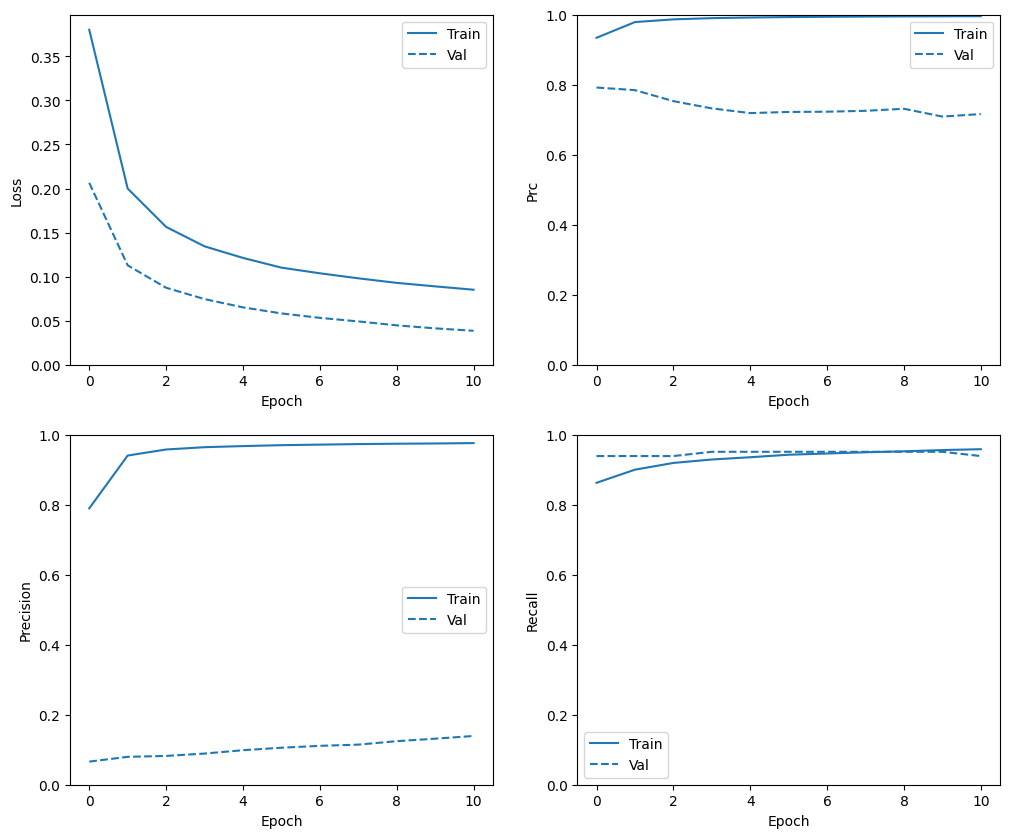

In [52]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [53]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - Brier score: 0.0213 - accuracy: 0.9700 - auc: 0.9739 - cross entropy: 0.0730 - fn: 383.0000 - fp: 1047.0000 - loss: 0.8409 - prc: 0.5295 - precision: 0.4108 - recall: 0.6559 - tn: 45457.0000 - tp: 730.0000

 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - Brier score: 0.0450 - accuracy: 0.9316 - auc: 0.9566 - cross entropy: 0.1407 - fn: 1250.6666 - fp: 2443.8333 - loss: 0.8193 - prc: 0.6030 - precision: 0.4784 - recall: 0.6540 - tn: 46663.0000 - tp: 2379.5000

 9/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0559 - accuracy: 0.9140 - auc: 0.9485 - cross entropy: 0.1713 - fn: 1718.6666 - fp: 3251.6667 - loss: 0.8042 - prc: 0.6257 - precision: 0.4960 - recall: 0.6609 - tn: 47411.7773 - tp: 3426.8889

12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0650 - accuracy: 0.8990 - auc: 0.9414 - cross entropy: 0.1970 - fn: 2153.1667 - fp: 4058.7500 - loss: 0.7912 - prc: 0.6431 - precision: 0.5080 - recall: 0.6684 - tn: 48164.5000 - tp: 4504.5835

15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0729 - accuracy: 0.8862 - auc: 0.9353 - cross entropy: 0.2192 - fn: 2565.8000 - fp: 4859.3999 - loss: 0.7802 - prc: 0.6572 - precision: 0.5174 - recall: 0.6756 - tn: 48912.2656 - tp: 5615.5332

18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0797 - accuracy: 0.8751 - auc: 0.9299 - cross entropy: 0.2383 - fn: 2957.5000 - fp: 5649.2222 - loss: 0.7703 - prc: 0.6693 - precision: 0.5252 - recall: 0.6824 - tn: 49668.6094 - tp: 6749.6665

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - Brier score: 0.0854 - accuracy: 0.8656 - auc: 0.9253 - cross entropy: 0.2545 - fn: 3317.8572 - fp: 6401.5239 - loss: 0.7612 - prc: 0.6796 - precision: 0.5317 - recall: 0.6887 - tn: 50418.2383 - tp: 7861.8569 - val_Brier score: 0.2768 - val_accuracy: 0.4990 - val_auc: 0.9432 - val_cross entropy: 0.7582 - val_fn: 3.0000 - val_fp: 22829.0000 - val_loss: 0.7582 - val_prc: 0.3111 - val_precision: 0.0034 - val_recall: 0.9634 - val_tn: 22658.0000 - val_tp: 79.0000


Epoch 2/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.2100 - accuracy: 0.6558 - auc: 0.7746 - cross entropy: 0.6032 - fn: 215.0000 - fp: 490.0000 - loss: 0.6032 - prc: 0.8306 - precision: 0.6313 - recall: 0.7960 - tn: 504.0000 - tp: 839.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.2066 - accuracy: 0.6657 - auc: 0.7846 - cross entropy: 0.5973 - fn: 589.4000 - fp: 1448.8000 - loss: 0.5973 - prc: 0.8339 - precision: 0.6354 - recall: 0.8086 - tn: 1563.8000 - tp: 2542.0000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.2049 - accuracy: 0.6694 - auc: 0.7891 - cross entropy: 0.5925 - fn: 862.6250 - fp: 2153.6250 - loss: 0.5925 - prc: 0.8372 - precision: 0.6378 - recall: 0.8125 - tn: 2373.6250 - tp: 3826.1250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.2036 - accuracy: 0.6721 - auc: 0.7931 - cross entropy: 0.5885 - fn: 1123.2727 - fp: 2861.4546 - loss: 0.5885 - prc: 0.8401 - precision: 0.6390 - recall: 0.8156 - tn: 3195.9092 - tp: 5107.3638

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.2023 - accuracy: 0.6745 - auc: 0.7966 - cross entropy: 0.5846 - fn: 1374.2142 - fp: 3562.7144 - loss: 0.5846 - prc: 0.8428 - precision: 0.6402 - recall: 0.8185 - tn: 4027.2144 - tp: 6395.8569

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.2011 - accuracy: 0.6765 - auc: 0.7998 - cross entropy: 0.5811 - fn: 1617.7059 - fp: 4266.0000 - loss: 0.5811 - prc: 0.8453 - precision: 0.6411 - recall: 0.8210 - tn: 4858.1763 - tp: 7690.1177

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.2001 - accuracy: 0.6783 - auc: 0.8027 - cross entropy: 0.5781 - fn: 1853.7000 - fp: 4965.5000 - loss: 0.5781 - prc: 0.8474 - precision: 0.6418 - recall: 0.8233 - tn: 5702.1001 - tp: 8982.7002

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - Brier score: 0.1998 - accuracy: 0.6788 - auc: 0.8035 - cross entropy: 0.5771 - fn: 1924.4762 - fp: 5174.4287 - loss: 0.5771 - prc: 0.8480 - precision: 0.6421 - recall: 0.8240 - tn: 5957.5239 - tp: 9374.0479 - val_Brier score: 0.2384 - val_accuracy: 0.6159 - val_auc: 0.9514 - val_cross entropy: 0.6743 - val_fn: 3.0000 - val_fp: 17501.0000 - val_loss: 0.6743 - val_prc: 0.6435 - val_precision: 0.0045 - val_recall: 0.9634 - val_tn: 27986.0000 - val_tp: 79.0000


Epoch 3/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.1877 - accuracy: 0.7012 - auc: 0.8394 - cross entropy: 0.5449 - fn: 148.0000 - fp: 464.0000 - loss: 0.5449 - prc: 0.8757 - precision: 0.6530 - recall: 0.8550 - tn: 563.0000 - tp: 873.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1819 - accuracy: 0.7117 - auc: 0.8470 - cross entropy: 0.5315 - fn: 443.4000 - fp: 1310.0000 - loss: 0.5315 - prc: 0.8797 - precision: 0.6638 - recall: 0.8545 - tn: 1774.8000 - tp: 2615.8000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1802 - accuracy: 0.7155 - auc: 0.8500 - cross entropy: 0.5266 - fn: 654.5000 - fp: 1937.1250 - loss: 0.5266 - prc: 0.8817 - precision: 0.6669 - recall: 0.8561 - tn: 2695.3750 - tp: 3929.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.1790 - accuracy: 0.7180 - auc: 0.8519 - cross entropy: 0.5232 - fn: 866.6364 - fp: 2555.0000 - loss: 0.5232 - prc: 0.8831 - precision: 0.6692 - recall: 0.8569 - tn: 3627.3635 - tp: 5239.0000

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.1780 - accuracy: 0.7200 - auc: 0.8535 - cross entropy: 0.5202 - fn: 1082.5714 - fp: 3161.0000 - loss: 0.5202 - prc: 0.8844 - precision: 0.6711 - recall: 0.8572 - tn: 4565.6431 - tp: 6550.7856

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.1771 - accuracy: 0.7218 - auc: 0.8548 - cross entropy: 0.5176 - fn: 1298.4117 - fp: 3757.9412 - loss: 0.5176 - prc: 0.8855 - precision: 0.6729 - recall: 0.8574 - tn: 5510.4707 - tp: 7865.1763

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.1762 - accuracy: 0.7235 - auc: 0.8561 - cross entropy: 0.5150 - fn: 1511.8000 - fp: 4341.1499 - loss: 0.5150 - prc: 0.8867 - precision: 0.6749 - recall: 0.8578 - tn: 6462.7500 - tp: 9188.2998

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - Brier score: 0.1759 - accuracy: 0.7240 - auc: 0.8564 - cross entropy: 0.5143 - fn: 1575.7620 - fp: 4516.0952 - loss: 0.5143 - prc: 0.8870 - precision: 0.6754 - recall: 0.8579 - tn: 6751.8569 - tp: 9586.7617 - val_Brier score: 0.2005 - val_accuracy: 0.7314 - val_auc: 0.9561 - val_cross entropy: 0.5917 - val_fn: 4.0000 - val_fp: 12234.0000 - val_loss: 0.5917 - val_prc: 0.7039 - val_precision: 0.0063 - val_recall: 0.9512 - val_tn: 33253.0000 - val_tp: 78.0000


Epoch 4/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.1585 - accuracy: 0.7573 - auc: 0.8847 - cross entropy: 0.4748 - fn: 129.0000 - fp: 368.0000 - loss: 0.4748 - prc: 0.9040 - precision: 0.7068 - recall: 0.8730 - tn: 664.0000 - tp: 887.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1549 - accuracy: 0.7641 - auc: 0.8862 - cross entropy: 0.4613 - fn: 404.0000 - fp: 1038.2000 - loss: 0.4613 - prc: 0.9102 - precision: 0.7197 - recall: 0.8709 - tn: 2002.8000 - tp: 2699.0000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1546 - accuracy: 0.7642 - auc: 0.8857 - cross entropy: 0.4598 - fn: 616.8750 - fp: 1551.0000 - loss: 0.4598 - prc: 0.9107 - precision: 0.7206 - recall: 0.8688 - tn: 3019.6250 - tp: 4028.5000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.1545 - accuracy: 0.7638 - auc: 0.8854 - cross entropy: 0.4590 - fn: 833.0909 - fp: 2068.9092 - loss: 0.4590 - prc: 0.9108 - precision: 0.7203 - recall: 0.8672 - tn: 4038.9092 - tp: 5347.0908

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.1541 - accuracy: 0.7643 - auc: 0.8857 - cross entropy: 0.4577 - fn: 1044.7142 - fp: 2569.4285 - loss: 0.4577 - prc: 0.9113 - precision: 0.7210 - recall: 0.8664 - tn: 5074.6431 - tp: 6671.2144

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.1536 - accuracy: 0.7653 - auc: 0.8863 - cross entropy: 0.4560 - fn: 1251.2941 - fp: 3056.1177 - loss: 0.4560 - prc: 0.9119 - precision: 0.7222 - recall: 0.8662 - tn: 6119.6470 - tp: 8004.9414

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.1530 - accuracy: 0.7663 - auc: 0.8870 - cross entropy: 0.4542 - fn: 1454.6000 - fp: 3535.7000 - loss: 0.4542 - prc: 0.9126 - precision: 0.7232 - recall: 0.8662 - tn: 7182.1001 - tp: 9331.5996

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - Brier score: 0.1528 - accuracy: 0.7666 - auc: 0.8872 - cross entropy: 0.4537 - fn: 1515.7620 - fp: 3679.7620 - loss: 0.4537 - prc: 0.9127 - precision: 0.7236 - recall: 0.8662 - tn: 7503.4761 - tp: 9731.4766 - val_Brier score: 0.1704 - val_accuracy: 0.8147 - val_auc: 0.9601 - val_cross entropy: 0.5256 - val_fn: 5.0000 - val_fp: 8439.0000 - val_loss: 0.5256 - val_prc: 0.7351 - val_precision: 0.0090 - val_recall: 0.9390 - val_tn: 37048.0000 - val_tp: 77.0000


Epoch 5/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.1449 - accuracy: 0.7793 - auc: 0.8947 - cross entropy: 0.4280 - fn: 145.0000 - fp: 307.0000 - loss: 0.4280 - prc: 0.9209 - precision: 0.7418 - recall: 0.8588 - tn: 714.0000 - tp: 882.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.1442 - accuracy: 0.7810 - auc: 0.8945 - cross entropy: 0.4267 - fn: 368.7500 - fp: 749.7500 - loss: 0.4267 - prc: 0.9218 - precision: 0.7474 - recall: 0.8580 - tn: 1769.7500 - tp: 2231.7500

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1428 - accuracy: 0.7839 - auc: 0.8965 - cross entropy: 0.4239 - fn: 578.5714 - fp: 1176.4286 - loss: 0.4239 - prc: 0.9235 - precision: 0.7512 - recall: 0.8602 - tn: 2838.8572 - tp: 3598.1428

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1420 - accuracy: 0.7863 - auc: 0.8978 - cross entropy: 0.4221 - fn: 781.5000 - fp: 1598.5000 - loss: 0.4221 - prc: 0.9244 - precision: 0.7533 - recall: 0.8619 - tn: 3936.5000 - tp: 4947.5000

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1415 - accuracy: 0.7878 - auc: 0.8986 - cross entropy: 0.4211 - fn: 983.0000 - fp: 2021.3846 - loss: 0.4211 - prc: 0.9248 - precision: 0.7543 - recall: 0.8629 - tn: 5049.5386 - tp: 6282.0771

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1409 - accuracy: 0.7895 - auc: 0.8997 - cross entropy: 0.4196 - fn: 1181.5625 - fp: 2430.9375 - loss: 0.4196 - prc: 0.9254 - precision: 0.7555 - recall: 0.8638 - tn: 6180.5625 - tp: 7614.9375

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.1403 - accuracy: 0.7908 - auc: 0.9006 - cross entropy: 0.4182 - fn: 1380.8422 - fp: 2837.9473 - loss: 0.4182 - prc: 0.9259 - precision: 0.7566 - recall: 0.8644 - tn: 7315.1055 - tp: 8946.1055

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.1399 - accuracy: 0.7916 - auc: 0.9011 - cross entropy: 0.4172 - fn: 1509.0476 - fp: 3090.4285 - loss: 0.4172 - prc: 0.9263 - precision: 0.7574 - recall: 0.8647 - tn: 8035.0000 - tp: 9796.0000 - val_Brier score: 0.1466 - val_accuracy: 0.8680 - val_auc: 0.9637 - val_cross entropy: 0.4722 - val_fn: 5.0000 - val_fp: 6008.0000 - val_loss: 0.4722 - val_prc: 0.7597 - val_precision: 0.0127 - val_recall: 0.9390 - val_tn: 39479.0000 - val_tp: 77.0000


Epoch 6/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.1279 - accuracy: 0.8120 - auc: 0.9153 - cross entropy: 0.3878 - fn: 128.0000 - fp: 257.0000 - loss: 0.3878 - prc: 0.9376 - precision: 0.7818 - recall: 0.8780 - tn: 742.0000 - tp: 921.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.1300 - accuracy: 0.8089 - auc: 0.9128 - cross entropy: 0.3926 - fn: 391.2000 - fp: 785.8000 - loss: 0.3926 - prc: 0.9362 - precision: 0.7777 - recall: 0.8760 - tn: 2219.6001 - tp: 2747.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.1299 - accuracy: 0.8099 - auc: 0.9128 - cross entropy: 0.3924 - fn: 583.7500 - fp: 1164.6250 - loss: 0.3924 - prc: 0.9365 - precision: 0.7793 - recall: 0.8764 - tn: 3331.5000 - tp: 4136.1250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1295 - accuracy: 0.8108 - auc: 0.9130 - cross entropy: 0.3914 - fn: 781.5455 - fp: 1533.0000 - loss: 0.3914 - prc: 0.9367 - precision: 0.7808 - recall: 0.8760 - tn: 4465.6362 - tp: 5507.8184

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1292 - accuracy: 0.8116 - auc: 0.9134 - cross entropy: 0.3906 - fn: 974.6429 - fp: 1902.0000 - loss: 0.3906 - prc: 0.9369 - precision: 0.7816 - recall: 0.8760 - tn: 5612.8569 - tp: 6870.5000

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1288 - accuracy: 0.8125 - auc: 0.9138 - cross entropy: 0.3896 - fn: 1168.1177 - fp: 2259.7646 - loss: 0.3896 - prc: 0.9372 - precision: 0.7826 - recall: 0.8759 - tn: 6781.1763 - tp: 8222.9414

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.1284 - accuracy: 0.8134 - auc: 0.9143 - cross entropy: 0.3886 - fn: 1361.3500 - fp: 2613.5500 - loss: 0.3886 - prc: 0.9374 - precision: 0.7834 - recall: 0.8757 - tn: 7960.5498 - tp: 9568.5498

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.1283 - accuracy: 0.8136 - auc: 0.9144 - cross entropy: 0.3884 - fn: 1419.9048 - fp: 2720.1904 - loss: 0.3884 - prc: 0.9374 - precision: 0.7837 - recall: 0.8757 - tn: 8316.5713 - tp: 9973.8096 - val_Brier score: 0.1263 - val_accuracy: 0.9040 - val_auc: 0.9668 - val_cross entropy: 0.4258 - val_fn: 5.0000 - val_fp: 4368.0000 - val_loss: 0.4258 - val_prc: 0.7771 - val_precision: 0.0173 - val_recall: 0.9390 - val_tn: 41119.0000 - val_tp: 77.0000


Epoch 7/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.1175 - accuracy: 0.8320 - auc: 0.9264 - cross entropy: 0.3617 - fn: 128.0000 - fp: 216.0000 - loss: 0.3617 - prc: 0.9441 - precision: 0.8056 - recall: 0.8749 - tn: 809.0000 - tp: 895.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.1179 - accuracy: 0.8327 - auc: 0.9269 - cross entropy: 0.3619 - fn: 379.4000 - fp: 648.4000 - loss: 0.3619 - prc: 0.9446 - precision: 0.8046 - recall: 0.8756 - tn: 2448.8000 - tp: 2667.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.1178 - accuracy: 0.8328 - auc: 0.9270 - cross entropy: 0.3612 - fn: 572.5000 - fp: 967.3750 - loss: 0.3612 - prc: 0.9449 - precision: 0.8053 - recall: 0.8753 - tn: 3664.1250 - tp: 4012.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1174 - accuracy: 0.8334 - auc: 0.9272 - cross entropy: 0.3602 - fn: 766.4545 - fp: 1275.3636 - loss: 0.3602 - prc: 0.9452 - precision: 0.8066 - recall: 0.8752 - tn: 4885.0908 - tp: 5361.0908

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1171 - accuracy: 0.8341 - auc: 0.9274 - cross entropy: 0.3594 - fn: 959.0000 - fp: 1575.9286 - loss: 0.3594 - prc: 0.9455 - precision: 0.8081 - recall: 0.8752 - tn: 6110.2144 - tp: 6714.8569

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1168 - accuracy: 0.8346 - auc: 0.9276 - cross entropy: 0.3585 - fn: 1154.1177 - fp: 1875.5294 - loss: 0.3585 - prc: 0.9458 - precision: 0.8093 - recall: 0.8751 - tn: 7327.8237 - tp: 8074.5293

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1165 - accuracy: 0.8350 - auc: 0.9277 - cross entropy: 0.3577 - fn: 1351.0000 - fp: 2173.8999 - loss: 0.3577 - prc: 0.9460 - precision: 0.8102 - recall: 0.8749 - tn: 8551.4502 - tp: 9427.6504

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.1164 - accuracy: 0.8351 - auc: 0.9278 - cross entropy: 0.3575 - fn: 1410.5238 - fp: 2263.9524 - loss: 0.3575 - prc: 0.9460 - precision: 0.8105 - recall: 0.8749 - tn: 8921.5713 - tp: 9834.4287 - val_Brier score: 0.1079 - val_accuracy: 0.9311 - val_auc: 0.9695 - val_cross entropy: 0.3819 - val_fn: 5.0000 - val_fp: 3136.0000 - val_loss: 0.3819 - val_prc: 0.7823 - val_precision: 0.0240 - val_recall: 0.9390 - val_tn: 42351.0000 - val_tp: 77.0000


Epoch 8/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.1090 - accuracy: 0.8384 - auc: 0.9367 - cross entropy: 0.3375 - fn: 123.0000 - fp: 208.0000 - loss: 0.3375 - prc: 0.9503 - precision: 0.8092 - recall: 0.8776 - tn: 835.0000 - tp: 882.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.1099 - accuracy: 0.8407 - auc: 0.9340 - cross entropy: 0.3399 - fn: 383.4000 - fp: 590.8000 - loss: 0.3399 - prc: 0.9497 - precision: 0.8168 - recall: 0.8748 - tn: 2503.0000 - tp: 2666.8000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.1097 - accuracy: 0.8421 - auc: 0.9337 - cross entropy: 0.3394 - fn: 578.5000 - fp: 865.7500 - loss: 0.3394 - prc: 0.9497 - precision: 0.8196 - recall: 0.8742 - tn: 3772.7500 - tp: 3999.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.1093 - accuracy: 0.8435 - auc: 0.9338 - cross entropy: 0.3385 - fn: 772.1818 - fp: 1132.1818 - loss: 0.3385 - prc: 0.9499 - precision: 0.8220 - recall: 0.8740 - tn: 5049.0908 - tp: 5334.5454

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1089 - accuracy: 0.8448 - auc: 0.9340 - cross entropy: 0.3374 - fn: 966.0000 - fp: 1386.9286 - loss: 0.3374 - prc: 0.9502 - precision: 0.8245 - recall: 0.8740 - tn: 6318.5713 - tp: 6688.5000

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1085 - accuracy: 0.8459 - auc: 0.9342 - cross entropy: 0.3364 - fn: 1159.8823 - fp: 1639.1765 - loss: 0.3364 - prc: 0.9505 - precision: 0.8265 - recall: 0.8741 - tn: 7594.7646 - tp: 8038.1763

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1082 - accuracy: 0.8468 - auc: 0.9344 - cross entropy: 0.3356 - fn: 1355.0500 - fp: 1889.1500 - loss: 0.3356 - prc: 0.9508 - precision: 0.8281 - recall: 0.8740 - tn: 8875.1504 - tp: 9384.6504

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.1081 - accuracy: 0.8470 - auc: 0.9345 - cross entropy: 0.3353 - fn: 1414.0952 - fp: 1964.7620 - loss: 0.3353 - prc: 0.9508 - precision: 0.8286 - recall: 0.8740 - tn: 9261.8096 - tp: 9789.8096 - val_Brier score: 0.0926 - val_accuracy: 0.9487 - val_auc: 0.9721 - val_cross entropy: 0.3441 - val_fn: 5.0000 - val_fp: 2334.0000 - val_loss: 0.3441 - val_prc: 0.7887 - val_precision: 0.0319 - val_recall: 0.9390 - val_tn: 43153.0000 - val_tp: 77.0000


Epoch 9/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0989 - accuracy: 0.8643 - auc: 0.9432 - cross entropy: 0.3096 - fn: 131.0000 - fp: 147.0000 - loss: 0.3096 - prc: 0.9580 - precision: 0.8599 - recall: 0.8732 - tn: 868.0000 - tp: 902.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.1001 - accuracy: 0.8652 - auc: 0.9413 - cross entropy: 0.3144 - fn: 385.8000 - fp: 438.8000 - loss: 0.3144 - prc: 0.9566 - precision: 0.8605 - recall: 0.8751 - tn: 2602.0000 - tp: 2717.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.1003 - accuracy: 0.8654 - auc: 0.9411 - cross entropy: 0.3153 - fn: 577.0000 - fp: 661.0000 - loss: 0.3153 - prc: 0.9561 - precision: 0.8602 - recall: 0.8754 - tn: 3909.5000 - tp: 4068.5000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.1002 - accuracy: 0.8656 - auc: 0.9412 - cross entropy: 0.3152 - fn: 761.4545 - fp: 885.5455 - loss: 0.3152 - prc: 0.9560 - precision: 0.8599 - recall: 0.8762 - tn: 5213.0000 - tp: 5428.0000

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.1000 - accuracy: 0.8660 - auc: 0.9415 - cross entropy: 0.3147 - fn: 944.8571 - fp: 1107.2858 - loss: 0.3147 - prc: 0.9562 - precision: 0.8599 - recall: 0.8769 - tn: 6517.4287 - tp: 6790.4287

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0998 - accuracy: 0.8662 - auc: 0.9417 - cross entropy: 0.3142 - fn: 1134.8823 - fp: 1323.8823 - loss: 0.3142 - prc: 0.9563 - precision: 0.8601 - recall: 0.8770 - tn: 7826.5884 - tp: 8146.6470

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0995 - accuracy: 0.8665 - auc: 0.9418 - cross entropy: 0.3136 - fn: 1327.3000 - fp: 1532.2500 - loss: 0.3136 - prc: 0.9564 - precision: 0.8606 - recall: 0.8769 - tn: 9146.5498 - tp: 9497.9004

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0994 - accuracy: 0.8665 - auc: 0.9419 - cross entropy: 0.3134 - fn: 1385.7142 - fp: 1594.3810 - loss: 0.3134 - prc: 0.9564 - precision: 0.8608 - recall: 0.8769 - tn: 9544.9521 - tp: 9905.4287 - val_Brier score: 0.0800 - val_accuracy: 0.9605 - val_auc: 0.9745 - val_cross entropy: 0.3111 - val_fn: 5.0000 - val_fp: 1794.0000 - val_loss: 0.3111 - val_prc: 0.7932 - val_precision: 0.0412 - val_recall: 0.9390 - val_tn: 43693.0000 - val_tp: 77.0000


Epoch 10/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0966 - accuracy: 0.8667 - auc: 0.9446 - cross entropy: 0.3052 - fn: 126.0000 - fp: 147.0000 - loss: 0.3052 - prc: 0.9559 - precision: 0.8574 - recall: 0.8752 - tn: 891.0000 - tp: 884.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0952 - accuracy: 0.8692 - auc: 0.9462 - cross entropy: 0.3010 - fn: 379.0000 - fp: 418.8000 - loss: 0.3010 - prc: 0.9585 - precision: 0.8642 - recall: 0.8768 - tn: 2628.8000 - tp: 2717.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0946 - accuracy: 0.8705 - auc: 0.9466 - cross entropy: 0.2997 - fn: 566.7500 - fp: 616.0000 - loss: 0.2997 - prc: 0.9592 - precision: 0.8667 - recall: 0.8775 - tn: 3944.2500 - tp: 4089.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0943 - accuracy: 0.8716 - auc: 0.9468 - cross entropy: 0.2988 - fn: 754.7273 - fp: 805.9091 - loss: 0.2988 - prc: 0.9595 - precision: 0.8686 - recall: 0.8777 - tn: 5281.3638 - tp: 5446.0000

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0939 - accuracy: 0.8727 - auc: 0.9470 - cross entropy: 0.2978 - fn: 941.2143 - fp: 988.8571 - loss: 0.2978 - prc: 0.9598 - precision: 0.8702 - recall: 0.8779 - tn: 6635.7144 - tp: 6794.2144

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0936 - accuracy: 0.8735 - auc: 0.9472 - cross entropy: 0.2969 - fn: 1128.7059 - fp: 1171.2354 - loss: 0.2969 - prc: 0.9600 - precision: 0.8715 - recall: 0.8780 - tn: 7981.7061 - tp: 8150.3530

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0933 - accuracy: 0.8741 - auc: 0.9474 - cross entropy: 0.2963 - fn: 1315.4000 - fp: 1354.2500 - loss: 0.2963 - prc: 0.9602 - precision: 0.8724 - recall: 0.8781 - tn: 9325.2002 - tp: 9509.1504

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - Brier score: 0.0932 - accuracy: 0.8743 - auc: 0.9474 - cross entropy: 0.2961 - fn: 1371.6190 - fp: 1409.3810 - loss: 0.2961 - prc: 0.9602 - precision: 0.8727 - recall: 0.8781 - tn: 9730.0000 - tp: 9919.4766 - val_Brier score: 0.0703 - val_accuracy: 0.9667 - val_auc: 0.9773 - val_cross entropy: 0.2844 - val_fn: 5.0000 - val_fp: 1514.0000 - val_loss: 0.2844 - val_prc: 0.7895 - val_precision: 0.0484 - val_recall: 0.9390 - val_tn: 43973.0000 - val_tp: 77.0000


Epoch 11/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0910 - accuracy: 0.8760 - auc: 0.9483 - cross entropy: 0.2889 - fn: 132.0000 - fp: 122.0000 - loss: 0.2889 - prc: 0.9586 - precision: 0.8738 - recall: 0.8649 - tn: 949.0000 - tp: 845.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0892 - accuracy: 0.8800 - auc: 0.9509 - cross entropy: 0.2842 - fn: 376.4000 - fp: 353.8000 - loss: 0.2842 - prc: 0.9621 - precision: 0.8816 - recall: 0.8754 - tn: 2716.2000 - tp: 2697.6001

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0888 - accuracy: 0.8810 - auc: 0.9512 - cross entropy: 0.2832 - fn: 559.1250 - fp: 528.0000 - loss: 0.2832 - prc: 0.9628 - precision: 0.8832 - recall: 0.8773 - tn: 4057.3750 - tp: 4071.5000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0886 - accuracy: 0.8815 - auc: 0.9513 - cross entropy: 0.2826 - fn: 740.0000 - fp: 704.8182 - loss: 0.2826 - prc: 0.9631 - precision: 0.8838 - recall: 0.8784 - tn: 5402.5454 - tp: 5440.6362

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0883 - accuracy: 0.8821 - auc: 0.9516 - cross entropy: 0.2819 - fn: 920.5714 - fp: 875.0000 - loss: 0.2819 - prc: 0.9633 - precision: 0.8845 - recall: 0.8791 - tn: 6766.9287 - tp: 6797.5000

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0880 - accuracy: 0.8826 - auc: 0.9518 - cross entropy: 0.2811 - fn: 1102.6471 - fp: 1040.4706 - loss: 0.2811 - prc: 0.9635 - precision: 0.8853 - recall: 0.8795 - tn: 8134.4707 - tp: 8154.4116

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0877 - accuracy: 0.8831 - auc: 0.9520 - cross entropy: 0.2806 - fn: 1286.4500 - fp: 1202.4500 - loss: 0.2806 - prc: 0.9636 - precision: 0.8860 - recall: 0.8797 - tn: 9497.4004 - tp: 9517.7002

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0877 - accuracy: 0.8832 - auc: 0.9520 - cross entropy: 0.2804 - fn: 1342.0000 - fp: 1251.1904 - loss: 0.2804 - prc: 0.9637 - precision: 0.8863 - recall: 0.8798 - tn: 9908.1904 - tp: 9929.0957 - val_Brier score: 0.0620 - val_accuracy: 0.9704 - val_auc: 0.9792 - val_cross entropy: 0.2602 - val_fn: 5.0000 - val_fp: 1345.0000 - val_loss: 0.2602 - val_prc: 0.7840 - val_precision: 0.0541 - val_recall: 0.9390 - val_tn: 44142.0000 - val_tp: 77.0000


Epoch 12/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0809 - accuracy: 0.8911 - auc: 0.9575 - cross entropy: 0.2598 - fn: 127.0000 - fp: 96.0000 - loss: 0.2598 - prc: 0.9681 - precision: 0.9046 - recall: 0.8775 - tn: 915.0000 - tp: 910.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0815 - accuracy: 0.8923 - auc: 0.9573 - cross entropy: 0.2623 - fn: 361.8000 - fp: 298.4000 - loss: 0.2623 - prc: 0.9672 - precision: 0.9015 - recall: 0.8811 - tn: 2776.3999 - tp: 2707.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0822 - accuracy: 0.8909 - auc: 0.9564 - cross entropy: 0.2641 - fn: 551.7500 - fp: 460.0000 - loss: 0.2641 - prc: 0.9666 - precision: 0.8997 - recall: 0.8804 - tn: 4142.6250 - tp: 4061.6250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0823 - accuracy: 0.8907 - auc: 0.9562 - cross entropy: 0.2646 - fn: 735.1818 - fp: 615.1818 - loss: 0.2646 - prc: 0.9664 - precision: 0.8991 - recall: 0.8804 - tn: 5522.6362 - tp: 5415.0000

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0823 - accuracy: 0.8907 - auc: 0.9561 - cross entropy: 0.2646 - fn: 917.9286 - fp: 765.8571 - loss: 0.2646 - prc: 0.9664 - precision: 0.8992 - recall: 0.8806 - tn: 6894.9287 - tp: 6781.2856

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0822 - accuracy: 0.8909 - auc: 0.9561 - cross entropy: 0.2646 - fn: 1099.0000 - fp: 913.8823 - loss: 0.2646 - prc: 0.9665 - precision: 0.8993 - recall: 0.8807 - tn: 8288.7646 - tp: 8130.3530

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0822 - accuracy: 0.8910 - auc: 0.9562 - cross entropy: 0.2645 - fn: 1280.2500 - fp: 1060.7000 - loss: 0.2645 - prc: 0.9665 - precision: 0.8994 - recall: 0.8808 - tn: 9689.2500 - tp: 9473.7998

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0821 - accuracy: 0.8911 - auc: 0.9562 - cross entropy: 0.2644 - fn: 1335.1904 - fp: 1104.5238 - loss: 0.2644 - prc: 0.9665 - precision: 0.8995 - recall: 0.8808 - tn: 10111.1426 - tp: 9879.6191 - val_Brier score: 0.0550 - val_accuracy: 0.9731 - val_auc: 0.9809 - val_cross entropy: 0.2388 - val_fn: 5.0000 - val_fp: 1223.0000 - val_loss: 0.2388 - val_prc: 0.7881 - val_precision: 0.0592 - val_recall: 0.9390 - val_tn: 44264.0000 - val_tp: 77.0000


Epoch 13/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0786 - accuracy: 0.9004 - auc: 0.9579 - cross entropy: 0.2574 - fn: 106.0000 - fp: 98.0000 - loss: 0.2574 - prc: 0.9671 - precision: 0.9028 - recall: 0.8957 - tn: 934.0000 - tp: 910.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0803 - accuracy: 0.8953 - auc: 0.9568 - cross entropy: 0.2604 - fn: 354.6000 - fp: 291.8000 - loss: 0.2604 - prc: 0.9668 - precision: 0.9029 - recall: 0.8859 - tn: 2781.6001 - tp: 2716.0000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0799 - accuracy: 0.8958 - auc: 0.9574 - cross entropy: 0.2590 - fn: 529.7500 - fp: 429.2500 - loss: 0.2590 - prc: 0.9672 - precision: 0.9038 - recall: 0.8854 - tn: 4192.5000 - tp: 4064.5000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0795 - accuracy: 0.8963 - auc: 0.9580 - cross entropy: 0.2579 - fn: 703.6364 - fp: 564.8182 - loss: 0.2579 - prc: 0.9676 - precision: 0.9046 - recall: 0.8854 - tn: 5606.2729 - tp: 5413.2729

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0791 - accuracy: 0.8968 - auc: 0.9584 - cross entropy: 0.2572 - fn: 878.7857 - fp: 697.7143 - loss: 0.2572 - prc: 0.9677 - precision: 0.9054 - recall: 0.8853 - tn: 7019.2856 - tp: 6764.2144

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0789 - accuracy: 0.8970 - auc: 0.9587 - cross entropy: 0.2566 - fn: 1055.1765 - fp: 832.6470 - loss: 0.2566 - prc: 0.9679 - precision: 0.9058 - recall: 0.8852 - tn: 8432.7646 - tp: 8111.4116

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0787 - accuracy: 0.8973 - auc: 0.9589 - cross entropy: 0.2560 - fn: 1228.5000 - fp: 967.0500 - loss: 0.2560 - prc: 0.9680 - precision: 0.9062 - recall: 0.8853 - tn: 9846.1504 - tp: 9462.2998

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0786 - accuracy: 0.8973 - auc: 0.9590 - cross entropy: 0.2559 - fn: 1280.6190 - fp: 1007.5714 - loss: 0.2559 - prc: 0.9681 - precision: 0.9063 - recall: 0.8853 - tn: 10273.3809 - tp: 9868.9043 - val_Brier score: 0.0492 - val_accuracy: 0.9750 - val_auc: 0.9816 - val_cross entropy: 0.2201 - val_fn: 5.0000 - val_fp: 1134.0000 - val_loss: 0.2201 - val_prc: 0.7912 - val_precision: 0.0636 - val_recall: 0.9390 - val_tn: 44353.0000 - val_tp: 77.0000


Epoch 14/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0750 - accuracy: 0.9087 - auc: 0.9630 - cross entropy: 0.2465 - fn: 102.0000 - fp: 85.0000 - loss: 0.2465 - prc: 0.9716 - precision: 0.9146 - recall: 0.8992 - tn: 951.0000 - tp: 910.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0744 - accuracy: 0.9070 - auc: 0.9630 - cross entropy: 0.2442 - fn: 329.0000 - fp: 243.6000 - loss: 0.2442 - prc: 0.9715 - precision: 0.9175 - recall: 0.8939 - tn: 2828.3999 - tp: 2743.0000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0744 - accuracy: 0.9066 - auc: 0.9631 - cross entropy: 0.2438 - fn: 498.2500 - fp: 365.1250 - loss: 0.2438 - prc: 0.9715 - precision: 0.9179 - recall: 0.8931 - tn: 4233.5000 - tp: 4119.1250

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0743 - accuracy: 0.9065 - auc: 0.9631 - cross entropy: 0.2434 - fn: 612.0000 - fp: 445.0000 - loss: 0.2434 - prc: 0.9716 - precision: 0.9182 - recall: 0.8926 - tn: 5171.1001 - tp: 5035.8999

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0741 - accuracy: 0.9064 - auc: 0.9631 - cross entropy: 0.2430 - fn: 783.6923 - fp: 562.7692 - loss: 0.2430 - prc: 0.9716 - precision: 0.9186 - recall: 0.8920 - tn: 6586.1538 - tp: 6403.3848

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0740 - accuracy: 0.9064 - auc: 0.9632 - cross entropy: 0.2427 - fn: 952.4375 - fp: 680.4375 - loss: 0.2427 - prc: 0.9716 - precision: 0.9188 - recall: 0.8917 - tn: 8009.1250 - tp: 7766.0000

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0739 - accuracy: 0.9064 - auc: 0.9632 - cross entropy: 0.2424 - fn: 1124.5790 - fp: 795.7368 - loss: 0.2424 - prc: 0.9717 - precision: 0.9192 - recall: 0.8914 - tn: 9419.5791 - tp: 9140.1055

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - Brier score: 0.0739 - accuracy: 0.9064 - auc: 0.9633 - cross entropy: 0.2422 - fn: 1233.4762 - fp: 868.5238 - loss: 0.2422 - prc: 0.9717 - precision: 0.9194 - recall: 0.8912 - tn: 10317.9043 - tp: 10010.5713 - val_Brier score: 0.0447 - val_accuracy: 0.9759 - val_auc: 0.9824 - val_cross entropy: 0.2045 - val_fn: 5.0000 - val_fp: 1091.0000 - val_loss: 0.2045 - val_prc: 0.7934 - val_precision: 0.0659 - val_recall: 0.9390 - val_tn: 44396.0000 - val_tp: 77.0000


Epoch 15/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0742 - accuracy: 0.9019 - auc: 0.9622 - cross entropy: 0.2417 - fn: 117.0000 - fp: 84.0000 - loss: 0.2417 - prc: 0.9700 - precision: 0.9133 - recall: 0.8832 - tn: 962.0000 - tp: 885.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0740 - accuracy: 0.9016 - auc: 0.9622 - cross entropy: 0.2411 - fn: 348.6000 - fp: 253.8000 - loss: 0.2411 - prc: 0.9704 - precision: 0.9132 - recall: 0.8846 - tn: 2850.2000 - tp: 2691.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0738 - accuracy: 0.9023 - auc: 0.9625 - cross entropy: 0.2405 - fn: 515.1250 - fp: 380.3750 - loss: 0.2405 - prc: 0.9707 - precision: 0.9137 - recall: 0.8862 - tn: 4262.8750 - tp: 4057.6250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0735 - accuracy: 0.9030 - auc: 0.9628 - cross entropy: 0.2400 - fn: 682.2727 - fp: 499.9091 - loss: 0.2400 - prc: 0.9710 - precision: 0.9147 - recall: 0.8870 - tn: 5685.0908 - tp: 5420.7271

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0734 - accuracy: 0.9034 - auc: 0.9629 - cross entropy: 0.2398 - fn: 855.1429 - fp: 617.2857 - loss: 0.2398 - prc: 0.9711 - precision: 0.9154 - recall: 0.8872 - tn: 7104.2856 - tp: 6783.2856

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0733 - accuracy: 0.9038 - auc: 0.9631 - cross entropy: 0.2395 - fn: 1026.3529 - fp: 732.5294 - loss: 0.2395 - prc: 0.9712 - precision: 0.9162 - recall: 0.8874 - tn: 8520.1768 - tp: 8152.9414

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0731 - accuracy: 0.9041 - auc: 0.9632 - cross entropy: 0.2391 - fn: 1195.9500 - fp: 847.0000 - loss: 0.2391 - prc: 0.9713 - precision: 0.9168 - recall: 0.8876 - tn: 9944.2002 - tp: 9516.8496

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0731 - accuracy: 0.9042 - auc: 0.9633 - cross entropy: 0.2390 - fn: 1247.2380 - fp: 881.2381 - loss: 0.2390 - prc: 0.9713 - precision: 0.9170 - recall: 0.8877 - tn: 10373.6191 - tp: 9928.3809 - val_Brier score: 0.0412 - val_accuracy: 0.9767 - val_auc: 0.9828 - val_cross entropy: 0.1919 - val_fn: 5.0000 - val_fp: 1059.0000 - val_loss: 0.1919 - val_prc: 0.7955 - val_precision: 0.0678 - val_recall: 0.9390 - val_tn: 44428.0000 - val_tp: 77.0000


Epoch 16/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0661 - accuracy: 0.9111 - auc: 0.9710 - cross entropy: 0.2211 - fn: 107.0000 - fp: 75.0000 - loss: 0.2211 - prc: 0.9776 - precision: 0.9254 - recall: 0.8969 - tn: 935.0000 - tp: 931.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0684 - accuracy: 0.9084 - auc: 0.9680 - cross entropy: 0.2268 - fn: 329.6000 - fp: 236.8000 - loss: 0.2268 - prc: 0.9748 - precision: 0.9220 - recall: 0.8937 - tn: 2819.8000 - tp: 2757.8000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0692 - accuracy: 0.9077 - auc: 0.9671 - cross entropy: 0.2292 - fn: 494.5000 - fp: 362.6250 - loss: 0.2292 - prc: 0.9741 - precision: 0.9205 - recall: 0.8933 - tn: 4233.7500 - tp: 4125.1250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0696 - accuracy: 0.9074 - auc: 0.9667 - cross entropy: 0.2302 - fn: 661.4545 - fp: 483.8182 - loss: 0.2302 - prc: 0.9737 - precision: 0.9199 - recall: 0.8928 - tn: 5662.5454 - tp: 5480.1816

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0697 - accuracy: 0.9073 - auc: 0.9666 - cross entropy: 0.2304 - fn: 827.6429 - fp: 602.0000 - loss: 0.2304 - prc: 0.9736 - precision: 0.9199 - recall: 0.8926 - tn: 7087.2144 - tp: 6843.1431

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0698 - accuracy: 0.9075 - auc: 0.9665 - cross entropy: 0.2303 - fn: 991.5883 - fp: 716.0000 - loss: 0.2303 - prc: 0.9735 - precision: 0.9201 - recall: 0.8926 - tn: 8511.2354 - tp: 8213.1768

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0697 - accuracy: 0.9078 - auc: 0.9666 - cross entropy: 0.2301 - fn: 1155.9500 - fp: 824.3500 - loss: 0.2301 - prc: 0.9736 - precision: 0.9206 - recall: 0.8926 - tn: 9935.6504 - tp: 9588.0498

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.0697 - accuracy: 0.9079 - auc: 0.9666 - cross entropy: 0.2300 - fn: 1205.6666 - fp: 856.9524 - loss: 0.2300 - prc: 0.9736 - precision: 0.9208 - recall: 0.8926 - tn: 10364.8574 - tp: 10003.0000 - val_Brier score: 0.0380 - val_accuracy: 0.9775 - val_auc: 0.9833 - val_cross entropy: 0.1800 - val_fn: 5.0000 - val_fp: 1019.0000 - val_loss: 0.1800 - val_prc: 0.7976 - val_precision: 0.0703 - val_recall: 0.9390 - val_tn: 44468.0000 - val_tp: 77.0000


Epoch 17/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0666 - accuracy: 0.9126 - auc: 0.9702 - cross entropy: 0.2209 - fn: 99.0000 - fp: 80.0000 - loss: 0.2209 - prc: 0.9756 - precision: 0.9206 - recall: 0.9035 - tn: 942.0000 - tp: 927.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0672 - accuracy: 0.9121 - auc: 0.9692 - cross entropy: 0.2215 - fn: 324.2000 - fp: 216.0000 - loss: 0.2215 - prc: 0.9750 - precision: 0.9252 - recall: 0.8956 - tn: 2874.0000 - tp: 2729.8000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0672 - accuracy: 0.9125 - auc: 0.9690 - cross entropy: 0.2216 - fn: 487.7500 - fp: 316.0000 - loss: 0.2216 - prc: 0.9751 - precision: 0.9270 - recall: 0.8950 - tn: 4299.3750 - tp: 4112.8750

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0673 - accuracy: 0.9125 - auc: 0.9688 - cross entropy: 0.2218 - fn: 653.3636 - fp: 421.0000 - loss: 0.2218 - prc: 0.9750 - precision: 0.9276 - recall: 0.8946 - tn: 5713.5454 - tp: 5500.0908

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0672 - accuracy: 0.9126 - auc: 0.9688 - cross entropy: 0.2215 - fn: 817.5000 - fp: 521.2857 - loss: 0.2215 - prc: 0.9752 - precision: 0.9283 - recall: 0.8946 - tn: 7127.3569 - tp: 6893.8569

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0671 - accuracy: 0.9128 - auc: 0.9688 - cross entropy: 0.2212 - fn: 981.7647 - fp: 621.1765 - loss: 0.2212 - prc: 0.9752 - precision: 0.9289 - recall: 0.8945 - tn: 8549.1768 - tp: 8279.8828

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0670 - accuracy: 0.9129 - auc: 0.9688 - cross entropy: 0.2210 - fn: 1147.2000 - fp: 718.2500 - loss: 0.2210 - prc: 0.9753 - precision: 0.9294 - recall: 0.8943 - tn: 9979.5996 - tp: 9658.9502

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.0670 - accuracy: 0.9130 - auc: 0.9688 - cross entropy: 0.2209 - fn: 1197.1428 - fp: 747.4286 - loss: 0.2209 - prc: 0.9753 - precision: 0.9295 - recall: 0.8943 - tn: 10411.0479 - tp: 10074.8574 - val_Brier score: 0.0358 - val_accuracy: 0.9777 - val_auc: 0.9836 - val_cross entropy: 0.1710 - val_fn: 5.0000 - val_fp: 1013.0000 - val_loss: 0.1710 - val_prc: 0.7976 - val_precision: 0.0706 - val_recall: 0.9390 - val_tn: 44474.0000 - val_tp: 77.0000


Epoch 18/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0675 - accuracy: 0.9116 - auc: 0.9661 - cross entropy: 0.2219 - fn: 115.0000 - fp: 66.0000 - loss: 0.2219 - prc: 0.9734 - precision: 0.9315 - recall: 0.8864 - tn: 970.0000 - tp: 897.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0669 - accuracy: 0.9122 - auc: 0.9669 - cross entropy: 0.2196 - fn: 343.4000 - fp: 194.4000 - loss: 0.2196 - prc: 0.9744 - precision: 0.9333 - recall: 0.8878 - tn: 2877.0000 - tp: 2729.2000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0666 - accuracy: 0.9127 - auc: 0.9674 - cross entropy: 0.2190 - fn: 505.6250 - fp: 295.1250 - loss: 0.2190 - prc: 0.9747 - precision: 0.9329 - recall: 0.8891 - tn: 4318.2500 - tp: 4097.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0664 - accuracy: 0.9131 - auc: 0.9678 - cross entropy: 0.2183 - fn: 665.3636 - fp: 396.0000 - loss: 0.2183 - prc: 0.9749 - precision: 0.9326 - recall: 0.8902 - tn: 5766.6362 - tp: 5460.0000

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0662 - accuracy: 0.9134 - auc: 0.9681 - cross entropy: 0.2177 - fn: 828.6429 - fp: 493.0000 - loss: 0.2177 - prc: 0.9750 - precision: 0.9328 - recall: 0.8907 - tn: 7205.0713 - tp: 6833.2856

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0659 - accuracy: 0.9137 - auc: 0.9684 - cross entropy: 0.2171 - fn: 989.4117 - fp: 589.2353 - loss: 0.2171 - prc: 0.9752 - precision: 0.9329 - recall: 0.8912 - tn: 8648.7646 - tp: 8204.5879

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0657 - accuracy: 0.9140 - auc: 0.9687 - cross entropy: 0.2165 - fn: 1147.5500 - fp: 685.8000 - loss: 0.2165 - prc: 0.9754 - precision: 0.9330 - recall: 0.8917 - tn: 10089.6504 - tp: 9581.0000

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.0657 - accuracy: 0.9141 - auc: 0.9687 - cross entropy: 0.2163 - fn: 1195.1904 - fp: 714.6190 - loss: 0.2163 - prc: 0.9755 - precision: 0.9331 - recall: 0.8919 - tn: 10524.4766 - tp: 9996.1904 - val_Brier score: 0.0340 - val_accuracy: 0.9775 - val_auc: 0.9838 - val_cross entropy: 0.1632 - val_fn: 5.0000 - val_fp: 1022.0000 - val_loss: 0.1632 - val_prc: 0.7981 - val_precision: 0.0701 - val_recall: 0.9390 - val_tn: 44465.0000 - val_tp: 77.0000


Epoch 19/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0614 - accuracy: 0.9185 - auc: 0.9727 - cross entropy: 0.2049 - fn: 109.0000 - fp: 58.0000 - loss: 0.2049 - prc: 0.9780 - precision: 0.9395 - recall: 0.8920 - tn: 981.0000 - tp: 900.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0618 - accuracy: 0.9185 - auc: 0.9723 - cross entropy: 0.2054 - fn: 267.5000 - fp: 150.5000 - loss: 0.2054 - prc: 0.9780 - precision: 0.9382 - recall: 0.8944 - tn: 2424.7500 - tp: 2277.2500

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0621 - accuracy: 0.9181 - auc: 0.9722 - cross entropy: 0.2063 - fn: 426.5714 - fp: 246.1429 - loss: 0.2063 - prc: 0.9781 - precision: 0.9375 - recall: 0.8952 - tn: 3853.7144 - tp: 3665.5715

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0622 - accuracy: 0.9181 - auc: 0.9721 - cross entropy: 0.2066 - fn: 585.9000 - fp: 338.2000 - loss: 0.2066 - prc: 0.9780 - precision: 0.9373 - recall: 0.8953 - tn: 5312.3999 - tp: 5027.5000

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0623 - accuracy: 0.9181 - auc: 0.9721 - cross entropy: 0.2066 - fn: 741.9231 - fp: 432.1538 - loss: 0.2066 - prc: 0.9779 - precision: 0.9370 - recall: 0.8955 - tn: 6775.1538 - tp: 6386.7690

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0623 - accuracy: 0.9182 - auc: 0.9721 - cross entropy: 0.2066 - fn: 897.7500 - fp: 525.7500 - loss: 0.2066 - prc: 0.9779 - precision: 0.9368 - recall: 0.8957 - tn: 8237.6875 - tp: 7746.8125

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0623 - accuracy: 0.9183 - auc: 0.9721 - cross entropy: 0.2066 - fn: 1053.6316 - fp: 616.4737 - loss: 0.2066 - prc: 0.9779 - precision: 0.9369 - recall: 0.8959 - tn: 9696.1055 - tp: 9113.7891

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Brier score: 0.0623 - accuracy: 0.9184 - auc: 0.9721 - cross entropy: 0.2066 - fn: 1152.6190 - fp: 673.1905 - loss: 0.2066 - prc: 0.9779 - precision: 0.9370 - recall: 0.8960 - tn: 10617.4287 - tp: 9987.2383 - val_Brier score: 0.0321 - val_accuracy: 0.9777 - val_auc: 0.9842 - val_cross entropy: 0.1556 - val_fn: 5.0000 - val_fp: 1011.0000 - val_loss: 0.1556 - val_prc: 0.7999 - val_precision: 0.0708 - val_recall: 0.9390 - val_tn: 44476.0000 - val_tp: 77.0000


Epoch 20/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0614 - accuracy: 0.9219 - auc: 0.9724 - cross entropy: 0.2077 - fn: 103.0000 - fp: 57.0000 - loss: 0.2077 - prc: 0.9759 - precision: 0.9408 - recall: 0.8979 - tn: 982.0000 - tp: 906.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0624 - accuracy: 0.9185 - auc: 0.9720 - cross entropy: 0.2101 - fn: 270.0000 - fp: 150.2500 - loss: 0.2101 - prc: 0.9767 - precision: 0.9391 - recall: 0.8955 - tn: 2391.7500 - tp: 2308.0000

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0623 - accuracy: 0.9181 - auc: 0.9722 - cross entropy: 0.2091 - fn: 425.5714 - fp: 249.8571 - loss: 0.2091 - prc: 0.9770 - precision: 0.9373 - recall: 0.8960 - tn: 3847.0000 - tp: 3669.5715

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0622 - accuracy: 0.9178 - auc: 0.9724 - cross entropy: 0.2085 - fn: 580.1000 - fp: 351.4000 - loss: 0.2085 - prc: 0.9772 - precision: 0.9361 - recall: 0.8964 - tn: 5298.7002 - tp: 5033.7998

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0621 - accuracy: 0.9179 - auc: 0.9726 - cross entropy: 0.2078 - fn: 733.0769 - fp: 446.5385 - loss: 0.2078 - prc: 0.9773 - precision: 0.9358 - recall: 0.8968 - tn: 6755.7690 - tp: 6400.6152

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0620 - accuracy: 0.9182 - auc: 0.9727 - cross entropy: 0.2072 - fn: 885.5625 - fp: 537.1875 - loss: 0.2072 - prc: 0.9775 - precision: 0.9359 - recall: 0.8971 - tn: 8215.4375 - tp: 7769.8125

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0619 - accuracy: 0.9183 - auc: 0.9728 - cross entropy: 0.2068 - fn: 1040.4736 - fp: 627.4211 - loss: 0.2068 - prc: 0.9776 - precision: 0.9361 - recall: 0.8973 - tn: 9664.7373 - tp: 9147.3682

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.0618 - accuracy: 0.9184 - auc: 0.9728 - cross entropy: 0.2065 - fn: 1139.0952 - fp: 684.5238 - loss: 0.2065 - prc: 0.9777 - precision: 0.9362 - recall: 0.8974 - tn: 10583.5234 - tp: 10023.3330 - val_Brier score: 0.0304 - val_accuracy: 0.9782 - val_auc: 0.9845 - val_cross entropy: 0.1483 - val_fn: 5.0000 - val_fp: 990.0000 - val_loss: 0.1483 - val_prc: 0.8002 - val_precision: 0.0722 - val_recall: 0.9390 - val_tn: 44497.0000 - val_tp: 77.0000


Epoch 21/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0597 - accuracy: 0.9258 - auc: 0.9742 - cross entropy: 0.2032 - fn: 99.0000 - fp: 53.0000 - loss: 0.2032 - prc: 0.9780 - precision: 0.9446 - recall: 0.9012 - tn: 993.0000 - tp: 903.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0594 - accuracy: 0.9235 - auc: 0.9747 - cross entropy: 0.1995 - fn: 248.7500 - fp: 143.0000 - loss: 0.1995 - prc: 0.9789 - precision: 0.9411 - recall: 0.9007 - tn: 2457.5000 - tp: 2270.7500

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0592 - accuracy: 0.9233 - auc: 0.9749 - cross entropy: 0.1987 - fn: 395.1429 - fp: 233.1429 - loss: 0.1987 - prc: 0.9791 - precision: 0.9403 - recall: 0.9013 - tn: 3933.1428 - tp: 3630.5715

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0591 - accuracy: 0.9233 - auc: 0.9750 - cross entropy: 0.1981 - fn: 542.4000 - fp: 321.5000 - loss: 0.1981 - prc: 0.9792 - precision: 0.9400 - recall: 0.9016 - tn: 5399.5000 - tp: 5000.6001

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0591 - accuracy: 0.9231 - auc: 0.9750 - cross entropy: 0.1980 - fn: 692.3846 - fp: 411.5385 - loss: 0.1980 - prc: 0.9792 - precision: 0.9397 - recall: 0.9016 - tn: 6869.7690 - tp: 6362.3076

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0592 - accuracy: 0.9231 - auc: 0.9750 - cross entropy: 0.1980 - fn: 842.5625 - fp: 497.7500 - loss: 0.1980 - prc: 0.9792 - precision: 0.9398 - recall: 0.9015 - tn: 8341.0000 - tp: 7726.6875

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0592 - accuracy: 0.9231 - auc: 0.9749 - cross entropy: 0.1981 - fn: 993.4737 - fp: 584.5789 - loss: 0.1981 - prc: 0.9791 - precision: 0.9398 - recall: 0.9014 - tn: 9812.3154 - tp: 9089.6318

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Brier score: 0.0593 - accuracy: 0.9230 - auc: 0.9749 - cross entropy: 0.1981 - fn: 1089.2380 - fp: 639.9524 - loss: 0.1981 - prc: 0.9791 - precision: 0.9398 - recall: 0.9014 - tn: 10744.6670 - tp: 9956.6191 - val_Brier score: 0.0289 - val_accuracy: 0.9789 - val_auc: 0.9849 - val_cross entropy: 0.1419 - val_fn: 5.0000 - val_fp: 958.0000 - val_loss: 0.1419 - val_prc: 0.8002 - val_precision: 0.0744 - val_recall: 0.9390 - val_tn: 44529.0000 - val_tp: 77.0000


Epoch 22/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0580 - accuracy: 0.9229 - auc: 0.9768 - cross entropy: 0.1964 - fn: 92.0000 - fp: 66.0000 - loss: 0.1964 - prc: 0.9808 - precision: 0.9352 - recall: 0.9120 - tn: 937.0000 - tp: 953.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0595 - accuracy: 0.9212 - auc: 0.9752 - cross entropy: 0.2003 - fn: 290.8000 - fp: 193.6000 - loss: 0.2003 - prc: 0.9794 - precision: 0.9347 - recall: 0.9071 - tn: 2866.6001 - tp: 2793.0000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0593 - accuracy: 0.9225 - auc: 0.9750 - cross entropy: 0.2003 - fn: 432.3750 - fp: 276.0000 - loss: 0.2003 - prc: 0.9792 - precision: 0.9366 - recall: 0.9068 - tn: 4336.2500 - tp: 4171.3750

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0592 - accuracy: 0.9230 - auc: 0.9750 - cross entropy: 0.2000 - fn: 576.2727 - fp: 361.2727 - loss: 0.2000 - prc: 0.9792 - precision: 0.9376 - recall: 0.9065 - tn: 5801.0000 - tp: 5549.4546

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0592 - accuracy: 0.9233 - auc: 0.9750 - cross entropy: 0.1996 - fn: 721.0714 - fp: 446.5000 - loss: 0.1996 - prc: 0.9792 - precision: 0.9381 - recall: 0.9062 - tn: 7272.5000 - tp: 6919.9287

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0591 - accuracy: 0.9236 - auc: 0.9750 - cross entropy: 0.1991 - fn: 865.6470 - fp: 528.8823 - loss: 0.1991 - prc: 0.9792 - precision: 0.9387 - recall: 0.9060 - tn: 8743.7061 - tp: 8293.7646

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0589 - accuracy: 0.9239 - auc: 0.9751 - cross entropy: 0.1985 - fn: 1010.3500 - fp: 608.5000 - loss: 0.1985 - prc: 0.9793 - precision: 0.9393 - recall: 0.9059 - tn: 10213.4004 - tp: 9671.7500

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - Brier score: 0.0589 - accuracy: 0.9240 - auc: 0.9752 - cross entropy: 0.1983 - fn: 1054.1904 - fp: 632.2857 - loss: 0.1983 - prc: 0.9794 - precision: 0.9395 - recall: 0.9059 - tn: 10657.0000 - tp: 10087.0000 - val_Brier score: 0.0276 - val_accuracy: 0.9795 - val_auc: 0.9855 - val_cross entropy: 0.1360 - val_fn: 5.0000 - val_fp: 928.0000 - val_loss: 0.1360 - val_prc: 0.8008 - val_precision: 0.0766 - val_recall: 0.9390 - val_tn: 44559.0000 - val_tp: 77.0000


Epoch 23/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0563 - accuracy: 0.9268 - auc: 0.9774 - cross entropy: 0.1852 - fn: 89.0000 - fp: 61.0000 - loss: 0.1852 - prc: 0.9814 - precision: 0.9383 - recall: 0.9124 - tn: 971.0000 - tp: 927.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0572 - accuracy: 0.9275 - auc: 0.9765 - cross entropy: 0.1896 - fn: 232.5000 - fp: 137.7500 - loss: 0.1896 - prc: 0.9803 - precision: 0.9422 - recall: 0.9085 - tn: 2464.2500 - tp: 2285.5000

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0574 - accuracy: 0.9273 - auc: 0.9763 - cross entropy: 0.1908 - fn: 378.5714 - fp: 217.8571 - loss: 0.1908 - prc: 0.9801 - precision: 0.9430 - recall: 0.9072 - tn: 3936.8572 - tp: 3658.7144

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0576 - accuracy: 0.9269 - auc: 0.9762 - cross entropy: 0.1912 - fn: 527.9000 - fp: 299.3000 - loss: 0.1912 - prc: 0.9801 - precision: 0.9433 - recall: 0.9063 - tn: 5393.3999 - tp: 5043.3999

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0576 - accuracy: 0.9266 - auc: 0.9762 - cross entropy: 0.1913 - fn: 678.3077 - fp: 378.1538 - loss: 0.1913 - prc: 0.9802 - precision: 0.9438 - recall: 0.9058 - tn: 6838.3848 - tp: 6441.1538

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0575 - accuracy: 0.9266 - auc: 0.9762 - cross entropy: 0.1911 - fn: 827.1250 - fp: 454.8750 - loss: 0.1911 - prc: 0.9803 - precision: 0.9444 - recall: 0.9056 - tn: 8272.0625 - tp: 7853.9375

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0574 - accuracy: 0.9266 - auc: 0.9763 - cross entropy: 0.1908 - fn: 973.5263 - fp: 531.8947 - loss: 0.1908 - prc: 0.9804 - precision: 0.9447 - recall: 0.9055 - tn: 9717.2109 - tp: 9257.3682

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - Brier score: 0.0573 - accuracy: 0.9267 - auc: 0.9764 - cross entropy: 0.1905 - fn: 1066.1428 - fp: 581.2381 - loss: 0.1905 - prc: 0.9805 - precision: 0.9449 - recall: 0.9055 - tn: 10638.0479 - tp: 10145.0479 - val_Brier score: 0.0266 - val_accuracy: 0.9798 - val_auc: 0.9857 - val_cross entropy: 0.1311 - val_fn: 5.0000 - val_fp: 914.0000 - val_loss: 0.1311 - val_prc: 0.8010 - val_precision: 0.0777 - val_recall: 0.9390 - val_tn: 44573.0000 - val_tp: 77.0000


Epoch 24/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0552 - accuracy: 0.9307 - auc: 0.9762 - cross entropy: 0.1858 - fn: 96.0000 - fp: 46.0000 - loss: 0.1858 - prc: 0.9811 - precision: 0.9522 - recall: 0.9052 - tn: 989.0000 - tp: 917.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0563 - accuracy: 0.9276 - auc: 0.9766 - cross entropy: 0.1875 - fn: 236.0000 - fp: 139.7500 - loss: 0.1875 - prc: 0.9812 - precision: 0.9452 - recall: 0.9076 - tn: 2416.7500 - tp: 2327.5000

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0565 - accuracy: 0.9265 - auc: 0.9767 - cross entropy: 0.1879 - fn: 377.8571 - fp: 232.0000 - loss: 0.1879 - prc: 0.9811 - precision: 0.9430 - recall: 0.9076 - tn: 3866.0000 - tp: 3716.1428

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0565 - accuracy: 0.9263 - auc: 0.9767 - cross entropy: 0.1880 - fn: 521.0000 - fp: 316.4000 - loss: 0.1880 - prc: 0.9810 - precision: 0.9427 - recall: 0.9074 - tn: 5325.8999 - tp: 5100.7002

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0565 - accuracy: 0.9262 - auc: 0.9768 - cross entropy: 0.1881 - fn: 663.5385 - fp: 399.6923 - loss: 0.1881 - prc: 0.9810 - precision: 0.9427 - recall: 0.9074 - tn: 6778.6152 - tp: 6494.1538

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0565 - accuracy: 0.9262 - auc: 0.9768 - cross entropy: 0.1882 - fn: 808.1250 - fp: 482.2500 - loss: 0.1882 - prc: 0.9810 - precision: 0.9427 - recall: 0.9072 - tn: 8232.6875 - tp: 7884.9375

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0565 - accuracy: 0.9263 - auc: 0.9769 - cross entropy: 0.1881 - fn: 950.3684 - fp: 562.1579 - loss: 0.1881 - prc: 0.9810 - precision: 0.9429 - recall: 0.9072 - tn: 9695.4209 - tp: 9272.0527

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Brier score: 0.0564 - accuracy: 0.9264 - auc: 0.9770 - cross entropy: 0.1879 - fn: 1040.5238 - fp: 611.6667 - loss: 0.1879 - prc: 0.9811 - precision: 0.9431 - recall: 0.9072 - tn: 10623.2861 - tp: 10155.0000 - val_Brier score: 0.0255 - val_accuracy: 0.9802 - val_auc: 0.9862 - val_cross entropy: 0.1263 - val_fn: 5.0000 - val_fp: 895.0000 - val_loss: 0.1263 - val_prc: 0.7927 - val_precision: 0.0792 - val_recall: 0.9390 - val_tn: 44592.0000 - val_tp: 77.0000


Epoch 25/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0534 - accuracy: 0.9287 - auc: 0.9798 - cross entropy: 0.1753 - fn: 102.0000 - fp: 44.0000 - loss: 0.1753 - prc: 0.9831 - precision: 0.9545 - recall: 0.9004 - tn: 980.0000 - tp: 922.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0528 - accuracy: 0.9309 - auc: 0.9800 - cross entropy: 0.1772 - fn: 230.7500 - fp: 122.0000 - loss: 0.1772 - prc: 0.9829 - precision: 0.9507 - recall: 0.9071 - tn: 2478.5000 - tp: 2288.7500

 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0534 - accuracy: 0.9304 - auc: 0.9794 - cross entropy: 0.1793 - fn: 323.1667 - fp: 177.0000 - loss: 0.1793 - prc: 0.9824 - precision: 0.9491 - recall: 0.9074 - tn: 3468.0000 - tp: 3199.8333

 9/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - Brier score: 0.0537 - accuracy: 0.9301 - auc: 0.9791 - cross entropy: 0.1805 - fn: 460.2222 - fp: 258.0000 - loss: 0.1805 - prc: 0.9822 - precision: 0.9481 - recall: 0.9081 - tn: 4933.5557 - tp: 4588.2222

12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0539 - accuracy: 0.9300 - auc: 0.9789 - cross entropy: 0.1812 - fn: 603.5000 - fp: 332.4167 - loss: 0.1812 - prc: 0.9821 - precision: 0.9481 - recall: 0.9079 - tn: 6403.1665 - tp: 5972.9165

15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - Brier score: 0.0541 - accuracy: 0.9299 - auc: 0.9787 - cross entropy: 0.1817 - fn: 746.0667 - fp: 407.6667 - loss: 0.1817 - prc: 0.9820 - precision: 0.9480 - recall: 0.9078 - tn: 7876.1333 - tp: 7354.1333

18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0542 - accuracy: 0.9298 - auc: 0.9787 - cross entropy: 0.1819 - fn: 889.7222 - fp: 481.7222 - loss: 0.1819 - prc: 0.9819 - precision: 0.9481 - recall: 0.9076 - tn: 9346.0557 - tp: 8738.5000

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - Brier score: 0.0543 - accuracy: 0.9297 - auc: 0.9786 - cross entropy: 0.1820 - fn: 1029.3810 - fp: 555.0000 - loss: 0.1820 - prc: 0.9819 - precision: 0.9481 - recall: 0.9075 - tn: 10767.4287 - tp: 10078.6670 - val_Brier score: 0.0245 - val_accuracy: 0.9804 - val_auc: 0.9864 - val_cross entropy: 0.1217 - val_fn: 5.0000 - val_fp: 887.0000 - val_loss: 0.1217 - val_prc: 0.7928 - val_precision: 0.0799 - val_recall: 0.9390 - val_tn: 44600.0000 - val_tp: 77.0000


Epoch 26/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0584 - accuracy: 0.9248 - auc: 0.9747 - cross entropy: 0.1926 - fn: 100.0000 - fp: 54.0000 - loss: 0.1926 - prc: 0.9792 - precision: 0.9439 - recall: 0.9008 - tn: 986.0000 - tp: 908.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0555 - accuracy: 0.9287 - auc: 0.9775 - cross entropy: 0.1844 - fn: 238.2500 - fp: 122.2500 - loss: 0.1844 - prc: 0.9815 - precision: 0.9484 - recall: 0.9051 - tn: 2461.5000 - tp: 2298.0000

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0551 - accuracy: 0.9295 - auc: 0.9779 - cross entropy: 0.1834 - fn: 373.5714 - fp: 197.4286 - loss: 0.1834 - prc: 0.9818 - precision: 0.9486 - recall: 0.9067 - tn: 3938.7144 - tp: 3682.2856

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0548 - accuracy: 0.9300 - auc: 0.9783 - cross entropy: 0.1825 - fn: 509.9000 - fp: 269.8000 - loss: 0.1825 - prc: 0.9820 - precision: 0.9490 - recall: 0.9076 - tn: 5404.0000 - tp: 5080.2998

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0544 - accuracy: 0.9304 - auc: 0.9786 - cross entropy: 0.1817 - fn: 652.3846 - fp: 336.4615 - loss: 0.1817 - prc: 0.9823 - precision: 0.9498 - recall: 0.9078 - tn: 6859.6152 - tp: 6487.5386

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0542 - accuracy: 0.9305 - auc: 0.9788 - cross entropy: 0.1811 - fn: 795.5000 - fp: 404.0625 - loss: 0.1811 - prc: 0.9825 - precision: 0.9503 - recall: 0.9079 - tn: 8305.2500 - tp: 7903.1875

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0541 - accuracy: 0.9307 - auc: 0.9789 - cross entropy: 0.1806 - fn: 935.8947 - fp: 471.8947 - loss: 0.1806 - prc: 0.9826 - precision: 0.9507 - recall: 0.9081 - tn: 9758.5264 - tp: 9313.6846

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Brier score: 0.0540 - accuracy: 0.9308 - auc: 0.9790 - cross entropy: 0.1803 - fn: 1024.8572 - fp: 514.5714 - loss: 0.1803 - prc: 0.9827 - precision: 0.9510 - recall: 0.9082 - tn: 10685.9043 - tp: 10205.1426 - val_Brier score: 0.0237 - val_accuracy: 0.9807 - val_auc: 0.9864 - val_cross entropy: 0.1180 - val_fn: 5.0000 - val_fp: 874.0000 - val_loss: 0.1180 - val_prc: 0.7845 - val_precision: 0.0810 - val_recall: 0.9390 - val_tn: 44613.0000 - val_tp: 77.0000


Epoch 27/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0510 - accuracy: 0.9351 - auc: 0.9819 - cross entropy: 0.1717 - fn: 91.0000 - fp: 42.0000 - loss: 0.1717 - prc: 0.9854 - precision: 0.9594 - recall: 0.9160 - tn: 923.0000 - tp: 992.0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0535 - accuracy: 0.9293 - auc: 0.9797 - cross entropy: 0.1804 - fn: 238.2500 - fp: 128.5000 - loss: 0.1804 - prc: 0.9827 - precision: 0.9501 - recall: 0.9096 - tn: 2390.2500 - tp: 2363.0000

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0535 - accuracy: 0.9295 - auc: 0.9796 - cross entropy: 0.1798 - fn: 374.2857 - fp: 203.8571 - loss: 0.1798 - prc: 0.9827 - precision: 0.9493 - recall: 0.9095 - tn: 3870.7144 - tp: 3743.1428

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Brier score: 0.0531 - accuracy: 0.9301 - auc: 0.9798 - cross entropy: 0.1787 - fn: 507.5000 - fp: 275.5000 - loss: 0.1787 - prc: 0.9828 - precision: 0.9494 - recall: 0.9099 - tn: 5349.7002 - tp: 5131.2998

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0530 - accuracy: 0.9305 - auc: 0.9799 - cross entropy: 0.1779 - fn: 643.1539 - fp: 345.0000 - loss: 0.1779 - prc: 0.9830 - precision: 0.9498 - recall: 0.9101 - tn: 6819.9229 - tp: 6527.9229

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0529 - accuracy: 0.9308 - auc: 0.9800 - cross entropy: 0.1775 - fn: 779.5625 - fp: 415.5625 - loss: 0.1775 - prc: 0.9831 - precision: 0.9500 - recall: 0.9102 - tn: 8295.6875 - tp: 7917.1875

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Brier score: 0.0528 - accuracy: 0.9310 - auc: 0.9801 - cross entropy: 0.1772 - fn: 915.7895 - fp: 486.8947 - loss: 0.1772 - prc: 0.9831 - precision: 0.9501 - recall: 0.9103 - tn: 9763.3154 - tp: 9314.0000

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - Brier score: 0.0528 - accuracy: 0.9310 - auc: 0.9801 - cross entropy: 0.1770 - fn: 1002.4762 - fp: 533.0952 - loss: 0.1770 - prc: 0.9832 - precision: 0.9501 - recall: 0.9103 - tn: 10691.4766 - tp: 10203.4287 - val_Brier score: 0.0230 - val_accuracy: 0.9811 - val_auc: 0.9867 - val_cross entropy: 0.1144 - val_fn: 5.0000 - val_fp: 858.0000 - val_loss: 0.1144 - val_prc: 0.7843 - val_precision: 0.0824 - val_recall: 0.9390 - val_tn: 44629.0000 - val_tp: 77.0000


Epoch 28/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0553 - accuracy: 0.9248 - auc: 0.9787 - cross entropy: 0.1808 - fn: 92.0000 - fp: 62.0000 - loss: 0.1808 - prc: 0.9827 - precision: 0.9384 - recall: 0.9113 - tn: 949.0000 - tp: 945.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0546 - accuracy: 0.9256 - auc: 0.9791 - cross entropy: 0.1802 - fn: 277.8000 - fp: 175.4000 - loss: 0.1802 - prc: 0.9826 - precision: 0.9398 - recall: 0.9093 - tn: 2906.8000 - tp: 2784.0000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0540 - accuracy: 0.9271 - auc: 0.9796 - cross entropy: 0.1788 - fn: 411.2500 - fp: 249.8750 - loss: 0.1788 - prc: 0.9828 - precision: 0.9419 - recall: 0.9099 - tn: 4381.8750 - tp: 4173.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0537 - accuracy: 0.9282 - auc: 0.9798 - cross entropy: 0.1781 - fn: 545.0000 - fp: 320.9091 - loss: 0.1781 - prc: 0.9829 - precision: 0.9435 - recall: 0.9103 - tn: 5858.1816 - tp: 5563.9092

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0534 - accuracy: 0.9289 - auc: 0.9799 - cross entropy: 0.1774 - fn: 680.4286 - fp: 389.6429 - loss: 0.1774 - prc: 0.9830 - precision: 0.9448 - recall: 0.9105 - tn: 7329.2144 - tp: 6960.7144

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0532 - accuracy: 0.9294 - auc: 0.9800 - cross entropy: 0.1769 - fn: 816.2941 - fp: 458.9412 - loss: 0.1769 - prc: 0.9831 - precision: 0.9457 - recall: 0.9106 - tn: 8809.7061 - tp: 8347.0586

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Brier score: 0.0530 - accuracy: 0.9299 - auc: 0.9801 - cross entropy: 0.1764 - fn: 951.3500 - fp: 527.2500 - loss: 0.1764 - prc: 0.9832 - precision: 0.9465 - recall: 0.9107 - tn: 10281.9502 - tp: 9743.4502

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - Brier score: 0.0530 - accuracy: 0.9300 - auc: 0.9802 - cross entropy: 0.1762 - fn: 992.1905 - fp: 547.8095 - loss: 0.1762 - prc: 0.9832 - precision: 0.9467 - recall: 0.9107 - tn: 10725.5234 - tp: 10164.9521 - val_Brier score: 0.0222 - val_accuracy: 0.9815 - val_auc: 0.9870 - val_cross entropy: 0.1106 - val_fn: 5.0000 - val_fp: 839.0000 - val_loss: 0.1106 - val_prc: 0.7847 - val_precision: 0.0841 - val_recall: 0.9390 - val_tn: 44648.0000 - val_tp: 77.0000


Epoch 29/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0503 - accuracy: 0.9326 - auc: 0.9827 - cross entropy: 0.1660 - fn: 86.0000 - fp: 52.0000 - loss: 0.1660 - prc: 0.9861 - precision: 0.9490 - recall: 0.9184 - tn: 942.0000 - tp: 968.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0499 - accuracy: 0.9359 - auc: 0.9828 - cross entropy: 0.1658 - fn: 252.2000 - fp: 139.2000 - loss: 0.1658 - prc: 0.9855 - precision: 0.9523 - recall: 0.9182 - tn: 2933.8000 - tp: 2818.8000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0500 - accuracy: 0.9359 - auc: 0.9825 - cross entropy: 0.1666 - fn: 384.1250 - fp: 204.0000 - loss: 0.1666 - prc: 0.9853 - precision: 0.9532 - recall: 0.9174 - tn: 4398.7500 - tp: 4229.1250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0502 - accuracy: 0.9356 - auc: 0.9823 - cross entropy: 0.1672 - fn: 525.2727 - fp: 268.0909 - loss: 0.1672 - prc: 0.9851 - precision: 0.9537 - recall: 0.9160 - tn: 5859.2729 - tp: 5635.3638

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0503 - accuracy: 0.9354 - auc: 0.9822 - cross entropy: 0.1676 - fn: 661.1429 - fp: 334.5000 - loss: 0.1676 - prc: 0.9849 - precision: 0.9540 - recall: 0.9154 - tn: 7326.3569 - tp: 7038.0000

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0503 - accuracy: 0.9353 - auc: 0.9821 - cross entropy: 0.1677 - fn: 795.2353 - fp: 400.7059 - loss: 0.1677 - prc: 0.9849 - precision: 0.9541 - recall: 0.9150 - tn: 8797.7646 - tp: 8438.2939

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0503 - accuracy: 0.9352 - auc: 0.9820 - cross entropy: 0.1677 - fn: 930.4500 - fp: 466.8500 - loss: 0.1677 - prc: 0.9849 - precision: 0.9542 - recall: 0.9147 - tn: 10268.3496 - tp: 9838.3496

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0503 - accuracy: 0.9352 - auc: 0.9820 - cross entropy: 0.1677 - fn: 971.4762 - fp: 486.4762 - loss: 0.1677 - prc: 0.9849 - precision: 0.9542 - recall: 0.9146 - tn: 10711.7617 - tp: 10260.7617 - val_Brier score: 0.0219 - val_accuracy: 0.9813 - val_auc: 0.9866 - val_cross entropy: 0.1085 - val_fn: 5.0000 - val_fp: 846.0000 - val_loss: 0.1085 - val_prc: 0.7853 - val_precision: 0.0834 - val_recall: 0.9390 - val_tn: 44641.0000 - val_tp: 77.0000


Epoch 30/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0512 - accuracy: 0.9365 - auc: 0.9805 - cross entropy: 0.1707 - fn: 91.0000 - fp: 39.0000 - loss: 0.1707 - prc: 0.9844 - precision: 0.9604 - recall: 0.9122 - tn: 972.0000 - tp: 946.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - Brier score: 0.0507 - accuracy: 0.9351 - auc: 0.9812 - cross entropy: 0.1695 - fn: 263.0000 - fp: 137.4000 - loss: 0.1695 - prc: 0.9841 - precision: 0.9542 - recall: 0.9135 - tn: 2954.2000 - tp: 2789.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0506 - accuracy: 0.9351 - auc: 0.9813 - cross entropy: 0.1695 - fn: 390.5000 - fp: 208.1250 - loss: 0.1695 - prc: 0.9842 - precision: 0.9535 - recall: 0.9142 - tn: 4425.7500 - tp: 4191.6250

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0506 - accuracy: 0.9352 - auc: 0.9814 - cross entropy: 0.1694 - fn: 520.3636 - fp: 276.1818 - loss: 0.1694 - prc: 0.9842 - precision: 0.9535 - recall: 0.9146 - tn: 5881.3638 - tp: 5610.0908

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0504 - accuracy: 0.9354 - auc: 0.9816 - cross entropy: 0.1689 - fn: 649.5714 - fp: 339.7857 - loss: 0.1689 - prc: 0.9844 - precision: 0.9539 - recall: 0.9148 - tn: 7345.5000 - tp: 7025.1431

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0503 - accuracy: 0.9356 - auc: 0.9817 - cross entropy: 0.1686 - fn: 777.6470 - fp: 404.4706 - loss: 0.1686 - prc: 0.9844 - precision: 0.9541 - recall: 0.9150 - tn: 8820.1172 - tp: 8429.7646

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0503 - accuracy: 0.9357 - auc: 0.9817 - cross entropy: 0.1685 - fn: 906.0000 - fp: 472.0000 - loss: 0.1685 - prc: 0.9845 - precision: 0.9541 - recall: 0.9151 - tn: 10297.7998 - tp: 9828.2002

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0503 - accuracy: 0.9357 - auc: 0.9817 - cross entropy: 0.1684 - fn: 944.7143 - fp: 492.0000 - loss: 0.1684 - prc: 0.9845 - precision: 0.9541 - recall: 0.9152 - tn: 10743.7139 - tp: 10250.0479 - val_Brier score: 0.0214 - val_accuracy: 0.9813 - val_auc: 0.9868 - val_cross entropy: 0.1059 - val_fn: 5.0000 - val_fp: 849.0000 - val_loss: 0.1059 - val_prc: 0.7861 - val_precision: 0.0832 - val_recall: 0.9390 - val_tn: 44638.0000 - val_tp: 77.0000


Epoch 31/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0493 - accuracy: 0.9390 - auc: 0.9820 - cross entropy: 0.1702 - fn: 83.0000 - fp: 42.0000 - loss: 0.1702 - prc: 0.9843 - precision: 0.9571 - recall: 0.9185 - tn: 987.0000 - tp: 936.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0493 - accuracy: 0.9384 - auc: 0.9824 - cross entropy: 0.1674 - fn: 263.6000 - fp: 116.6000 - loss: 0.1674 - prc: 0.9849 - precision: 0.9599 - recall: 0.9145 - tn: 2963.3999 - tp: 2800.3999

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0495 - accuracy: 0.9377 - auc: 0.9824 - cross entropy: 0.1678 - fn: 395.3750 - fp: 183.0000 - loss: 0.1678 - prc: 0.9849 - precision: 0.9589 - recall: 0.9145 - tn: 4420.6250 - tp: 4217.0000

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0494 - accuracy: 0.9376 - auc: 0.9825 - cross entropy: 0.1675 - fn: 525.1818 - fp: 246.0909 - loss: 0.1675 - prc: 0.9850 - precision: 0.9586 - recall: 0.9147 - tn: 5885.5454 - tp: 5631.1816

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0493 - accuracy: 0.9376 - auc: 0.9826 - cross entropy: 0.1669 - fn: 652.9286 - fp: 307.5714 - loss: 0.1669 - prc: 0.9851 - precision: 0.9585 - recall: 0.9149 - tn: 7361.7856 - tp: 7037.7144

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0492 - accuracy: 0.9377 - auc: 0.9827 - cross entropy: 0.1666 - fn: 781.1177 - fp: 369.8235 - loss: 0.1666 - prc: 0.9851 - precision: 0.9583 - recall: 0.9150 - tn: 8855.4121 - tp: 8425.6475

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0491 - accuracy: 0.9376 - auc: 0.9828 - cross entropy: 0.1664 - fn: 913.2500 - fp: 433.0000 - loss: 0.1664 - prc: 0.9852 - precision: 0.9582 - recall: 0.9149 - tn: 10339.5000 - tp: 9818.2500

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Brier score: 0.0491 - accuracy: 0.9375 - auc: 0.9828 - cross entropy: 0.1663 - fn: 953.2381 - fp: 452.3810 - loss: 0.1663 - prc: 0.9852 - precision: 0.9581 - recall: 0.9148 - tn: 10786.8096 - tp: 10238.0479 - val_Brier score: 0.0209 - val_accuracy: 0.9814 - val_auc: 0.9870 - val_cross entropy: 0.1031 - val_fn: 5.0000 - val_fp: 844.0000 - val_loss: 0.1031 - val_prc: 0.7774 - val_precision: 0.0836 - val_recall: 0.9390 - val_tn: 44643.0000 - val_tp: 77.0000


Epoch 32/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0488 - accuracy: 0.9399 - auc: 0.9839 - cross entropy: 0.1756 - fn: 82.0000 - fp: 41.0000 - loss: 0.1756 - prc: 0.9841 - precision: 0.9560 - recall: 0.9156 - tn: 1035.0000 - tp: 890.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.0490 - accuracy: 0.9386 - auc: 0.9837 - cross entropy: 0.1686 - fn: 252.2000 - fp: 126.8000 - loss: 0.1686 - prc: 0.9850 - precision: 0.9559 - recall: 0.9159 - tn: 3012.3999 - tp: 2752.6001

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0489 - accuracy: 0.9386 - auc: 0.9837 - cross entropy: 0.1665 - fn: 379.0000 - fp: 188.1250 - loss: 0.1665 - prc: 0.9853 - precision: 0.9565 - recall: 0.9164 - tn: 4475.6250 - tp: 4173.2500

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0489 - accuracy: 0.9384 - auc: 0.9836 - cross entropy: 0.1656 - fn: 510.9091 - fp: 249.9091 - loss: 0.1656 - prc: 0.9854 - precision: 0.9567 - recall: 0.9161 - tn: 5955.0908 - tp: 5572.0908

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0488 - accuracy: 0.9381 - auc: 0.9836 - cross entropy: 0.1648 - fn: 647.0714 - fp: 309.6429 - loss: 0.1648 - prc: 0.9855 - precision: 0.9570 - recall: 0.9155 - tn: 7440.4287 - tp: 6962.8569

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0488 - accuracy: 0.9379 - auc: 0.9836 - cross entropy: 0.1643 - fn: 781.8235 - fp: 371.0588 - loss: 0.1643 - prc: 0.9855 - precision: 0.9571 - recall: 0.9151 - tn: 8916.1172 - tp: 8363.0000

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0487 - accuracy: 0.9378 - auc: 0.9836 - cross entropy: 0.1640 - fn: 913.6000 - fp: 432.8500 - loss: 0.1640 - prc: 0.9856 - precision: 0.9572 - recall: 0.9150 - tn: 10385.9502 - tp: 9771.5996

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - Brier score: 0.0487 - accuracy: 0.9377 - auc: 0.9836 - cross entropy: 0.1640 - fn: 953.1905 - fp: 451.4286 - loss: 0.1640 - prc: 0.9856 - precision: 0.9572 - recall: 0.9150 - tn: 10828.9043 - tp: 10196.9521 - val_Brier score: 0.0206 - val_accuracy: 0.9813 - val_auc: 0.9872 - val_cross entropy: 0.1010 - val_fn: 5.0000 - val_fp: 849.0000 - val_loss: 0.1010 - val_prc: 0.7774 - val_precision: 0.0832 - val_recall: 0.9390 - val_tn: 44638.0000 - val_tp: 77.0000


Epoch 33/1000


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Brier score: 0.0474 - accuracy: 0.9380 - auc: 0.9833 - cross entropy: 0.1602 - fn: 83.0000 - fp: 44.0000 - loss: 0.1602 - prc: 0.9857 - precision: 0.9543 - recall: 0.9171 - tn: 1003.0000 - tp: 918.0000

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.0482 - accuracy: 0.9374 - auc: 0.9831 - cross entropy: 0.1619 - fn: 249.6000 - fp: 134.4000 - loss: 0.1619 - prc: 0.9858 - precision: 0.9541 - recall: 0.9184 - tn: 2944.2000 - tp: 2815.8000

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Brier score: 0.0480 - accuracy: 0.9379 - auc: 0.9834 - cross entropy: 0.1609 - fn: 377.1250 - fp: 191.8750 - loss: 0.1609 - prc: 0.9862 - precision: 0.9557 - recall: 0.9184 - tn: 4392.2500 - tp: 4254.7500

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0479 - accuracy: 0.9380 - auc: 0.9835 - cross entropy: 0.1604 - fn: 506.8182 - fp: 251.5455 - loss: 0.1604 - prc: 0.9863 - precision: 0.9565 - recall: 0.9181 - tn: 5855.3638 - tp: 5674.2729

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0478 - accuracy: 0.9380 - auc: 0.9836 - cross entropy: 0.1602 - fn: 633.8571 - fp: 315.7143 - loss: 0.1602 - prc: 0.9863 - precision: 0.9566 - recall: 0.9181 - tn: 7318.0000 - tp: 7092.4287

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Brier score: 0.0478 - accuracy: 0.9380 - auc: 0.9836 - cross entropy: 0.1603 - fn: 761.1177 - fp: 380.8824 - loss: 0.1603 - prc: 0.9863 - precision: 0.9566 - recall: 0.9180 - tn: 8785.7646 - tp: 8504.2354

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Brier score: 0.0479 - accuracy: 0.9378 - auc: 0.9836 - cross entropy: 0.1604 - fn: 891.4000 - fp: 447.3000 - loss: 0.1604 - prc: 0.9863 - precision: 0.9565 - recall: 0.9178 - tn: 10258.5498 - tp: 9906.7500

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - Brier score: 0.0479 - accuracy: 0.9378 - auc: 0.9836 - cross entropy: 0.1604 - fn: 931.0476 - fp: 467.4762 - loss: 0.1604 - prc: 0.9863 - precision: 0.9565 - recall: 0.9177 - tn: 10702.9521 - tp: 10329.0000 - val_Brier score: 0.0203 - val_accuracy: 0.9813 - val_auc: 0.9874 - val_cross entropy: 0.0994 - val_fn: 5.0000 - val_fp: 849.0000 - val_loss: 0.0994 - val_prc: 0.7777 - val_precision: 0.0832 - val_recall: 0.9390 - val_tn: 44638.0000 - val_tp: 77.0000


Epoch 33: early stopping


Restoring model weights from the end of the best epoch: 23.


### Re-check training history

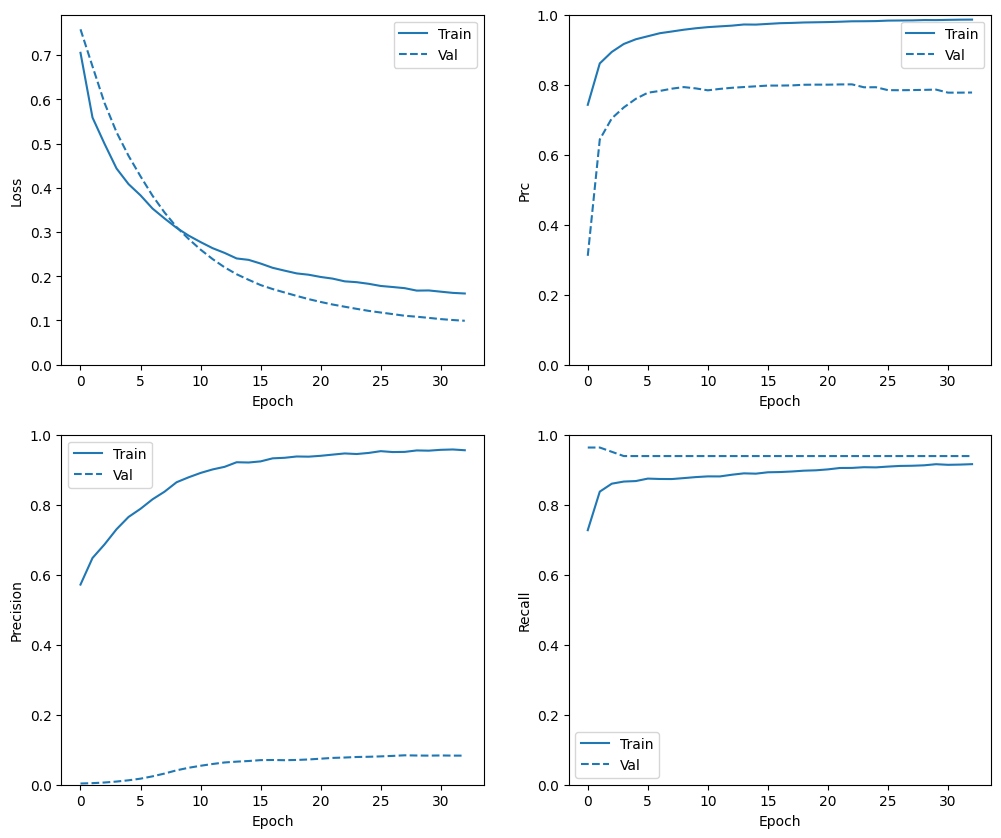

In [54]:
plot_metrics(resampled_history)

### Evaluate metrics

In [55]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step

50/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


loss :  0.129319429397583
compile_metrics :  0.129319429397583

Legitimate Transactions Detected (True Negatives):  55717
Legitimate Transactions Incorrectly Detected (False Positives):  1143
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  93
Total Fraudulent Transactions:  102


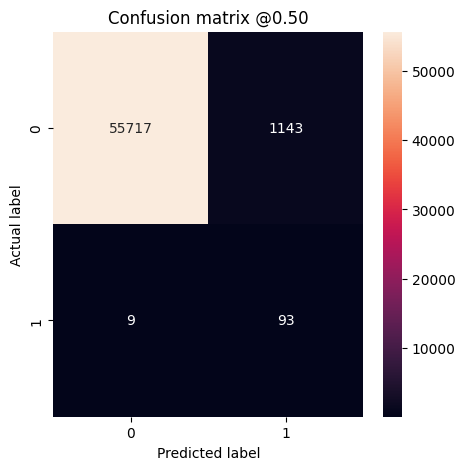

In [56]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

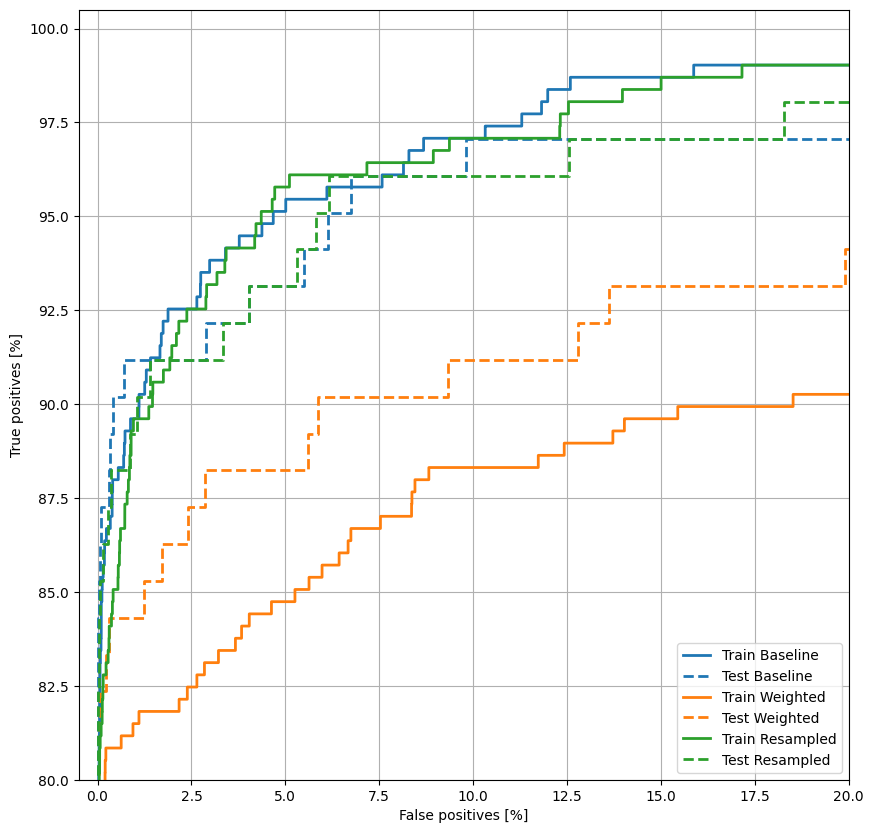

In [57]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


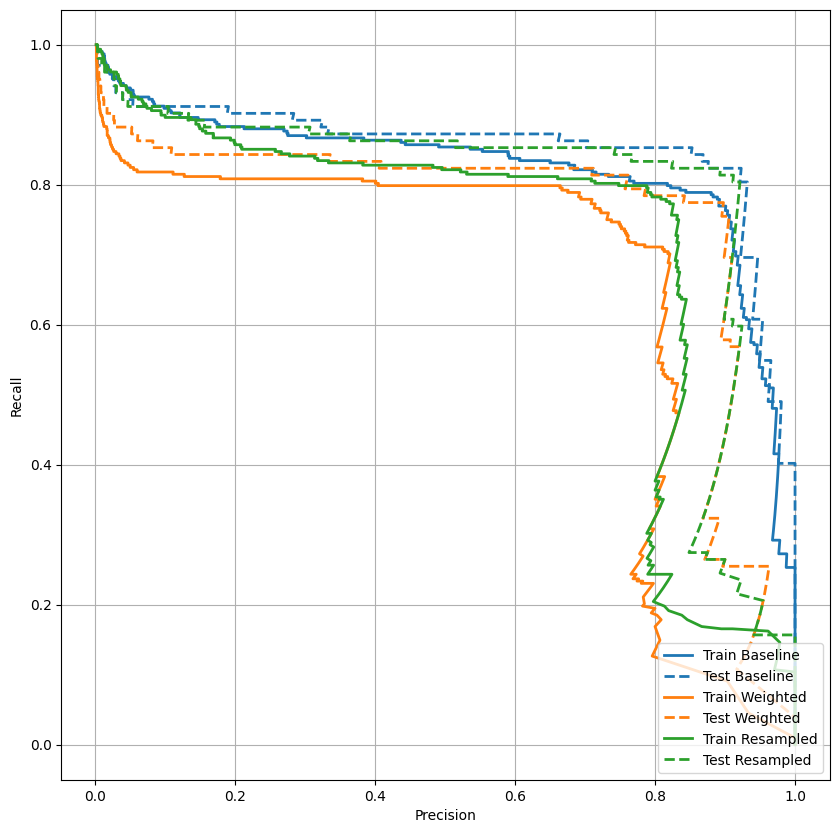

In [58]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.